In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import scipy
from utils.constants import letter_to_num
from utils.functions import altloc_per_res, flatten_to_one_list, rmsd, sidechain_RMSD
import math

In [5]:
#iterate through all processed files
pkl_files = Path("/Users/christinali/Documents/Rotations/Kim Lab/Processed Files").glob("*.pkl")
pdb_list = []                  #List of all pdb ids
aa_list = []                   #list of all residues from all files
res_altloc = []                #list of all altlocs for all res
correlation = []               #correlation between b factor and num_alt_loc
b_factor = []                  #list of all b_factor values - not including 0
num_altloc = []                #list of all num altloc values - not including w/ b factor = 0
b_factor_all = []
num_altloc_all = []
coords_all = []
length_aa = []                 #Length of each protein
RMSD_stored = []               #RMSD of each atom in residue
file = 0
included_files = 0

for pkl_dict in pkl_files:
    file_path = str(pkl_dict)
    pdb_dict = {}
    file += 1
    print(file)
    print(pkl_dict.stem)
    
    
    #deserialize dictionary
    with open(file_path,"rb") as f:
        pdb_dict = pickle.load(f)
    
    f.close()
    
    #Storing b-factor and num alt loc info as one list
    b_factor_list = list(np.concatenate(pdb_dict['b_factor']).flat) 
    num_altloc_list = list(np.concatenate(pdb_dict['num_altloc']).flat)
    assert len(b_factor_list) == len(num_altloc_list)
    
    # Filtering out high b factor and files w/o altloc
    if max(b_factor_list) > 80 or max(num_altloc_list) == 0:
        print("b factor or no conformations")
        continue
        
    #Filter out by RMSD
    a = [] #First location
    mask = [] #mask
    
    r,loc,atom = np.shape(pdb_dict['atom_mask'])
    loc = int(max(list(np.concatenate(pdb_dict['num_altloc']).flat))) #Max num alt loc

    
    #Processing mask and array a
    for i in range(0,r):
        res_mask = []
        res_a = []
        
        for k in range(0,atom):
            res_mask.append(pdb_dict['atom_mask'][i][0][k])
            res_a.append(pdb_dict['coords'][i][0][k])
            
        mask.append(res_mask)
        a.append(res_a)
    
    #Change to array
    mask = np.array(mask) 
    a = np.array(a)
    RMSD = []
    
    #For each alt loc - Checking backbone RMSD
    for j in range(0,loc):
        b = [] #Altloc
        nal = []
        
        for i in range(0,r):
            res_b = []
            res_max_altloc = max(pdb_dict['num_altloc'][i].flatten())  #num altloc in a residue
            
            for k in range(0,atom):
                atom_coords_b = pdb_dict['coords'][i][j+1][k]
                atom_coords_a = pdb_dict['coords'][i][0][k]
                
                #If no altloc --> fill with coords from a 
                if max(atom_coords_b.flatten()) == 0:
                    res_b.append(atom_coords_a)
                else:
                    res_b.append(atom_coords_b)
            
            #Checking if the coordinates are all the same for altloc > 0:
            res_coords_a = a[i]
            res_coords_b = np.array(res_b)
            same_coords = False
            
            if res_max_altloc > 0 and j < res_max_altloc: # j(index) should be 1 less than altloc #
                
                #if the coords are the same and not 0
                if sorted(res_coords_a.flatten()) == sorted(res_coords_b.flatten()) and max(res_coords_a.flatten()) != 0:
                    if res_max_altloc > 0:
                        res_max_altloc -= 1
                        print("same coords?")
                        same_coords = True
                        break

            
            if same_coords == True:
                break
                
            #Adding max altloc and coordinates for each residue
            nal.append(res_max_altloc)       
            b.append(res_b)
        
        if same_coords == True:
            RMSD = [2,2]
            break
                
        #Calculate backbone RMSD
        b = np.array(b)
        RMSD = rmsd(a[:,:4],b[:,:4],mask[:,:4])

        #if max RMSD >0.1 then exit for loop
        if max(RMSD) > 0.1:
            print("RMSD backbone too high: ")
            break
    
    if max(RMSD) > 0.1:
        print("Skipped file")
        continue
    
    #Calculating sidechain RMSD + storing
    RMSD_all = sidechain_RMSD(a,pdb_dict,mask)
    
    #Remove all files w/ only backbone conformations
    if max(RMSD_all.flatten()) == 0:
        print("Alt conformations in backbone/heteroatoms only")
        continue
    
    #Remove if sidechain RMSD < 2
    check_rmsd = RMSD_all.copy()
    check_rmsd[check_rmsd == 0] = np.nan

    
    if np.nanmin(check_rmsd) < 2 or math.isnan(np.nanmin(check_rmsd)):
        print("sidechain RMSD less than 2")
        continue
    
    #RMSD_all has shape (n_res, 6)
    RMSD_stored.append(RMSD_all)
    
    #Adding to list of all b factor/altloc
    b_factor_all.append(pdb_dict['b_factor'])
    num_altloc_all.append(pdb_dict['num_altloc'])
    coords_all.append(pdb_dict['coords'])
    
    #Getting dictionary w/ list of AA and num altloc per res
    per_res_dict = altloc_per_res(pdb_dict)
    aa_list.append(per_res_dict['aa'])
    res_altloc.append(per_res_dict['num_altloc'])
    
    #Only counting ones with altloc in sidechains
    for idx, aa in enumerate(per_res_dict['aa']):
        res_altloc_temp = per_res_dict['num_altloc'][idx]
        count = 0
        
        #number of altloc w/ RMSD
        for altloc in RMSD_all[idx]:
            if altloc == 0 or math.isnan(altloc):
                continue
            else:
                count += 1
        if count != res_altloc_temp:
            per_res_dict['num_altloc'][idx] = count
            print("backbone alternate location")
    
    #Removing all entries w/o b-factor value (b-factor = 0)
    ## Adding it to giant list of b factors
    max_index = len(b_factor_list)
    for i in range(0,max_index):
        if b_factor_list[i] == 0:
            continue
        else:
            b_factor.append(b_factor_list[i])
            num_altloc.append(num_altloc_list[i])
    
    assert len(b_factor) == len(num_altloc)
    assert len(b_factor_all) == len(num_altloc_all)

    #Storing
    pdb_list.append(pkl_dict.stem)
    length_aa.append(len(pdb_dict['aa']))
    included_files += 1  

print("total number of included files:" + str(included_files))

1
5SPV
RMSD backbone too high: 
Skipped file
2
6J6D
b factor or no conformations
3
6APE
RMSD backbone too high: 
Skipped file
4
3WW6
RMSD backbone too high: 
Skipped file
5
4PQ9
RMSD backbone too high: 
Skipped file
6
1FU0
b factor or no conformations
7
5QH3
b factor or no conformations
8
2ZXJ
9
1M0K
b factor or no conformations
10
7BRP
b factor or no conformations
11
8D9A
RMSD backbone too high: 
Skipped file
12
6CKZ
sidechain RMSD less than 2
13
5SSM
b factor or no conformations
14
8CIW
b factor or no conformations
15
5SP7
RMSD backbone too high: 
Skipped file
16
2XC4
sidechain RMSD less than 2
17
7G9Y
b factor or no conformations
18
5QHR
b factor or no conformations
19
7BR1
RMSD backbone too high: 
Skipped file
20
7BQK
b factor or no conformations
21
7P9C
b factor or no conformations
22
4GR8
sidechain RMSD less than 2
23
1QV1
sidechain RMSD less than 2
24
4B9P
RMSD backbone too high: 
Skipped file
25
6ZE2
RMSD backbone too high: 
Skipped file
26
4KG4
b factor or no conformations
27


RMSD backbone too high: 
Skipped file
222
8AQD
b factor or no conformations
223
7ETA
b factor or no conformations
224
6DMK
b factor or no conformations
225
1J6Z
sidechain RMSD less than 2
226
4YZA
b factor or no conformations
227
8FT8
b factor or no conformations
228
6HXG
b factor or no conformations
229
3U95
b factor or no conformations
230
1CKD
b factor or no conformations
231
7KZ3
b factor or no conformations
232
6DNP
b factor or no conformations
233
4WT3
b factor or no conformations
234
2X5R
b factor or no conformations
235
2QHL
b factor or no conformations
236
7GLE
237
6FUO
b factor or no conformations
238
4ULV
RMSD backbone too high: 
Skipped file
239
1MFL
sidechain RMSD less than 2
240
5H3G
sidechain RMSD less than 2
241
6QUU
b factor or no conformations
242
4BLL
sidechain RMSD less than 2
243
1THE
b factor or no conformations
244
4K1R
b factor or no conformations
245
1S82
RMSD backbone too high: 
Skipped file
246
3EJC
b factor or no conformations
247
3EI9
b factor or no conform

sidechain RMSD less than 2
437
7RZP
b factor or no conformations
438
5CX7
b factor or no conformations
439
3B7E
sidechain RMSD less than 2
440
4LLT
b factor or no conformations
441
2HHN
RMSD backbone too high: 
Skipped file
442
4NT1
sidechain RMSD less than 2
443
4NWK
sidechain RMSD less than 2
444
7RYK
RMSD backbone too high: 
Skipped file
445
3EG2
RMSD backbone too high: 
Skipped file
446
3EDH
RMSD backbone too high: 
Skipped file
447
1S69
b factor or no conformations
448
5VC2
b factor or no conformations
449
2V5J
b factor or no conformations
450
4YWQ
RMSD backbone too high: 
Skipped file
451
7KT8
b factor or no conformations
452
7GA4
b factor or no conformations
453
5Q3E
b factor or no conformations
454
7GBN
455
1OPC
b factor or no conformations
456
1OS9
b factor or no conformations
457
4WZY
b factor or no conformations
458
1D58
b factor or no conformations
459
3RGI
460
4R2K
sidechain RMSD less than 2
461
6JMS
RMSD backbone too high: 
Skipped file
462
1J8Q
b factor or no conformatio

sidechain RMSD less than 2
654
6J8O
b factor or no conformations
655
7LQ2
b factor or no conformations
656
7LRH
b factor or no conformations
657
3UAX
RMSD backbone too high: 
Skipped file
658
6CEQ
b factor or no conformations
659
8D7J
b factor or no conformations
660
5QF8
b factor or no conformations
661
5QEB
b factor or no conformations
662
3RRH
b factor or no conformations
663
3RQ2
sidechain RMSD less than 2
664
1OEB
b factor or no conformations
665
5XXA
b factor or no conformations
666
1OF8
b factor or no conformations
667
1AKQ
b factor or no conformations
668
8FLH
RMSD backbone too high: 
Skipped file
669
3PIW
sidechain RMSD less than 2
670
1H55
RMSD backbone too high: 
Skipped file
671
4UTG
b factor or no conformations
672
6JX3
sidechain RMSD less than 2
673
3W9A
b factor or no conformations
674
1AK0
b factor or no conformations
675
4WO9
676
4YBP
b factor or no conformations
677
1H5T
b factor or no conformations
678
3PJL
b factor or no conformations
679
3PI6
sidechain RMSD less th

RMSD backbone too high: 
Skipped file
875
4RRV
RMSD backbone too high: 
Skipped file
876
4Y4W
RMSD backbone too high: 
Skipped file
877
2VU6
RMSD backbone too high: 
Skipped file
878
8F9T
b factor or no conformations
879
5QS9
RMSD backbone too high: 
Skipped file
880
5QPC
RMSD backbone too high: 
Skipped file
881
6F8B
b factor or no conformations
882
8AJY
b factor or no conformations
883
5Z6B
b factor or no conformations
884
7BIZ
b factor or no conformations
885
4RQM
b factor or no conformations
886
4RR7
b factor or no conformations
887
2VUW
b factor or no conformations
888
4Y7L
b factor or no conformations
889
1O3E
sidechain RMSD less than 2
890
6H5J
RMSD backbone too high: 
Skipped file
891
3UWB
892
5Z5Y
b factor or no conformations
893
5FSB
sidechain RMSD less than 2
894
1QNA
sidechain RMSD less than 2
895
5FP8
b factor or no conformations
896
6TSQ
RMSD backbone too high: 
Skipped file
897
3BWX
sidechain RMSD less than 2
898
5M69
RMSD backbone too high: 
Skipped file
899
5JE4
b fact

sidechain RMSD less than 2
1088
4PDY
RMSD backbone too high: 
Skipped file
1089
8AD3
RMSD backbone too high: 
Skipped file
1090
6F5R
b factor or no conformations
1091
3WAM
b factor or no conformations
1092
2VXG
b factor or no conformations
1093
4W4O
b factor or no conformations
1094
7K95
b factor or no conformations
1095
7LIB
sidechain RMSD less than 2
1096
7BGQ
RMSD backbone too high: 
Skipped file
1097
3UZR
b factor or no conformations
1098
8ADR
b factor or no conformations
1099
6F53
b factor or no conformations
1100
6H8Z
b factor or no conformations
1101
6JU4
1102
7EAW
b factor or no conformations
1103
6A0O
b factor or no conformations
1104
6HMQ
RMSD backbone too high: 
Skipped file
1105
3PD1
b factor or no conformations
1106
4P2I
b factor or no conformations
1107
4P13
b factor or no conformations
1108
7B2Z
b factor or no conformations
1109
5ZN8
b factor or no conformations
1110
5S3G
RMSD backbone too high: 
Skipped file
1111
6JUU
sidechain RMSD less than 2
1112
5XUF
RMSD backbone t

b factor or no conformations
1303
7C88
b factor or no conformations
1304
1BT0
b factor or no conformations
1305
1LYY
b factor or no conformations
1306
3SV6
b factor or no conformations
1307
6EQE
same coords?
Skipped file
1308
3SUL
b factor or no conformations
1309
5R9D
b factor or no conformations
1310
5WQV
b factor or no conformations
1311
3X3M
b factor or no conformations
1312
6N7D
b factor or no conformations
1313
4XFO
b factor or no conformations
1314
5K7M
b factor or no conformations
1315
8PKV
b factor or no conformations
1316
6W9M
b factor or no conformations
1317
4H5X
b factor or no conformations
1318
7QP0
b factor or no conformations
1319
2GT9
1320
7QSJ
RMSD backbone too high: 
Skipped file
1321
1UWP
sidechain RMSD less than 2
1322
7Z5K
b factor or no conformations
1323
4OEN
sidechain RMSD less than 2
1324
1YAG
b factor or no conformations
1325
3O36
b factor or no conformations
1326
3O0L
b factor or no conformations
1327
4OF4
RMSD backbone too high: 
Skipped file
1328
6Y4E
RMSD

sidechain RMSD less than 2
1517
7ZCL
b factor or no conformations
1518
2BIV
b factor or no conformations
1519
5EMF
b factor or no conformations
1520
3OD5
b factor or no conformations
1521
6YCF
sidechain RMSD less than 2
1522
4O17
b factor or no conformations
1523
4FOS
RMSD backbone too high: 
Skipped file
1524
5GVY
1525
3H78
sidechain RMSD less than 2
1526
5IXJ
RMSD backbone too high: 
Skipped file
1527
6UVJ
sidechain RMSD less than 2
1528
4JYD
same coords?
Skipped file
1529
4DWW
b factor or no conformations
1530
3AJG
sidechain RMSD less than 2
1531
3ODT
RMSD backbone too high: 
Skipped file
1532
314D
b factor or no conformations
1533
5GUB
sidechain RMSD less than 2
1534
4FO2
RMSD backbone too high: 
Skipped file
1535
5GV8
b factor or no conformations
1536
6UUQ
b factor or no conformations
1537
5PUX
RMSD backbone too high: 
Skipped file
1538
4QLR
b factor or no conformations
1539
7OYM
b factor or no conformations
1540
4QOI
b factor or no conformations
1541
5PU9
RMSD backbone too high: 

sidechain RMSD less than 2
1723
5R7X
b factor or no conformations
1724
4XHS
b factor or no conformations
1725
3DX0
RMSD backbone too high: 
Skipped file
1726
7SFI
b factor or no conformations
1727
5E7B
RMSD backbone too high: 
Skipped file
1728
5NR9
b factor or no conformations
1729
3A3X
RMSD backbone too high: 
Skipped file
1730
8PEJ
RMSD backbone too high: 
Skipped file
1731
1WBS
b factor or no conformations
1732
2IT6
1733
1UYL
sidechain RMSD less than 2
1734
3JU8
b factor or no conformations
1735
5K90
RMSD backbone too high: 
Skipped file
1736
3A39
RMSD backbone too high: 
Skipped file
1737
6W70
b factor or no conformations
1738
4AEA
b factor or no conformations
1739
3FCN
RMSD backbone too high: 
Skipped file
1740
4F56
sidechain RMSD less than 2
1741
1UZW
sidechain RMSD less than 2
1742
4MS7
RMSD backbone too high: 
Skipped file
1743
4MPM
b factor or no conformations
1744
1BXE
b factor or no conformations
1745
6GEU
b factor or no conformations
1746
2PXV
b factor or no conformations


RMSD backbone too high: 
Skipped file
1930
1RJK
1931
5ET2
b factor or no conformations
1932
3ASR
sidechain RMSD less than 2
1933
2I7F
b factor or no conformations
1934
4HX4
1935
5IBD
b factor or no conformations
1936
3CHM
RMSD backbone too high: 
Skipped file
1937
6ULD
RMSD backbone too high: 
Skipped file
1938
2BQG
b factor or no conformations
1939
4DMY
sidechain RMSD less than 2
1940
8UM3
1941
5ETS
b factor or no conformations
1942
6YZS
RMSD backbone too high: 
Skipped file
1943
7VN0
RMSD backbone too high: 
Skipped file
1944
1PQ5
RMSD backbone too high: 
Skipped file
1945
2G94
b factor or no conformations
1946
1WW3
b factor or no conformations
1947
7X6R
b factor or no conformations
1948
6RIY
RMSD backbone too high: 
Skipped file
1949
5BRU
RMSD backbone too high: 
Skipped file
1950
1UOV
sidechain RMSD less than 2
1951
3M0N
b factor or no conformations
1952
4MF6
b factor or no conformations
1953
3M34
sidechain RMSD less than 2
1954
2IAV
sidechain RMSD less than 2
1955
6PRF
b factor or

RMSD backbone too high: 
Skipped file
2148
1WVA
b factor or no conformations
2149
6PPN
b factor or no conformations
2150
4MGD
sidechain RMSD less than 2
2151
3M2F
b factor or no conformations
2152
6RHJ
sidechain RMSD less than 2
2153
3DLC
RMSD backbone too high: 
Skipped file
2154
6RK0
b factor or no conformations
2155
5NE0
RMSD backbone too high: 
Skipped file
2156
5NFJ
b factor or no conformations
2157
3HZ5
sidechain RMSD less than 2
2158
3HYO
b factor or no conformations
2159
5I5G
b factor or no conformations
2160
5BSF
b factor or no conformations
2161
4CJL
b factor or no conformations
2162
1UNE
b factor or no conformations
2163
6GP5
b factor or no conformations
2164
5P84
b factor or no conformations
2165
3QWF
b factor or no conformations
2166
4TJV
sidechain RMSD less than 2
2167
7DQZ
b factor or no conformations
2168
5WK9
b factor or no conformations
2169
7A9H
sidechain RMSD less than 2
2170
2Y3R
RMSD backbone too high: 
Skipped file
2171
5P8U
b factor or no conformations
2172
5UPG

RMSD backbone too high: 
Skipped file
2359
1B5H
b factor or no conformations
2360
7MWS
b factor or no conformations
2361
3ZJP
sidechain RMSD less than 2
2362
1IP3
b factor or no conformations
2363
4QYS
b factor or no conformations
2364
2WFV
sidechain RMSD less than 2
2365
6NUF
b factor or no conformations
2366
7OLL
b factor or no conformations
2367
3S44
sidechain RMSD less than 2
2368
6WX5
b factor or no conformations
2369
7VBE
b factor or no conformations
2370
7XLV
b factor or no conformations
2371
5KV5
b factor or no conformations
2372
5KUO
b factor or no conformations
2373
7ZWI
b factor or no conformations
2374
5INP
b factor or no conformations
2375
7Q1H
b factor or no conformations
2376
4FYI
sidechain RMSD less than 2
2377
7XL7
b factor or no conformations
2378
5EXG
RMSD backbone too high: 
Skipped file
2379
4DAM
b factor or no conformations
2380
7ZTR
b factor or no conformations
2381
1U53
b factor or no conformations
2382
3CGB
sidechain RMSD less than 2
2383
4HTA
b factor or no co

RMSD backbone too high: 
Skipped file
2572
3D6Q
sidechain RMSD less than 2
2573
5KW0
b factor or no conformations
2574
3OPP
RMSD backbone too high: 
Skipped file
2575
6YTY
RMSD backbone too high: 
Skipped file
2576
3CD9
sidechain RMSD less than 2
2577
6R0G
sidechain RMSD less than 2
2578
4DB6
RMSD backbone too high: 
Skipped file
2579
3ORO
2580
6YVF
b factor or no conformations
2581
5INQ
b factor or no conformations
2582
7Q1I
sidechain RMSD less than 2
2583
3MI1
RMSD backbone too high: 
Skipped file
2584
5KUN
RMSD backbone too high: 
Skipped file
2585
4JLD
RMSD backbone too high: 
Skipped file
2586
5KV4
b factor or no conformations
2587
4DBW
sidechain RMSD less than 2
2588
7VBD
b factor or no conformations
2589
6WX4
b factor or no conformations
2590
7XLW
b factor or no conformations
2591
3S7O
RMSD backbone too high: 
Skipped file
2592
1EFD
b factor or no conformations
2593
3S45
sidechain RMSD less than 2
2594
2WFW
sidechain RMSD less than 2
2595
7OLM
sidechain RMSD less than 2
2596
7OO

sidechain RMSD less than 2
2787
8GQC
b factor or no conformations
2788
3SOC
b factor or no conformations
2789
6EKJ
b factor or no conformations
2790
6EH0
RMSD backbone too high: 
Skipped file
2791
6KEY
b factor or no conformations
2792
6B8G
RMSD backbone too high: 
Skipped file
2793
5UPF
b factor or no conformations
2794
5P8T
b factor or no conformations
2795
6GPU
RMSD backbone too high: 
Skipped file
2796
2Y3S
RMSD backbone too high: 
Skipped file
2797
6KFB
RMSD backbone too high: 
Skipped file
2798
4TJW
b factor or no conformations
2799
6L65
b factor or no conformations
2800
1LC7
b factor or no conformations
2801
6L5O
RMSD backbone too high: 
Skipped file
2802
3QWG
b factor or no conformations
2803
5P85
b factor or no conformations
2804
6GP4
b factor or no conformations
2805
4CI7
b factor or no conformations
2806
5BSG
b factor or no conformations
2807
5I5F
b factor or no conformations
2808
3HYN
RMSD backbone too high: 
Skipped file
2809
2GNW
b factor or no conformations
2810
4AQR
b f

RMSD backbone too high: 
Skipped file
2997
3CJS
b factor or no conformations
2998
4M1B
b factor or no conformations
2999
7ZZ9
b factor or no conformations
3000
2I5X
sidechain RMSD less than 2
3001
1PP0
b factor or no conformations
3002
2G81
RMSD backbone too high: 
Skipped file
3003
5GM3
b factor or no conformations
3004
6WUE
b factor or no conformations
3005
6UMA
b factor or no conformations
3006
2BPB
3007
3CJ2
b factor or no conformations
3008
7TTK
b factor or no conformations
3009
5GMR
b factor or no conformations
3010
4HY1
b factor or no conformations
3011
5N36
RMSD backbone too high: 
Skipped file
3012
5N0L
b factor or no conformations
3013
3ARW
b factor or no conformations
3014
1RH4
b factor or no conformations
3015
441D
b factor or no conformations
3016
3CKW
b factor or no conformations
3017
4FVG
b factor or no conformations
3018
2G95
b factor or no conformations
3019
1PQ4
b factor or no conformations
3020
4HXT
b factor or no conformations
3021
6YZR
RMSD backbone too high: 
Skip

RMSD backbone too high: 
Skipped file
3214
2R59
b factor or no conformations
3215
7MOT
RMSD backbone too high: 
Skipped file
3216
1IH4
b factor or no conformations
3217
4QAT
b factor or no conformations
3218
7OWP
b factor or no conformations
3219
4V28
RMSD backbone too high: 
Skipped file
3220
8G2R
b factor or no conformations
3221
7MO5
b factor or no conformations
3222
7MLO
b factor or no conformations
3223
5U3W
b factor or no conformations
3224
3Q47
b factor or no conformations
3225
4QBO
RMSD backbone too high: 
Skipped file
3226
4QA5
b factor or no conformations
3227
3Q7M
b factor or no conformations
3228
228L
b factor or no conformations
3229
5B07
b factor or no conformations
3230
6UX6
b factor or no conformations
3231
3F7W
RMSD backbone too high: 
Skipped file
3232
3OJI
RMSD backbone too high: 
Skipped file
3233
1Y88
RMSD backbone too high: 
Skipped file
3234
1W5Q
b factor or no conformations
3235
4A1X
RMSD backbone too high: 
Skipped file
3236
3ADZ
b factor or no conformations
32

b factor or no conformations
3429
6YCG
sidechain RMSD less than 2
3430
3OGN
sidechain RMSD less than 2
3431
1W8V
b factor or no conformations
3432
2E8E
b factor or no conformations
3433
4DTM
b factor or no conformations
3434
5EMG
b factor or no conformations
3435
5KCT
b factor or no conformations
3436
3HB2
b factor or no conformations
3437
4H4J
RMSD backbone too high: 
Skipped file
3438
4CQ1
b factor or no conformations
3439
7SIG
sidechain RMSD less than 2
3440
6RS7
sidechain RMSD less than 2
3441
4OGG
b factor or no conformations
3442
6Y56
b factor or no conformations
3443
3O2E
sidechain RMSD less than 2
3444
6Y6L
b factor or no conformations
3445
2GV0
b factor or no conformations
3446
6PHI
sidechain RMSD less than 2
3447
7QQC
RMSD backbone too high: 
Skipped file
3448
7Z7B
3449
7T9Q
b factor or no conformations
3450
1UUY
sidechain RMSD less than 2
3451
2ENU
sidechain RMSD less than 2
3452
6RSV
RMSD backbone too high: 
Skipped file
3453
3JZ6
b factor or no conformations
3454
4AJO
side

sidechain RMSD less than 2
3652
1I1J
RMSD backbone too high: 
Skipped file
3653
1I20
b factor or no conformations
3654
4XEU
b factor or no conformations
3655
5WQ6
b factor or no conformations
3656
7DKU
RMSD backbone too high: 
Skipped file
3657
1LZC
b factor or no conformations
3658
7M6K
b factor or no conformations
3659
7M51
b factor or no conformations
3660
4TPY
RMSD backbone too high: 
Skipped file
3661
7C8X
b factor or no conformations
3662
7FPJ
b factor or no conformations
3663
4Q8K
b factor or no conformations
3664
5ROU
b factor or no conformations
3665
1ERV
sidechain RMSD less than 2
3666
7AVL
b factor or no conformations
3667
1N4W
RMSD backbone too high: 
Skipped file
3668
6NAU
b factor or no conformations
3669
5PTJ
b factor or no conformations
3670
6BTY
sidechain RMSD less than 2
3671
3TPP
RMSD backbone too high: 
Skipped file
3672
6LZJ
b factor or no conformations
3673
1EQM
RMSD backbone too high: 
Skipped file
3674
6NA4
RMSD backbone too high: 
Skipped file
3675
5PWQ
b facto

b factor or no conformations
3866
7BG1
b factor or no conformations
3867
7LJX
b factor or no conformations
3868
6MSR
b factor or no conformations
3869
7K9U
b factor or no conformations
3870
7E7F
b factor or no conformations
3871
3WBW
b factor or no conformations
3872
4W7U
RMSD backbone too high: 
Skipped file
3873
6OHM
b factor or no conformations
3874
7NQG
sidechain RMSD less than 2
3875
4Y9F
sidechain RMSD less than 2
3876
6VFD
RMSD backbone too high: 
Skipped file
3877
6Q5I
b factor or no conformations
3878
4GDB
sidechain RMSD less than 2
3879
7UDQ
b factor or no conformations
3880
5C5Z
b factor or no conformations
3881
3BYR
sidechain RMSD less than 2
3882
5M83
b factor or no conformations
3883
3LWA
sidechain RMSD less than 2
3884
2D34
b factor or no conformations
3885
2D0N
b factor or no conformations
3886
5DF6
RMSD backbone too high: 
Skipped file
3887
4KRU
3888
2OU5
sidechain RMSD less than 2
3889
1QCP
b factor or no conformations
3890
6Q6R
b factor or no conformations
3891
4IJ0


RMSD backbone too high: 
Skipped file
4089
2QRT
b factor or no conformations
4090
2Z4U
RMSD backbone too high: 
Skipped file
4091
7EN8
b factor or no conformations
4092
6DTH
b factor or no conformations
4093
6DW2
b factor or no conformations
4094
7EMB
b factor or no conformations
4095
4WMQ
RMSD backbone too high: 
Skipped file
4096
8FNA
b factor or no conformations
4097
4YCB
RMSD backbone too high: 
Skipped file
4098
1OD1
b factor or no conformations
4099
2QS1
RMSD backbone too high: 
Skipped file
4100
1AKG
sidechain RMSD less than 2
4101
4WL4
RMSD backbone too high: 
Skipped file
4102
115D
b factor or no conformations
4103
6FNS
b factor or no conformations
4104
2QSP
4105
1H5B
RMSD backbone too high: 
Skipped file
4106
7L1X
b factor or no conformations
4107
8JZI
b factor or no conformations
4108
4UWJ
b factor or no conformations
4109
4YBF
b factor or no conformations
4110
1OFO
b factor or no conformations
4111
5XX6
RMSD backbone too high: 
Skipped file
4112
3W9W
sidechain RMSD less tha

b factor or no conformations
4300
2XXI
RMSD backbone too high: 
Skipped file
4301
4Y4A
RMSD backbone too high: 
Skipped file
4302
1O32
sidechain RMSD less than 2
4303
8AIT
sidechain RMSD less than 2
4304
5QP4
b factor or no conformations
4305
8OGG
RMSD backbone too high: 
Skipped file
4306
5Z5O
b factor or no conformations
4307
7BJW
RMSD backbone too high: 
Skipped file
4308
8CRK
b factor or no conformations
4309
6OFQ
b factor or no conformations
4310
8H70
b factor or no conformations
4311
3WLK
sidechain RMSD less than 2
4312
6AK8
RMSD backbone too high: 
Skipped file
4313
4W9I
b factor or no conformations
4314
2VUA
sidechain RMSD less than 2
4315
4EQA
b factor or no conformations
4316
5DK1
RMSD backbone too high: 
Skipped file
4317
5JFX
b factor or no conformations
4318
6XFK
b factor or no conformations
4319
3NA8
sidechain RMSD less than 2
4320
6VHX
b factor or no conformations
4321
5FST
RMSD backbone too high: 
Skipped file
4322
4IG7
b factor or no conformations
4323
7UJM
RMSD backbo

4510
4YTK
RMSD backbone too high: 
Skipped file
4511
5VCR
b factor or no conformations
4512
4WZX
b factor or no conformations
4513
7GBO
4514
2QFF
4515
5Q3D
b factor or no conformations
4516
7GA5
sidechain RMSD less than 2
4517
7KT9
RMSD backbone too high: 
Skipped file
4518
3RDS
RMSD backbone too high: 
Skipped file
4519
7EYP
b factor or no conformations
4520
4WYC
RMSD backbone too high: 
Skipped file
4521
5VC3
b factor or no conformations
4522
2V61
b factor or no conformations
4523
4YWP
b factor or no conformations
4524
1OSY
b factor or no conformations
4525
1S68
b factor or no conformations
4526
7RZ0
RMSD backbone too high: 
Skipped file
4527
3EDI
sidechain RMSD less than 2
4528
3EG3
RMSD backbone too high: 
Skipped file
4529
7W1X
sidechain RMSD less than 2
4530
2O88
b factor or no conformations
4531
4NT0
RMSD backbone too high: 
Skipped file
4532
1XP9
b factor or no conformations
4533
3IQE
sidechain RMSD less than 2
4534
6T3M
RMSD backbone too high: 
Skipped file
4535
6T07
sidechain

sidechain RMSD less than 2
4723
7NFN
sidechain RMSD less than 2
4724
2XBG
RMSD backbone too high: 
Skipped file
4725
5X7E
b factor or no conformations
4726
6AQW
b factor or no conformations
4727
4PS0
sidechain RMSD less than 2
4728
1FW9
b factor or no conformations
4729
7G8K
b factor or no conformations
4730
3UMZ
b factor or no conformations
4731
6CIS
b factor or no conformations
4732
1M2B
b factor or no conformations
4733
3WVE
b factor or no conformations
4734
6ARL
b factor or no conformations
4735
6AQ6
b factor or no conformations
4736
5V97
b factor or no conformations
4737
8AQE
b factor or no conformations
4738
6CH6
RMSD backbone too high: 
Skipped file
4739
4RJ0
b factor or no conformations
4740
5V8R
b factor or no conformations
4741
6APS
b factor or no conformations
4742
2VMP
sidechain RMSD less than 2
4743
5X6A
b factor or no conformations
4744
7NGJ
b factor or no conformations
4745
4PQN
b factor or no conformations
4746
7G9O
b factor or no conformations
4747
4PR4
RMSD backbone t

/var/folders/80/jhzr0zpd32vcl5cw68r1572r0000gn/T/ipykernel_54117/472828001.py:138: RuntimeWarning: All-NaN slice encountered
  if np.nanmin(check_rmsd) < 2 or math.isnan(np.nanmin(check_rmsd)):


4867
8D8D
b factor or no conformations
4868
2ZYO
b factor or no conformations
4869
1M1N
sidechain RMSD less than 2
4870
1M24
b factor or no conformations
4871
2ZZ5
RMSD backbone too high: 
Skipped file
4872
5QJL
b factor or no conformations
4873
1FT5
b factor or no conformations
4874
5QI6
same coords?
Skipped file
4875
4PSF
b factor or no conformations
4876
3WUI
4877
2VO9
b factor or no conformations
4878
3WV3
sidechain RMSD less than 2
4879
5X7R
b factor or no conformations
4880
2XBP
RMSD backbone too high: 
Skipped file
4881
1JBC
sidechain RMSD less than 2
4882
1JA9
b factor or no conformations
4883
6D9R
b factor or no conformations
4884
5SQS
RMSD backbone too high: 
Skipped file
4885
5O42
RMSD backbone too high: 
Skipped file
4886
4KFP
b factor or no conformations
4887
4EHC
sidechain RMSD less than 2
4888
5DR3
RMSD backbone too high: 
Skipped file
4889
2CWF
b factor or no conformations
4890
5HDE
sidechain RMSD less than 2
4891
5O4S
b factor or no conformations
4892
2AOB
b factor or 

sidechain RMSD less than 2
5083
2DPF
b factor or no conformations
5084
4NZO
b factor or no conformations
5085
4NY5
b factor or no conformations
5086
5AMV
sidechain RMSD less than 2
5087
3GQH
RMSD backbone too high: 
Skipped file
5088
2FHB
b factor or no conformations
5089
3GR2
RMSD backbone too high: 
Skipped file
5090
1THQ
b factor or no conformations
5091
4BLX
sidechain RMSD less than 2
5092
3B9Z
b factor or no conformations
5093
5CUR
sidechain RMSD less than 2
5094
1ZFB
b factor or no conformations
5095
4LBK
sidechain RMSD less than 2
5096
3KDD
RMSD backbone too high: 
Skipped file
5097
3EJW
b factor or no conformations
5098
1VP4
b factor or no conformations
5099
5AM7
b factor or no conformations
5100
1VSN
b factor or no conformations
5101
4YYN
b factor or no conformations
5102
2X5F
sidechain RMSD less than 2
5103
6HX2
sidechain RMSD less than 2
5104
5TV2
b factor or no conformations
5105
5TUH
b factor or no conformations
5106
8DOR
sidechain RMSD less than 2
5107
8JAA
b factor or no

RMSD backbone too high: 
Skipped file
5293
6CHU
b factor or no conformations
5294
5SPB
RMSD backbone too high: 
Skipped file
5295
4RJ2
RMSD backbone too high: 
Skipped file
5296
5SS8
RMSD backbone too high: 
Skipped file
5297
6J6P
RMSD backbone too high: 
Skipped file
5298
2VMR
sidechain RMSD less than 2
5299
6APQ
b factor or no conformations
5300
4PRW
b factor or no conformations
5301
8AQG
RMSD backbone too high: 
Skipped file
5302
7BRD
sidechain RMSD less than 2
5303
7NJ9
RMSD backbone too high: 
Skipped file
5304
5X8H
b factor or no conformations
5305
2XMJ
RMSD backbone too high: 
Skipped file
5306
6OS3
sidechain RMSD less than 2
5307
3WZS
b factor or no conformations
5308
6D52
sidechain RMSD less than 2
5309
4RGC
RMSD backbone too high: 
Skipped file
5310
3UB6
RMSD backbone too high: 
Skipped file
5311
6CEE
5312
3UAL
RMSD backbone too high: 
Skipped file
5313
5QEV
b factor or no conformations
5314
2Q0T
RMSD backbone too high: 
Skipped file
5315
3WYH
b factor or no conformations
531

RMSD backbone too high: 
Skipped file
5516
1D67
b factor or no conformations
5517
4R1D
sidechain RMSD less than 2
5518
3U7K
b factor or no conformations
5519
6C3B
RMSD backbone too high: 
Skipped file
5520
4UA3
b factor or no conformations
5521
5TX9
b factor or no conformations
5522
7GBZ
sidechain RMSD less than 2
5523
2QFS
sidechain RMSD less than 2
5524
5Q3Q
b factor or no conformations
5525
6T3X
b factor or no conformations
5526
8SAC
b factor or no conformations
5527
1TFZ
5528
5MUJ
RMSD backbone too high: 
Skipped file
5529
3L9B
b factor or no conformations
5530
5MV0
RMSD backbone too high: 
Skipped file
5531
6QX0
RMSD backbone too high: 
Skipped file
5532
5F01
b factor or no conformations
5533
5F3K
b factor or no conformations
5534
2FE3
sidechain RMSD less than 2
5535
2A5D
5536
7W27
b factor or no conformations
5537
1XSV
b factor or no conformations
5538
3KJO
b factor or no conformations
5539
3KI5
RMSD backbone too high: 
Skipped file
5540
5MVQ
b factor or no conformations
5541
6T3

sidechain RMSD less than 2
5730
477D
b factor or no conformations
5731
4IGT
RMSD backbone too high: 
Skipped file
5732
5DKR
sidechain RMSD less than 2
5733
2AU8
b factor or no conformations
5734
6VKA
b factor or no conformations
5735
7WRK
b factor or no conformations
5736
5FSV
RMSD backbone too high: 
Skipped file
5737
3BWL
sidechain RMSD less than 2
5738
6TSE
b factor or no conformations
5739
7UJO
sidechain RMSD less than 2
5740
2J3X
RMSD backbone too high: 
Skipped file
5741
4ER9
b factor or no conformations
5742
2AUY
b factor or no conformations
5743
6XE3
RMSD backbone too high: 
Skipped file
5744
1X3K
b factor or no conformations
5745
2OX0
sidechain RMSD less than 2
5746
6XFI
b factor or no conformations
5747
8CQ3
b factor or no conformations
5748
7E9X
b factor or no conformations
5749
4W9K
b factor or no conformations
5750
2VUC
RMSD backbone too high: 
Skipped file
5751
2VV9
sidechain RMSD less than 2
5752
3WLI
sidechain RMSD less than 2
5753
5QP6
b factor or no conformations
5754

sidechain RMSD less than 2
5946
7PWA
RMSD backbone too high: 
Skipped file
5947
6QNK
b factor or no conformations
5948
2FP2
RMSD backbone too high: 
Skipped file
5949
4BWR
sidechain RMSD less than 2
5950
5MC1
b factor or no conformations
5951
6SUT
b factor or no conformations
5952
1VHD
sidechain RMSD less than 2
5953
6DUN
b factor or no conformations
5954
6DV4
RMSD backbone too high: 
Skipped file
5955
5XX4
5956
1OFM
b factor or no conformations
5957
1OE7
b factor or no conformations
5958
6HC8
b factor or no conformations
5959
6FNQ
b factor or no conformations
5960
8DTX
b factor or no conformations
5961
4UT2
b factor or no conformations
5962
5TM8
b factor or no conformations
5963
4UWH
b factor or no conformations
5964
6DVU
b factor or no conformations
5965
6JXF
b factor or no conformations
5966
4WL6
b factor or no conformations
5967
4WOL
b factor or no conformations
5968
2QS3
RMSD backbone too high: 
Skipped file
5969
3PIC
b factor or no conformations
5970
7L2A
b factor or no conformat

b factor or no conformations
6172
3LWT
b factor or no conformations
6173
5HP4
b factor or no conformations
6174
1V3S
b factor or no conformations
6175
2OUA
b factor or no conformations
6176
5DFB
6177
6ZPF
b factor or no conformations
6178
2CCV
b factor or no conformations
6179
4GGL
b factor or no conformations
6180
3G14
sidechain RMSD less than 2
6181
4GD6
sidechain RMSD less than 2
6182
2OVZ
b factor or no conformations
6183
1V0H
sidechain RMSD less than 2
6184
2AXI
sidechain RMSD less than 2
6185
6VF0
b factor or no conformations
6186
5JKJ
RMSD backbone too high: 
Skipped file
6187
6ZRY
RMSD backbone too high: 
Skipped file
6188
4GES
sidechain RMSD less than 2
6189
1QAZ
b factor or no conformations
6190
6Q4X
b factor or no conformations
6191
5HRJ
b factor or no conformations
6192
7YPL
sidechain RMSD less than 2
6193
4N8M
b factor or no conformations
6194
2OTE
RMSD backbone too high: 
Skipped file
6195
6XIF
b factor or no conformations
6196
1V2W
b factor or no conformations
6197
7R57


RMSD backbone too high: 
Skipped file
6384
7FPH
b factor or no conformations
6385
3QN1
b factor or no conformations
6386
3X0U
b factor or no conformations
6387
7DKW
RMSD backbone too high: 
Skipped file
6388
1BWI
b factor or no conformations
6389
6GJY
b factor or no conformations
6390
6IDJ
b factor or no conformations
6391
1I22
b factor or no conformations
6392
8GKO
RMSD backbone too high: 
Skipped file
6393
3SV5
RMSD backbone too high: 
Skipped file
6394
6EQF
b factor or no conformations
6395
5R9G
b factor or no conformations
6396
3O3T
b factor or no conformations
6397
8PKU
b factor or no conformations
6398
3DUU
b factor or no conformations
6399
5K44
b factor or no conformations
6400
7Z62
sidechain RMSD less than 2
6401
1UWS
sidechain RMSD less than 2
6402
4CSZ
b factor or no conformations
6403
7QP3
b factor or no conformations
6404
6PJC
b factor or no conformations
6405
4F82
sidechain RMSD less than 2
6406
6PI9
b factor or no conformations
6407
3FM0
b factor or no conformations
6408


b factor or no conformations
6591
2E42
b factor or no conformations
6592
7S3A
sidechain RMSD less than 2
6593
5KLY
sidechain RMSD less than 2
6594
3OK9
RMSD backbone too high: 
Skipped file
6595
6YLJ
RMSD backbone too high: 
Skipped file
6596
1PDV
b factor or no conformations
6597
6P1T
RMSD backbone too high: 
Skipped file
6598
4HNL
b factor or no conformations
6599
4HM6
sidechain RMSD less than 2
6600
7TC6
b factor or no conformations
6601
6G1N
b factor or no conformations
6602
1GG6
b factor or no conformations
6603
3Q5G
RMSD backbone too high: 
Skipped file
6604
5PYO
b factor or no conformations
6605
6LT5
6606
7MNE
RMSD backbone too high: 
Skipped file
6607
5RBP
same coords?
Skipped file
6608
7OUZ
RMSD backbone too high: 
Skipped file
6609
6NLP
RMSD backbone too high: 
Skipped file
6610
4V3H
b factor or no conformations
6611
2R4I
sidechain RMSD less than 2
6612
5RB1
b factor or no conformations
6613
5RAK
b factor or no conformations
6614
8G3C
b factor or no conformations
6615
7AXR
RM

RMSD backbone too high: 
Skipped file
6803
6YNB
RMSD backbone too high: 
Skipped file
6804
2NSA
b factor or no conformations
6805
6YM8
sidechain RMSD less than 2
6806
5EC8
b factor or no conformations
6807
7S23
sidechain RMSD less than 2
6808
5B05
b factor or no conformations
6809
5IV4
b factor or no conformations
6810
5U3U
b factor or no conformations
6811
6LUG
b factor or no conformations
6812
4QBM
sidechain RMSD less than 2
6813
6NNX
b factor or no conformations
6814
1KSH
sidechain RMSD less than 2
6815
8BZB
RMSD backbone too high: 
Skipped file
6816
7MOV
b factor or no conformations
6817
6BXO
b factor or no conformations
6818
3Q4T
b factor or no conformations
6819
1IH6
b factor or no conformations
6820
8BYY
b factor or no conformations
6821
5RCC
RMSD backbone too high: 
Skipped file
6822
6GEV
b factor or no conformations
6823
5UEE
b factor or no conformations
6824
5R52
RMSD backbone too high: 
Skipped file
6825
4XJ9
b factor or no conformations
6826
1NN0
sidechain RMSD less than 2


RMSD backbone too high: 
Skipped file
7013
4Z27
b factor or no conformations
7014
1EHZ
b factor or no conformations
7015
3S9Q
b factor or no conformations
7016
5RUY
RMSD backbone too high: 
Skipped file
7017
2YFZ
sidechain RMSD less than 2
7018
7OBS
sidechain RMSD less than 2
7019
4DLI
b factor or no conformations
7020
5EV9
b factor or no conformations
7021
6WUP
b factor or no conformations
7022
3AQY
b factor or no conformations
7023
7VLZ
b factor or no conformations
7024
5N3B
b factor or no conformations
7025
2I67
b factor or no conformations
7026
4HYE
b factor or no conformations
7027
5IC5
b factor or no conformations
7028
2BP6
RMSD backbone too high: 
Skipped file
7029
4M1W
b factor or no conformations
7030
3MDU
b factor or no conformations
7031
4DOR
b factor or no conformations
7032
5KXK
RMSD backbone too high: 
Skipped file
7033
7XAR
b factor or no conformations
7034
3AQ8
b factor or no conformations
7035
7VOA
b factor or no conformations
7036
4FTM
b factor or no conformations
703

RMSD backbone too high: 
Skipped file
7221
3T0X
b factor or no conformations
7222
6B4Q
b factor or no conformations
7223
6L98
b factor or no conformations
7224
8B5G
sidechain RMSD less than 2
7225
3SCU
b factor or no conformations
7226
7A6D
b factor or no conformations
7227
3QZU
RMSD backbone too high: 
Skipped file
7228
6B54
sidechain RMSD less than 2
7229
8B7X
b factor or no conformations
7230
3SB0
b factor or no conformations
7231
6EF9
sidechain RMSD less than 2
7232
2W0R
RMSD backbone too high: 
Skipped file
7233
5P5F
b factor or no conformations
7234
3QZ4
b factor or no conformations
7235
6IST
b factor or no conformations
7236
8EGN
b factor or no conformations
7237
1E3Z
sidechain RMSD less than 2
7238
3SBQ
7239
7JQA
b factor or no conformations
7240
6KHK
sidechain RMSD less than 2
7241
2W3I
b factor or no conformations
7242
4D7I
b factor or no conformations
7243
3DBK
b factor or no conformations
7244
4J9Z
b factor or no conformations
7245
4OQH
RMSD backbone too high: 
Skipped file

sidechain RMSD less than 2
7444
6KKF
RMSD backbone too high: 
Skipped file
7445
7JRL
sidechain RMSD less than 2
7446
5YKU
b factor or no conformations
7447
5WEF
b factor or no conformations
7448
7A77
b factor or no conformations
7449
3QY9
b factor or no conformations
7450
5P51
b factor or no conformations
7451
5P6K
b factor or no conformations
7452
6IPY
b factor or no conformations
7453
1LMI
b factor or no conformations
7454
6B6X
b factor or no conformations
7455
7JQW
b factor or no conformations
7456
6EE4
RMSD backbone too high: 
Skipped file
7457
6EFN
RMSD backbone too high: 
Skipped file
7458
8B4U
b factor or no conformations
7459
7O9E
RMSD backbone too high: 
Skipped file
7460
4XQD
sidechain RMSD less than 2
7461
5P5P
b factor or no conformations
7462
3FYB
RMSD backbone too high: 
Skipped file
7463
5G60
b factor or no conformations
7464
3C1P
b factor or no conformations
7465
6U5Y
RMSD backbone too high: 
Skipped file
7466
5LP1
b factor or no conformations
7467
4J9L
b factor or no c

sidechain RMSD less than 2
7662
4HVK
RMSD backbone too high: 
Skipped file
7663
4HU1
RMSD backbone too high: 
Skipped file
7664
1U79
b factor or no conformations
7665
7TXK
b factor or no conformations
7666
4DCG
b factor or no conformations
7667
4JMT
RMSD backbone too high: 
Skipped file
7668
6YTM
RMSD backbone too high: 
Skipped file
7669
5ILZ
b factor or no conformations
7670
2I9X
b factor or no conformations
7671
4HUP
sidechain RMSD less than 2
7672
6UBZ
b factor or no conformations
7673
7ZUC
b factor or no conformations
7674
4JM5
RMSD backbone too high: 
Skipped file
7675
5KWE
RMSD backbone too high: 
Skipped file
7676
6R1W
RMSD backbone too high: 
Skipped file
7677
7VC5
b factor or no conformations
7678
6E27
b factor or no conformations
7679
5RZ6
b factor or no conformations
7680
5RYL
b factor or no conformations
7681
3S5D
sidechain RMSD less than 2
7682
6NWL
b factor or no conformations
7683
7ONF
b factor or no conformations
7684
1IR9
b factor or no conformations
7685
1IQC
b facto

RMSD backbone too high: 
Skipped file
7891
2IAT
b factor or no conformations
7892
1YZX
sidechain RMSD less than 2
7893
4AS8
RMSD backbone too high: 
Skipped file
7894
4APB
b factor or no conformations
7895
2ETX
7896
7SPQ
b factor or no conformations
7897
4J6C
b factor or no conformations
7898
4J59
7899
4HXW
sidechain RMSD less than 2
7900
4FVD
7901
1PQ7
RMSD backbone too high: 
Skipped file
7902
3CKT
b factor or no conformations
7903
7TVW
b factor or no conformations
7904
5KY8
b factor or no conformations
7905
4JCH
b factor or no conformations
7906
3D8Y
sidechain RMSD less than 2
7907
5ETQ
b factor or no conformations
7908
7VMH
b factor or no conformations
7909
2NGR
b factor or no conformations
7910
6YZQ
RMSD backbone too high: 
Skipped file
7911
2G9W
7912
5IBF
sidechain RMSD less than 2
7913
4HX6
b factor or no conformations
7914
2I7D
b factor or no conformations
7915
1U9D
b factor or no conformations
7916
2BQE
b factor or no conformations
7917
6ULF
b factor or no conformations
7918
3

RMSD backbone too high: 
Skipped file
8119
2RBO
sidechain RMSD less than 2
8120
5R47
sidechain RMSD less than 2
8121
4ZSY
sidechain RMSD less than 2
8122
2PYP
RMSD backbone too high: 
Skipped file
8123
1UYY
b factor or no conformations
8124
6PDI
b factor or no conformations
8125
4F68
b factor or no conformations
8126
4F5B
b factor or no conformations
8127
5NQV
b factor or no conformations
8128
4AE5
8129
3A07
b factor or no conformations
8130
5E7W
RMSD backbone too high: 
Skipped file
8131
5K9D
b factor or no conformations
8132
7T50
sidechain RMSD less than 2
8133
1UZB
sidechain RMSD less than 2
8134
5LIR
sidechain RMSD less than 2
8135
4H8J
b factor or no conformations
8136
2GZQ
RMSD backbone too high: 
Skipped file
8137
6PGR
b factor or no conformations
8138
3A0V
b factor or no conformations
8139
1YON
b factor or no conformations
8140
5NRM
sidechain RMSD less than 2
8141
3JVW
b factor or no conformations
8142
2EB4
b factor or no conformations
8143
3F6P
b factor or no conformations
814

b factor or no conformations
8344
7TNF
RMSD backbone too high: 
Skipped file
8345
8UVZ
RMSD backbone too high: 
Skipped file
8346
3OE3
b factor or no conformations
8347
1Y7B
b factor or no conformations
8348
1Y48
RMSD backbone too high: 
Skipped file
8349
1W9Q
b factor or no conformations
8350
3AHZ
b factor or no conformations
8351
5RLZ
b factor or no conformations
8352
2R9X
sidechain RMSD less than 2
8353
7AUC
sidechain RMSD less than 2
8354
7AV9
RMSD backbone too high: 
Skipped file
8355
3Q87
b factor or no conformations
8356
5PWE
b factor or no conformations
8357
7MC5
RMSD backbone too high: 
Skipped file
8358
2R99
b factor or no conformations
8359
4X30
RMSD backbone too high: 
Skipped file
8360
8I3Z
b factor or no conformations
8361
4X0J
b factor or no conformations
8362
4QMT
b factor or no conformations
8363
3TPD
b factor or no conformations
8364
7MCT
sidechain RMSD less than 2
8365
3X39
8366
4XEA
b factor or no conformations
8367
6N4J
b factor or no conformations
8368
8IFQ
b fact

sidechain RMSD less than 2
8559
7DKV
RMSD backbone too high: 
Skipped file
8560
3X0T
RMSD backbone too high: 
Skipped file
8561
7FS3
sidechain RMSD less than 2
8562
7FPI
b factor or no conformations
8563
6GJ9
sidechain RMSD less than 2
8564
4TPZ
b factor or no conformations
8565
5UIP
sidechain RMSD less than 2
8566
7M52
b factor or no conformations
8567
3SW0
RMSD backbone too high: 
Skipped file
8568
6ES9
sidechain RMSD less than 2
8569
5R8B
RMSD backbone too high: 
Skipped file
8570
5WPP
b factor or no conformations
8571
3X2K
RMSD backbone too high: 
Skipped file
8572
4XD3
b factor or no conformations
8573
6IEO
RMSD backbone too high: 
Skipped file
8574
1I0M
b factor or no conformations
8575
3QOU
b factor or no conformations
8576
3SWQ
sidechain RMSD less than 2
8577
7DJR
RMSD backbone too high: 
Skipped file
8578
4XDR
b factor or no conformations
8579
5WP1
b factor or no conformations
8580
5WSK
b factor or no conformations
8581
7FQM
b factor or no conformations
8582
3QLN
b factor or n

RMSD backbone too high: 
Skipped file
8761
3W7H
sidechain RMSD less than 2
8762
1AE9
b factor or no conformations
8763
3W42
RMSD backbone too high: 
Skipped file
8764
4WBJ
b factor or no conformations
8765
2SFP
b factor or no conformations
8766
5S3R
RMSD backbone too high: 
Skipped file
8767
7KLJ
RMSD backbone too high: 
Skipped file
8768
7KO0
b factor or no conformations
8769
3N9A
RMSD backbone too high: 
Skipped file
8770
1VFY
b factor or no conformations
8771
5D02
RMSD backbone too high: 
Skipped file
8772
5D3H
RMSD backbone too high: 
Skipped file
8773
2JHY
b factor or no conformations
8774
2C5G
RMSD backbone too high: 
Skipped file
8775
4BZ5
b factor or no conformations
8776
1Q5T
b factor or no conformations
8777
3IJL
b factor or no conformations
8778
1VF8
b factor or no conformations
8779
5AXA
RMSD backbone too high: 
Skipped file
8780
2JKB
RMSD backbone too high: 
Skipped file
8781
6SXR
b factor or no conformations
8782
2DEQ
b factor or no conformations
8783
7RAX
b factor or no 

sidechain RMSD less than 2
8971
3LTY
b factor or no conformations
8972
4III
b factor or no conformations
8973
4GGZ
sidechain RMSD less than 2
8974
1QCS
b factor or no conformations
8975
4ERN
b factor or no conformations
8976
6XED
RMSD backbone too high: 
Skipped file
8977
2OXG
RMSD backbone too high: 
Skipped file
8978
6Q8Z
b factor or no conformations
8979
5M6Z
b factor or no conformations
8980
5JE6
RMSD backbone too high: 
Skipped file
8981
4N7T
b factor or no conformations
8982
6VK6
b factor or no conformations
8983
2AUO
sidechain RMSD less than 2
8984
5M5A
b factor or no conformations
8985
3LZ3
RMSD backbone too high: 
Skipped file
8986
3BWZ
RMSD backbone too high: 
Skipped file
8987
7UJY
RMSD backbone too high: 
Skipped file
8988
1FNY
b factor or no conformations
8989
1O3G
sidechain RMSD less than 2
8990
4Y44
RMSD backbone too high: 
Skipped file
8991
6H6S
b factor or no conformations
8992
5QPA
b factor or no conformations
8993
1FN8
RMSD backbone too high: 
Skipped file
8994
1FMB


sidechain RMSD less than 2
9198
5VV1
b factor or no conformations
9199
4WLA
RMSD backbone too high: 
Skipped file
9200
1AK2
b factor or no conformations
9201
5VUK
b factor or no conformations
9202
1H57
RMSD backbone too high: 
Skipped file
9203
1H6M
sidechain RMSD less than 2
9204
3PIU
RMSD backbone too high: 
Skipped file
9205
5TN5
9206
1CS6
b factor or no conformations
9207
8JYF
RMSD backbone too high: 
Skipped file
9208
7KAZ
b factor or no conformations
9209
6JXP
b factor or no conformations
9210
7EOI
b factor or no conformations
9211
7EL3
b factor or no conformations
9212
8FO0
b factor or no conformations
9213
4WOZ
b factor or no conformations
9214
6O0B
b factor or no conformations
9215
4YAI
b factor or no conformations
9216
1H4R
b factor or no conformations
9217
8DV0
RMSD backbone too high: 
Skipped file
9218
4UVZ
sidechain RMSD less than 2
9219
5TOP
sidechain RMSD less than 2
9220
7L32
b factor or no conformations
9221
7KCE
RMSD backbone too high: 
Skipped file
9222
7EMV
RMSD bac

RMSD backbone too high: 
Skipped file
9410
3KI4
RMSD backbone too high: 
Skipped file
9411
3KJN
sidechain RMSD less than 2
9412
7PBA
b factor or no conformations
9413
5F00
RMSD backbone too high: 
Skipped file
9414
8SAB
RMSD backbone too high: 
Skipped file
9415
6T3Y
b factor or no conformations
9416
1ZHH
b factor or no conformations
9417
1ZK2
RMSD backbone too high: 
Skipped file
9418
3L9C
b factor or no conformations
9419
5MUK
RMSD backbone too high: 
Skipped file
9420
5Q3P
b factor or no conformations
9421
4UBH
RMSD backbone too high: 
Skipped file
9422
8DAX
b factor or no conformations
9423
6C3C
sidechain RMSD less than 2
9424
5ZUQ
b factor or no conformations
9425
7KWW
b factor or no conformations
9426
4R1E
b factor or no conformations
9427
6DC4
b factor or no conformations
9428
1D5L
b factor or no conformations
9429
4WYW
sidechain RMSD less than 2
9430
5Q31
b factor or no conformations
9431
2QEI
b factor or no conformations
9432
6FXJ
b factor or no conformations
9433
5Q0K
b facto

9626
6CH5
RMSD backbone too high: 
Skipped file
9627
6CKO
b factor or no conformations
9628
8AQF
b factor or no conformations
9629
1HXL
b factor or no conformations
9630
7NGI
sidechain RMSD less than 2
9631
5V8Q
sidechain RMSD less than 2
9632
6APP
sidechain RMSD less than 2
9633
5SS9
RMSD backbone too high: 
Skipped file
9634
8CJY
b factor or no conformations
9635
4RJ3
b factor or no conformations
9636
5SPC
RMSD backbone too high: 
Skipped file
9637
7G9L
b factor or no conformations
9638
5QHG
b factor or no conformations
9639
6ASK
b factor or no conformations
9640
2VM2
RMSD backbone too high: 
Skipped file
9641
3WWB
b factor or no conformations
9642
7NDR
b factor or no conformations
9643
5SSX
b factor or no conformations
9644
2ANR
b factor or no conformations
9645
3NZ1
RMSD backbone too high: 
Skipped file
9646
3NYK
sidechain RMSD less than 2
9647
5DSB
b factor or no conformations
9648
1SNA
sidechain RMSD less than 2
9649
4B9E
b factor or no conformations
9650
5HE4
b factor or no conf

RMSD backbone too high: 
Skipped file
9837
3WW4
b factor or no conformations
9838
2VMD
9839
2XCW
b factor or no conformations
9840
5QIT
RMSD backbone too high: 
Skipped file
9841
6CIG
b factor or no conformations
9842
7BS7
RMSD backbone too high: 
Skipped file
9843
2ZZW
b factor or no conformations
9844
5SRK
RMSD backbone too high: 
Skipped file
9845
1DL2
b factor or no conformations
9846
8CHQ
b factor or no conformations
9847
5SQ1
RMSD backbone too high: 
Skipped file
9848
3WVQ
b factor or no conformations
9849
7NEA
b factor or no conformations
9850
8APU
b factor or no conformations
9851
5QJO
b factor or no conformations
9852
1FT6
b factor or no conformations
9853
5QI5
RMSD backbone too high: 
Skipped file
9854
4PSE
b factor or no conformations
9855
6MG5
b factor or no conformations
9856
2ZZ6
RMSD backbone too high: 
Skipped file
9857
8D8G
b factor or no conformations
9858
5SQP
RMSD backbone too high: 
Skipped file
9859
6J48
RMSD backbone too high: 
Skipped file
9860
6J7B
b factor or 

RMSD backbone too high: 
Skipped file
10067
7KZ5
b factor or no conformations
10068
6DNV
b factor or no conformations
10069
4NYF
b factor or no conformations
10070
4K1T
sidechain RMSD less than 2
10071
1S84
sidechain RMSD less than 2
10072
7RWF
b factor or no conformations
10073
4BLJ
b factor or no conformations
10074
1ZFP
b factor or no conformations
10075
2HFC
sidechain RMSD less than 2
10076
2FHP
RMSD backbone too high: 
Skipped file
10077
3GQZ
RMSD backbone too high: 
Skipped file
10078
5AMD
sidechain RMSD less than 2
10079
2A8F
sidechain RMSD less than 2
10080
6SMW
b factor or no conformations
10081
1ZF1
b factor or no conformations
10082
5MXH
10083
4BOQ
b factor or no conformations
10084
2FH1
b factor or no conformations
10085
6QVH
b factor or no conformations
10086
2FKK
b factor or no conformations
10087
5H0Z
b factor or no conformations
10088
6HY3
RMSD backbone too high: 
Skipped file
10089
2QIY
b factor or no conformations
10090
6FTZ
b factor or no conformations
10091
3U8A
b f

sidechain RMSD less than 2
10277
4YZP
sidechain RMSD less than 2
10278
4UAW
b factor or no conformations
10279
5Q0O
b factor or no conformations
10280
5Q35
b factor or no conformations
10281
4WY2
b factor or no conformations
10282
2X8S
RMSD backbone too high: 
Skipped file
10283
7KTH
RMSD backbone too high: 
Skipped file
10284
6JMB
sidechain RMSD less than 2
10285
4R2Z
b factor or no conformations
10286
5ZUU
b factor or no conformations
10287
4UA6
sidechain RMSD less than 2
10288
6C3G
b factor or no conformations
10289
5Q3T
b factor or no conformations
10290
3RDC
b factor or no conformations
10291
6JNY
b factor or no conformations
10292
1XSS
b factor or no conformations
10293
5ONP
RMSD backbone too high: 
Skipped file
10294
3EDY
sidechain RMSD less than 2
10295
3KJJ
b factor or no conformations
10296
3KI0
RMSD backbone too high: 
Skipped file
10297
3L9G
sidechain RMSD less than 2
10298
1ZHL
b factor or no conformations
10299
4LLE
b factor or no conformations
10300
4BBV
b factor or no c

b factor or no conformations
10483
2V6W
b factor or no conformations
10484
5VCU
b factor or no conformations
10485
1C0B
b factor or no conformations
10486
4U71
RMSD backbone too high: 
Skipped file
10487
2ZVP
sidechain RMSD less than 2
10488
5QES
b factor or no conformations
10489
2Q0Q
b factor or no conformations
10490
1FXP
b factor or no conformations
10491
3WZV
b factor or no conformations
10492
2XN5
RMSD backbone too high: 
Skipped file
10493
6OPL
b factor or no conformations
10494
7NIF
RMSD backbone too high: 
Skipped file
10495
6OS6
sidechain RMSD less than 2
10496
2XMO
b factor or no conformations
10497
6D57
b factor or no conformations
10498
6D6M
b factor or no conformations
10499
7LR8
b factor or no conformations
10500
7LQB
RMSD backbone too high: 
Skipped file
10501
5QE2
b factor or no conformations
10502
5QFH
b factor or no conformations
10503
3WZ7
RMSD backbone too high: 
Skipped file
10504
8CGM
b factor or no conformations
10505
5O86
b factor or no conformations
10506
7YJG

RMSD backbone too high: 
Skipped file
10684
3GH9
RMSD backbone too high: 
Skipped file
10685
5COY
b factor or no conformations
10686
5MB0
RMSD backbone too high: 
Skipped file
10687
5MAJ
RMSD backbone too high: 
Skipped file
10688
6SU0
b factor or no conformations
10689
6SVJ
RMSD backbone too high: 
Skipped file
10690
3N4B
RMSD backbone too high: 
Skipped file
10691
4I17
b factor or no conformations
10692
6QMU
b factor or no conformations
10693
2FPV
b factor or no conformations
10694
5CMF
b factor or no conformations
10695
5MCU
b factor or no conformations
10696
3EQX
sidechain RMSD less than 2
10697
6X3P
b factor or no conformations
10698
2FSM
b factor or no conformations
10699
2FP7
b factor or no conformations
10700
5MC4
b factor or no conformations
10701
4BWW
sidechain RMSD less than 2
10702
2QSW
sidechain RMSD less than 2
10703
6FNT
b factor or no conformations
10704
1H5E
sidechain RMSD less than 2
10705
4UT7
b factor or no conformations
10706
5TNG
RMSD backbone too high: 
Skipped f

RMSD backbone too high: 
Skipped file
10892
5M53
b factor or no conformations
10893
3LZA
sidechain RMSD less than 2
10894
1SUO
b factor or no conformations
10895
3NBE
RMSD backbone too high: 
Skipped file
10896
2OX5
sidechain RMSD less than 2
10897
1QNP
sidechain RMSD less than 2
10898
4GJY
RMSD backbone too high: 
Skipped file
10899
5FSS
RMSD backbone too high: 
Skipped file
10900
5M5R
b factor or no conformations
10901
3BWI
b factor or no conformations
10902
3BT3
b factor or no conformations
10903
6F82
b factor or no conformations
10904
5QP3
b factor or no conformations
10905
1FNJ
b factor or no conformations
10906
1FM0
sidechain RMSD less than 2
10907
5QSI
b factor or no conformations
10908
8AIS
b factor or no conformations
10909
4PI9
b factor or no conformations
10910
5Z5H
sidechain RMSD less than 2
10911
3UWS
RMSD backbone too high: 
Skipped file
10912
5SHV
b factor or no conformations
10913
7K44
b factor or no conformations
10914
6OFV
RMSD backbone too high: 
Skipped file
10915
8

sidechain RMSD less than 2
11102
6F4G
b factor or no conformations
11103
4PF6
RMSD backbone too high: 
Skipped file
11104
3P0N
sidechain RMSD less than 2
11105
1A12
b factor or no conformations
11106
8F5Q
b factor or no conformations
11107
1DZZ
b factor or no conformations
11108
7E6R
b factor or no conformations
11109
5DF1
b factor or no conformations
11110
2D0I
b factor or no conformations
11111
7YRA
b factor or no conformations
11112
1V0Z
b factor or no conformations
11113
6Q6U
sidechain RMSD less than 2
11114
5HPG
b factor or no conformations
11115
4IIM
sidechain RMSD less than 2
11116
5M8U
b factor or no conformations
11117
3BY4
b factor or no conformations
11118
7UGM
b factor or no conformations
11119
7UD7
11120
3BZN
RMSD backbone too high: 
Skipped file
11121
4KQI
sidechain RMSD less than 2
11122
6VFC
RMSD backbone too high: 
Skipped file
11123
2OUS
b factor or no conformations
11124
6XHP
b factor or no conformations
11125
3NLY
b factor or no conformations
11126
5M84
b factor or 

sidechain RMSD less than 2
11305
6GHT
b factor or no conformations
11306
1I3E
b factor or no conformations
11307
6IFG
b factor or no conformations
11308
1BUD
b factor or no conformations
11309
6PHN
b factor or no conformations
11310
3FLG
RMSD backbone too high: 
Skipped file
11311
4H7V
RMSD backbone too high: 
Skipped file
11312
362D
b factor or no conformations
11313
7Z7E
b factor or no conformations
11314
5K5C
b factor or no conformations
11315
3JZ1
b factor or no conformations
11316
3O1Y
b factor or no conformations
11317
6Y5P
b factor or no conformations
11318
4AJH
b factor or no conformations
11319
1WNA
b factor or no conformations
11320
4AI2
RMSD backbone too high: 
Skipped file
11321
4H77
b factor or no conformations
11322
6PKU
b factor or no conformations
11323
2GVV
b factor or no conformations
11324
4CQ6
b factor or no conformations
11325
3JZP
b factor or no conformations
11326
6RS0
b factor or no conformations
11327
1WMZ
b factor or no conformations
11328
3O18
11329
4H6R
b fa

RMSD backbone too high: 
Skipped file
11512
6Y4C
b factor or no conformations
11513
1WOR
b factor or no conformations
11514
3DU1
b factor or no conformations
11515
6RQ8
sidechain RMSD less than 2
11516
2EOA
b factor or no conformations
11517
5K4P
b factor or no conformations
11518
5IZD
11519
3H56
RMSD backbone too high: 
Skipped file
11520
2BIG
sidechain RMSD less than 2
11521
7TN4
sidechain RMSD less than 2
11522
5L2V
RMSD backbone too high: 
Skipped file
11523
4JXQ
b factor or no conformations
11524
4DVB
b factor or no conformations
11525
5EL2
RMSD backbone too high: 
Skipped file
11526
5EOH
b factor or no conformations
11527
3AKR
b factor or no conformations
11528
3OEA
sidechain RMSD less than 2
11529
1Y4J
sidechain RMSD less than 2
11530
6YB2
sidechain RMSD less than 2
11531
4O0C
sidechain RMSD less than 2
11532
1PJO
b factor or no conformations
11533
4FNF
RMSD backbone too high: 
Skipped file
11534
1PI5
RMSD backbone too high: 
Skipped file
11535
7TNU
sidechain RMSD less than 2
11

b factor or no conformations
11728
6YO5
b factor or no conformations
11729
2NQL
b factor or no conformations
11730
6YLO
sidechain RMSD less than 2
11731
8BXO
b factor or no conformations
11732
5RBU
RMSD backbone too high: 
Skipped file
11733
7AX6
b factor or no conformations
11734
3VFO
RMSD backbone too high: 
Skipped file
11735
6NLU
b factor or no conformations
11736
5PYJ
b factor or no conformations
11737
3ZSC
RMSD backbone too high: 
Skipped file
11738
3ZP9
11739
7D0E
b factor or no conformations
11740
5RB4
b factor or no conformations
11741
5RAN
b factor or no conformations
11742
2YQ7
b factor or no conformations
11743
6NL4
b factor or no conformations
11744
7AXW
b factor or no conformations
11745
4V0V
RMSD backbone too high: 
Skipped file
11746
3Q6Y
RMSD backbone too high: 
Skipped file
11747
6LTQ
b factor or no conformations
11748
3ZPX
sidechain RMSD less than 2
11749
5U19
b factor or no conformations
11750
6BY8
sidechain RMSD less than 2
11751
6BZB
sidechain RMSD less than 2
117

RMSD backbone too high: 
Skipped file
11938
5ICQ
b factor or no conformations
11939
5GMB
b factor or no conformations
11940
3CIX
RMSD backbone too high: 
Skipped file
11941
6UMQ
b factor or no conformations
11942
7ZY2
b factor or no conformations
11943
4M13
b factor or no conformations
11944
3MD1
RMSD backbone too high: 
Skipped file
11945
5KXN
RMSD backbone too high: 
Skipped file
11946
4JAD
b factor or no conformations
11947
4DOW
b factor or no conformations
11948
5IB4
b factor or no conformations
11949
2I4L
b factor or no conformations
11950
4FVW
b factor or no conformations
11951
3CKG
sidechain RMSD less than 2
11952
4M0V
b factor or no conformations
11953
4DN2
b factor or no conformations
11954
5ETB
sidechain RMSD less than 2
11955
5EW8
b factor or no conformations
11956
4DMH
sidechain RMSD less than 2
11957
6WTQ
b factor or no conformations
11958
6YY8
sidechain RMSD less than 2
11959
5N19
b factor or no conformations
11960
5N2C
sidechain RMSD less than 2
11961
1PQE
b factor or no

sidechain RMSD less than 2
12157
7O54
b factor or no conformations
12158
2POY
b factor or no conformations
12159
7FKP
b factor or no conformations
12160
3QVS
RMSD backbone too high: 
Skipped file
12161
4TKC
b factor or no conformations
12162
5YIN
b factor or no conformations
12163
8B5U
b factor or no conformations
12164
6EGN
b factor or no conformations
12165
3T30
b factor or no conformations
12166
6B79
b factor or no conformations
12167
8EFX
b factor or no conformations
12168
1LOR
RMSD backbone too high: 
Skipped file
12169
5P4P
b factor or no conformations
12170
3QXX
RMSD backbone too high: 
Skipped file
12171
7A5M
RMSD backbone too high: 
Skipped file
12172
6L9K
b factor or no conformations
12173
1BBZ
sidechain RMSD less than 2
12174
5P41
b factor or no conformations
12175
2PBI
b factor or no conformations
12176
5P7K
b factor or no conformations
12177
6IQY
RMSD backbone too high: 
Skipped file
12178
4MHZ
b factor or no conformations
12179
3C3K
b factor or no conformations
12180
4CFI

sidechain RMSD less than 2
12365
5PBW
b factor or no conformations
12366
7ZUG
b factor or no conformations
12367
2G7O
sidechain RMSD less than 2
12368
7Q3F
RMSD backbone too high: 
Skipped file
12369
2G45
b factor or no conformations
12370
4HUT
b factor or no conformations
12371
6YWR
sidechain RMSD less than 2
12372
7VC1
b factor or no conformations
12373
5EYR
b factor or no conformations
12374
3D5Z
b factor or no conformations
12375
6R1S
b factor or no conformations
12376
1RDQ
sidechain RMSD less than 2
12377
4JM1
RMSD backbone too high: 
Skipped file
12378
4JNK
b factor or no conformations
12379
4C0N
RMSD backbone too high: 
Skipped file
12380
1U4G
b factor or no conformations
12381
4C34
b factor or no conformations
12382
6UAE
b factor or no conformations
12383
4HVO
b factor or no conformations
12384
6WZZ
sidechain RMSD less than 2
12385
4JMP
sidechain RMSD less than 2
12386
5EY3
b factor or no conformations
12387
4DCC
b factor or no conformations
12388
6R12
sidechain RMSD less than 

b factor or no conformations
12576
5IOD
sidechain RMSD less than 2
12577
2G4U
sidechain RMSD less than 2
12578
6UAD
b factor or no conformations
12579
7TXN
RMSD backbone too high: 
Skipped file
12580
1RDP
sidechain RMSD less than 2
12581
5EYS
b factor or no conformations
12582
4JNJ
b factor or no conformations
12583
2G7N
b factor or no conformations
12584
3MHE
RMSD backbone too high: 
Skipped file
12585
4C3T
RMSD backbone too high: 
Skipped file
12586
5PBV
b factor or no conformations
12587
1L9T
b factor or no conformations
12588
6BBE
b factor or no conformations
12589
7CX5
b factor or no conformations
12590
6E22
sidechain RMSD less than 2
12591
5RZ3
RMSD backbone too high: 
Skipped file
12592
5RYI
b factor or no conformations
12593
3S5A
RMSD backbone too high: 
Skipped file
12594
8BCS
b factor or no conformations
12595
2YI0
RMSD backbone too high: 
Skipped file
12596
7ONC
b factor or no conformations
12597
2WDY
RMSD backbone too high: 
Skipped file
12598
5PB7
b factor or no conformati

RMSD backbone too high: 
Skipped file
12783
3ASU
b factor or no conformations
12784
7VNV
b factor or no conformations
12785
6YYO
b factor or no conformations
12786
5N1N
b factor or no conformations
12787
5N24
sidechain RMSD less than 2
12788
6YZ5
b factor or no conformations
12789
5IBC
sidechain RMSD less than 2
12790
2I7A
b factor or no conformations
12791
5GLP
sidechain RMSD less than 2
12792
3CHJ
b factor or no conformations
12793
5PLJ
b factor or no conformations
12794
5PO0
RMSD backbone too high: 
Skipped file
12795
1GQI
sidechain RMSD less than 2
12796
7CUS
b factor or no conformations
12797
6LA0
b factor or no conformations
12798
4Z3A
b factor or no conformations
12799
1L7H
sidechain RMSD less than 2
12800
3ZE9
b factor or no conformations
12801
3ZFC
b factor or no conformations
12802
5RWU
b factor or no conformations
12803
3VSO
b factor or no conformations
12804
2WJE
RMSD backbone too high: 
Skipped file
12805
3VP5
b factor or no conformations
12806
5POQ
b factor or no conforma

sidechain RMSD less than 2
12983
3MEU
sidechain RMSD less than 2
12984
4HXE
sidechain RMSD less than 2
12985
2EW0
b factor or no conformations
12986
6RII
RMSD backbone too high: 
Skipped file
12987
6RJ3
b factor or no conformations
12988
2ETJ
sidechain RMSD less than 2
12989
4D8B
sidechain RMSD less than 2
12990
2GOU
b factor or no conformations
12991
3HXL
b factor or no conformations
12992
5I4D
b factor or no conformations
12993
1UOF
sidechain RMSD less than 2
12994
4J5J
sidechain RMSD less than 2
12995
4J60
b factor or no conformations
12996
6RJR
b factor or no conformations
12997
4ASK
b factor or no conformations
12998
7X5Y
sidechain RMSD less than 2
12999
2GLN
b factor or no conformations
13000
7QHG
b factor or no conformations
13001
5P9V
RMSD backbone too high: 
Skipped file
13002
5UQD
RMSD backbone too high: 
Skipped file
13003
6B9E
b factor or no conformations
13004
122D
b factor or no conformations
13005
6EI2
b factor or no conformations
13006
6EJH
b factor or no conformations


same coords?
Skipped file
13192
8BXN
13193
8P0F
b factor or no conformations
13194
3OHG
RMSD backbone too high: 
Skipped file
13195
6YLN
b factor or no conformations
13196
2NR7
b factor or no conformations
13197
6YO4
sidechain RMSD less than 2
13198
1Y9L
RMSD backbone too high: 
Skipped file
13199
7XUD
RMSD backbone too high: 
Skipped file
13200
2BDA
b factor or no conformations
13201
5B29
RMSD backbone too high: 
Skipped file
13202
7TC2
sidechain RMSD less than 2
13203
6UYB
b factor or no conformations
13204
3MSX
b factor or no conformations
13205
4HM2
sidechain RMSD less than 2
13206
5IWB
b factor or no conformations
13207
3H80
sidechain RMSD less than 2
13208
4HNH
sidechain RMSD less than 2
13209
6P1P
RMSD backbone too high: 
Skipped file
13210
2NRV
b factor or no conformations
13211
6YOU
RMSD backbone too high: 
Skipped file
13212
4A37
b factor or no conformations
13213
4JVL
RMSD backbone too high: 
Skipped file
13214
3MPC
RMSD backbone too high: 
Skipped file
13215
3MS9
RMSD backb

sidechain RMSD less than 2
13403
6IJE
sidechain RMSD less than 2
13404
1G1T
b factor or no conformations
13405
3V3R
sidechain RMSD less than 2
13406
6N9H
b factor or no conformations
13407
5YQI
b factor or no conformations
13408
5YR3
b factor or no conformations
13409
5R42
13410
7DE9
b factor or no conformations
13411
3A3H
sidechain RMSD less than 2
13412
4AFJ
b factor or no conformations
13413
3A02
sidechain RMSD less than 2
13414
1YLP
RMSD backbone too high: 
Skipped file
13415
7T5T
b factor or no conformations
13416
4MSF
b factor or no conformations
13417
5LI6
RMSD backbone too high: 
Skipped file
13418
5LJL
sidechain RMSD less than 2
13419
2GZ5
b factor or no conformations
13420
1P1N
b factor or no conformations
13421
6PG6
sidechain RMSD less than 2
13422
4F5G
RMSD backbone too high: 
Skipped file
13423
5NQ2
RMSD backbone too high: 
Skipped file
13424
1YL1
b factor or no conformations
13425
5NRH
RMSD backbone too high: 
Skipped file
13426
4AEQ
b factor or no conformations
13427
6W4

sidechain RMSD less than 2
13609
3QM9
sidechain RMSD less than 2
13610
6EQU
RMSD backbone too high: 
Skipped file
13611
5R9T
RMSD backbone too high: 
Skipped file
13612
7JFL
sidechain RMSD less than 2
13613
6Y7N
b factor or no conformations
13614
6Y44
b factor or no conformations
13615
4AHV
b factor or no conformations
13616
6RR5
RMSD backbone too high: 
Skipped file
13617
5E9N
b factor or no conformations
13618
6RQO
b factor or no conformations
13619
5LDP
b factor or no conformations
13620
4CSI
sidechain RMSD less than 2
13621
3HC0
b factor or no conformations
13622
1WOD
b factor or no conformations
13623
6Y4U
b factor or no conformations
13624
5K4F
RMSD backbone too high: 
Skipped file
13625
4CPR
RMSD backbone too high: 
Skipped file
13626
3FN8
RMSD backbone too high: 
Skipped file
13627
6PJ1
sidechain RMSD less than 2
13628
2GW2
sidechain RMSD less than 2
13629
3FMB
RMSD backbone too high: 
Skipped file
13630
4JXG
b factor or no conformations
13631
3AKD
b factor or no conformations


RMSD backbone too high: 
Skipped file
13830
4PEZ
b factor or no conformations
13831
8AFJ
sidechain RMSD less than 2
13832
6F4Q
RMSD backbone too high: 
Skipped file
13833
6H98
b factor or no conformations
13834
8OHY
b factor or no conformations
13835
2XVS
b factor or no conformations
13836
6AF9
b factor or no conformations
13837
3WB0
b factor or no conformations
13838
6AEC
RMSD backbone too high: 
Skipped file
13839
4W72
b factor or no conformations
13840
3UZU
sidechain RMSD less than 2
13841
7BGV
sidechain RMSD less than 2
13842
6F54
b factor or no conformations
13843
1A3Z
b factor or no conformations
13844
6OHK
RMSD backbone too high: 
Skipped file
13845
2XV2
RMSD backbone too high: 
Skipped file
13846
6OK1
b factor or no conformations
13847
7BDM
sidechain RMSD less than 2
13848
1HND
b factor or no conformations
13849
8AGN
b factor or no conformations
13850
8AD4
b factor or no conformations
13851
3LWG
b factor or no conformations
13852
6Q5O
RMSD backbone too high: 
Skipped file
13853

RMSD backbone too high: 
Skipped file
14057
5OUL
b factor or no conformations
14058
4NLF
b factor or no conformations
14059
5OV6
b factor or no conformations
14060
248L
b factor or no conformations
14061
7RBF
b factor or no conformations
14062
2DE5
b factor or no conformations
14063
1ZPK
b factor or no conformations
14064
5AXD
RMSD backbone too high: 
Skipped file
14065
2JKG
b factor or no conformations
14066
3KQ7
RMSD backbone too high: 
Skipped file
14067
7PW3
14068
6QMC
b factor or no conformations
14069
6QN9
b factor or no conformations
14070
1Q8A
b factor or no conformations
14071
3GJ0
b factor or no conformations
14072
4LZI
sidechain RMSD less than 2
14073
4LY3
sidechain RMSD less than 2
14074
2C8R
sidechain RMSD less than 2
14075
4BTZ
RMSD backbone too high: 
Skipped file
14076
8SWJ
RMSD backbone too high: 
Skipped file
14077
7ROV
sidechain RMSD less than 2
14078
5J34
b factor or no conformations
14079
5AVO
b factor or no conformations
14080
3IDB
b factor or no conformations
140

sidechain RMSD less than 2
14259
2Z56
b factor or no conformations
14260
8JYT
b factor or no conformations
14261
2QPM
b factor or no conformations
14262
3PIG
RMSD backbone too high: 
Skipped file
14263
6FMN
RMSD backbone too high: 
Skipped file
14264
1OE3
sidechain RMSD less than 2
14265
6O3K
RMSD backbone too high: 
Skipped file
14266
6DV0
b factor or no conformations
14267
6DUJ
b factor or no conformations
14268
7KBS
sidechain RMSD less than 2
14269
2Z5W
sidechain RMSD less than 2
14270
5TNF
RMSD backbone too high: 
Skipped file
14271
6FNU
sidechain RMSD less than 2
14272
1H5D
sidechain RMSD less than 2
14273
5MC5
b factor or no conformations
14274
4BWV
b factor or no conformations
14275
3GJF
b factor or no conformations
14276
2FSL
b factor or no conformations
14277
3IDU
b factor or no conformations
14278
4I1W
b factor or no conformations
14279
1XFS
b factor or no conformations
14280
4NBZ
b factor or no conformations
14281
3EQY
sidechain RMSD less than 2
14282
5J08
14283
5CMG
b facto

RMSD backbone too high: 
Skipped file
14472
1SB1
b factor or no conformations
14473
4EF8
RMSD backbone too high: 
Skipped file
14474
6S4I
RMSD backbone too high: 
Skipped file
14475
2AAX
sidechain RMSD less than 2
14476
2OOK
sidechain RMSD less than 2
14477
6XRH
b factor or no conformations
14478
2OL1
sidechain RMSD less than 2
14479
4BCD
b factor or no conformations
14480
1TGM
b factor or no conformations
14481
5CZN
b factor or no conformations
14482
2HIM
b factor or no conformations
14483
4NVH
RMSD backbone too high: 
Skipped file
14484
5OL8
b factor or no conformations
14485
7W0Z
b factor or no conformations
14486
6SB8
RMSD backbone too high: 
Skipped file
14487
4E33
sidechain RMSD less than 2
14488
8SCO
b factor or no conformations
14489
1TDV
b factor or no conformations
14490
4LM6
sidechain RMSD less than 2
14491
3L84
sidechain RMSD less than 2
14492
2HJV
b factor or no conformations
14493
7PC6
14494
5F1G
b factor or no conformations
14495
6QYF
b factor or no conformations
14496
2

RMSD backbone too high: 
Skipped file
14693
2A4D
b factor or no conformations
14694
2HKE
sidechain RMSD less than 2
14695
6QXU
b factor or no conformations
14696
6T0G
RMSD backbone too high: 
Skipped file
14697
3B4N
sidechain RMSD less than 2
14698
3B74
b factor or no conformations
14699
4BAL
sidechain RMSD less than 2
14700
8T1Q
b factor or no conformations
14701
3ED9
b factor or no conformations
14702
1S6H
RMSD backbone too high: 
Skipped file
14703
5ON0
sidechain RMSD less than 2
14704
2O8H
b factor or no conformations
14705
5F05
RMSD backbone too high: 
Skipped file
14706
3IQT
RMSD backbone too high: 
Skipped file
14707
4LLD
sidechain RMSD less than 2
14708
1ZHM
sidechain RMSD less than 2
14709
3L9F
14710
5MUN
b factor or no conformations
14711
1ZK7
b factor or no conformations
14712
3B7U
b factor or no conformations
14713
1S5S
RMSD backbone too high: 
Skipped file
14714
3KI1
RMSD backbone too high: 
Skipped file
14715
5ONQ
sidechain RMSD less than 2
14716
7W23
b factor or no confo

RMSD backbone too high: 
Skipped file
14907
7BS2
sidechain RMSD less than 2
14908
7BPH
b factor or no conformations
14909
1JBE
RMSD backbone too high: 
Skipped file
14910
5SQU
RMSD backbone too high: 
Skipped file
14911
5V9G
b factor or no conformations
14912
2XBV
b factor or no conformations
14913
8APP
b factor or no conformations
14914
5QJJ
b factor or no conformations
14915
5QI0
RMSD backbone too high: 
Skipped file
14916
8D8B
b factor or no conformations
14917
1M1H
b factor or no conformations
14918
1M22
b factor or no conformations
14919
2ZZ3
RMSD backbone too high: 
Skipped file
14920
5HDC
sidechain RMSD less than 2
14921
1QWS
14922
3BM0
b factor or no conformations
14923
6TI9
RMSD backbone too high: 
Skipped file
14924
6TJC
b factor or no conformations
14925
7UP3
b factor or no conformations
14926
3BNJ
sidechain RMSD less than 2
14927
1Z1R
14928
3K3T
sidechain RMSD less than 2
14929
5DR5
sidechain RMSD less than 2
14930
1SO6
b factor or no conformations
14931
5O7N
RMSD backbone 

RMSD backbone too high: 
Skipped file
15124
2O5M
b factor or no conformations
15125
5OC5
b factor or no conformations
15126
6QUP
b factor or no conformations
15127
3GQY
b factor or no conformations
15128
5H3B
sidechain RMSD less than 2
15129
3L7X
b factor or no conformations
15130
5CUC
RMSD backbone too high: 
Skipped file
15131
4BLI
b factor or no conformations
15132
5CV9
b factor or no conformations
15133
4K2L
RMSD backbone too high: 
Skipped file
15134
6SMT
RMSD backbone too high: 
Skipped file
15135
5AMG
sidechain RMSD less than 2
15136
1VPD
sidechain RMSD less than 2
15137
5H0Y
RMSD backbone too high: 
Skipped file
15138
3GRB
RMSD backbone too high: 
Skipped file
15139
7POA
b factor or no conformations
15140
3L79
sidechain RMSD less than 2
15141
1ZEH
sidechain RMSD less than 2
15142
4LAA
RMSD backbone too high: 
Skipped file
15143
6Z30
b factor or no conformations
15144
1ZF2
b factor or no conformations
15145
5MXK
b factor or no conformations
15146
6VPM
b factor or no conformation

b factor or no conformations
15337
1QW0
b factor or no conformations
15338
5FII
b factor or no conformations
15339
4GS9
RMSD backbone too high: 
Skipped file
15340
4GPC
15341
7P8B
sidechain RMSD less than 2
15342
6ZD3
same coords?
Skipped file
15343
4L6B
sidechain RMSD less than 2
15344
4L58
b factor or no conformations
15345
1SO4
sidechain RMSD less than 2
15346
5DQM
b factor or no conformations
15347
5DR7
RMSD backbone too high: 
Skipped file
15348
3K3V
sidechain RMSD less than 2
15349
456D
b factor or no conformations
15350
5O46
b factor or no conformations
15351
4GSX
sidechain RMSD less than 2
15352
2H1C
b factor or no conformations
15353
6ZDR
b factor or no conformations
15354
3BNH
RMSD backbone too high: 
Skipped file
15355
7UP1
b factor or no conformations
15356
7USK
sidechain RMSD less than 2
15357
4PSB
RMSD backbone too high: 
Skipped file
15358
5QI2
RMSD backbone too high: 
Skipped file
15359
7G89
b factor or no conformations
15360
4PP8
b factor or no conformations
15361
6MDH

sidechain RMSD less than 2
15549
4UAT
RMSD backbone too high: 
Skipped file
15550
3U4V
b factor or no conformations
15551
4R2Y
15552
8C23
b factor or no conformations
15553
6DCR
b factor or no conformations
15554
7KTK
RMSD backbone too high: 
Skipped file
15555
7KW1
b factor or no conformations
15556
4WY1
b factor or no conformations
15557
4WZK
15558
2QFU
sidechain RMSD less than 2
15559
5Q3W
b factor or no conformations
15560
6C3D
b factor or no conformations
15561
3U47
sidechain RMSD less than 2
15562
1D61
b factor or no conformations
15563
4R1B
b factor or no conformations
15564
4WYP
RMSD backbone too high: 
Skipped file
15565
5XM3
b factor or no conformations
15566
4YT9
b factor or no conformations
15567
3KI3
b factor or no conformations
15568
3EDZ
b factor or no conformations
15569
7W1K
b factor or no conformations
15570
3IQV
RMSD backbone too high: 
Skipped file
15571
6QX6
b factor or no conformations
15572
7PBF
b factor or no conformations
15573
5F07
RMSD backbone too high: 
Ski

b factor or no conformations
15765
4Y43
RMSD backbone too high: 
Skipped file
15766
6OE8
b factor or no conformations
15767
4W9Z
b factor or no conformations
15768
4EQR
b factor or no conformations
15769
5JE1
sidechain RMSD less than 2
15770
7WQA
b factor or no conformations
15771
4GI7
b factor or no conformations
15772
5M5F
RMSD backbone too high: 
Skipped file
15773
3LYN
b factor or no conformations
15774
5JEP
RMSD backbone too high: 
Skipped file
15775
2J0R
sidechain RMSD less than 2
15776
5DKC
b factor or no conformations
15777
2AVS
RMSD backbone too high: 
Skipped file
15778
6XEC
sidechain RMSD less than 2
15779
3BTF
sidechain RMSD less than 2
15780
6TPO
b factor or no conformations
15781
6TS5
RMSD backbone too high: 
Skipped file
15782
3LZU
b factor or no conformations
15783
3N4A
b factor or no conformations
15784
5OXI
sidechain RMSD less than 2
15785
6SU3
b factor or no conformations
15786
2DKJ
b factor or no conformations
15787
6SVI
RMSD backbone too high: 
Skipped file
15788
5

15976
8FOV
sidechain RMSD less than 2
15977
1AHO
RMSD backbone too high: 
Skipped file
15978
3ER6
sidechain RMSD less than 2
15979
2JFU
b factor or no conformations
15980
1XFF
b factor or no conformations
15981
5AUV
b factor or no conformations
15982
1VHU
sidechain RMSD less than 2
15983
3GJS
sidechain RMSD less than 2
15984
4LYP
b factor or no conformations
15985
4BWC
b factor or no conformations
15986
2C81
b factor or no conformations
15987
4BT9
b factor or no conformations
15988
2JEN
RMSD backbone too high: 
Skipped file
15989
1VKN
b factor or no conformations
15990
1VH4
sidechain RMSD less than 2
15991
4NAT
sidechain RMSD less than 2
15992
3GJ2
sidechain RMSD less than 2
15993
7PW1
b factor or no conformations
15994
2C8P
b factor or no conformations
15995
5MCA
b factor or no conformations
15996
4LY1
b factor or no conformations
15997
4LZK
sidechain RMSD less than 2
15998
4NCK
b factor or no conformations
15999
5OZA
b factor or no conformations
16000
4I0F
b factor or no conformation

sidechain RMSD less than 2
16188
6MPZ
b factor or no conformations
16189
2ZMY
b factor or no conformations
16190
7LIP
16191
7BD9
sidechain RMSD less than 2
16192
5T6H
b factor or no conformations
16193
5T52
sidechain RMSD less than 2
16194
7E4N
b factor or no conformations
16195
1JVU
b factor or no conformations
16196
7NRO
RMSD backbone too high: 
Skipped file
16197
7NQ5
sidechain RMSD less than 2
16198
4PG1
b factor or no conformations
16199
7LJK
b factor or no conformations
16200
2ZM8
b factor or no conformations
16201
7LI1
RMSD backbone too high: 
Skipped file
16202
1JV4
b factor or no conformations
16203
6AFM
sidechain RMSD less than 2
16204
2VX4
sidechain RMSD less than 2
16205
3WBD
b factor or no conformations
16206
1A3O
b factor or no conformations
16207
4Y9U
b factor or no conformations
16208
7R7O
b factor or no conformations
16209
2D3F
b factor or no conformations
16210
5DFD
16211
3NLM
b factor or no conformations
16212
6XHD
sidechain RMSD less than 2
16213
4N9O
b factor or no

sidechain RMSD less than 2
16403
3OE4
sidechain RMSD less than 2
16404
4HCZ
b factor or no conformations
16405
3H6X
b factor or no conformations
16406
5GW9
b factor or no conformations
16407
4FN3
RMSD backbone too high: 
Skipped file
16408
3F8K
b factor or no conformations
16409
5L18
RMSD backbone too high: 
Skipped file
16410
5KAO
sidechain RMSD less than 2
16411
5KB5
sidechain RMSD less than 2
16412
4JXE
b factor or no conformations
16413
4DVV
b factor or no conformations
16414
6WL5
RMSD backbone too high: 
Skipped file
16415
7VVE
RMSD backbone too high: 
Skipped file
16416
7XXV
b factor or no conformations
16417
7Z6B
RMSD backbone too high: 
Skipped file
16418
7Z58
b factor or no conformations
16419
7QS9
b factor or no conformations
16420
6PII
b factor or no conformations
16421
2GW0
b factor or no conformations
16422
4H6Q
RMSD backbone too high: 
Skipped file
16423
6Y4W
b factor or no conformations
16424
4AKO
sidechain RMSD less than 2
16425
6RRV
RMSD backbone too high: 
Skipped fil

sidechain RMSD less than 2
16610
8GIV
b factor or no conformations
16611
3QLI
b factor or no conformations
16612
7FR0
RMSD backbone too high: 
Skipped file
16613
7FQJ
RMSD backbone too high: 
Skipped file
16614
7M7K
b factor or no conformations
16615
7M41
sidechain RMSD less than 2
16616
1BUP
b factor or no conformations
16617
5R8E
b factor or no conformations
16618
7DIN
sidechain RMSD less than 2
16619
3SW7
b factor or no conformations
16620
5WPW
b factor or no conformations
16621
4XGN
sidechain RMSD less than 2
16622
6N6E
b factor or no conformations
16623
4XD4
b factor or no conformations
16624
3X2L
b factor or no conformations
16625
1I0J
b factor or no conformations
16626
2PVX
sidechain RMSD less than 2
16627
3QOR
sidechain RMSD less than 2
16628
4TQ8
RMSD backbone too high: 
Skipped file
16629
5UKH
b factor or no conformations
16630
6NCN
b factor or no conformations
16631
1N6L
sidechain RMSD less than 2
16632
7OZD
b factor or no conformations
16633
7ATW
b factor or no conformation

RMSD backbone too high: 
Skipped file
16821
6LUV
b factor or no conformations
16822
5U3D
RMSD backbone too high: 
Skipped file
16823
7CBO
b factor or no conformations
16824
1GFU
b factor or no conformations
16825
7TBU
b factor or no conformations
16826
5GX6
16827
1PE5
b factor or no conformations
16828
6P3M
b factor or no conformations
16829
3H9W
b factor or no conformations
16830
2NSP
b factor or no conformations
16831
3AG3
sidechain RMSD less than 2
16832
7VYJ
RMSD backbone too high: 
Skipped file
16833
4A1K
b factor or no conformations
16834
7VZ0
b factor or no conformations
16835
4DYY
sidechain RMSD less than 2
16836
4JWJ
RMSD backbone too high: 
Skipped file
16837
5B0E
b factor or no conformations
16838
5IVD
b factor or no conformations
16839
4HON
sidechain RMSD less than 2
16840
3OIA
RMSD backbone too high: 
Skipped file
16841
2NS1
b factor or no conformations
16842
6YN2
b factor or no conformations
16843
4JTQ
b factor or no conformations
16844
7S2C
b factor or no conformations
1

sidechain RMSD less than 2
17032
1B8J
b factor or no conformations
17033
6BN2
b factor or no conformations
17034
3VQE
RMSD backbone too high: 
Skipped file
17035
7ALF
b factor or no conformations
17036
7OBU
RMSD backbone too high: 
Skipped file
17037
6K3M
b factor or no conformations
17038
3S9W
sidechain RMSD less than 2
17039
4Z1K
sidechain RMSD less than 2
17040
7TWC
b factor or no conformations
17041
2BSJ
RMSD backbone too high: 
Skipped file
17042
2BP0
b factor or no conformations
17043
4M1Q
sidechain RMSD less than 2
17044
2I61
sidechain RMSD less than 2
17045
5IC3
sidechain RMSD less than 2
17046
5N3D
b factor or no conformations
17047
1RHF
RMSD backbone too high: 
Skipped file
17048
3D9M
sidechain RMSD less than 2
17049
4DO5
b factor or no conformations
17050
7ZY1
b factor or no conformations
17051
7ZZK
b factor or no conformations
17052
2BPQ
sidechain RMSD less than 2
17053
2G8C
RMSD backbone too high: 
Skipped file
17054
4FW1
b factor or no conformations
17055
6WU7
17056
4DOT


sidechain RMSD less than 2
17255
5BPO
sidechain RMSD less than 2
17256
4CIE
RMSD backbone too high: 
Skipped file
17257
3FTU
sidechain RMSD less than 2
17258
5I54
b factor or no conformations
17259
5I6N
b factor or no conformations
17260
7X4H
b factor or no conformations
17261
5NF9
RMSD backbone too high: 
Skipped file
17262
3DL0
sidechain RMSD less than 2
17263
6RH9
b factor or no conformations
17264
293D
b factor or no conformations
17265
2IMG
b factor or no conformations
17266
4CGN
b factor or no conformations
17267
1UCG
b factor or no conformations
17268
4CD4
sidechain RMSD less than 2
17269
1R0J
sidechain RMSD less than 2
17270
4D4C
sidechain RMSD less than 2
17271
4D79
b factor or no conformations
17272
6REH
RMSD backbone too high: 
Skipped file
17273
3DAA
b factor or no conformations
17274
5NKH
b factor or no conformations
17275
4OQ8
b factor or no conformations
17276
1WXX
b factor or no conformations
17277
7V4P
b factor or no conformations
17278
5G67
b factor or no conformation

RMSD backbone too high: 
Skipped file
17470
6R05
b factor or no conformations
17471
4DBD
b factor or no conformations
17472
7XLD
b factor or no conformations
17473
6YV4
b factor or no conformations
17474
6YUN
17475
3OQG
RMSD backbone too high: 
Skipped file
17476
1KHD
b factor or no conformations
17477
7AA7
sidechain RMSD less than 2
17478
2YHW
b factor or no conformations
17479
5PC1
b factor or no conformations
17480
4QYA
RMSD backbone too high: 
Skipped file
17481
1B5Z
b factor or no conformations
17482
3ZJB
b factor or no conformations
17483
6LM1
b factor or no conformations
17484
3ZI8
RMSD backbone too high: 
Skipped file
17485
5RXO
b factor or no conformations
17486
6E0N
sidechain RMSD less than 2
17487
8BBU
sidechain RMSD less than 2
17488
2YH6
sidechain RMSD less than 2
17489
6NU5
sidechain RMSD less than 2
17490
5PCP
b factor or no conformations
17491
1L8R
b factor or no conformations
17492
3ZIY
RMSD backbone too high: 
Skipped file
17493
7CZI
b factor or no conformations
17494

RMSD backbone too high: 
Skipped file
17672
4XQ4
sidechain RMSD less than 2
17673
3ZIX
b factor or no conformations
17674
1L8S
b factor or no conformations
17675
3TGK
sidechain RMSD less than 2
17676
6BCB
b factor or no conformations
17677
8BBT
sidechain RMSD less than 2
17678
6E0O
sidechain RMSD less than 2
17679
7CYS
17680
8E18
b factor or no conformations
17681
8E2B
RMSD backbone too high: 
Skipped file
17682
7F1A
b factor or no conformations
17683
5PC0
b factor or no conformations
17684
2YHV
b factor or no conformations
17685
6YV5
b factor or no conformations
17686
5EX5
b factor or no conformations
17687
4DBE
b factor or no conformations
17688
6R04
b factor or no conformations
17689
6R3N
b factor or no conformations
17690
3D7G
RMSD backbone too high: 
Skipped file
17691
6UC9
b factor or no conformations
17692
4C1H
RMSD backbone too high: 
Skipped file
17693
1U5A
17694
7ZWZ
b factor or no conformations
17695
3MJY
sidechain RMSD less than 2
17696
4HT3
RMSD backbone too high: 
Skipped

sidechain RMSD less than 2
17882
5PNV
b factor or no conformations
17883
2YE0
b factor or no conformations
17884
6NX3
sidechain RMSD less than 2
17885
5Y02
sidechain RMSD less than 2
17886
7OBC
sidechain RMSD less than 2
17887
3VQS
b factor or no conformations
17888
2WHY
RMSD backbone too high: 
Skipped file
17889
5RV3
RMSD backbone too high: 
Skipped file
17890
3S9A
b factor or no conformations
17891
5RUI
RMSD backbone too high: 
Skipped file
17892
1EK0
b factor or no conformations
17893
5N3R
RMSD backbone too high: 
Skipped file
17894
3AQI
RMSD backbone too high: 
Skipped file
17895
7VLJ
b factor or no conformations
17896
4DLY
sidechain RMSD less than 2
17897
5EUS
b factor or no conformations
17898
4M1G
b factor or no conformations
17899
5GNL
b factor or no conformations
17900
2G84
RMSD backbone too high: 
Skipped file
17901
3ARR
b factor or no conformations
17902
5N33
b factor or no conformations
17903
5N0I
b factor or no conformations
17904
7XB8
b factor or no conformations
17905
4

18084
5I5C
sidechain RMSD less than 2
18085
1WVE
RMSD backbone too high: 
Skipped file
18086
4AQ6
RMSD backbone too high: 
Skipped file
18087
4J77
b factor or no conformations
18088
4J4M
b factor or no conformations
18089
1UMZ
b factor or no conformations
18090
3M2B
b factor or no conformations
18091
3M18
b factor or no conformations
18092
3HZP
sidechain RMSD less than 2
18093
3FW9
b factor or no conformations
18094
2GN3
sidechain RMSD less than 2
18095
3FTC
RMSD backbone too high: 
Skipped file
18096
7V8R
RMSD backbone too high: 
Skipped file
18097
5ND0
b factor or no conformations
18098
4J6R
b factor or no conformations
18099
3DMC
RMSD backbone too high: 
Skipped file
18100
6PRU
RMSD backbone too high: 
Skipped file
18101
7X5Z
b factor or no conformations
18102
4ASH
b factor or no conformations
18103
2EWR
sidechain RMSD less than 2
18104
3DNX
sidechain RMSD less than 2
18105
6RJQ
b factor or no conformations
18106
6B9F
b factor or no conformations
18107
6GQT
b factor or no conformati

RMSD backbone too high: 
Skipped file
18296
5R69
b factor or no conformations
18297
6W5J
b factor or no conformations
18298
1WC2
RMSD backbone too high: 
Skipped file
18299
3A1C
b factor or no conformations
18300
4OJR
b factor or no conformations
18301
5NSX
b factor or no conformations
18302
3JWB
b factor or no conformations
18303
3JT8
b factor or no conformations
18304
5E5Y
sidechain RMSD less than 2
18305
2B3V
b factor or no conformations
18306
4MQM
RMSD backbone too high: 
Skipped file
18307
2IUW
b factor or no conformations
18308
1P3E
RMSD backbone too high: 
Skipped file
18309
4F46
sidechain RMSD less than 2
18310
5NPC
b factor or no conformations
18311
6Y8B
sidechain RMSD less than 2
18312
5NS9
b factor or no conformations
18313
3A2X
b factor or no conformations
18314
8PDJ
b factor or no conformations
18315
4AGZ
b factor or no conformations
18316
3DY0
RMSD backbone too high: 
Skipped file
18317
3DZJ
b factor or no conformations
18318
5K8Q
b factor or no conformations
18319
1UXL
R

b factor or no conformations
18506
3JZE
RMSD backbone too high: 
Skipped file
18507
7SIU
b factor or no conformations
18508
1UVP
b factor or no conformations
18509
4CRY
RMSD backbone too high: 
Skipped file
18510
7Z71
b factor or no conformations
18511
4H4X
sidechain RMSD less than 2
18512
7QQ0
RMSD backbone too high: 
Skipped file
18513
2GU9
b factor or no conformations
18514
7QRJ
RMSD backbone too high: 
Skipped file
18515
3FL3
sidechain RMSD less than 2
18516
5EMU
RMSD backbone too high: 
Skipped file
18517
6YCU
RMSD backbone too high: 
Skipped file
18518
3AJ5
sidechain RMSD less than 2
18519
3AIO
b factor or no conformations
18520
5GU0
b factor or no conformations
18521
3F98
sidechain RMSD less than 2
18522
5GVJ
b factor or no conformations
18523
4HAS
sidechain RMSD less than 2
18524
3CRP
b factor or no conformations
18525
6UVY
b factor or no conformations
18526
4JYW
RMSD backbone too high: 
Skipped file
18527
4DWD
sidechain RMSD less than 2
18528
2E86
RMSD backbone too high: 
Skip

sidechain RMSD less than 2
18724
7FPX
RMSD backbone too high: 
Skipped file
18725
1I2C
sidechain RMSD less than 2
18726
1I19
sidechain RMSD less than 2
18727
3SVD
b factor or no conformations
18728
6EQ7
RMSD backbone too high: 
Skipped file
18729
5R96
RMSD backbone too high: 
Skipped file
18730
4XEG
b factor or no conformations
18731
6N4L
RMSD backbone too high: 
Skipped file
18732
3X0E
sidechain RMSD less than 2
18733
1I1X
sidechain RMSD less than 2
18734
6GJI
b factor or no conformations
18735
2PT0
sidechain RMSD less than 2
18736
4Q88
sidechain RMSD less than 2
18737
7FP9
b factor or no conformations
18738
7FSC
b factor or no conformations
18739
6GI3
RMSD backbone too high: 
Skipped file
18740
7M5B
b factor or no conformations
18741
1LZ0
18742
6EQV
b factor or no conformations
18743
5R9W
b factor or no conformations
18744
1NBU
b factor or no conformations
18745
6RR6
RMSD backbone too high: 
Skipped file
18746
3DUE
18747
5E9M
b factor or no conformations
18748
2EO5
sidechain RMSD les

RMSD backbone too high: 
Skipped file
18942
3PGX
18943
7B13
b factor or no conformations
18944
5TCB
b factor or no conformations
18945
7B2I
b factor or no conformations
18946
5ZMQ
b factor or no conformations
18947
5S3T
RMSD backbone too high: 
Skipped file
18948
7KO6
18949
6JUF
b factor or no conformations
18950
6A3G
b factor or no conformations
18951
6FC0
RMSD backbone too high: 
Skipped file
18952
6HNY
sidechain RMSD less than 2
18953
5ZM0
RMSD backbone too high: 
Skipped file
18954
1MSI
sidechain RMSD less than 2
18955
5ZNJ
b factor or no conformations
18956
4UYS
RMSD backbone too high: 
Skipped file
18957
7PYZ
RMSD backbone too high: 
Skipped file
18958
3IJJ
RMSD backbone too high: 
Skipped file
18959
5MNP
RMSD backbone too high: 
Skipped file
18960
2C5A
RMSD backbone too high: 
Skipped file
18961
5CC9
RMSD backbone too high: 
Skipped file
18962
4BZ3
RMSD backbone too high: 
Skipped file
18963
5D04
RMSD backbone too high: 
Skipped file
18964
7RBE
b factor or no conformations
18965

b factor or no conformations
19158
5FQN
RMSD backbone too high: 
Skipped file
19159
1QO7
b factor or no conformations
19160
6Q9O
sidechain RMSD less than 2
19161
4GHD
RMSD backbone too high: 
Skipped file
19162
7UHW
RMSD backbone too high: 
Skipped file
19163
3BUT
b factor or no conformations
19164
5M45
b factor or no conformations
19165
5JDB
b factor or no conformations
19166
6VI8
sidechain RMSD less than 2
19167
7K5S
b factor or no conformations
19168
5SI1
b factor or no conformations
19169
6AJX
b factor or no conformations
19170
2XZ2
b factor or no conformations
19171
2XYH
b factor or no conformations
19172
6F9U
b factor or no conformations
19173
5QQT
19174
1FLW
b factor or no conformations
19175
8AH4
b factor or no conformations
19176
7BHM
RMSD backbone too high: 
Skipped file
19177
3UV4
b factor or no conformations
19178
5T9F
b factor or no conformations
19179
6CQG
b factor or no conformations
19180
7K6H
b factor or no conformations
19181
1O2R
sidechain RMSD less than 2
19182
8H61

sidechain RMSD less than 2
19359
4EPW
b factor or no conformations
19360
6TS4
RMSD backbone too high: 
Skipped file
19361
2CN7
b factor or no conformations
19362
3BTG
sidechain RMSD less than 2
19363
3LZT
RMSD backbone too high: 
Skipped file
19364
6XEB
sidechain RMSD less than 2
19365
4N73
b factor or no conformations
19366
4N4I
b factor or no conformations
19367
5JEQ
b factor or no conformations
19368
3LYO
b factor or no conformations
19369
3LZ5
RMSD backbone too high: 
Skipped file
19370
1QNE
b factor or no conformations
19371
2AV3
b factor or no conformations
19372
1SUZ
b factor or no conformations
19373
4EQS
sidechain RMSD less than 2
19374
5JE0
b factor or no conformations
19375
6OE9
b factor or no conformations
19376
8H4X
b factor or no conformations
19377
8CRY
b factor or no conformations
19378
7BJE
b factor or no conformations
19379
5T84
19380
8AIF
sidechain RMSD less than 2
19381
6H64
b factor or no conformations
19382
6AKK
RMSD backbone too high: 
Skipped file
19383
2VVH
sid

sidechain RMSD less than 2
19576
1T2E
b factor or no conformations
19577
4B6L
b factor or no conformations
19578
2CZD
b factor or no conformations
19579
2F2V
b factor or no conformations
19580
4IPM
b factor or no conformations
19581
3NU8
19582
2OOH
sidechain RMSD less than 2
19583
6XQ1
b factor or no conformations
19584
6XRK
b factor or no conformations
19585
1SB2
b factor or no conformations
19586
8TFQ
RMSD backbone too high: 
Skipped file
19587
6S4J
RMSD backbone too high: 
Skipped file
19588
3E39
sidechain RMSD less than 2
19589
5JRX
b factor or no conformations
19590
3R2Q
RMSD backbone too high: 
Skipped file
19591
5V6K
b factor or no conformations
19592
2XMZ
sidechain RMSD less than 2
19593
5QEF
b factor or no conformations
19594
8D7N
b factor or no conformations
19595
7LRL
sidechain RMSD less than 2
19596
6D5C
b factor or no conformations
19597
4RG2
RMSD backbone too high: 
Skipped file
19598
1JNR
same coords?
Skipped file
19599
6OP8
b factor or no conformations
19600
5X89
RMSD b

sidechain RMSD less than 2
19781
8D8A
b factor or no conformations
19782
8APS
RMSD backbone too high: 
Skipped file
19783
7G88
b factor or no conformations
19784
5QJI
b factor or no conformations
19785
5QI3
RMSD backbone too high: 
Skipped file
19786
4PSC
RMSD backbone too high: 
Skipped file
19787
1Z1Q
sidechain RMSD less than 2
19788
3BM3
b factor or no conformations
19789
2CWC
b factor or no conformations
19790
4GSY
b factor or no conformations
19791
2H1B
RMSD backbone too high: 
Skipped file
19792
5O47
sidechain RMSD less than 2
19793
4EHF
sidechain RMSD less than 2
19794
5DQL
b factor or no conformations
19795
1SO5
b factor or no conformations
19796
4KFU
sidechain RMSD less than 2
19797
1Z10
b factor or no conformations
19798
4L6C
b factor or no conformations
19799
5FIH
b factor or no conformations
19800
2AOG
RMSD backbone too high: 
Skipped file
19801
6VRD
b factor or no conformations
19802
211D
b factor or no conformations
19803
2OAT
b factor or no conformations
19804
5O4V
b fac

RMSD backbone too high: 
Skipped file
19990
6Z25
RMSD backbone too high: 
Skipped file
19991
1ZG7
b factor or no conformations
19992
5MYN
b factor or no conformations
19993
3L5F
b factor or no conformations
19994
4BNW
b factor or no conformations
19995
6QT4
b factor or no conformations
19996
7PND
b factor or no conformations
19997
2O7S
sidechain RMSD less than 2
19998
5ALB
b factor or no conformations
19999
3EHX
b factor or no conformations
20000
4BN6
b factor or no conformations
20001
6Z2T
b factor or no conformations
20002
2FIV
b factor or no conformations
20003
6QTU
b factor or no conformations
20004
1VRZ
b factor or no conformations
20005
5AOY
sidechain RMSD less than 2
20006
5OB0
RMSD backbone too high: 
Skipped file
20007
3KEP
RMSD backbone too high: 
Skipped file
20008
3EKC
sidechain RMSD less than 2
20009
3EH9
RMSD backbone too high: 
Skipped file
20010
1ZF3
b factor or no conformations
20011
1ZEI
b factor or no conformations
20012
3L78
b factor or no conformations
20013
5H0X
b

sidechain RMSD less than 2
20195
4BHG
sidechain RMSD less than 2
20196
4LFT
sidechain RMSD less than 2
20197
6SJA
b factor or no conformations
20198
2DT8
b factor or no conformations
20199
8QPH
RMSD backbone too high: 
Skipped file
20200
2O1C
b factor or no conformations
20201
7Y5J
b factor or no conformations
20202
2O29
sidechain RMSD less than 2
20203
3GVL
RMSD backbone too high: 
Skipped file
20204
6QRE
b factor or no conformations
20205
3GU6
RMSD backbone too high: 
Skipped file
20206
3L37
b factor or no conformations
20207
3EMS
RMSD backbone too high: 
Skipped file
20208
6SIZ
b factor or no conformations
20209
4K6B
b factor or no conformations
20210
5OGZ
RMSD backbone too high: 
Skipped file
20211
2O2X
sidechain RMSD less than 2
20212
5AII
b factor or no conformations
20213
7EPJ
RMSD backbone too high: 
Skipped file
20214
7ES0
RMSD backbone too high: 
Skipped file
20215
7N51
b factor or no conformations
20216
2X18
RMSD backbone too high: 
Skipped file
20217
5VIS
b factor or no con

20400
6T4K
b factor or no conformations
20401
4LKS
sidechain RMSD less than 2
20402
4E6M
b factor or no conformations
20403
2DZE
b factor or no conformations
20404
6SGF
b factor or no conformations
20405
4NPL
RMSD backbone too high: 
Skipped file
20406
1XTE
b factor or no conformations
20407
6JJ5
b factor or no conformations
20408
4R6W
b factor or no conformations
20409
2V17
b factor or no conformations
20410
1AY6
b factor or no conformations
20411
5VGO
sidechain RMSD less than 2
20412
1AZL
b factor or no conformations
20413
2V2M
b factor or no conformations
20414
4YPV
b factor or no conformations
20415
6HRP
b factor or no conformations
20416
5Q4B
b factor or no conformations
20417
7GF3
20418
7GEI
20419
5Q78
b factor or no conformations
20420
8DE0
RMSD backbone too high: 
Skipped file
20421
6C4Q
RMSD backbone too high: 
Skipped file
20422
3U0X
b factor or no conformations
20423
5ZRC
b factor or no conformations
20424
3RC4
sidechain RMSD less than 2
20425
6JJT
20426
7GFR
20427
5Q7Y
b fa

sidechain RMSD less than 2
20618
5A13
b factor or no conformations
20619
2OIX
b factor or no conformations
20620
1JIQ
b factor or no conformations
20621
3R6I
RMSD backbone too high: 
Skipped file
20622
2XJ8
b factor or no conformations
20623
7NN1
sidechain RMSD less than 2
20624
7NMK
b factor or no conformations
20625
7G0U
RMSD backbone too high: 
Skipped file
20626
1C4O
b factor or no conformations
20627
6CB7
sidechain RMSD less than 2
20628
6CAM
20629
1C75
RMSD backbone too high: 
Skipped file
20630
5SYZ
b factor or no conformations
20631
5V1H
20632
2VG0
b factor or no conformations
20633
2Q7G
b factor or no conformations
20634
5QBE
RMSD backbone too high: 
Skipped file
20635
7G04
RMSD backbone too high: 
Skipped file
20636
8OU6
b factor or no conformations
20637
7LV5
RMSD backbone too high: 
Skipped file
20638
6MLE
b factor or no conformations
20639
6CBV
b factor or no conformations
20640
1C7T
b factor or no conformations
20641
2XHF
b factor or no conformations
20642
7NLO
b factor o

sidechain RMSD less than 2
20826
8DSK
b factor or no conformations
20827
6HGQ
sidechain RMSD less than 2
20828
1H2S
b factor or no conformations
20829
6FJ8
b factor or no conformations
20830
4P8I
b factor or no conformations
20831
2QTA
b factor or no conformations
20832
3GMQ
RMSD backbone too high: 
Skipped file
20833
6QIX
b factor or no conformations
20834
4NEM
b factor or no conformations
20835
2JAW
b factor or no conformations
20836
5J4U
b factor or no conformations
20837
3EVN
b factor or no conformations
20838
5MG9
b factor or no conformations
20839
7PSI
RMSD backbone too high: 
Skipped file
20840
6QJC
b factor or no conformations
20841
3GNJ
20842
2HYS
RMSD backbone too high: 
Skipped file
20843
4NFV
b factor or no conformations
20844
6V9N
RMSD backbone too high: 
Skipped file
20845
5HYZ
b factor or no conformations
20846
3I5R
20847
4GNC
RMSD backbone too high: 
Skipped file
20848
1QJJ
b factor or no conformations
20849
5FT3
RMSD backbone too high: 
Skipped file
20850
2CJY
b factor

sidechain RMSD less than 2
21031
7LCU
sidechain RMSD less than 2
21032
6H2M
b factor or no conformations
21033
1HD5
sidechain RMSD less than 2
21034
6H17
RMSD backbone too high: 
Skipped file
21035
3P8W
b factor or no conformations
21036
2CIU
b factor or no conformations
21037
4GN5
b factor or no conformations
21038
6XAZ
b factor or no conformations
21039
3NES
RMSD backbone too high: 
Skipped file
21040
5JAI
b factor or no conformations
21041
2J71
21042
2CI4
b factor or no conformations
21043
5HZ7
RMSD backbone too high: 
Skipped file
21044
3I5E
b factor or no conformations
21045
4N00
b factor or no conformations
21046
2AQQ
sidechain RMSD less than 2
21047
7WUX
RMSD backbone too high: 
Skipped file
21048
4EV1
RMSD backbone too high: 
Skipped file
21049
1SR8
b factor or no conformations
21050
5DLA
RMSD backbone too high: 
Skipped file
21051
4EUK
b factor or no conformations
21052
5JBR
RMSD backbone too high: 
Skipped file
21053
2J7P
RMSD backbone too high: 
Skipped file
21054
1QDV
b fac

21241
5C2K
RMSD backbone too high: 
Skipped file
21242
6TZJ
sidechain RMSD less than 2
21243
4GCS
RMSD backbone too high: 
Skipped file
21244
5HW0
RMSD backbone too high: 
Skipped file
21245
3NKO
sidechain RMSD less than 2
21246
6XOF
RMSD backbone too high: 
Skipped file
21247
1V4W
b factor or no conformations
21248
7R0M
sidechain RMSD less than 2
21249
4EXL
RMSD backbone too high: 
Skipped file
21250
5JOU
RMSD backbone too high: 
Skipped file
21251
6TYQ
b factor or no conformations
21252
2CDR
b factor or no conformations
21253
6ZWB
b factor or no conformations
21254
3LSK
b factor or no conformations
21255
5HWQ
b factor or no conformations
21256
6Q29
b factor or no conformations
21257
5FZ8
b factor or no conformations
21258
1QDA
b factor or no conformations
21259
3G5J
b factor or no conformations
21260
5FYB
b factor or no conformations
21261
6Q1C
b factor or no conformations
21262
1V7L
b factor or no conformations
21263
308D
b factor or no conformations
21264
3NHT
sidechain RMSD less t

21449
5UO0
b factor or no conformations
21450
2PQZ
sidechain RMSD less than 2
21451
7FUS
RMSD backbone too high: 
Skipped file
21452
3QHP
RMSD backbone too high: 
Skipped file
21453
1I7H
b factor or no conformations
21454
5YYF
b factor or no conformations
21455
3SSO
b factor or no conformations
21456
6EWF
RMSD backbone too high: 
Skipped file
21457
2RJE
b factor or no conformations
21458
3SP5
sidechain RMSD less than 2
21459
6KYU
b factor or no conformations
21460
4ZYL
b factor or no conformations
21461
7FWL
RMSD backbone too high: 
Skipped file
21462
7FT6
b factor or no conformations
21463
1I5W
b factor or no conformations
21464
1NFZ
b factor or no conformations
21465
6N3X
RMSD backbone too high: 
Skipped file
21466
5UMN
b factor or no conformations
21467
4ZZW
sidechain RMSD less than 2
21468
7M2V
sidechain RMSD less than 2
21469
6ICN
b factor or no conformations
21470
1I6L
b factor or no conformations
21471
3QIT
b factor or no conformations
21472
3SQ1
RMSD backbone too high: 
Skipped

sidechain RMSD less than 2
21653
3ZYR
RMSD backbone too high: 
Skipped file
21654
3TWA
sidechain RMSD less than 2
21655
5U83
b factor or no conformations
21656
1GNX
b factor or no conformations
21657
6I5I
b factor or no conformations
21658
4X45
b factor or no conformations
21659
6NFD
sidechain RMSD less than 2
21660
2WUT
b factor or no conformations
21661
5RHD
RMSD backbone too high: 
Skipped file
21662
1EUG
b factor or no conformations
21663
7CIY
sidechain RMSD less than 2
21664
3TTZ
sidechain RMSD less than 2
21665
3ZY3
b factor or no conformations
21666
1ICP
b factor or no conformations
21667
6G8A
RMSD backbone too high: 
Skipped file
21668
4QJ0
RMSD backbone too high: 
Skipped file
21669
1KXO
b factor or no conformations
21670
4O74
RMSD backbone too high: 
Skipped file
21671
2NXF
RMSD backbone too high: 
Skipped file
21672
4DRO
RMSD backbone too high: 
Skipped file
21673
4DQ5
sidechain RMSD less than 2
21674
6US3
sidechain RMSD less than 2
21675
6UPI
sidechain RMSD less than 2
2167

RMSD backbone too high: 
Skipped file
21861
5B5O
RMSD backbone too high: 
Skipped file
21862
3MWT
b factor or no conformations
21863
4HJD
sidechain RMSD less than 2
21864
5IP4
b factor or no conformations
21865
5E03
b factor or no conformations
21866
6RX2
sidechain RMSD less than 2
21867
4ABQ
b factor or no conformations
21868
1P5U
RMSD backbone too high: 
Skipped file
21869
3HI7
RMSD backbone too high: 
Skipped file
21870
5LNW
b factor or no conformations
21871
4CYN
RMSD backbone too high: 
Skipped file
21872
5E0R
RMSD backbone too high: 
Skipped file
21873
6RXS
b factor or no conformations
21874
3A72
b factor or no conformations
21875
4AAJ
21876
4AB0
RMSD backbone too high: 
Skipped file
21877
4OOY
sidechain RMSD less than 2
21878
1P54
b factor or no conformations
21879
3FGE
RMSD backbone too high: 
Skipped file
21880
6PCL
RMSD backbone too high: 
Skipped file
21881
7T2T
b factor or no conformations
21882
4CZU
b factor or no conformations
21883
6IME
b factor or no conformations
21884

RMSD backbone too high: 
Skipped file
22074
7CRS
b factor or no conformations
22075
2UVZ
b factor or no conformations
22076
4Z4A
sidechain RMSD less than 2
22077
5PH0
RMSD backbone too high: 
Skipped file
22078
5PKJ
b factor or no conformations
22079
7AIL
b factor or no conformations
22080
7AJ6
b factor or no conformations
22081
3VTO
RMSD backbone too high: 
Skipped file
22082
5Y6T
b factor or no conformations
22083
5RPU
b factor or no conformations
22084
8BJO
b factor or no conformations
22085
1EMV
b factor or no conformations
22086
7VIV
b factor or no conformations
22087
3ATU
b factor or no conformations
22088
3OZF
22089
5EPO
b factor or no conformations
22090
6UH9
b factor or no conformations
22091
5IF9
b factor or no conformations
22092
2I0A
RMSD backbone too high: 
Skipped file
22093
5N5U
b factor or no conformations
22094
1RNW
b factor or no conformations
22095
4C9S
RMSD backbone too high: 
Skipped file
22096
5GK1
b factor or no conformations
22097
2IFQ
RMSD backbone too high: 
S

sidechain RMSD less than 2
22292
4AWP
b factor or no conformations
22293
1R81
b factor or no conformations
22294
6RNI
b factor or no conformations
22295
4CLO
sidechain RMSD less than 2
22296
4CO5
b factor or no conformations
22297
6PUV
sidechain RMSD less than 2
22298
4D1I
b factor or no conformations
22299
3DG1
b factor or no conformations
22300
5NM8
b factor or no conformations
22301
4OWH
b factor or no conformations
22302
5NNB
b factor or no conformations
22303
7QBW
b factor or no conformations
22304
2IK7
b factor or no conformations
22305
3M9U
b factor or no conformations
22306
4MLW
sidechain RMSD less than 2
22307
3C7F
sidechain RMSD less than 2
22308
5BX4
RMSD backbone too high: 
Skipped file
22309
6U05
b factor or no conformations
22310
7SZS
sidechain RMSD less than 2
22311
3DGP
b factor or no conformations
22312
8PYP
RMSD backbone too high: 
Skipped file
22313
4OTS
b factor or no conformations
22314
6PXF
b factor or no conformations
22315
5G0G
RMSD backbone too high: 
Skipped f

sidechain RMSD less than 2
22500
7XJ4
22501
5N8E
RMSD backbone too high: 
Skipped file
22502
3OTM
b factor or no conformations
22503
6YPD
b factor or no conformations
22504
4HQ8
sidechain RMSD less than 2
22505
5IH2
22506
4C4C
sidechain RMSD less than 2
22507
1U30
b factor or no conformations
22508
6UEH
b factor or no conformations
22509
7ZRQ
RMSD backbone too high: 
Skipped file
22510
5PEA
b factor or no conformations
22511
2P39
b factor or no conformations
22512
2UXQ
RMSD backbone too high: 
Skipped file
22513
3ZL2
sidechain RMSD less than 2
22514
3ZOH
RMSD backbone too high: 
Skipped file
22515
1KN4
b factor or no conformations
22516
8BDD
b factor or no conformations
22517
7OIT
b factor or no conformations
22518
7F7Q
b factor or no conformations
22519
5PFZ
b factor or no conformations
22520
1IUJ
b factor or no conformations
22521
1B01
b factor or no conformations
22522
8E4R
b factor or no conformations
22523
6BE3
b factor or no conformations
22524
6E5D
b factor or no conformations
2

sidechain RMSD less than 2
22714
8B2U
b factor or no conformations
22715
3SDG
b factor or no conformations
22716
1NSM
b factor or no conformations
22717
5YNN
b factor or no conformations
22718
1NP7
b factor or no conformations
22719
6IUB
b factor or no conformations
22720
2PFR
sidechain RMSD less than 2
22721
5P3P
b factor or no conformations
22722
6B3C
b factor or no conformations
22723
3T40
b factor or no conformations
22724
6NSD
sidechain RMSD less than 2
22725
7OI4
b factor or no conformations
22726
3S26
b factor or no conformations
22727
3S1L
b factor or no conformations
22728
6E5E
b factor or no conformations
22729
7MQQ
b factor or no conformations
22730
4Z9P
b factor or no conformations
22731
6BE2
b factor or no conformations
22732
6BFH
b factor or no conformations
22733
2UX1
22734
1B00
b factor or no conformations
22735
2P3Y
b factor or no conformations
22736
1IV1
b factor or no conformations
22737
1IUK
b factor or no conformations
22738
2WCO
sidechain RMSD less than 2
22739
3V

sidechain RMSD less than 2
22931
3AWX
sidechain RMSD less than 2
22932
7XDH
b factor or no conformations
22933
2GHT
b factor or no conformations
22934
5I3E
sidechain RMSD less than 2
22935
5BUD
b factor or no conformations
22936
4CO4
sidechain RMSD less than 2
22937
1UHG
b factor or no conformations
22938
1R80
b factor or no conformations
22939
2ESK
RMSD backbone too high: 
Skipped file
22940
4J1P
b factor or no conformations
22941
4OYB
b factor or no conformations
22942
5NC2
RMSD backbone too high: 
Skipped file
22943
7X1C
RMSD backbone too high: 
Skipped file
22944
4AWQ
b factor or no conformations
22945
2GH5
b factor or no conformations
22946
2GKO
b factor or no conformations
22947
4COU
RMSD backbone too high: 
Skipped file
22948
3M4D
b factor or no conformations
22949
4J2K
b factor or no conformations
22950
4J11
sidechain RMSD less than 2
22951
1R8Q
sidechain RMSD less than 2
22952
4AW0
RMSD backbone too high: 
Skipped file
22953
1WPC
b factor or no conformations
22954
7X2X
b facto

b factor or no conformations
23142
2Y79
sidechain RMSD less than 2
23143
5YAA
b factor or no conformations
23144
8GV2
sidechain RMSD less than 2
23145
8GUH
RMSD backbone too high: 
Skipped file
23146
1E99
sidechain RMSD less than 2
23147
7DU1
b factor or no conformations
23148
6KAR
b factor or no conformations
23149
7JXX
b factor or no conformations
23150
1K4P
b factor or no conformations
23151
5UTM
b factor or no conformations
23152
7FMT
b factor or no conformations
23153
6IZM
b factor or no conformations
23154
5WO3
b factor or no conformations
23155
5YBZ
RMSD backbone too high: 
Skipped file
23156
2Y7X
b factor or no conformations
23157
7O3Q
RMSD backbone too high: 
Skipped file
23158
1K7K
RMSD backbone too high: 
Skipped file
23159
6KA3
b factor or no conformations
23160
7JX9
b factor or no conformations
23161
7DUP
b factor or no conformations
23162
3SHS
b factor or no conformations
23163
8EN6
23164
1BJU
b factor or no conformations
23165
6L1D
b factor or no conformations
23166
6IYV

sidechain RMSD less than 2
23353
4CYO
b factor or no conformations
23354
3O9A
23355
7SA9
b factor or no conformations
23356
7SBC
b factor or no conformations
23357
6KWH
RMSD backbone too high: 
Skipped file
23358
5R1Z
RMSD backbone too high: 
Skipped file
23359
1NJX
b factor or no conformations
23360
6ILW
RMSD backbone too high: 
Skipped file
23361
7FX4
RMSD backbone too high: 
Skipped file
23362
3QFM
b factor or no conformations
23363
4Q3O
b factor or no conformations
23364
1G7F
b factor or no conformations
23365
4ZUN
RMSD backbone too high: 
Skipped file
23366
5R2A
RMSD backbone too high: 
Skipped file
23367
2RGC
b factor or no conformations
23368
6KTS
b factor or no conformations
23369
1NIC
sidechain RMSD less than 2
23370
4XN0
RMSD backbone too high: 
Skipped file
23371
7FXU
23372
4Q0T
RMSD backbone too high: 
Skipped file
23373
3QEV
sidechain RMSD less than 2
23374
4F0N
b factor or no conformations
23375
7QXO
b factor or no conformations
23376
3FEL
RMSD backbone too high: 
Skipped

RMSD backbone too high: 
Skipped file
23568
6I5H
sidechain RMSD less than 2
23569
6I62
sidechain RMSD less than 2
23570
7MDP
b factor or no conformations
23571
5U82
sidechain RMSD less than 2
23572
7CI9
RMSD backbone too high: 
Skipped file
23573
5RJZ
RMSD backbone too high: 
Skipped file
23574
2YYY
b factor or no conformations
23575
4X5Q
RMSD backbone too high: 
Skipped file
23576
1N1X
sidechain RMSD less than 2
23577
2WT0
b factor or no conformations
23578
6G9D
b factor or no conformations
23579
5PQE
RMSD backbone too high: 
Skipped file
23580
6I7W
b factor or no conformations
23581
7MFO
b factor or no conformations
23582
1KZQ
b factor or no conformations
23583
4X6J
RMSD backbone too high: 
Skipped file
23584
2YZB
b factor or no conformations
23585
6NGA
b factor or no conformations
23586
1N19
b factor or no conformations
23587
6I76
RMSD backbone too high: 
Skipped file
23588
6I4L
b factor or no conformations
23589
4QKT
RMSD backbone too high: 
Skipped file
23590
5U96
b factor or no c

sidechain RMSD less than 2
23787
6PO8
b factor or no conformations
23788
2GQA
b factor or no conformations
23789
3FK1
sidechain RMSD less than 2
23790
7Z3I
b factor or no conformations
23791
4MX2
b factor or no conformations
23792
5LBB
b factor or no conformations
23793
1UQR
23794
7SNW
sidechain RMSD less than 2
23795
3DST
b factor or no conformations
23796
5OP3
b factor or no conformations
23797
1XNJ
b factor or no conformations
23798
5D62
RMSD backbone too high: 
Skipped file
23799
3KWS
RMSD backbone too high: 
Skipped file
23800
5MHV
RMSD backbone too high: 
Skipped file
23801
1ZUU
RMSD backbone too high: 
Skipped file
23802
5CFE
b factor or no conformations
23803
6QFV
RMSD backbone too high: 
Skipped file
23804
2HUF
b factor or no conformations
23805
3ILL
b factor or no conformations
23806
5OPR
b factor or no conformations
23807
6X8S
b factor or no conformations
23808
4NIX
b factor or no conformations
23809
7RGX
sidechain RMSD less than 2
23810
1ZU4
b factor or no conformations
238

sidechain RMSD less than 2
24006
3LRY
b factor or no conformations
24007
3I91
b factor or no conformations
24008
5HU9
b factor or no conformations
24009
4IOI
b factor or no conformations
24010
6Q0Q
sidechain RMSD less than 2
24011
7BAS
b factor or no conformations
24012
6MU0
sidechain RMSD less than 2
24013
6MVJ
sidechain RMSD less than 2
24014
1FF3
b factor or no conformations
24015
3P4B
b factor or no conformations
24016
5QXJ
b factor or no conformations
24017
6OMU
RMSD backbone too high: 
Skipped file
24018
1O8W
b factor or no conformations
24019
2XPV
RMSD backbone too high: 
Skipped file
24020
1JPE
b factor or no conformations
24021
5SCU
sidechain RMSD less than 2
24022
6MUQ
b factor or no conformations
24023
1FFR
sidechain RMSD less than 2
24024
6F3P
RMSD backbone too high: 
Skipped file
24025
3P7Y
sidechain RMSD less than 2
24026
1HHA
b factor or no conformations
24027
6OM4
b factor or no conformations
24028
6ONN
b factor or no conformations
24029
3WDT
b factor or no conformation

b factor or no conformations
24225
2VPN
RMSD backbone too high: 
Skipped file
24226
2VS4
b factor or no conformations
24227
7NZT
b factor or no conformations
24228
8H1E
sidechain RMSD less than 2
24229
5JCW
sidechain RMSD less than 2
24230
5DMD
sidechain RMSD less than 2
24231
1SPG
b factor or no conformations
24232
4ETN
RMSD backbone too high: 
Skipped file
24233
1V8U
b factor or no conformations
24234
6VMW
b factor or no conformations
24235
7YZN
b factor or no conformations
24236
7YY4
RMSD backbone too high: 
Skipped file
24237
4N15
b factor or no conformations
24238
6XCD
b factor or no conformations
24239
4IAB
b factor or no conformations
24240
1QKX
b factor or no conformations
24241
4GOQ
b factor or no conformations
24242
2CKK
sidechain RMSD less than 2
24243
5M0Z
RMSD backbone too high: 
Skipped file
24244
2J5N
sidechain RMSD less than 2
24245
5JC6
b factor or no conformations
24246
3NDV
sidechain RMSD less than 2
24247
4N1T
RMSD backbone too high: 
Skipped file
24248
1V84
b facto

b factor or no conformations
24437
6ANA
b factor or no conformations
24438
4Y1Y
b factor or no conformations
24439
8CW2
b factor or no conformations
24440
6FHG
b factor or no conformations
24441
3PLN
b factor or no conformations
24442
3PO4
b factor or no conformations
24443
2QUD
b factor or no conformations
24444
4P9L
RMSD backbone too high: 
Skipped file
24445
7L7L
b factor or no conformations
24446
5ZFG
sidechain RMSD less than 2
24447
7EJR
sidechain RMSD less than 2
24448
6DSX
b factor or no conformations
24449
7KDA
RMSD backbone too high: 
Skipped file
24450
4YDR
b factor or no conformations
24451
6A80
RMSD backbone too high: 
Skipped file
24452
5VP1
b factor or no conformations
24453
6HF5
b factor or no conformations
24454
8A9G
b factor or no conformations
24455
1CU6
b factor or no conformations
24456
5TKO
b factor or no conformations
24457
1CVL
b factor or no conformations
24458
4URE
RMSD backbone too high: 
Skipped file
24459
5S8B
b factor or no conformations
24460
7EJ3
b factor

RMSD backbone too high: 
Skipped file
24648
1SDB
b factor or no conformations
24649
3E63
sidechain RMSD less than 2
24650
5DYA
b factor or no conformations
24651
3E5I
b factor or no conformations
24652
4KNX
sidechain RMSD less than 2
24653
3LHW
b factor or no conformations
24654
6TA7
b factor or no conformations
24655
1T45
sidechain RMSD less than 2
24656
7P3U
b factor or no conformations
24657
7G1G
RMSD backbone too high: 
Skipped file
24658
8AZV
RMSD backbone too high: 
Skipped file
24659
3UDV
b factor or no conformations
24660
2ZP5
b factor or no conformations
24661
2ZSO
b factor or no conformations
24662
7LWF
RMSD backbone too high: 
Skipped file
24663
4RBY
b factor or no conformations
24664
2VE9
b factor or no conformations
24665
2Q6U
b factor or no conformations
24666
1HPG
RMSD backbone too high: 
Skipped file
24667
1M8U
b factor or no conformations
24668
2ZPT
RMSD backbone too high: 
Skipped file
24669
6CCD
RMSD backbone too high: 
Skipped file
24670
7BY4
b factor or no conforma

sidechain RMSD less than 2
24866
6QR2
b factor or no conformations
24867
6QQH
same coords?
Skipped file
24868
4LE8
sidechain RMSD less than 2
24869
6Z7I
RMSD backbone too high: 
Skipped file
24870
6T9Z
RMSD backbone too high: 
Skipped file
24871
2DTO
b factor or no conformations
24872
7RPF
b factor or no conformations
24873
6SIL
RMSD backbone too high: 
Skipped file
24874
1XZO
b factor or no conformations
24875
2HB9
RMSD backbone too high: 
Skipped file
24876
6QRS
RMSD backbone too high: 
Skipped file
24877
4BKJ
sidechain RMSD less than 2
24878
1TL9
b factor or no conformations
24879
6Z4R
b factor or no conformations
24880
7GH9
sidechain RMSD less than 2
24881
7GKC
b factor or no conformations
24882
6FQ3
b factor or no conformations
24883
5TRZ
b factor or no conformations
24884
6M72
b factor or no conformations
24885
8JFS
RMSD backbone too high: 
Skipped file
24886
6JGE
b factor or no conformations
24887
6DIV
b factor or no conformations
24888
4WS5
b factor or no conformations
24889
2X

b factor or no conformations
25068
5CPH
b factor or no conformations
25069
6T8I
b factor or no conformations
25070
5CS2
b factor or no conformations
25071
2FMX
b factor or no conformations
25072
5F8Z
b factor or no conformations
25073
8DJH
b factor or no conformations
25074
5TPR
b factor or no conformations
25075
4UIX
RMSD backbone too high: 
Skipped file
25076
7GIK
b factor or no conformations
25077
3PTH
b factor or no conformations
25078
7GJ1
b factor or no conformations
25079
2QN8
b factor or no conformations
25080
6FPA
b factor or no conformations
25081
4WRG
RMSD backbone too high: 
Skipped file
25082
8FQW
RMSD backbone too high: 
Skipped file
25083
3ROW
b factor or no conformations
25084
1J35
b factor or no conformations
25085
1J0O
b factor or no conformations
25086
5TP3
b factor or no conformations
25087
7GJP
b factor or no conformations
25088
5VHV
b factor or no conformations
25089
7N44
b factor or no conformations
25090
5XFE
sidechain RMSD less than 2
25091
2X3G
25092
4R9N
b fa

sidechain RMSD less than 2
25289
5H6K
b factor or no conformations
25290
2HCI
b factor or no conformations
25291
5F8X
b factor or no conformations
25292
2FMZ
b factor or no conformations
25293
5AKU
b factor or no conformations
25294
7Y4M
sidechain RMSD less than 2
25295
2O0D
b factor or no conformations
25296
2DVE
b factor or no conformations
25297
3EL5
RMSD backbone too high: 
Skipped file
25298
4E97
RMSD backbone too high: 
Skipped file
25299
6Z5C
RMSD backbone too high: 
Skipped file
25300
6Z69
sidechain RMSD less than 2
25301
5CSQ
b factor or no conformations
25302
6QSB
b factor or no conformations
25303
3GWK
sidechain RMSD less than 2
25304
5AK4
b factor or no conformations
25305
5AHN
RMSD backbone too high: 
Skipped file
25306
4E9V
b factor or no conformations
25307
3KBG
b factor or no conformations
25308
7ESE
b factor or no conformations
25309
6DI5
sidechain RMSD less than 2
25310
1OYL
b factor or no conformations
25311
5XG5
b factor or no conformations
25312
5Q9Q
b factor or no

RMSD backbone too high: 
Skipped file
25497
7Y9J
b factor or no conformations
25498
5OHA
b factor or no conformations
25499
3EBH
sidechain RMSD less than 2
25500
1S09
sidechain RMSD less than 2
25501
4E40
b factor or no conformations
25502
6SFA
b factor or no conformations
25503
1S3C
b factor or no conformations
25504
3EA2
b factor or no conformations
25505
2F5V
b factor or no conformations
25506
6ZNT
b factor or no conformations
25507
4B1L
b factor or no conformations
25508
5DX1
RMSD backbone too high: 
Skipped file
25509
3E49
sidechain RMSD less than 2
25510
1SFH
sidechain RMSD less than 2
25511
6S3J
b factor or no conformations
25512
6XUK
sidechain RMSD less than 2
25513
6XV1
b factor or no conformations
25514
2OHH
RMSD backbone too high: 
Skipped file
25515
5A3Y
25516
2F57
sidechain RMSD less than 2
25517
3BGU
RMSD backbone too high: 
Skipped file
25518
3K91
RMSD backbone too high: 
Skipped file
25519
5JU9
RMSD backbone too high: 
Skipped file
25520
5A38
sidechain RMSD less than 2


sidechain RMSD less than 2
25712
5DYC
b factor or no conformations
25713
6S1B
b factor or no conformations
25714
5DZ9
sidechain RMSD less than 2
25715
3LH4
25716
7P36
RMSD backbone too high: 
Skipped file
25717
5FAG
b factor or no conformations
25718
7P0L
b factor or no conformations
25719
4GXM
RMSD backbone too high: 
Skipped file
25720
3NPQ
b factor or no conformations
25721
5A2J
sidechain RMSD less than 2
25722
7WCA
b factor or no conformations
25723
5A10
RMSD backbone too high: 
Skipped file
25724
4ECR
b factor or no conformations
25725
7NN2
sidechain RMSD less than 2
25726
7NMH
RMSD backbone too high: 
Skipped file
25727
6D19
b factor or no conformations
25728
5SY8
RMSD backbone too high: 
Skipped file
25729
5SZB
sidechain RMSD less than 2
25730
3R6J
b factor or no conformations
25731
6D2C
b factor or no conformations
25732
7BXD
RMSD backbone too high: 
Skipped file
25733
4PXW
RMSD backbone too high: 
Skipped file
25734
7G0V
RMSD backbone too high: 
Skipped file
25735
8OUT
sidecha

sidechain RMSD less than 2
25926
3PO6
RMSD backbone too high: 
Skipped file
25927
3PLL
b factor or no conformations
25928
6FHE
b factor or no conformations
25929
8DRL
25930
5THV
b factor or no conformations
25931
8DQ6
sidechain RMSD less than 2
25932
7L7N
RMSD backbone too high: 
Skipped file
25933
2Z3G
RMSD backbone too high: 
Skipped file
25934
8H2K
b factor or no conformations
25935
3WI0
b factor or no conformations
25936
1DSS
b factor or no conformations
25937
8CW0
RMSD backbone too high: 
Skipped file
25938
4RWZ
25939
5Z3N
sidechain RMSD less than 2
25940
3UQU
sidechain RMSD less than 2
25941
3P9G
b factor or no conformations
25942
5QUO
RMSD backbone too high: 
Skipped file
25943
1FK6
b factor or no conformations
25944
4PLE
b factor or no conformations
25945
7NZA
RMSD backbone too high: 
Skipped file
25946
1O6I
sidechain RMSD less than 2
25947
6OCK
b factor or no conformations
25948
5SMK
b factor or no conformations
25949
1DS2
sidechain RMSD less than 2
25950
3URN
b factor or no c

sidechain RMSD less than 2
26133
7NYM
b factor or no conformations
26134
6H00
b factor or no conformations
26135
1HE2
RMSD backbone too high: 
Skipped file
26136
3P9P
RMSD backbone too high: 
Skipped file
26137
8AOB
sidechain RMSD less than 2
26138
6CUK
RMSD backbone too high: 
Skipped file
26139
3UQB
sidechain RMSD less than 2
26140
7BLA
sidechain RMSD less than 2
26141
3UR8
sidechain RMSD less than 2
26142
8F2D
b factor or no conformations
26143
3WDV
b factor or no conformations
26144
4W1T
sidechain RMSD less than 2
26145
2XP5
26146
7E1G
26147
5SC6
RMSD backbone too high: 
Skipped file
26148
8CZV
b factor or no conformations
26149
7BA0
RMSD backbone too high: 
Skipped file
26150
2ZHP
b factor or no conformations
26151
1HHC
b factor or no conformations
26152
6F3R
b factor or no conformations
26153
5SCW
RMSD backbone too high: 
Skipped file
26154
7LOB
RMSD backbone too high: 
Skipped file
26155
7BAQ
RMSD backbone too high: 
Skipped file
26156
4PAB
b factor or no conformations
26157
2CF

b factor or no conformations
26343
2QXV
b factor or no conformations
26344
8A7N
b factor or no conformations
26345
6HKF
sidechain RMSD less than 2
26346
5MH5
b factor or no conformations
26347
2FXL
b factor or no conformations
26348
1Q0M
b factor or no conformations
26349
6QEO
RMSD backbone too high: 
Skipped file
26350
6X8Q
b factor or no conformations
26351
5OPP
b factor or no conformations
26352
5D6Q
b factor or no conformations
26353
7RGZ
RMSD backbone too high: 
Skipped file
26354
7U7L
b factor or no conformations
26355
5CFG
b factor or no conformations
26356
1ZUW
b factor or no conformations
26357
3ILN
b factor or no conformations
26358
5D60
b factor or no conformations
26359
7RDA
b factor or no conformations
26360
2C1Z
sidechain RMSD less than 2
26361
5MI1
RMSD backbone too high: 
Skipped file
26362
1ZWH
RMSD backbone too high: 
Skipped file
26363
3KUN
RMSD backbone too high: 
Skipped file
26364
2DBW
b factor or no conformations
26365
5D7U
sidechain RMSD less than 2
26366
2C2A
R

sidechain RMSD less than 2
26545
5BOH
b factor or no conformations
26546
2PQ8
sidechain RMSD less than 2
26547
7FVK
RMSD backbone too high: 
Skipped file
26548
2PRB
b factor or no conformations
26549
6IAR
b factor or no conformations
26550
1I4P
b factor or no conformations
26551
4ZXK
RMSD backbone too high: 
Skipped file
26552
4XCT
b factor or no conformations
26553
6IA3
b factor or no conformations
26554
1I7K
b factor or no conformations
26555
3SSL
RMSD backbone too high: 
Skipped file
26556
6EWE
RMSD backbone too high: 
Skipped file
26557
1NDF
b factor or no conformations
26558
6G9Q
b factor or no conformations
26559
5PQP
b factor or no conformations
26560
6NG5
b factor or no conformations
26561
2YYL
b factor or no conformations
26562
7ASV
RMSD backbone too high: 
Skipped file
26563
8BPU
b factor or no conformations
26564
1ET6
b factor or no conformations
26565
5RJO
RMSD backbone too high: 
Skipped file
26566
3TVQ
b factor or no conformations
26567
7MEA
sidechain RMSD less than 2
265

sidechain RMSD less than 2
26747
6G47
b factor or no conformations
26748
1GBO
b factor or no conformations
26749
2WZ9
b factor or no conformations
26750
3VC3
b factor or no conformations
26751
2WYC
RMSD backbone too high: 
Skipped file
26752
1KT9
b factor or no conformations
26753
7D5X
b factor or no conformations
26754
5RDS
RMSD backbone too high: 
Skipped file
26755
5U4E
RMSD backbone too high: 
Skipped file
26756
2UAG
sidechain RMSD less than 2
26757
191D
b factor or no conformations
26758
6NJ2
b factor or no conformations
26759
2WZX
sidechain RMSD less than 2
26760
3VCR
sidechain RMSD less than 2
26761
5RGH
RMSD backbone too high: 
Skipped file
26762
5RD2
RMSD backbone too high: 
Skipped file
26763
1EZK
b factor or no conformations
26764
4O8Y
b factor or no conformations
26765
2NTQ
b factor or no conformations
26766
6YIR
b factor or no conformations
26767
1W2C
26768
8P5Z
b factor or no conformations
26769
3ACH
b factor or no conformations
26770
5EGR
b factor or no conformations
267

26952
5R2T
RMSD backbone too high: 
Skipped file
26953
1YIL
26954
4OME
b factor or no conformations
26955
3O8G
b factor or no conformations
26956
3A6T
b factor or no conformations
26957
5E2N
RMSD backbone too high: 
Skipped file
26958
6RZO
b factor or no conformations
26959
6RY5
RMSD backbone too high: 
Skipped file
26960
2EGL
26961
7T0H
b factor or no conformations
26962
7QXZ
b factor or no conformations
26963
4AC7
sidechain RMSD less than 2
26964
3A65
b factor or no conformations
26965
3JSN
b factor or no conformations
26966
5E1U
sidechain RMSD less than 2
26967
4MUA
b factor or no conformations
26968
5LLK
b factor or no conformations
26969
1P43
b factor or no conformations
26970
3FE8
sidechain RMSD less than 2
26971
6W3Y
b factor or no conformations
26972
5NUK
sidechain RMSD less than 2
26973
3O9C
RMSD backbone too high: 
Skipped file
26974
1YHH
b factor or no conformations
26975
5NV1
b factor or no conformations
26976
5E00
b factor or no conformations
26977
7T1L
RMSD backbone too h

b factor or no conformations
27160
5PI7
b factor or no conformations
27161
6LG7
b factor or no conformations
27162
1KBB
b factor or no conformations
27163
1ELQ
b factor or no conformations
27164
3VV2
sidechain RMSD less than 2
27165
6L1F
b factor or no conformations
27166
1BJW
b factor or no conformations
27167
7FNM
b factor or no conformations
27168
3QP4
b factor or no conformations
27169
7FM7
b factor or no conformations
27170
6GWG
b factor or no conformations
27171
6IYT
b factor or no conformations
27172
2Y7Z
b factor or no conformations
27173
5WO1
b factor or no conformations
27174
5WLK
sidechain RMSD less than 2
27175
3SHQ
b factor or no conformations
27176
6ELX
RMSD backbone too high: 
Skipped file
27177
6KA1
b factor or no conformations
27178
1K7I
b factor or no conformations
27179
4TME
RMSD backbone too high: 
Skipped file
27180
5UTO
b factor or no conformations
27181
3T8G
sidechain RMSD less than 2
27182
6IZO
b factor or no conformations
27183
7FMV
b factor or no conformations

27377
8EC3
b factor or no conformations
27378
6B2R
RMSD backbone too high: 
Skipped file
27379
5P2A
b factor or no conformations
27380
2PD9
b factor or no conformations
27381
7FCJ
b factor or no conformations
27382
1K94
b factor or no conformations
27383
5NOE
b factor or no conformations
27384
4OU5
b factor or no conformations
27385
1YRF
b factor or no conformations
27386
3DEL
sidechain RMSD less than 2
27387
4MMP
b factor or no conformations
27388
5LTZ
sidechain RMSD less than 2
27389
6U12
b factor or no conformations
27390
5BZI
RMSD backbone too high: 
Skipped file
27391
3C6A
b factor or no conformations
27392
7QCP
RMSD backbone too high: 
Skipped file
27393
4D3U
b factor or no conformations
27394
5BYR
b factor or no conformations
27395
5LWA
b factor or no conformations
27396
4MNK
RMSD backbone too high: 
Skipped file
27397
2IJQ
RMSD backbone too high: 
Skipped file
27398
6PYA
b factor or no conformations
27399
2GG8
sidechain RMSD less than 2
27400
1RBW
sidechain RMSD less than 2
274

sidechain RMSD less than 2
27592
6R48
b factor or no conformations
27593
3D01
b factor or no conformations
27594
2BZ6
RMSD backbone too high: 
Skipped file
27595
3MNU
sidechain RMSD less than 2
27596
7ZSV
b factor or no conformations
27597
5II5
b factor or no conformations
27598
3OWU
b factor or no conformations
27599
4JJE
b factor or no conformations
27600
6UFP
b factor or no conformations
27601
3CBY
RMSD backbone too high: 
Skipped file
27602
4HQZ
RMSD backbone too high: 
Skipped file
27603
5IHP
27604
2G3A
sidechain RMSD less than 2
27605
7Q42
b factor or no conformations
27606
7XJ7
RMSD backbone too high: 
Skipped file
27607
3OTN
sidechain RMSD less than 2
27608
5N8F
b factor or no conformations
27609
6YPG
b factor or no conformations
27610
1RCD
b factor or no conformations
27611
4DGM
sidechain RMSD less than 2
27612
4DD7
b factor or no conformations
27613
6R6F
b factor or no conformations
27614
7ZRR
RMSD backbone too high: 
Skipped file
27615
1U33
b factor or no conformations
27616

same coords?
Skipped file
27805
6YR8
b factor or no conformations
27806
3OV1
RMSD backbone too high: 
Skipped file
27807
1PZE
b factor or no conformations
27808
7ZS6
b factor or no conformations
27809
3MMO
sidechain RMSD less than 2
27810
3MN5
b factor or no conformations
27811
1U2W
b factor or no conformations
27812
2BZV
RMSD backbone too high: 
Skipped file
27813
6R4X
b factor or no conformations
27814
4DES
RMSD backbone too high: 
Skipped file
27815
5KQ0
b factor or no conformations
27816
7XKS
b factor or no conformations
27817
6YRY
RMSD backbone too high: 
Skipped file
27818
3OVP
RMSD backbone too high: 
Skipped file
27819
8BFY
sidechain RMSD less than 2
27820
3S0K
sidechain RMSD less than 2
27821
6E78
b factor or no conformations
27822
7OKI
b factor or no conformations
27823
5Y98
b factor or no conformations
27824
2WAS
b factor or no conformations
27825
7AEZ
RMSD backbone too high: 
Skipped file
27826
4Z8W
b factor or no conformations
27827
1B17
b factor or no conformations
27828


sidechain RMSD less than 2
28019
4QSQ
b factor or no conformations
28020
4Z5P
b factor or no conformations
28021
6BI2
b factor or no conformations
28022
7CP8
b factor or no conformations
28023
2Y7L
sidechain RMSD less than 2
28024
2Y46
RMSD backbone too high: 
Skipped file
28025
3SHG
RMSD backbone too high: 
Skipped file
28026
6ELN
b factor or no conformations
28027
7DUD
b factor or no conformations
28028
5UT8
b factor or no conformations
28029
6L1P
sidechain RMSD less than 2
28030
5WOF
RMSD backbone too high: 
Skipped file
28031
6EOU
b factor or no conformations
28032
6L2K
b factor or no conformations
28033
2PJ3
b factor or no conformations
28034
3QPC
b factor or no conformations
28035
6GW0
sidechain RMSD less than 2
28036
3M6X
b factor or no conformations
28037
4CMI
RMSD backbone too high: 
Skipped file
28038
7QMZ
b factor or no conformations
28039
5I2B
b factor or no conformations
28040
5I18
b factor or no conformations
28041
4AVV
RMSD backbone too high: 
Skipped file
28042
2ERL
sid

sidechain RMSD less than 2
28225
5UVQ
RMSD backbone too high: 
Skipped file
28226
1BKR
b factor or no conformations
28227
8EO1
b factor or no conformations
28228
5I30
sidechain RMSD less than 2
28229
5I0J
b factor or no conformations
28230
7QOR
28231
6PVX
28232
3FRQ
RMSD backbone too high: 
Skipped file
28233
5BU1
RMSD backbone too high: 
Skipped file
28234
5LXX
b factor or no conformations
28235
5NCG
RMSD backbone too high: 
Skipped file
28236
4OY7
RMSD backbone too high: 
Skipped file
28237
6PUC
b factor or no conformations
28238
7QLI
RMSD backbone too high: 
Skipped file
28239
5I3Q
b factor or no conformations
28240
3M41
sidechain RMSD less than 2
28241
3M7K
sidechain RMSD less than 2
28242
4CLZ
b factor or no conformations
28243
3C9X
sidechain RMSD less than 2
28244
4AWE
sidechain RMSD less than 2
28245
3CLS
RMSD backbone too high: 
Skipped file
28246
6UHZ
RMSD backbone too high: 
Skipped file
28247
2BUY
b factor or no conformations
28248
7TQP
b factor or no conformations
28249
4M7

RMSD backbone too high: 
Skipped file
28438
7QZ2
b factor or no conformations
28439
3FG1
sidechain RMSD less than 2
28440
3A7F
b factor or no conformations
28441
6W3O
b factor or no conformations
28442
4ABD
RMSD backbone too high: 
Skipped file
28443
3JQG
sidechain RMSD less than 2
28444
2B52
b factor or no conformations
28445
2B6H
sidechain RMSD less than 2
28446
4MTS
b factor or no conformations
28447
2IPI
28448
4F2R
b factor or no conformations
28449
7QZS
b factor or no conformations
28450
6W0T
b factor or no conformations
28451
3O94
sidechain RMSD less than 2
28452
5NVF
sidechain RMSD less than 2
28453
5E0G
sidechain RMSD less than 2
28454
7SAL
b factor or no conformations
28455
3V4G
RMSD backbone too high: 
Skipped file
28456
5WXO
b factor or no conformations
28457
4XOV
b factor or no conformations
28458
7DAV
b factor or no conformations
28459
5UCP
b factor or no conformations
28460
8EYJ
b factor or no conformations
28461
4ZW3
b factor or no conformations
28462
1G6A
sidechain RMSD

RMSD backbone too high: 
Skipped file
28667
3VOG
b factor or no conformations
28668
8BQG
b factor or no conformations
28669
1KXM
b factor or no conformations
28670
3ZZK
RMSD backbone too high: 
Skipped file
28671
5U8P
sidechain RMSD less than 2
28672
3TTX
28673
5PS8
RMSD backbone too high: 
Skipped file
28674
5PPB
RMSD backbone too high: 
Skipped file
28675
6G8C
b factor or no conformations
28676
1ICR
b factor or no conformations
28677
6I6P
b factor or no conformations
28678
1EUE
b factor or no conformations
28679
5RHF
sidechain RMSD less than 2
28680
6BP0
b factor or no conformations
28681
5U81
sidechain RMSD less than 2
28682
3TT9
sidechain RMSD less than 2
28683
3TWC
b factor or no conformations
28684
3ZYP
sidechain RMSD less than 2
28685
6I61
sidechain RMSD less than 2
28686
5PSY
RMSD backbone too high: 
Skipped file
28687
3SQE
RMSD backbone too high: 
Skipped file
28688
2RK5
RMSD backbone too high: 
Skipped file
28689
6EV6
RMSD backbone too high: 
Skipped file
28690
5YX6
b factor 

RMSD backbone too high: 
Skipped file
28874
4AL9
28875
7SOP
b factor or no conformations
28876
2EKY
b factor or no conformations
28877
5K32
sidechain RMSD less than 2
28878
1NEC
b factor or no conformations
28879
6N0A
b factor or no conformations
28880
1NF9
b factor or no conformations
28881
3SRI
b factor or no conformations
28882
2RH9
RMSD backbone too high: 
Skipped file
28883
4ZZU
sidechain RMSD less than 2
28884
1I6N
b factor or no conformations
28885
1I54
b factor or no conformations
28886
6KX2
b factor or no conformations
28887
7DLQ
b factor or no conformations
28888
3SQR
sidechain RMSD less than 2
28889
7M1O
b factor or no conformations
28890
7FWN
sidechain RMSD less than 2
28891
3QI7
b factor or no conformations
28892
1F1R
b factor or no conformations
28893
2QYS
b factor or no conformations
28894
8A51
b factor or no conformations
28895
7B62
b factor or no conformations
28896
5TDC
b factor or no conformations
28897
5S7N
b factor or no conformations
28898
5S44
RMSD backbone too h

RMSD backbone too high: 
Skipped file
29078
1MWD
b factor or no conformations
29079
5ZJG
b factor or no conformations
29080
5TDT
b factor or no conformations
29081
6FDG
RMSD backbone too high: 
Skipped file
29082
4P66
b factor or no conformations
29083
3PC4
sidechain RMSD less than 2
29084
1F1E
RMSD backbone too high: 
Skipped file
29085
6HJT
b factor or no conformations
29086
8HKB
b factor or no conformations
29087
6A40
b factor or no conformations
29088
5S7Y
RMSD backbone too high: 
Skipped file
29089
6JQK
b factor or no conformations
29090
5QZ7
b factor or no conformations
29091
6F26
b factor or no conformations
29092
6F1L
RMSD backbone too high: 
Skipped file
29093
5QYM
b factor or no conformations
29094
3P5E
b factor or no conformations
29095
1FG4
b factor or no conformations
29096
2ZI4
b factor or no conformations
29097
6MT7
b factor or no conformations
29098
1JR8
b factor or no conformations
29099
1JQB
b factor or no conformations
29100
5SBR
sidechain RMSD less than 2
29101
7E3Y

sidechain RMSD less than 2
29286
3BQY
29287
5M3B
b factor or no conformations
29288
4IBZ
b factor or no conformations
29289
3G9K
b factor or no conformations
29290
4GLI
RMSD backbone too high: 
Skipped file
29291
6VLP
RMSD backbone too high: 
Skipped file
29292
7WUZ
b factor or no conformations
29293
2AQS
b factor or no conformations
29294
4N02
sidechain RMSD less than 2
29295
3NE0
b factor or no conformations
29296
4EUI
b factor or no conformations
29297
2CJL
b factor or no conformations
29298
6TT5
RMSD backbone too high: 
Skipped file
29299
6TWO
b factor or no conformations
29300
5HZ5
RMSD backbone too high: 
Skipped file
29301
4GNV
sidechain RMSD less than 2
29302
4N0S
b factor or no conformations
29303
3NEQ
RMSD backbone too high: 
Skipped file
29304
1V93
b factor or no conformations
29305
2AQ2
b factor or no conformations
29306
4EVR
b factor or no conformations
29307
2J73
sidechain RMSD less than 2
29308
5JAK
b factor or no conformations
29309
2J4I
b factor or no conformations
293

RMSD backbone too high: 
Skipped file
29501
3N37
sidechain RMSD less than 2
29502
4NF5
sidechain RMSD less than 2
29503
6SRE
b factor or no conformations
29504
2JAU
RMSD backbone too high: 
Skipped file
29505
5MGZ
RMSD backbone too high: 
Skipped file
29506
5CJ3
RMSD backbone too high: 
Skipped file
29507
7U8B
b factor or no conformations
29508
6QIZ
b factor or no conformations
29509
3GMS
sidechain RMSD less than 2
29510
4I6B
29511
2HY0
b factor or no conformations
29512
2Z18
29513
2Z2B
b factor or no conformations
29514
8DSI
RMSD backbone too high: 
Skipped file
29515
7B8X
RMSD backbone too high: 
Skipped file
29516
8DP3
b factor or no conformations
29517
2QTC
b factor or no conformations
29518
3PN3
b factor or no conformations
29519
2QW9
b factor or no conformations
29520
6HGS
b factor or no conformations
29521
5VQ6
b factor or no conformations
29522
4WKF
RMSD backbone too high: 
Skipped file
29523
1CWK
b factor or no conformations
29524
5TI2
29525
7B89
b factor or no conformations
2

RMSD backbone too high: 
Skipped file
29703
1C5I
b factor or no conformations
29704
4RBM
b factor or no conformations
29705
4RA7
b factor or no conformations
29706
7NLM
b factor or no conformations
29707
2XHD
RMSD backbone too high: 
Skipped file
29708
6XWU
b factor or no conformations
29709
5A1G
sidechain RMSD less than 2
29710
5DYU
b factor or no conformations
29711
1SDV
b factor or no conformations
29712
4KM6
b factor or no conformations
29713
4KNL
b factor or no conformations
29714
6ZLJ
b factor or no conformations
29715
3LHC
RMSD backbone too high: 
Skipped file
29716
6TBY
b factor or no conformations
29717
3BFP
sidechain RMSD less than 2
29718
4IUS
sidechain RMSD less than 2
29719
6XTN
sidechain RMSD less than 2
29720
4KMW
b factor or no conformations
29721
3K8U
b factor or no conformations
29722
5DY4
b factor or no conformations
29723
6S15
b factor or no conformations
29724
6TB8
29725
4B33
sidechain RMSD less than 2
29726
6TAB
RMSD backbone too high: 
Skipped file
29727
6ZOQ
b f

sidechain RMSD less than 2
29927
4WR2
b factor or no conformations
29928
5VHB
b factor or no conformations
29929
6JE8
sidechain RMSD less than 2
29930
1MCV
sidechain RMSD less than 2
29931
8JDO
b factor or no conformations
29932
6FPU
RMSD backbone too high: 
Skipped file
29933
5Q8T
b factor or no conformations
29934
2X32
RMSD backbone too high: 
Skipped file
29935
8FR9
RMSD backbone too high: 
Skipped file
29936
3RL9
b factor or no conformations
29937
6DH0
b factor or no conformations
29938
6DKJ
b factor or no conformations
29939
3ROC
b factor or no conformations
29940
1XXS
b factor or no conformations
29941
7RRZ
b factor or no conformations
29942
6SKP
b factor or no conformations
29943
3KB0
b factor or no conformations
29944
4K72
b factor or no conformations
29945
4LGE
sidechain RMSD less than 2
29946
6Z54
RMSD backbone too high: 
Skipped file
29947
3GTF
b factor or no conformations
29948
6QS5
b factor or no conformations
29949
7PIE
b factor or no conformations
29950
1XX2
b factor or 

RMSD backbone too high: 
Skipped file
30141
6QRG
b factor or no conformations
30142
3GVN
b factor or no conformations
30143
3L35
b factor or no conformations
30144
6SI9
b factor or no conformations
30145
3ENJ
b factor or no conformations
30146
4E82
b factor or no conformations
30147
2O1A
RMSD backbone too high: 
Skipped file
30148
5AJP
sidechain RMSD less than 2
30149
5H7N
b factor or no conformations
30150
5CR5
b factor or no conformations
30151
5CQO
b factor or no conformations
30152
5O1H
RMSD backbone too high: 
Skipped file
30153
7YC9
sidechain RMSD less than 2
30154
2OG0
b factor or no conformations
30155
1SI0
sidechain RMSD less than 2
30156
3BHL
sidechain RMSD less than 2
30157
7UV5
b factor or no conformations
30158
6TLE
b factor or no conformations
30159
2H7G
b factor or no conformations
30160
4IX5
b factor or no conformations
30161
1QQU
b factor or no conformations
30162
2OGQ
b factor or no conformations
30163
6VTA
RMSD backbone too high: 
Skipped file
30164
7WMK
b factor or 

sidechain RMSD less than 2
30354
4L1Q
b factor or no conformations
30355
2H61
sidechain RMSD less than 2
30356
4IZ9
b factor or no conformations
30357
8AVR
b factor or no conformations
30358
5QLH
b factor or no conformations
30359
5QO2
b factor or no conformations
30360
4PUB
sidechain RMSD less than 2
30361
1M7J
b factor or no conformations
30362
1M40
RMSD backbone too high: 
Skipped file
30363
7LX8
sidechain RMSD less than 2
30364
6MBH
b factor or no conformations
30365
1C9Y
b factor or no conformations
30366
3UHR
RMSD backbone too high: 
Skipped file
30367
1DJT
30368
8AV3
b factor or no conformations
30369
5QOS
b factor or no conformations
30370
8AUI
RMSD backbone too high: 
Skipped file
30371
3UH3
RMSD backbone too high: 
Skipped file
30372
6MAS
sidechain RMSD less than 2
30373
5STL
b factor or no conformations
30374
1DJ5
b factor or no conformations
30375
5SW6
b factor or no conformations
30376
3WPV
sidechain RMSD less than 2
30377
3K6M
RMSD backbone too high: 
Skipped file
30378
4

b factor or no conformations
30574
3U2V
b factor or no conformations
30575
7KRK
30576
8HR2
b factor or no conformations
30577
5XKR
sidechain RMSD less than 2
30578
2V0C
b factor or no conformations
30579
5Q5W
b factor or no conformations
30580
3U27
b factor or no conformations
30581
6C5D
b factor or no conformations
30582
3U1M
b factor or no conformations
30583
7KQP
RMSD backbone too high: 
Skipped file
30584
6JHZ
b factor or no conformations
30585
1D3K
b factor or no conformations
30586
8C4R
b factor or no conformations
30587
5VFZ
b factor or no conformations
30588
2V3X
RMSD backbone too high: 
Skipped file
30589
5XHI
b factor or no conformations
30590
1OUJ
b factor or no conformations
30591
5XK3
b factor or no conformations
30592
4YQC
sidechain RMSD less than 2
30593
6HQZ
b factor or no conformations
30594
5Q7H
b factor or no conformations
30595
7GE9
sidechain RMSD less than 2
30596
5Q42
b factor or no conformations
30597
6M9H
sidechain RMSD less than 2
30598
1MO0
sidechain RMSD less

30790
6HQM
b factor or no conformations
30791
2V1P
b factor or no conformations
30792
4R60
RMSD backbone too high: 
Skipped file
30793
8C6Z
b factor or no conformations
30794
3RC2
sidechain RMSD less than 2
30795
6JJR
30796
7KSX
b factor or no conformations
30797
5QBT
RMSD backbone too high: 
Skipped file
30798
2Q7V
b factor or no conformations
30799
4U3L
b factor or no conformations
30800
4U06
b factor or no conformations
30801
3UFN
b factor or no conformations
30802
6MLT
b factor or no conformations
30803
6D20
b factor or no conformations
30804
5SZ1
sidechain RMSD less than 2
30805
3R69
sidechain RMSD less than 2
30806
5SYK
b factor or no conformations
30807
8CCQ
b factor or no conformations
30808
6D1J
RMSD backbone too high: 
Skipped file
30809
5V1Y
RMSD backbone too high: 
Skipped file
30810
2XI2
b factor or no conformations
30811
7NNA
b factor or no conformations
30812
2XJH
sidechain RMSD less than 2
30813
5QB5
RMSD backbone too high: 
Skipped file
30814
4PXE
sidechain RMSD less t

sidechain RMSD less than 2
31012
6HDL
b factor or no conformations
31013
7L5T
sidechain RMSD less than 2
31014
5TJL
sidechain RMSD less than 2
31015
1CWO
b factor or no conformations
31016
5TI6
b factor or no conformations
31017
4USF
b factor or no conformations
31018
5S9A
RMSD backbone too high: 
Skipped file
31019
3RUI
b factor or no conformations
31020
3RV3
b factor or no conformations
31021
3PMM
b factor or no conformations
31022
2QTG
sidechain RMSD less than 2
31023
5TIW
b factor or no conformations
31024
2Z2F
31025
5ZGD
b factor or no conformations
31026
4WKB
sidechain RMSD less than 2
31027
5VQ2
b factor or no conformations
31028
6O4Z
RMSD backbone too high: 
Skipped file
31029
7RH1
RMSD backbone too high: 
Skipped file
31030
4NF1
sidechain RMSD less than 2
31031
3N0I
sidechain RMSD less than 2
31032
3N33
RMSD backbone too high: 
Skipped file
31033
7PPT
RMSD backbone too high: 
Skipped file
31034
6SQZ
b factor or no conformations
31035
3EUS
b factor or no conformations
31036
7RH

sidechain RMSD less than 2
31229
2CFK
sidechain RMSD less than 2
31230
4EZU
b factor or no conformations
31231
4KTF
sidechain RMSD less than 2
31232
7YTU
b factor or no conformations
31233
7WZF
b factor or no conformations
31234
6Q0A
b factor or no conformations
31235
1QF9
b factor or no conformations
31236
3G4H
b factor or no conformations
31237
3G72
RMSD backbone too high: 
Skipped file
31238
5HVS
RMSD backbone too high: 
Skipped file
31239
4IOY
b factor or no conformations
31240
3LQ3
RMSD backbone too high: 
Skipped file
31241
5QXZ
b factor or no conformations
31242
6MVZ
b factor or no conformations
31243
7BAC
RMSD backbone too high: 
Skipped file
31244
7BB9
b factor or no conformations
31245
1JPU
b factor or no conformations
31246
6OME
b factor or no conformations
31247
7NTO
RMSD backbone too high: 
Skipped file
31248
8F27
b factor or no conformations
31249
4PA1
b factor or no conformations
31250
3P7I
b factor or no conformations
31251
7BBX
RMSD backbone too high: 
Skipped file
312

b factor or no conformations
31446
1HJ8
RMSD backbone too high: 
Skipped file
31447
1FGQ
RMSD backbone too high: 
Skipped file
31448
5QZR
b factor or no conformations
31449
3P6Z
sidechain RMSD less than 2
31450
5SAM
RMSD backbone too high: 
Skipped file
31451
7LNC
RMSD backbone too high: 
Skipped file
31452
6MT3
b factor or no conformations
31453
6MWI
sidechain RMSD less than 2
31454
7LM9
b factor or no conformations
31455
3P5A
sidechain RMSD less than 2
31456
5QYI
b factor or no conformations
31457
4PC9
RMSD backbone too high: 
Skipped file
31458
6F22
RMSD backbone too high: 
Skipped file
31459
5QZ3
b factor or no conformations
31460
2XQU
b factor or no conformations
31461
3WFL
b factor or no conformations
31462
5SBV
sidechain RMSD less than 2
31463
8CXL
sidechain RMSD less than 2
31464
1JQF
b factor or no conformations
31465
3PC0
RMSD backbone too high: 
Skipped file
31466
1F1A
b factor or no conformations
31467
6FDC
sidechain RMSD less than 2
31468
4P62
sidechain RMSD less than 2
31

sidechain RMSD less than 2
31652
3O5E
RMSD backbone too high: 
Skipped file
31653
6Y26
RMSD backbone too high: 
Skipped file
31654
2EJN
b factor or no conformations
31655
6RT7
b factor or no conformations
31656
5WUL
b factor or no conformations
31657
7FWJ
RMSD backbone too high: 
Skipped file
31658
3QJI
b factor or no conformations
31659
2PP9
RMSD backbone too high: 
Skipped file
31660
1I5Q
b factor or no conformations
31661
4ZZ0
RMSD backbone too high: 
Skipped file
31662
7M1K
RMSD backbone too high: 
Skipped file
31663
5UNS
b factor or no conformations
31664
4TWY
b factor or no conformations
31665
7DON
b factor or no conformations
31666
2RKG
31667
6EVD
RMSD backbone too high: 
Skipped file
31668
5WVW
b factor or no conformations
31669
4XB4
b factor or no conformations
31670
2PPX
b factor or no conformations
31671
1BS1
b factor or no conformations
31672
5UMH
RMSD backbone too high: 
Skipped file
31673
7M2P
b factor or no conformations
31674
2GS8
RMSD backbone too high: 
Skipped file
3

b factor or no conformations
31873
7S51
RMSD backbone too high: 
Skipped file
31874
2NW9
b factor or no conformations
31875
4O8K
sidechain RMSD less than 2
31876
3ACZ
sidechain RMSD less than 2
31877
6WGS
b factor or no conformations
31878
4A6X
RMSD backbone too high: 
Skipped file
31879
7D6Q
RMSD backbone too high: 
Skipped file
31880
5RGZ
RMSD backbone too high: 
Skipped file
31881
6NIZ
b factor or no conformations
31882
4X8Q
b factor or no conformations
31883
3Q37
b factor or no conformations
31884
1GAF
b factor or no conformations
31885
3ZU6
b factor or no conformations
31886
3ZVL
RMSD backbone too high: 
Skipped file
31887
5RDA
RMSD backbone too high: 
Skipped file
31888
7D5J
b factor or no conformations
31889
1EYB
b factor or no conformations
31890
2WYQ
RMSD backbone too high: 
Skipped file
31891
8G53
b factor or no conformations
31892
6NJA
b factor or no conformations
31893
6I9L
sidechain RMSD less than 2
31894
4QFT
b factor or no conformations
31895
3VBD
RMSD backbone too high:

RMSD backbone too high: 
Skipped file
32085
5R0Y
b factor or no conformations
32086
6EXX
RMSD backbone too high: 
Skipped file
32087
5YVX
b factor or no conformations
32088
4XOR
RMSD backbone too high: 
Skipped file
32089
8GBQ
b factor or no conformations
32090
5WXK
b factor or no conformations
32091
3V4C
32092
7FY7
RMSD backbone too high: 
Skipped file
32093
6GCG
b factor or no conformations
32094
4Q2L
b factor or no conformations
32095
7FZM
RMSD backbone too high: 
Skipped file
32096
6IMT
b factor or no conformations
32097
1I8V
sidechain RMSD less than 2
32098
1LPD
b factor or no conformations
32099
4ZW7
sidechain RMSD less than 2
32100
8EZ4
32101
8EYN
sidechain RMSD less than 2
32102
2IS7
b factor or no conformations
32103
2IPM
RMSD backbone too high: 
Skipped file
32104
4MTW
sidechain RMSD less than 2
32105
2B56
b factor or no conformations
32106
7SAH
b factor or no conformations
32107
4OOH
b factor or no conformations
32108
5NU8
b factor or no conformations
32109
3O90
32110
8PBK
R

sidechain RMSD less than 2
32300
7TRO
b factor or no conformations
32301
6R8H
b factor or no conformations
32302
7VIP
RMSD backbone too high: 
Skipped file
32303
3ATS
b factor or no conformations
32304
6WPZ
b factor or no conformations
32305
7XGC
b factor or no conformations
32306
5GHM
b factor or no conformations
32307
5GK7
b factor or no conformations
32308
4DJX
b factor or no conformations
32309
5ESR
sidechain RMSD less than 2
32310
4JG1
RMSD backbone too high: 
Skipped file
32311
3AWH
b factor or no conformations
32312
3AT2
sidechain RMSD less than 2
32313
3M7O
sidechain RMSD less than 2
32314
4MA7
b factor or no conformations
32315
7QLM
RMSD backbone too high: 
Skipped file
32316
2GHD
RMSD backbone too high: 
Skipped file
32317
6PUG
RMSD backbone too high: 
Skipped file
32318
3FQN
b factor or no conformations
32319
1WSH
b factor or no conformations
32320
3DJQ
b factor or no conformations
32321
7SWR
RMSD backbone too high: 
Skipped file
32322
5BU5
b factor or no conformations
32323

32513
1LHU
RMSD backbone too high: 
Skipped file
32514
1E6P
sidechain RMSD less than 2
32515
4S2Y
b factor or no conformations
32516
7A2J
b factor or no conformations
32517
5WCA
b factor or no conformations
32518
7A10
b factor or no conformations
32519
2W59
b factor or no conformations
32520
5P36
b factor or no conformations
32521
7FAG
b factor or no conformations
32522
5P0L
b factor or no conformations
32523
3T4V
sidechain RMSD less than 2
32524
5G0V
b factor or no conformations
32525
2IKG
b factor or no conformations
32526
4CB4
RMSD backbone too high: 
Skipped file
32527
5BXD
b factor or no conformations
32528
3C76
RMSD backbone too high: 
Skipped file
32529
4CAN
b factor or no conformations
32530
1R50
b factor or no conformations
32531
4D19
RMSD backbone too high: 
Skipped file
32532
6RCH
RMSD backbone too high: 
Skipped file
32533
1R6J
RMSD backbone too high: 
Skipped file
32534
5NN2
b factor or no conformations
32535
1YPK
b factor or no conformations
32536
1YS1
b factor or no conf

b factor or no conformations
32744
3CA1
RMSD backbone too high: 
Skipped file
32745
6UFB
RMSD backbone too high: 
Skipped file
32746
4C43
32747
3MLX
b factor or no conformations
32748
4DDD
sidechain RMSD less than 2
32749
3D1F
b factor or no conformations
32750
3AYT
b factor or no conformations
32751
6YP4
b factor or no conformations
32752
7XJD
b factor or no conformations
32753
7FA0
sidechain RMSD less than 2
32754
5P3A
b factor or no conformations
32755
1LK9
RMSD backbone too high: 
Skipped file
32756
7DYU
b factor or no conformations
32757
8B2D
32758
6KM6
b factor or no conformations
32759
4XWU
b factor or no conformations
32760
2W5N
sidechain RMSD less than 2
32761
2PEX
32762
5P0Z
b factor or no conformations
32763
1K8U
sidechain RMSD less than 2
32764
6ECD
b factor or no conformations
32765
4S15
b factor or no conformations
32766
7DY4
b factor or no conformations
32767
3SGM
b factor or no conformations
32768
3SD7
b factor or no conformations
32769
1E6F
RMSD backbone too high: 
Ski

RMSD backbone too high: 
Skipped file
32957
8B2S
b factor or no conformations
32958
7DYB
sidechain RMSD less than 2
32959
1E5J
sidechain RMSD less than 2
32960
1IV7
b factor or no conformations
32961
7MQW
b factor or no conformations
32962
6BE4
b factor or no conformations
32963
2UX7
sidechain RMSD less than 2
32964
3S20
b factor or no conformations
32965
3S1J
sidechain RMSD less than 2
32966
8BGX
b factor or no conformations
32967
6NSB
b factor or no conformations
32968
7OI2
b factor or no conformations
32969
6NP8
b factor or no conformations
32970
2YNA
b factor or no conformations
32971
1IVV
b factor or no conformations
32972
2P0D
RMSD backbone too high: 
Skipped file
32973
5PEF
b factor or no conformations
32974
8E7N
sidechain RMSD less than 2
32975
1B0W
b factor or no conformations
32976
3ZOO
RMSD backbone too high: 
Skipped file
32977
1KN3
sidechain RMSD less than 2
32978
3S2Q
b factor or no conformations
32979
2WCI
b factor or no conformations
32980
2YMZ
sidechain RMSD less than 

sidechain RMSD less than 2
33178
6UKD
RMSD backbone too high: 
Skipped file
33179
5IED
b factor or no conformations
33180
7CRT
b factor or no conformations
33181
3TOW
sidechain RMSD less than 2
33182
6LF7
b factor or no conformations
33183
5PKM
b factor or no conformations
33184
1GU4
b factor or no conformations
33185
1GVN
b factor or no conformations
33186
5PH7
RMSD backbone too high: 
Skipped file
33187
1KCB
b factor or no conformations
33188
8BI2
b factor or no conformations
33189
8BJH
b factor or no conformations
33190
5RPR
b factor or no conformations
33191
6LFV
b factor or no conformations
33192
1L3T
b factor or no conformations
33193
6BHE
RMSD backbone too high: 
Skipped file
33194
3TLL
RMSD backbone too high: 
Skipped file
33195
7CQO
33196
2UUF
b factor or no conformations
33197
1GUU
sidechain RMSD less than 2
33198
5PHV
b factor or no conformations
33199
7ODC
b factor or no conformations
33200
7OG9
b factor or no conformations
33201
5Y5H
b factor or no conformations
33202
7AJP

b factor or no conformations
33385
5RES
RMSD backbone too high: 
Skipped file
33386
7ORY
b factor or no conformations
33387
2YVP
b factor or no conformations
33388
4JRP
b factor or no conformations
33389
5EF3
b factor or no conformations
33390
1RXJ
same coords?
Skipped file
33391
5EEI
RMSD backbone too high: 
Skipped file
33392
3AAS
b factor or no conformations
33393
4A4Q
b factor or no conformations
33394
2NU0
sidechain RMSD less than 2
33395
6YKI
sidechain RMSD less than 2
33396
6YH3
b factor or no conformations
33397
7XRC
b factor or no conformations
33398
5IPE
RMSD backbone too high: 
Skipped file
33399
4HIO
b factor or no conformations
33400
3CY6
RMSD backbone too high: 
Skipped file
33401
5B6D
sidechain RMSD less than 2
33402
2E3P
sidechain RMSD less than 2
33403
7S7Y
sidechain RMSD less than 2
33404
4JQK
RMSD backbone too high: 
Skipped file
33405
3AA2
b factor or no conformations
33406
4A7J
b factor or no conformations
33407
1PC4
sidechain RMSD less than 2
33408
4HJT
RMSD backb

b factor or no conformations
33583
4Q2Z
b factor or no conformations
33584
1G6S
sidechain RMSD less than 2
33585
4TZH
b factor or no conformations
33586
5UCB
b factor or no conformations
33587
7JOW
b factor or no conformations
33588
2REM
sidechain RMSD less than 2
33589
5R35
RMSD backbone too high: 
Skipped file
33590
5R0O
b factor or no conformations
33591
3V4U
b factor or no conformations
33592
5YVN
33593
4XOD
b factor or no conformations
33594
5E0U
b factor or no conformations
33595
3A75
b factor or no conformations
33596
6PCK
RMSD backbone too high: 
Skipped file
33597
1P6I
b factor or no conformations
33598
4CZR
sidechain RMSD less than 2
33599
7T2S
b factor or no conformations
33600
6RX5
RMSD backbone too high: 
Skipped file
33601
1YHL
b factor or no conformations
33602
3O9G
RMSD backbone too high: 
Skipped file
33603
4ABV
b factor or no conformations
33604
3A7T
b factor or no conformations
33605
3FDY
b factor or no conformations
33606
5LNP
b factor or no conformations
33607
4MWZ

RMSD backbone too high: 
Skipped file
33792
7M1J
RMSD backbone too high: 
Skipped file
33793
4ZZ1
b factor or no conformations
33794
5UNR
b factor or no conformations
33795
6GNA
b factor or no conformations
33796
2PP8
RMSD backbone too high: 
Skipped file
33797
3QJH
b factor or no conformations
33798
7FWK
RMSD backbone too high: 
Skipped file
33799
4XBT
sidechain RMSD less than 2
33800
106M
b factor or no conformations
33801
3V9E
sidechain RMSD less than 2
33802
5WV7
b factor or no conformations
33803
3SQW
b factor or no conformations
33804
6I5Y
b factor or no conformations
33805
4QJA
RMSD backbone too high: 
Skipped file
33806
5PSK
RMSD backbone too high: 
Skipped file
33807
6BSX
sidechain RMSD less than 2
33808
3ZZ8
b factor or no conformations
33809
5RHT
RMSD backbone too high: 
Skipped file
33810
1EUW
b factor or no conformations
33811
3VLN
b factor or no conformations
33812
6NFT
RMSD backbone too high: 
Skipped file
33813
6G8Q
b factor or no conformations
33814
5PPP
b factor or no

RMSD backbone too high: 
Skipped file
34005
3WEV
b factor or no conformations
34006
1HJ9
RMSD backbone too high: 
Skipped file
34007
5QZS
b factor or no conformations
34008
5HTZ
b factor or no conformations
34009
3I8R
34010
5FZI
b factor or no conformations
34011
7UCP
RMSD backbone too high: 
Skipped file
34012
6ZW3
b factor or no conformations
34013
6ZTI
b factor or no conformations
34014
5DAV
b factor or no conformations
34015
7WXO
sidechain RMSD less than 2
34016
5FYR
RMSD backbone too high: 
Skipped file
34017
4INK
RMSD backbone too high: 
Skipped file
34018
3I83
RMSD backbone too high: 
Skipped file
34019
5HWA
RMSD backbone too high: 
Skipped file
34020
6ZWR
b factor or no conformations
34021
2CDB
RMSD backbone too high: 
Skipped file
34022
5DBM
b factor or no conformations
34023
7R3F
sidechain RMSD less than 2
34024
7YUG
b factor or no conformations
34025
2OQN
b factor or no conformations
34026
2OR4
RMSD backbone too high: 
Skipped file
34027
3NHD
b factor or no conformations
340

sidechain RMSD less than 2
34208
5MJO
b factor or no conformations
34209
7U5W
b factor or no conformations
34210
7RFZ
b factor or no conformations
34211
3KUJ
sidechain RMSD less than 2
34212
3KV0
sidechain RMSD less than 2
34213
4NHZ
b factor or no conformations
34214
3GBY
RMSD backbone too high: 
Skipped file
34215
3ILJ
RMSD backbone too high: 
Skipped file
34216
4LQZ
b factor or no conformations
34217
5CE9
b factor or no conformations
34218
7RDE
b factor or no conformations
34219
5OP5
b factor or no conformations
34220
6X84
sidechain RMSD less than 2
34221
1XM6
b factor or no conformations
34222
3IOQ
RMSD backbone too high: 
Skipped file
34223
6QEK
b factor or no conformations
34224
1Q33
RMSD backbone too high: 
Skipped file
34225
6QF1
b factor or no conformations
34226
2C0Z
sidechain RMSD less than 2
34227
4LRA
RMSD backbone too high: 
Skipped file
34228
1ZVH
b factor or no conformations
34229
5MH1
RMSD backbone too high: 
Skipped file
34230
5D6U
sidechain RMSD less than 2
34231
1VC

b factor or no conformations
34424
1O43
b factor or no conformations
34425
6H1F
b factor or no conformations
34426
8AN4
b factor or no conformations
34427
1FJW
sidechain RMSD less than 2
34428
7BM7
b factor or no conformations
34429
5SOP
RMSD backbone too high: 
Skipped file
34430
7K0H
b factor or no conformations
34431
6OAP
b factor or no conformations
34432
8H3K
RMSD backbone too high: 
Skipped file
34433
7NXZ
b factor or no conformations
34434
1O4R
b factor or no conformations
34435
6AOC
b factor or no conformations
34436
3WH0
b factor or no conformations
34437
5QTO
b factor or no conformations
34438
3P8G
RMSD backbone too high: 
Skipped file
34439
4PME
b factor or no conformations
34440
6MY5
sidechain RMSD less than 2
34441
2ZGL
b factor or no conformations
34442
6MZO
b factor or no conformations
34443
7BMV
b factor or no conformations
34444
5HZF
b factor or no conformations
34445
4ICL
b factor or no conformations
34446
5M2T
RMSD backbone too high: 
Skipped file
34447
2CIE
b factor

34631
6HQL
b factor or no conformations
34632
1CBO
sidechain RMSD less than 2
34633
4UFF
RMSD backbone too high: 
Skipped file
34634
6C7M
b factor or no conformations
34635
1CA5
b factor or no conformations
34636
1D2Y
b factor or no conformations
34637
4R6P
b factor or no conformations
34638
7GEN
34639
3PXM
RMSD backbone too high: 
Skipped file
34640
5Q4E
b factor or no conformations
34641
7GF4
34642
6C4V
b factor or no conformations
34643
1MOG
b factor or no conformations
34644
3IVD
sidechain RMSD less than 2
34645
2HL4
sidechain RMSD less than 2
34646
3GXW
b factor or no conformations
34647
6T76
b factor or no conformations
34648
4BEG
RMSD backbone too high: 
Skipped file
34649
4K8Y
RMSD backbone too high: 
Skipped file
34650
3ECH
RMSD backbone too high: 
Skipped file
34651
2DZB
b factor or no conformations
34652
1S2C
sidechain RMSD less than 2
34653
1VZQ
b factor or no conformations
34654
5AGR
same coords?
Skipped file
34655
7Y8J
34656
4NS1
b factor or no conformations
34657
5OIA
b 

b factor or no conformations
34840
6CB0
b factor or no conformations
34841
5HOP
sidechain RMSD less than 2
34842
4GXI
RMSD backbone too high: 
Skipped file
34843
2F4A
b factor or no conformations
34844
5FB9
sidechain RMSD less than 2
34845
7P32
b factor or no conformations
34846
7UXZ
RMSD backbone too high: 
Skipped file
34847
3LH0
b factor or no conformations
34848
3K8G
b factor or no conformations
34849
5JW5
b factor or no conformations
34850
4ECV
b factor or no conformations
34851
7WCE
b factor or no conformations
34852
2AGL
RMSD backbone too high: 
Skipped file
34853
2AD6
b factor or no conformations
34854
5FBX
b factor or no conformations
34855
7P3S
b factor or no conformations
34856
5HLK
sidechain RMSD less than 2
34857
1Z9Z
RMSD backbone too high: 
Skipped file
34858
3LHQ
RMSD backbone too high: 
Skipped file
34859
1T7I
RMSD backbone too high: 
Skipped file
34860
6TBK
b factor or no conformations
34861
3E5O
b factor or no conformations
34862
5JWT
RMSD backbone too high: 
Skipped

sidechain RMSD less than 2
35042
5X16
b factor or no conformations
35043
5SW7
b factor or no conformations
35044
4RMG
b factor or no conformations
35045
5STM
b factor or no conformations
35046
3R8E
b factor or no conformations
35047
6COA
b factor or no conformations
35048
8AUH
RMSD backbone too high: 
Skipped file
35049
5QOR
b factor or no conformations
35050
1FRQ
b factor or no conformations
35051
8AV2
b factor or no conformations
35052
2XDU
b factor or no conformations
35053
3WP6
b factor or no conformations
35054
6AWE
b factor or no conformations
35055
7LX9
sidechain RMSD less than 2
35056
1C9X
b factor or no conformations
35057
2Q9K
sidechain RMSD less than 2
35058
5QO3
b factor or no conformations
35059
8AVS
sidechain RMSD less than 2
35060
1J1M
b factor or no conformations
35061
1J27
RMSD backbone too high: 
Skipped file
35062
1AT6
sidechain RMSD less than 2
35063
5Q9B
b factor or no conformations
35064
7GK3
b factor or no conformations
35065
7GHI
sidechain RMSD less than 2
35066

b factor or no conformations
35251
8DHF
b factor or no conformations
35252
6M74
sidechain RMSD less than 2
35253
6FRO
sidechain RMSD less than 2
35254
3PVF
35255
5Q94
b factor or no conformations
35256
7GKE
b factor or no conformations
35257
2QOL
RMSD backbone too high: 
Skipped file
35258
2X23
sidechain RMSD less than 2
35259
1OZ2
b factor or no conformations
35260
6DJK
b factor or no conformations
35261
6DI1
RMSD backbone too high: 
Skipped file
35262
3RM8
sidechain RMSD less than 2
35263
7ESA
35264
5TQG
b factor or no conformations
35265
4UHM
RMSD backbone too high: 
Skipped file
35266
2QLW
sidechain RMSD less than 2
35267
5Q9U
b factor or no conformations
35268
6FQT
b factor or no conformations
35269
4PWI
sidechain RMSD less than 2
35270
5QM9
b factor or no conformations
35271
8ATY
b factor or no conformations
35272
7LYI
b factor or no conformations
35273
1M5A
b factor or no conformations
35274
7BWZ
b factor or no conformations
35275
3R9T
sidechain RMSD less than 2
35276
6J3N
b fac

sidechain RMSD less than 2
35458
5JXY
b factor or no conformations
35459
4KAS
b factor or no conformations
35460
6ZCU
b factor or no conformations
35461
7UW6
b factor or no conformations
35462
3BIO
RMSD backbone too high: 
Skipped file
35463
2F8W
b factor or no conformations
35464
5FMU
RMSD backbone too high: 
Skipped file
35465
2H6D
b factor or no conformations
35466
4IY6
b factor or no conformations
35467
1M6M
RMSD backbone too high: 
Skipped file
35468
5QN5
b factor or no conformations
35469
8AWU
b factor or no conformations
35470
7NAZ
b factor or no conformations
35471
6OXP
b factor or no conformations
35472
5X0Q
RMSD backbone too high: 
Skipped file
35473
3WQ0
b factor or no conformations
35474
6AVC
b factor or no conformations
35475
3WRJ
RMSD backbone too high: 
Skipped file
35476
3UI4
RMSD backbone too high: 
Skipped file
35477
6CNG
sidechain RMSD less than 2
35478
5QNT
b factor or no conformations
35479
1FSW
b factor or no conformations
35480
6AUX
b factor or no conformations
3

sidechain RMSD less than 2
35668
1MOR
b factor or no conformations
35669
5Q4P
b factor or no conformations
35670
4YPD
RMSD backbone too high: 
Skipped file
35671
1OTM
b factor or no conformations
35672
7N8E
RMSD backbone too high: 
Skipped file
35673
6DGN
b factor or no conformations
35674
3RCG
RMSD backbone too high: 
Skipped file
35675
3KMN
sidechain RMSD less than 2
35676
4K8L
b factor or no conformations
35677
6T4Y
b factor or no conformations
35678
3B0P
b factor or no conformations
35679
5MRK
b factor or no conformations
35680
1ZL2
b factor or no conformations
35681
1ZOH
b factor or no conformations
35682
5MQ1
RMSD backbone too high: 
Skipped file
35683
4LKA
sidechain RMSD less than 2
35684
5F70
b factor or no conformations
35685
5F4J
b factor or no conformations
35686
3GXB
RMSD backbone too high: 
Skipped file
35687
1XT6
b factor or no conformations
35688
4NSE
b factor or no conformations
35689
1XWL
b factor or no conformations
35690
6SDO
b factor or no conformations
35691
3B01
s

RMSD backbone too high: 
Skipped file
35875
5ZP8
b factor or no conformations
35876
1MNA
b factor or no conformations
35877
6JK4
sidechain RMSD less than 2
35878
8C4F
RMSD backbone too high: 
Skipped file
35879
4R7V
b factor or no conformations
35880
2V06
b factor or no conformations
35881
5Q6X
b factor or no conformations
35882
7GGS
35883
6HS0
35884
1MMZ
b factor or no conformations
35885
3U18
RMSD backbone too high: 
Skipped file
35886
8DDP
35887
4R4M
b factor or no conformations
35888
1D0D
b factor or no conformations
35889
4R77
b factor or no conformations
35890
6JKU
sidechain RMSD less than 2
35891
4YQ6
b factor or no conformations
35892
2V0W
RMSD backbone too high: 
Skipped file
35893
3EAU
b factor or no conformations
35894
3KOF
b factor or no conformations
35895
5AEO
b factor or no conformations
35896
2A0M
sidechain RMSD less than 2
35897
5AF5
b factor or no conformations
35898
5F6B
sidechain RMSD less than 2
35899
5F58
sidechain RMSD less than 2
35900
3GY0
35901
3ITY
b factor o

sidechain RMSD less than 2
36088
4EV4
RMSD backbone too high: 
Skipped file
36089
5DLD
RMSD backbone too high: 
Skipped file
36090
1SQG
36091
4EUN
b factor or no conformations
36092
7UM8
b factor or no conformations
36093
2CI1
b factor or no conformations
36094
6TT2
b factor or no conformations
36095
5HZ2
b factor or no conformations
36096
4GNQ
RMSD backbone too high: 
Skipped file
36097
7RHD
b factor or no conformations
36098
5D9O
RMSD backbone too high: 
Skipped file
36099
3EUG
b factor or no conformations
36100
6X7O
b factor or no conformations
36101
4NFD
RMSD backbone too high: 
Skipped file
36102
7U83
b factor or no conformations
36103
2JAE
sidechain RMSD less than 2
36104
5ARF
b factor or no conformations
36105
4I6R
RMSD backbone too high: 
Skipped file
36106
3GN9
36107
5CIY
b factor or no conformations
36108
4BPS
sidechain RMSD less than 2
36109
1TTZ
b factor or no conformations
36110
1ZZI
b factor or no conformations
36111
1H2A
b factor or no conformations
36112
2QTS
b factor o

b factor or no conformations
36300
4NFS
b factor or no conformations
36301
1XBZ
b factor or no conformations
36302
6X7X
RMSD backbone too high: 
Skipped file
36303
5J41
RMSD backbone too high: 
Skipped file
36304
6SQY
sidechain RMSD less than 2
36305
5D9X
b factor or no conformations
36306
3EUP
b factor or no conformations
36307
2HYV
b factor or no conformations
36308
2FWE
sidechain RMSD less than 2
36309
6QJF
b factor or no conformations
36310
3GNO
sidechain RMSD less than 2
36311
3KV2
b factor or no conformations
36312
3KUH
RMSD backbone too high: 
Skipped file
36313
2DBQ
b factor or no conformations
36314
5D7S
b factor or no conformations
36315
1XLQ
b factor or no conformations
36316
3INW
36317
1Q25
b factor or no conformations
36318
1ZWN
sidechain RMSD less than 2
36319
7RF9
b factor or no conformations
36320
5D4H
b factor or no conformations
36321
3KVS
RMSD backbone too high: 
Skipped file
36322
5OQ3
RMSD backbone too high: 
Skipped file
36323
4NKC
RMSD backbone too high: 
Skipped

sidechain RMSD less than 2
36501
2FYY
b factor or no conformations
36502
6QDZ
b factor or no conformations
36503
4KUV
RMSD backbone too high: 
Skipped file
36504
7R3D
sidechain RMSD less than 2
36505
2D47
b factor or no conformations
36506
2OQL
RMSD backbone too high: 
Skipped file
36507
5HT9
b factor or no conformations
36508
4INI
b factor or no conformations
36509
5FYP
b factor or no conformations
36510
5C28
b factor or no conformations
36511
7UC3
sidechain RMSD less than 2
36512
6ZWP
b factor or no conformations
36513
2D4V
b factor or no conformations
36514
4KU7
sidechain RMSD less than 2
36515
2ORW
b factor or no conformations
36516
7WXM
sidechain RMSD less than 2
36517
6VAG
b factor or no conformations
36518
4GCA
RMSD backbone too high: 
Skipped file
36519
6Q10
sidechain RMSD less than 2
36520
3G59
RMSD backbone too high: 
Skipped file
36521
5FY1
b factor or no conformations
36522
1QD2
b factor or no conformations
36523
4IMR
b factor or no conformations
36524
5HTX
b factor or no c

sidechain RMSD less than 2
36717
4DRJ
b factor or no conformations
36718
3MYM
sidechain RMSD less than 2
36719
7ZDN
RMSD backbone too high: 
Skipped file
36720
3MZ7
b factor or no conformations
36721
4FJN
b factor or no conformations
36722
6WK2
b factor or no conformations
36723
7VQB
b factor or no conformations
36724
1Y3Y
b factor or no conformations
36725
3OBR
RMSD backbone too high: 
Skipped file
36726
5KFH
b factor or no conformations
36727
5KE2
RMSD backbone too high: 
Skipped file
36728
7S9P
b factor or no conformations
36729
4DQQ
b factor or no conformations
36730
7QWD
b factor or no conformations
36731
5LC4
b factor or no conformations
36732
7Z1E
b factor or no conformations
36733
4MYD
RMSD backbone too high: 
Skipped file
36734
5K3C
RMSD backbone too high: 
Skipped file
36735
3A9J
b factor or no conformations
36736
4ALH
RMSD backbone too high: 
Skipped file
36737
4H2M
b factor or no conformations
36738
4H17
RMSD backbone too high: 
Skipped file
36739
4CW6
b factor or no confor

sidechain RMSD less than 2
36923
3A4M
b factor or no conformations
36924
6EXL
b factor or no conformations
36925
5R0M
b factor or no conformations
36926
5R37
RMSD backbone too high: 
Skipped file
36927
4XOF
RMSD backbone too high: 
Skipped file
36928
1NKO
b factor or no conformations
36929
8GBE
b factor or no conformations
36930
7FZY
RMSD backbone too high: 
Skipped file
36931
3QGZ
RMSD backbone too high: 
Skipped file
36932
1I8B
b factor or no conformations
36933
4ZTY
b factor or no conformations
36934
4TY0
b factor or no conformations
36935
5R3V
RMSD backbone too high: 
Skipped file
36936
3V46
36937
8IL7
b factor or no conformations
36938
1G60
sidechain RMSD less than 2
36939
7FZ8
RMSD backbone too high: 
Skipped file
36940
3QDA
RMSD backbone too high: 
Skipped file
36941
4Q29
sidechain RMSD less than 2
36942
7FYB
RMSD backbone too high: 
Skipped file
36943
4TYQ
b factor or no conformations
36944
4ZT8
RMSD backbone too high: 
Skipped file
36945
4X9V
RMSD backbone too high: 
Skipped f

RMSD backbone too high: 
Skipped file
37124
3CY4
b factor or no conformations
37125
5EEK
RMSD backbone too high: 
Skipped file
37126
5EF1
b factor or no conformations
37127
5KKX
b factor or no conformations
37128
4JRR
b factor or no conformations
37129
7XRA
b factor or no conformations
37130
2NVH
b factor or no conformations
37131
6YH1
RMSD backbone too high: 
Skipped file
37132
2NU2
sidechain RMSD less than 2
37133
3OOB
sidechain RMSD less than 2
37134
1W0Z
b factor or no conformations
37135
1EXR
b factor or no conformations
37136
2R0S
b factor or no conformations
37137
1KVA
b factor or no conformations
37138
2YVR
b factor or no conformations
37139
3VB1
RMSD backbone too high: 
Skipped file
37140
4QGD
b factor or no conformations
37141
6G55
b factor or no conformations
37142
2R3H
b factor or no conformations
37143
5RE0
RMSD backbone too high: 
Skipped file
37144
5RFJ
same coords?
Skipped file
37145
6NK0
b factor or no conformations
37146
6G5T
RMSD backbone too high: 
Skipped file
3714

b factor or no conformations
37331
4CLJ
b factor or no conformations
37332
4CO0
sidechain RMSD less than 2
37333
1UK9
b factor or no conformations
37334
3C9H
b factor or no conformations
37335
4MBY
RMSD backbone too high: 
Skipped file
37336
5I3A
b factor or no conformations
37337
2IFC
RMSD backbone too high: 
Skipped file
37338
3FQZ
b factor or no conformations
37339
7QLY
b factor or no conformations
37340
4AWU
b factor or no conformations
37341
2ESO
RMSD backbone too high: 
Skipped file
37342
3DJE
RMSD backbone too high: 
Skipped file
37343
6RNL
b factor or no conformations
37344
4FQS
sidechain RMSD less than 2
37345
2I3H
b factor or no conformations
37346
2I02
sidechain RMSD less than 2
37347
3MBP
b factor or no conformations
37348
4M7R
b factor or no conformations
37349
6UHJ
sidechain RMSD less than 2
37350
4DJL
RMSD backbone too high: 
Skipped file
37351
3OZ5
b factor or no conformations
37352
5N5G
sidechain RMSD less than 2
37353
7XG6
37354
2I0S
b factor or no conformations
37355

RMSD backbone too high: 
Skipped file
37547
5PED
b factor or no conformations
37548
2P0F
b factor or no conformations
37549
4Z95
b factor or no conformations
37550
1B0U
b factor or no conformations
37551
2UXT
b factor or no conformations
37552
3S1H
sidechain RMSD less than 2
37553
3S22
sidechain RMSD less than 2
37554
7ADY
b factor or no conformations
37555
5W5R
b factor or no conformations
37556
2YNC
RMSD backbone too high: 
Skipped file
37557
6BFL
RMSD backbone too high: 
Skipped file
37558
5YM0
b factor or no conformations
37559
8GZC
b factor or no conformations
37560
7A1R
b factor or no conformations
37561
4S1A
sidechain RMSD less than 2
37562
1E5H
b factor or no conformations
37563
8B2Q
RMSD backbone too high: 
Skipped file
37564
7JWS
sidechain RMSD less than 2
37565
3T44
sidechain RMSD less than 2
37566
6B3G
b factor or no conformations
37567
3T7N
b factor or no conformations
37568
5P3T
b factor or no conformations
37569
7JW2
b factor or no conformations
37570
1E6S
sidechain RMSD

RMSD backbone too high: 
Skipped file
37759
1K92
RMSD backbone too high: 
Skipped file
37760
8IUC
b factor or no conformations
37761
1NRZ
b factor or no conformations
37762
4XVS
b factor or no conformations
37763
2W72
RMSD backbone too high: 
Skipped file
37764
5P2G
b factor or no conformations
37765
2PGE
b factor or no conformations
37766
4ZML
b factor or no conformations
37767
1BGV
b factor or no conformations
37768
8EC5
b factor or no conformations
37769
3HPF
b factor or no conformations
37770
6U14
sidechain RMSD less than 2
37771
5BY5
b factor or no conformations
37772
5BZO
RMSD backbone too high: 
Skipped file
37773
4OU3
b factor or no conformations
37774
4OVI
b factor or no conformations
37775
5NL9
b factor or no conformations
37776
8PX0
b factor or no conformations
37777
7QC7
b factor or no conformations
37778
6U1U
b factor or no conformations
37779
4MNM
RMSD backbone too high: 
Skipped file
37780
3DFQ
37781
7ZSG
b factor or no conformations
37782
1PZ4
b factor or no conformatio

sidechain RMSD less than 2
37964
1BEH
b factor or no conformations
37965
6GXX
RMSD backbone too high: 
Skipped file
37966
5P0Y
b factor or no conformations
37967
2Y8E
sidechain RMSD less than 2
37968
2W6V
RMSD backbone too high: 
Skipped file
37969
8GZ4
RMSD backbone too high: 
Skipped file
37970
8GYN
sidechain RMSD less than 2
37971
3SD4
37972
4S2L
b factor or no conformations
37973
4AZD
37974
3DGT
b factor or no conformations
37975
4ML2
RMSD backbone too high: 
Skipped file
37976
5LU8
b factor or no conformations
37977
1UER
b factor or no conformations
37978
5G39
b factor or no conformations
37979
5G0C
RMSD backbone too high: 
Skipped file
37980
6PXB
b factor or no conformations
37981
3HRX
b factor or no conformations
37982
5NNF
sidechain RMSD less than 2
37983
3DDO
sidechain RMSD less than 2
37984
6U01
sidechain RMSD less than 2
37985
1UFI
b factor or no conformations
37986
6U3K
RMSD backbone too high: 
Skipped file
37987
4MLS
37988
3M9Q
RMSD backbone too high: 
Skipped file
37989
3

sidechain RMSD less than 2
38183
3M4V
b factor or no conformations
38184
431D
b factor or no conformations
38185
2IEN
RMSD backbone too high: 
Skipped file
38186
3DJS
b factor or no conformations
38187
6RNZ
b factor or no conformations
38188
4J1B
RMSD backbone too high: 
Skipped file
38189
4J28
b factor or no conformations
38190
3M47
sidechain RMSD less than 2
38191
4MBO
b factor or no conformations
38192
4MA5
b factor or no conformations
38193
5BUV
sidechain RMSD less than 2
38194
3FQL
RMSD backbone too high: 
Skipped file
38195
6PUE
b factor or no conformations
38196
7QLO
RMSD backbone too high: 
Skipped file
38197
4JG3
b factor or no conformations
38198
4JDI
RMSD backbone too high: 
Skipped file
38199
7VJI
b factor or no conformations
38200
3OYY
b factor or no conformations
38201
5GK5
b factor or no conformations
38202
4FQE
sidechain RMSD less than 2
38203
5GHO
RMSD backbone too high: 
Skipped file
38204
3CLU
RMSD backbone too high: 
Skipped file
38205
4C9W
sidechain RMSD less than 

RMSD backbone too high: 
Skipped file
38393
5N4B
b factor or no conformations
38394
7XF3
b factor or no conformations
38395
4JEZ
sidechain RMSD less than 2
38396
5EQ9
b factor or no conformations
38397
3CMF
b factor or no conformations
38398
6UIO
b factor or no conformations
38399
6UJ5
b factor or no conformations
38400
2BTL
b factor or no conformations
38401
2I17
RMSD backbone too high: 
Skipped file
38402
5IGO
b factor or no conformations
38403
4FPV
b factor or no conformations
38404
6LGF
b factor or no conformations
38405
4Z6M
RMSD backbone too high: 
Skipped file
38406
4QPL
b factor or no conformations
38407
1GTE
sidechain RMSD less than 2
38408
5PIF
b factor or no conformations
38409
4QS6
b factor or no conformations
38410
3VU9
b factor or no conformations
38411
7OES
RMSD backbone too high: 
Skipped file
38412
1KB3
b factor or no conformations
38413
8BHC
b factor or no conformations
38414
7CSD
b factor or no conformations
38415
4QSW
b factor or no conformations
38416
3VUX
38417
2W

RMSD backbone too high: 
Skipped file
38595
7D62
b factor or no conformations
38596
6NJC
b factor or no conformations
38597
6NI9
RMSD backbone too high: 
Skipped file
38598
1IOW
b factor or no conformations
38599
1GAD
38600
4QEM
b factor or no conformations
38601
4QF7
b factor or no conformations
38602
5U4U
b factor or no conformations
38603
1KTH
sidechain RMSD less than 2
38604
5RGX
sidechain RMSD less than 2
38605
2R2Z
RMSD backbone too high: 
Skipped file
38606
5KIQ
b factor or no conformations
38607
7S53
b factor or no conformations
38608
5EGB
b factor or no conformations
38609
4A6Z
b factor or no conformations
38610
6WGQ
RMSD backbone too high: 
Skipped file
38611
3ACX
b factor or no conformations
38612
3ON1
RMSD backbone too high: 
Skipped file
38613
6YJ8
b factor or no conformations
38614
4O8I
sidechain RMSD less than 2
38615
6YIB
b factor or no conformations
38616
3OMK
b factor or no conformations
38617
4HKD
b factor or no conformations
38618
5IQ4
RMSD backbone too high: 
Skipp

RMSD backbone too high: 
Skipped file
38811
6GOF
b factor or no conformations
38812
6IAU
b factor or no conformations
38813
7M0M
b factor or no conformations
38814
8EUO
sidechain RMSD less than 2
38815
5UOU
sidechain RMSD less than 2
38816
8EV5
sidechain RMSD less than 2
38817
6ETY
b factor or no conformations
38818
2RIZ
b factor or no conformations
38819
7DMS
38820
6KZJ
sidechain RMSD less than 2
38821
1NGZ
b factor or no conformations
38822
8IC9
b factor or no conformations
38823
3DPJ
b factor or no conformations
38824
3DS0
b factor or no conformations
38825
7SMI
RMSD backbone too high: 
Skipped file
38826
5K2Q
b factor or no conformations
38827
6Y18
RMSD backbone too high: 
Skipped file
38828
4OCI
b factor or no conformations
38829
5NZC
b factor or no conformations
38830
6Y2B
RMSD backbone too high: 
Skipped file
38831
4H0D
b factor or no conformations
38832
3HEF
b factor or no conformations
38833
2B97
RMSD backbone too high: 
Skipped file
38834
5K1J
b factor or no conformations
388

sidechain RMSD less than 2
39019
2BLJ
RMSD backbone too high: 
Skipped file
39020
2BO0
b factor or no conformations
39021
6ZUN
b factor or no conformations
39022
3LQG
b factor or no conformations
39023
4GBD
b factor or no conformations
39024
1QFM
b factor or no conformations
39025
6XNQ
b factor or no conformations
39026
3NJX
RMSD backbone too high: 
Skipped file
39027
4KT2
sidechain RMSD less than 2
39028
4KWH
RMSD backbone too high: 
Skipped file
39029
7R1Z
b factor or no conformations
39030
6ZVU
sidechain RMSD less than 2
39031
5C0G
RMSD backbone too high: 
Skipped file
39032
3I94
RMSD backbone too high: 
Skipped file
39033
6XN0
b factor or no conformations
39034
1X8H
RMSD backbone too high: 
Skipped file
39035
6VCY
b factor or no conformations
39036
7R2A
sidechain RMSD less than 2
39037
2D52
sidechain RMSD less than 2
39038
4KTS
b factor or no conformations
39039
6OMP
b factor or no conformations
39040
3WD0
RMSD backbone too high: 
Skipped file
39041
5SCP
sidechain RMSD less than 2


sidechain RMSD less than 2
39230
7B4J
b factor or no conformations
39231
5TEA
sidechain RMSD less than 2
39232
8A7I
b factor or no conformations
39233
4P4Y
b factor or no conformations
39234
1F0P
b factor or no conformations
39235
3W27
b factor or no conformations
39236
3W1M
b factor or no conformations
39237
6A5D
b factor or no conformations
39238
7KI5
sidechain RMSD less than 2
39239
7KJO
b factor or no conformations
39240
7B7Q
sidechain RMSD less than 2
39241
6HHZ
b factor or no conformations
39242
6FE3
b factor or no conformations
39243
4P7B
b factor or no conformations
39244
2QX0
b factor or no conformations
39245
4P48
sidechain RMSD less than 2
39246
1OO0
b factor or no conformations
39247
4YK9
sidechain RMSD less than 2
39248
7KHP
b factor or no conformations
39249
5S7H
RMSD backbone too high: 
Skipped file
39250
5S42
RMSD backbone too high: 
Skipped file
39251
5TDE
b factor or no conformations
39252
7B64
b factor or no conformations
39253
5ZJV
b factor or no conformations
39254

sidechain RMSD less than 2
39445
4KY5
RMSD backbone too high: 
Skipped file
39446
3WIV
b factor or no conformations
39447
1O54
sidechain RMSD less than 2
39448
8H1W
RMSD backbone too high: 
Skipped file
39449
7NZF
b factor or no conformations
39450
1DPO
sidechain RMSD less than 2
39451
5SML
RMSD backbone too high: 
Skipped file
39452
7LAY
RMSD backbone too high: 
Skipped file
39453
6MXS
b factor or no conformations
39454
8ALI
RMSD backbone too high: 
Skipped file
39455
8AO3
b factor or no conformations
39456
4POY
b factor or no conformations
39457
1O5U
sidechain RMSD less than 2
39458
3WI7
b factor or no conformations
39459
6AND
b factor or no conformations
39460
8CTM
b factor or no conformations
39461
8CW7
RMSD backbone too high: 
Skipped file
39462
7LA8
b factor or no conformations
39463
5Z3I
b factor or no conformations
39464
5Z03
b factor or no conformations
39465
5QUH
RMSD backbone too high: 
Skipped file
39466
1FK1
b factor or no conformations
39467
1HFX
b factor or no conformati

sidechain RMSD less than 2
39649
5Q6Y
b factor or no conformations
39650
6HS1
b factor or no conformations
39651
2V07
39652
6JK5
sidechain RMSD less than 2
39653
4R7W
39654
3RBU
RMSD backbone too high: 
Skipped file
39655
8C4G
b factor or no conformations
39656
3U1X
sidechain RMSD less than 2
39657
5ZP9
b factor or no conformations
39658
6M88
RMSD backbone too high: 
Skipped file
39659
8JIY
b factor or no conformations
39660
6HSP
b factor or no conformations
39661
7GG3
39662
5Q5B
b factor or no conformations
39663
5Q68
b factor or no conformations
39664
7GDI
39665
6D3W
b factor or no conformations
39666
1DFU
b factor or no conformations
39667
8CB6
b factor or no conformations
39668
1JHF
b factor or no conformations
39669
6OUV
b factor or no conformations
39670
2VFF
sidechain RMSD less than 2
39671
5V3D
RMSD backbone too high: 
Skipped file
39672
7G1B
RMSD backbone too high: 
Skipped file
39673
5QC3
b factor or no conformations
39674
2Q5K
RMSD backbone too high: 
Skipped file
39675
4PZ9

sidechain RMSD less than 2
39865
7G14
sidechain RMSD less than 2
39866
1HPU
b factor or no conformations
39867
5V3S
b factor or no conformations
39868
2VFQ
RMSD backbone too high: 
Skipped file
39869
7NLK
b factor or no conformations
39870
3R7I
sidechain RMSD less than 2
39871
4RA1
b factor or no conformations
39872
1C5O
b factor or no conformations
39873
6CC7
sidechain RMSD less than 2
39874
3UDD
b factor or no conformations
39875
4PYT
b factor or no conformations
39876
7G1U
RMSD backbone too high: 
Skipped file
39877
6AYM
sidechain RMSD less than 2
39878
5V1L
b factor or no conformations
39879
5V26
b factor or no conformations
39880
3R5V
RMSD backbone too high: 
Skipped file
39881
4U3Y
b factor or no conformations
39882
6CBR
39883
6MLA
sidechain RMSD less than 2
39884
7LV1
sidechain RMSD less than 2
39885
1HQQ
b factor or no conformations
39886
5QBA
RMSD backbone too high: 
Skipped file
39887
4PX1
b factor or no conformations
39888
2XIF
b factor or no conformations
39889
7NMO
b facto

RMSD backbone too high: 
Skipped file
40076
6SHZ
RMSD backbone too high: 
Skipped file
40077
4K7B
b factor or no conformations
40078
1TN4
b factor or no conformations
40079
5CPM
RMSD backbone too high: 
Skipped file
40080
6T8L
RMSD backbone too high: 
Skipped file
40081
1TMN
b factor or no conformations
40082
427D
b factor or no conformations
40083
4LGT
sidechain RMSD less than 2
40084
5H56
RMSD backbone too high: 
Skipped file
40085
5AKR
RMSD backbone too high: 
Skipped file
40086
7Y70
b factor or no conformations
40087
7RRK
b factor or no conformations
40088
4WRB
RMSD backbone too high: 
Skipped file
40089
4WQ8
sidechain RMSD less than 2
40090
8FQR
RMSD backbone too high: 
Skipped file
40091
1OXX
sidechain RMSD less than 2
40092
1J30
b factor or no conformations
40093
7ERQ
b factor or no conformations
40094
8DI7
b factor or no conformations
40095
2QMG
b factor or no conformations
40096
7GIN
b factor or no conformations
40097
7GJ4
b factor or no conformations
40098
5Q8E
b factor or no

RMSD backbone too high: 
Skipped file
40291
7GH1
40292
3PVH
b factor or no conformations
40293
6FRA
b factor or no conformations
40294
2QL8
sidechain RMSD less than 2
40295
2QOB
RMSD backbone too high: 
Skipped file
40296
7GKK
b factor or no conformations
40297
2VID
b factor or no conformations
40298
3WS4
b factor or no conformations
40299
6ATG
b factor or no conformations
40300
8CNN
b factor or no conformations
40301
5STT
b factor or no conformations
40302
6J2F
sidechain RMSD less than 2
40303
1JGD
RMSD backbone too high: 
Skipped file
40304
6MB1
sidechain RMSD less than 2
40305
1M4I
b factor or no conformations
40306
7LXA
RMSD backbone too high: 
Skipped file
40307
4PVA
RMSD backbone too high: 
Skipped file
40308
8AUQ
RMSD backbone too high: 
Skipped file
40309
2Q93
b factor or no conformations
40310
1FQ2
b factor or no conformations
40311
3WSU
sidechain RMSD less than 2
40312
2XDL
b factor or no conformations
40313
4RNE
b factor or no conformations
40314
5ST5
b factor or no conforma

sidechain RMSD less than 2
40504
5FNB
40505
4GT2
RMSD backbone too high: 
Skipped file
40506
2H5S
RMSD backbone too high: 
Skipped file
40507
3LG1
sidechain RMSD less than 2
40508
4L1I
RMSD backbone too high: 
Skipped file
40509
6TNQ
RMSD backbone too high: 
Skipped file
40510
3K7F
b factor or no conformations
40511
5JX4
40512
6VV4
b factor or no conformations
40513
6VUN
RMSD backbone too high: 
Skipped file
40514
2H6H
b factor or no conformations
40515
6TN0
b factor or no conformations
40516
1T8H
sidechain RMSD less than 2
40517
3LGP
b factor or no conformations
40518
6ZCY
b factor or no conformations
40519
5JXU
b factor or no conformations
40520
3E94
sidechain RMSD less than 2
40521
4EL6
RMSD backbone too high: 
Skipped file
40522
6XXF
b factor or no conformations
40523
2OEE
b factor or no conformations
40524
4LGY
b factor or no conformations
40525
6T8A
RMSD backbone too high: 
Skipped file
40526
4BJ0
RMSD backbone too high: 
Skipped file
40527
2FMP
b factor or no conformations
40528

b factor or no conformations
40720
4R5R
sidechain RMSD less than 2
40721
5VG0
sidechain RMSD less than 2
40722
2V1H
sidechain RMSD less than 2
40723
1OWZ
b factor or no conformations
40724
4YSS
b factor or no conformations
40725
6HQU
b factor or no conformations
40726
7GFL
40727
7GE6
sidechain RMSD less than 2
40728
5Q7G
b factor or no conformations
40729
6C7T
b factor or no conformations
40730
3RCK
RMSD backbone too high: 
Skipped file
40731
6JIQ
b factor or no conformations
40732
4YS2
b factor or no conformations
40733
1OTA
b factor or no conformations
40734
2V2S
RMSD backbone too high: 
Skipped file
40735
7GEW
40736
6HRN
b factor or no conformations
40737
4UED
b factor or no conformations
40738
3U0F
RMSD backbone too high: 
Skipped file
40739
6C4O
b factor or no conformations
40740
3B2T
b factor or no conformations
40741
4BGV
b factor or no conformations
40742
1ZN6
b factor or no conformations
40743
5MS5
b factor or no conformations
40744
3ITU
b factor or no conformations
40745
7PGE

RMSD backbone too high: 
Skipped file
40936
2J78
RMSD backbone too high: 
Skipped file
40937
4EVY
b factor or no conformations
40938
2ARC
RMSD backbone too high: 
Skipped file
40939
2AQ9
RMSD backbone too high: 
Skipped file
40940
1V98
b factor or no conformations
40941
4N0X
RMSD backbone too high: 
Skipped file
40942
3NEZ
b factor or no conformations
40943
4IC4
b factor or no conformations
40944
3I5L
b factor or no conformations
40945
234D
b factor or no conformations
40946
2CJG
b factor or no conformations
40947
7UNN
sidechain RMSD less than 2
40948
3BP7
sidechain RMSD less than 2
40949
4EUB
b factor or no conformations
40950
4EV8
b factor or no conformations
40951
2J7Y
sidechain RMSD less than 2
40952
3NFA
b factor or no conformations
40953
7YX8
40954
6XBH
RMSD backbone too high: 
Skipped file
40955
1V9Y
b factor or no conformations
40956
4RUX
RMSD backbone too high: 
Skipped file
40957
1DQQ
RMSD backbone too high: 
Skipped file
40958
5SLR
b factor or no conformations
40959
6OBR
sid

sidechain RMSD less than 2
41146
3NF7
RMSD backbone too high: 
Skipped file
41147
6VOW
b factor or no conformations
41148
5JAW
RMSD backbone too high: 
Skipped file
41149
4G8Z
b factor or no conformations
41150
2FTR
RMSD backbone too high: 
Skipped file
41151
3GMX
RMSD backbone too high: 
Skipped file
41152
8SSX
b factor or no conformations
41153
4BPH
b factor or no conformations
41154
3KXT
b factor or no conformations
41155
6SRN
b factor or no conformations
41156
6SQ4
b factor or no conformations
41157
7RKD
sidechain RMSD less than 2
41158
1XAM
b factor or no conformations
41159
6X75
b factor or no conformations
41160
6X4O
b factor or no conformations
41161
6QJJ
b factor or no conformations
41162
2FWI
sidechain RMSD less than 2
41163
6QI0
sidechain RMSD less than 2
41164
4I5R
RMSD backbone too high: 
Skipped file
41165
5MG0
b factor or no conformations
41166
5MDJ
b factor or no conformations
41167
1ZZ3
sidechain RMSD less than 2
41168
5CJY
b factor or no conformations
41169
5D9T
b fac

sidechain RMSD less than 2
41362
1CZ1
sidechain RMSD less than 2
41363
5TG2
sidechain RMSD less than 2
41364
4P5P
sidechain RMSD less than 2
41365
6HI2
b factor or no conformations
41366
4LP1
b factor or no conformations
41367
1Q1C
b factor or no conformations
41368
3GC2
RMSD backbone too high: 
Skipped file
41369
2FYB
b factor or no conformations
41370
2FZ8
b factor or no conformations
41371
6QDA
RMSD backbone too high: 
Skipped file
41372
2HWQ
b factor or no conformations
41373
4NHT
RMSD backbone too high: 
Skipped file
41374
1VA4
b factor or no conformations
41375
7RFT
RMSD backbone too high: 
Skipped file
41376
1TZJ
b factor or no conformations
41377
2C2K
b factor or no conformations
41378
1TY0
b factor or no conformations
41379
4I8B
b factor or no conformations
41380
6V4W
RMSD backbone too high: 
Skipped file
41381
1VAU
sidechain RMSD less than 2
41382
1XOF
41383
7REO
b factor or no conformations
41384
6Q2Q
RMSD backbone too high: 
Skipped file
41385
5FZP
RMSD backbone too high: 


RMSD backbone too high: 
Skipped file
41579
5EHW
RMSD backbone too high: 
Skipped file
41580
5KFD
b factor or no conformations
41581
6YFW
RMSD backbone too high: 
Skipped file
41582
1Y3U
b factor or no conformations
41583
7VR4
b factor or no conformations
41584
3ALM
sidechain RMSD less than 2
41585
6WHD
b factor or no conformations
41586
4A9O
RMSD backbone too high: 
Skipped file
41587
4FI8
RMSD backbone too high: 
Skipped file
41588
1PM1
same coords?
Skipped file
41589
6P83
b factor or no conformations
41590
3H1S
b factor or no conformations
41591
4HDQ
b factor or no conformations
41592
3CWR
sidechain RMSD less than 2
41593
5PSR
b factor or no conformations
41594
4QJX
RMSD backbone too high: 
Skipped file
41595
7CJK
b factor or no conformations
41596
3TWH
41597
5RK7
RMSD backbone too high: 
Skipped file
41598
7D9F
b factor or no conformations
41599
1EUN
b factor or no conformations
41600
1EV4
b factor or no conformations
41601
5RHM
b factor or no conformations
41602
8BRW
b factor or n

RMSD backbone too high: 
Skipped file
41781
3DR9
RMSD backbone too high: 
Skipped file
41782
3DQC
b factor or no conformations
41783
5K3X
sidechain RMSD less than 2
41784
1YE3
b factor or no conformations
41785
3O7B
RMSD backbone too high: 
Skipped file
41786
6Y01
b factor or no conformations
41787
5NX0
b factor or no conformations
41788
3O48
sidechain RMSD less than 2
41789
3A9Q
b factor or no conformations
41790
4ALS
RMSD backbone too high: 
Skipped file
41791
1WHZ
b factor or no conformations
41792
2GSV
b factor or no conformations
41793
4H27
b factor or no conformations
41794
3HDO
b factor or no conformations
41795
4H1M
b factor or no conformations
41796
1USE
RMSD backbone too high: 
Skipped file
41797
1G87
sidechain RMSD less than 2
41798
6GNO
RMSD backbone too high: 
Skipped file
41799
6GM5
b factor or no conformations
41800
7FWE
RMSD backbone too high: 
Skipped file
41801
4ZYE
b factor or no conformations
41802
4TWV
41803
8ETF
b factor or no conformations
41804
3SQY
b factor or 

RMSD backbone too high: 
Skipped file
41985
3A4A
b factor or no conformations
41986
1WEJ
b factor or no conformations
41987
1YKY
b factor or no conformations
41988
4OOP
b factor or no conformations
41989
2EEY
b factor or no conformations
41990
7SAP
b factor or no conformations
41991
2IPU
RMSD backbone too high: 
Skipped file
41992
6PCE
b factor or no conformations
41993
4F14
sidechain RMSD less than 2
41994
4F2N
sidechain RMSD less than 2
41995
3FD6
b factor or no conformations
41996
7QZO
b factor or no conformations
41997
4JQ3
b factor or no conformations
41998
5KKC
b factor or no conformations
41999
5KH9
RMSD backbone too high: 
Skipped file
42000
4JRI
sidechain RMSD less than 2
42001
6P54
b factor or no conformations
42002
4FGE
sidechain RMSD less than 2
42003
3F2G
b factor or no conformations
42004
7TGV
RMSD backbone too high: 
Skipped file
42005
5KHX
b factor or no conformations
42006
5EFK
b factor or no conformations
42007
1RX2
b factor or no conformations
42008
4A7S
RMSD backbon

sidechain RMSD less than 2
42189
4J2C
b factor or no conformations
42190
5I0V
RMSD backbone too high: 
Skipped file
42191
7QON
b factor or no conformations
42192
2GKG
RMSD backbone too high: 
Skipped file
42193
5BVW
b factor or no conformations
42194
3M76
RMSD backbone too high: 
Skipped file
42195
4MB4
sidechain RMSD less than 2
42196
1R88
b factor or no conformations
42197
3DJI
b factor or no conformations
42198
4AWY
RMSD backbone too high: 
Skipped file
42199
7QLU
b factor or no conformations
42200
3FQV
b factor or no conformations
42201
5I07
RMSD backbone too high: 
Skipped file
42202
3M7W
RMSD backbone too high: 
Skipped file
42203
5BUL
b factor or no conformations
42204
5BV6
b factor or no conformations
42205
4CLF
b factor or no conformations
42206
7FLO
b factor or no conformations
42207
3QR6
b factor or no conformations
42208
6GUE
b factor or no conformations
42209
3QQL
b factor or no conformations
42210
7FO5
b factor or no conformations
42211
4ZA5
RMSD backbone too high: 
Skipp

RMSD backbone too high: 
Skipped file
42396
2UUH
sidechain RMSD less than 2
42397
6BK1
b factor or no conformations
42398
3TO8
RMSD backbone too high: 
Skipped file
42399
5RSG
RMSD backbone too high: 
Skipped file
42400
7OG7
42401
5Y5F
b factor or no conformations
42402
2WNW
b factor or no conformations
42403
5PKC
RMSD backbone too high: 
Skipped file
42404
4QQ3
b factor or no conformations
42405
5PH9
b factor or no conformations
42406
8E9K
b factor or no conformations
42407
3TOY
b factor or no conformations
42408
6K54
sidechain RMSD less than 2
42409
1KCL
b factor or no conformations
42410
2WN6
b factor or no conformations
42411
2WML
RMSD backbone too high: 
Skipped file
42412
4QPV
b factor or no conformations
42413
6BIO
sidechain RMSD less than 2
42414
4Z6W
RMSD backbone too high: 
Skipped file
42415
3VVY
RMSD backbone too high: 
Skipped file
42416
2WOS
b factor or no conformations
42417
1GWD
b factor or no conformations
42418
5PJG
b factor or no conformations
42419
6LDG
b factor or 

42610
4D1W
b factor or no conformations
42611
7V1D
sidechain RMSD less than 2
42612
4OWV
b factor or no conformations
42613
5G08
b factor or no conformations
42614
5G3B
b factor or no conformations
42615
3C7X
b factor or no conformations
42616
5LUC
b factor or no conformations
42617
3M9K
RMSD backbone too high: 
Skipped file
42618
4MO3
RMSD backbone too high: 
Skipped file
42619
2PFZ
b factor or no conformations
42620
5P3X
b factor or no conformations
42621
3T48
b factor or no conformations
42622
4ZLS
b factor or no conformations
42623
3SDO
sidechain RMSD less than 2
42624
4S27
RMSD backbone too high: 
Skipped file
42625
4S1M
b factor or no conformations
42626
3SG5
b factor or no conformations
42627
8GY5
b factor or no conformations
42628
2W5W
b factor or no conformations
42629
8GZO
RMSD backbone too high: 
Skipped file
42630
1NSE
b factor or no conformations
42631
4XT6
sidechain RMSD less than 2
42632
5YNF
b factor or no conformations
42633
6GXB
RMSD backbone too high: 
Skipped file
4

RMSD backbone too high: 
Skipped file
42815
3ZLL
b factor or no conformations
42816
7MR5
b factor or no conformations
42817
6LHE
sidechain RMSD less than 2
42818
5PFE
b factor or no conformations
42819
4C7G
RMSD backbone too high: 
Skipped file
42820
6UFL
RMSD backbone too high: 
Skipped file
42821
3CBE
sidechain RMSD less than 2
42822
7ZQU
42823
4M9T
b factor or no conformations
42824
7Q7T
RMSD backbone too high: 
Skipped file
42825
3AYZ
b factor or no conformations
42826
7XI0
sidechain RMSD less than 2
42827
3OT3
b factor or no conformations
42828
4DDJ
b factor or no conformations
42829
3D22
b factor or no conformations
42830
1RC9
b factor or no conformations
42831
6R5A
sidechain RMSD less than 2
42832
7ZQ4
sidechain RMSD less than 2
42833
4M95
b factor or no conformations
42834
7ZRN
b factor or no conformations
42835
2BXT
b factor or no conformations
42836
1PXG
b factor or no conformations
42837
7Q75
b factor or no conformations
42838
2NMX
sidechain RMSD less than 2
42839
3D2S
b fac

sidechain RMSD less than 2
43022
3DDT
b factor or no conformations
43023
4MOS
b factor or no conformations
43024
5BXJ
b factor or no conformations
43025
3C4B
RMSD backbone too high: 
Skipped file
43026
6U0K
b factor or no conformations
43027
6U31
RMSD backbone too high: 
Skipped file
43028
3C78
RMSD backbone too high: 
Skipped file
43029
5G0X
b factor or no conformations
43030
3HQ9
43031
2IKI
b factor or no conformations
43032
2IH3
b factor or no conformations
43033
3HRC
sidechain RMSD less than 2
43034
1YPE
b factor or no conformations
43035
8PYO
RMSD backbone too high: 
Skipped file
43036
4D17
b factor or no conformations
43037
6RCF
RMSD backbone too high: 
Skipped file
43038
1R6D
b factor or no conformations
43039
4MML
b factor or no conformations
43040
2GGE
b factor or no conformations
43041
5G2G
b factor or no conformations
43042
4OVS
b factor or no conformations
43043
5NOY
b factor or no conformations
43044
4MNW
43045
3HSG
RMSD backbone too high: 
Skipped file
43046
5NO8
RMSD bac

RMSD backbone too high: 
Skipped file
43225
1LF1
b factor or no conformations
43226
4TOQ
sidechain RMSD less than 2
43227
8ELA
b factor or no conformations
43228
5W8O
sidechain RMSD less than 2
43229
3VTG
b factor or no conformations
43230
7OGW
RMSD backbone too high: 
Skipped file
43231
1KCM
b factor or no conformations
43232
8BJG
RMSD backbone too high: 
Skipped file
43233
3TOX
b factor or no conformations
43234
6LEB
b factor or no conformations
43235
5PH8
b factor or no conformations
43236
4QRH
sidechain RMSD less than 2
43237
4QQ2
sidechain RMSD less than 2
43238
5PKB
b factor or no conformations
43239
5Y5G
b factor or no conformations
43240
2WNV
RMSD backbone too high: 
Skipped file
43241
1ENE
b factor or no conformations
43242
5RSF
RMSD backbone too high: 
Skipped file
43243
4Z7R
b factor or no conformations
43244
6BK0
RMSD backbone too high: 
Skipped file
43245
2UUI
b factor or no conformations
43246
2UV3
43247
3TLC
43248
5PHY
b factor or no conformations
43249
4QQS
sidechain RM

sidechain RMSD less than 2
43432
5R0W
b factor or no conformations
43433
6KVE
RMSD backbone too high: 
Skipped file
43434
4ZW9
RMSD backbone too high: 
Skipped file
43435
7C2Q
b factor or no conformations
43436
5UCZ
b factor or no conformations
43437
7FY9
sidechain RMSD less than 2
43438
7FZC
RMSD backbone too high: 
Skipped file
43439
3V7V
b factor or no conformations
43440
4XLG
b factor or no conformations
43441
1NK4
b factor or no conformations
43442
5R3L
RMSD backbone too high: 
Skipped file
43443
6EX7
b factor or no conformations
43444
5R06
b factor or no conformations
43445
4TZ1
b factor or no conformations
43446
7C1J
b factor or no conformations
43447
4ZWX
sidechain RMSD less than 2
43448
1I89
b factor or no conformations
43449
4Q1Y
RMSD backbone too high: 
Skipped file
43450
7FYX
RMSD backbone too high: 
Skipped file
43451
4CYQ
b factor or no conformations
43452
4MT8
b factor or no conformations
43453
3HJR
b factor or no conformations
43454
4F1C
RMSD backbone too high: 
Skipped

b factor or no conformations
43644
4JQ2
b factor or no conformations
43645
3MVX
RMSD backbone too high: 
Skipped file
43646
7TEH
b factor or no conformations
43647
3CXK
sidechain RMSD less than 2
43648
5B4C
b factor or no conformations
43649
3F0Y
sidechain RMSD less than 2
43650
5IRB
b factor or no conformations
43651
4HKH
b factor or no conformations
43652
6YIN
b factor or no conformations
43653
3OMG
b factor or no conformations
43654
8P5F
b factor or no conformations
43655
3ACT
b factor or no conformations
43656
4A6V
sidechain RMSD less than 2
43657
7S6E
b factor or no conformations
43658
5L9K
sidechain RMSD less than 2
43659
4HHS
sidechain RMSD less than 2
43660
6P7K
b factor or no conformations
43661
1W1D
sidechain RMSD less than 2
43662
2NWV
RMSD backbone too high: 
Skipped file
43663
6YJU
b factor or no conformations
43664
4JP6
b factor or no conformations
43665
5KJF
RMSD backbone too high: 
Skipped file
43666
6NI5
RMSD backbone too high: 
Skipped file
43667
2YWL
b factor or no c

RMSD backbone too high: 
Skipped file
43853
3SPK
sidechain RMSD less than 2
43854
6EW8
b factor or no conformations
43855
2RIA
b factor or no conformations
43856
6KZQ
sidechain RMSD less than 2
43857
4XCH
b factor or no conformations
43858
6N19
b factor or no conformations
43859
5YY8
b factor or no conformations
43860
6N2C
b factor or no conformations
43861
5WTQ
b factor or no conformations
43862
7FVW
RMSD backbone too high: 
Skipped file
43863
3QKT
b factor or no conformations
43864
1I76
b factor or no conformations
43865
5UL4
b factor or no conformations
43866
6KYJ
RMSD backbone too high: 
Skipped file
43867
3SSP
b factor or no conformations
43868
3V88
b factor or no conformations
43869
3QHO
b factor or no conformations
43870
7FV6
RMSD backbone too high: 
Skipped file
43871
7M07
b factor or no conformations
43872
4H3D
b factor or no conformations
43873
7QUV
RMSD backbone too high: 
Skipped file
43874
5K1Q
b factor or no conformations
43875
6RT9
RMSD backbone too high: 
Skipped file
4

sidechain RMSD less than 2
44063
6ZTF
b factor or no conformations
44064
3LS5
sidechain RMSD less than 2
44065
3NHK
RMSD backbone too high: 
Skipped file
44066
2OQA
b factor or no conformations
44067
1V7S
sidechain RMSD less than 2
44068
5HWN
RMSD backbone too high: 
Skipped file
44069
4IND
b factor or no conformations
44070
5HT4
RMSD backbone too high: 
Skipped file
44071
2CG7
RMSD backbone too high: 
Skipped file
44072
6F1F
b factor or no conformations
44073
5QYG
b factor or no conformations
44074
3P5O
RMSD backbone too high: 
Skipped file
44075
3P65
b factor or no conformations
44076
8ON4
b factor or no conformations
44077
2ZJD
b factor or no conformations
44078
5T1U
b factor or no conformations
44079
5SBX
RMSD backbone too high: 
Skipped file
44080
1JR2
sidechain RMSD less than 2
44081
6OLX
RMSD backbone too high: 
Skipped file
44082
1O9Z
b factor or no conformations
44083
6ABK
b factor or no conformations
44084
6AA1
RMSD backbone too high: 
Skipped file
44085
3WE8
b factor or no c

RMSD backbone too high: 
Skipped file
44272
4YIK
RMSD backbone too high: 
Skipped file
44273
6FFE
sidechain RMSD less than 2
44274
4P44
RMSD backbone too high: 
Skipped file
44275
3PA6
b factor or no conformations
44276
4P7N
b factor or no conformations
44277
6JP3
b factor or no conformations
44278
7KI9
sidechain RMSD less than 2
44279
4YJP
b factor or no conformations
44280
3W1A
b factor or no conformations
44281
8FGS
b factor or no conformations
44282
6A5H
b factor or no conformations
44283
4WDC
b factor or no conformations
44284
7RDJ
sidechain RMSD less than 2
44285
3EYI
b factor or no conformations
44286
7RG0
b factor or no conformations
44287
2DC9
b factor or no conformations
44288
3KWZ
44289
4G7T
sidechain RMSD less than 2
44290
2HV5
b factor or no conformations
44291
4LQU
b factor or no conformations
44292
5CE6
RMSD backbone too high: 
Skipped file
44293
7U7G
b factor or no conformations
44294
2C3N
sidechain RMSD less than 2
44295
2C04
RMSD backbone too high: 
Skipped file
44296

RMSD backbone too high: 
Skipped file
44492
3N1T
b factor or no conformations
44493
4NDV
RMSD backbone too high: 
Skipped file
44494
6QHC
b factor or no conformations
44495
3GLJ
sidechain RMSD less than 2
44496
7PQI
b factor or no conformations
44497
3GO0
b factor or no conformations
44498
5CHP
b factor or no conformations
44499
3ETN
sidechain RMSD less than 2
44500
2JCW
b factor or no conformations
44501
3N15
b factor or no conformations
44502
4NGM
RMSD backbone too high: 
Skipped file
44503
6X6F
RMSD backbone too high: 
Skipped file
44504
5APT
b factor or no conformations
44505
7PRR
b factor or no conformations
44506
3GOQ
b factor or no conformations
44507
3IB8
b factor or no conformations
44508
5MEX
b factor or no conformations
44509
1TVH
44510
4BRA
b factor or no conformations
44511
1X55
b factor or no conformations
44512
4N2F
b factor or no conformations
44513
1X6O
b factor or no conformations
44514
4ETG
RMSD backbone too high: 
Skipped file
44515
1SS4
b factor or no conformations

b factor or no conformations
44701
6HQC
b factor or no conformations
44702
5ZQP
b factor or no conformations
44703
4UE3
sidechain RMSD less than 2
44704
3U01
sidechain RMSD less than 2
44705
8C6T
sidechain RMSD less than 2
44706
7KSV
b factor or no conformations
44707
1OWL
b factor or no conformations
44708
4YSE
b factor or no conformations
44709
1OT6
RMSD backbone too high: 
Skipped file
44710
6HRX
b factor or no conformations
44711
2QB2
RMSD backbone too high: 
Skipped file
44712
5Q4J
b factor or no conformations
44713
5Q70
b factor or no conformations
44714
7GEA
sidechain RMSD less than 2
44715
5ZRK
b factor or no conformations
44716
1ML2
sidechain RMSD less than 2
44717
7KPM
RMSD backbone too high: 
Skipped file
44718
6JIG
b factor or no conformations
44719
1D2V
b factor or no conformations
44720
2V2E
44721
5Q6U
b factor or no conformations
44722
3U15
b factor or no conformations
44723
6C6F
b factor or no conformations
44724
4UD7
RMSD backbone too high: 
Skipped file
44725
8JI4
b f

RMSD backbone too high: 
Skipped file
44913
6M8B
b factor or no conformations
44914
5ZPC
b factor or no conformations
44915
3U2X
sidechain RMSD less than 2
44916
3PY0
b factor or no conformations
44917
5Q58
b factor or no conformations
44918
7GGI
44919
7GD3
sidechain RMSD less than 2
44920
3PZJ
b factor or no conformations
44921
5VF5
b factor or no conformations
44922
5VEO
sidechain RMSD less than 2
44923
3RAU
b factor or no conformations
44924
6JKO
b factor or no conformations
44925
6JH5
RMSD backbone too high: 
Skipped file
44926
8AYS
same coords?
Skipped file
44927
7G18
RMSD backbone too high: 
Skipped file
44928
2Q6K
RMSD backbone too high: 
Skipped file
44929
2ZS0
sidechain RMSD less than 2
44930
1DEU
b factor or no conformations
44931
6D0W
b factor or no conformations
44932
6AXE
b factor or no conformations
44933
2VEF
b factor or no conformations
44934
4PYX
RMSD backbone too high: 
Skipped file
44935
7G1Y
RMSD backbone too high: 
Skipped file
44936
2ZSQ
b factor or no conformatio

RMSD backbone too high: 
Skipped file
45115
4KCA
b factor or no conformations
45116
5JY1
sidechain RMSD less than 2
45117
3K59
b factor or no conformations
45118
5DTX
RMSD backbone too high: 
Skipped file
45119
4EMR
b factor or no conformations
45120
6ZAG
b factor or no conformations
45121
3LEN
RMSD backbone too high: 
Skipped file
45122
3LF4
b factor or no conformations
45123
2H4V
RMSD backbone too high: 
Skipped file
45124
8AWO
RMSD backbone too high: 
Skipped file
45125
2Q8W
sidechain RMSD less than 2
45126
1DKI
b factor or no conformations
45127
5SU0
b factor or no conformations
45128
6OXJ
b factor or no conformations
45129
2XF3
b factor or no conformations
45130
5X0K
b factor or no conformations
45131
2XEI
RMSD backbone too high: 
Skipped file
45132
2Q86
b factor or no conformations
45133
5QNN
b factor or no conformations
45134
7BWW
RMSD backbone too high: 
Skipped file
45135
1M66
b factor or no conformations
45136
6J3C
b factor or no conformations
45137
2VHA
RMSD backbone too hig

RMSD backbone too high: 
Skipped file
45329
1QSU
b factor or no conformations
45330
4IYO
sidechain RMSD less than 2
45331
1Z5T
b factor or no conformations
45332
7UT5
b factor or no conformations
45333
6TNE
RMSD backbone too high: 
Skipped file
45334
4ELC
RMSD backbone too high: 
Skipped file
45335
3E9A
sidechain RMSD less than 2
45336
1SK0
b factor or no conformations
45337
7YA9
b factor or no conformations
45338
5O3H
sidechain RMSD less than 2
45339
6XX3
sidechain RMSD less than 2
45340
5O02
RMSD backbone too high: 
Skipped file
45341
7YBC
b factor or no conformations
45342
1JFC
RMSD backbone too high: 
Skipped file
45343
7NBY
b factor or no conformations
45344
2XFP
sidechain RMSD less than 2
45345
5QNL
b factor or no conformations
45346
4PWF
sidechain RMSD less than 2
45347
1M64
b factor or no conformations
45348
7BWU
b factor or no conformations
45349
5SU2
b factor or no conformations
45350
3WRR
b factor or no conformations
45351
6OXH
b factor or no conformations
45352
5QMW
b facto

RMSD backbone too high: 
Skipped file
45556
6SI1
RMSD backbone too high: 
Skipped file
45557
6SJK
b factor or no conformations
45558
3ENB
b factor or no conformations
45559
4K5S
b factor or no conformations
45560
5ODK
RMSD backbone too high: 
Skipped file
45561
1XZ2
b factor or no conformations
45562
2O23
RMSD backbone too high: 
Skipped file
45563
2O1I
b factor or no conformations
45564
3GVF
b factor or no conformations
45565
6Z4N
b factor or no conformations
45566
1ZB6
b factor or no conformations
45567
1ZAL
b factor or no conformations
45568
4K6H
b factor or no conformations
45569
3EMY
b factor or no conformations
45570
6SIP
same coords?
Skipped file
45571
7RPZ
sidechain RMSD less than 2
45572
7W8H
b factor or no conformations
45573
5AIC
b factor or no conformations
45574
5OGP
RMSD backbone too high: 
Skipped file
45575
6T4V
b factor or no conformations
45576
4LH4
b factor or no conformations
45577
5MRD
RMSD backbone too high: 
Skipped file
45578
7PEN
RMSD backbone too high: 
Skippe

RMSD backbone too high: 
Skipped file
45765
4LK8
b factor or no conformations
45766
6Z9I
sidechain RMSD less than 2
45767
4K85
b factor or no conformations
45768
5OJW
b factor or no conformations
45769
1XWT
sidechain RMSD less than 2
45770
2HL9
b factor or no conformations
45771
5MRS
RMSD backbone too high: 
Skipped file
45772
6T4A
RMSD backbone too high: 
Skipped file
45773
3B32
b factor or no conformations
45774
3KMV
sidechain RMSD less than 2
45775
4K8T
b factor or no conformations
45776
4NPF
RMSD backbone too high: 
Skipped file
45777
1XW5
b factor or no conformations
45778
4B0A
b factor or no conformations
45779
6TB0
b factor or no conformations
45780
6TAJ
b factor or no conformations
45781
3BEC
same coords?
Skipped file
45782
3LKP
RMSD backbone too high: 
Skipped file
45783
5FAY
RMSD backbone too high: 
Skipped file
45784
4GXS
b factor or no conformations
45785
6VZU
b factor or no conformations
45786
5JTU
b factor or no conformations
45787
1SGE
b factor or no conformations
45788


sidechain RMSD less than 2
45967
4BQX
b factor or no conformations
45968
3EWW
RMSD backbone too high: 
Skipped file
45969
5J5L
sidechain RMSD less than 2
45970
2JC4
RMSD backbone too high: 
Skipped file
45971
4NDT
RMSD backbone too high: 
Skipped file
45972
7EI4
b factor or no conformations
45973
4YDN
b factor or no conformations
45974
6O5E
b factor or no conformations
45975
3PLR
b factor or no conformations
45976
6HFH
RMSD backbone too high: 
Skipped file
45977
1H00
sidechain RMSD less than 2
45978
7L7P
RMSD backbone too high: 
Skipped file
45979
1CV1
b factor or no conformations
45980
5THH
b factor or no conformations
45981
4UQB
sidechain RMSD less than 2
45982
5TK2
sidechain RMSD less than 2
45983
3RTV
b factor or no conformations
45984
6A8M
RMSD backbone too high: 
Skipped file
45985
5VPL
RMSD backbone too high: 
Skipped file
45986
4WIF
RMSD backbone too high: 
Skipped file
45987
6HES
sidechain RMSD less than 2
45988
3POI
sidechain RMSD less than 2
45989
3PL3
b factor or no conform

sidechain RMSD less than 2
46179
1OBO
b factor or no conformations
46180
7EHF
b factor or no conformations
46181
5S9M
sidechain RMSD less than 2
46182
1CWC
b factor or no conformations
46183
4UP0
b factor or no conformations
46184
1CT9
b factor or no conformations
46185
5ZDS
RMSD backbone too high: 
Skipped file
46186
3PNZ
RMSD backbone too high: 
Skipped file
46187
6FJS
RMSD backbone too high: 
Skipped file
46188
8A8H
b factor or no conformations
46189
2QWP
b factor or no conformations
46190
7KEN
b factor or no conformations
46191
1MY1
b factor or no conformations
46192
2Z10
b factor or no conformations
46193
7L6C
RMSD backbone too high: 
Skipped file
46194
6FJ2
sidechain RMSD less than 2
46195
4P8C
b factor or no conformations
46196
2QW1
sidechain RMSD less than 2
46197
6FIH
b factor or no conformations
46198
1H2Y
b factor or no conformations
46199
7K0E
b factor or no conformations
46200
8CUG
b factor or no conformations
46201
6AON
RMSD backbone too high: 
Skipped file
46202
3WKG
b f

RMSD backbone too high: 
Skipped file
46394
6Q0M
RMSD backbone too high: 
Skipped file
46395
5FXL
RMSD backbone too high: 
Skipped file
46396
1V58
sidechain RMSD less than 2
46397
1X8Q
RMSD backbone too high: 
Skipped file
46398
4KW0
b factor or no conformations
46399
2J8B
RMSD backbone too high: 
Skipped file
46400
4KTJ
sidechain RMSD less than 2
46401
4EZY
sidechain RMSD less than 2
46402
7E30
b factor or no conformations
46403
6AAR
b factor or no conformations
46404
8F03
b factor or no conformations
46405
1HJ4
b factor or no conformations
46406
1JR0
sidechain RMSD less than 2
46407
5SBZ
RMSD backbone too high: 
Skipped file
46408
3P67
sidechain RMSD less than 2
46409
5QYE
b factor or no conformations
46410
6F1D
b factor or no conformations
46411
6CYV
RMSD backbone too high: 
Skipped file
46412
7LNO
sidechain RMSD less than 2
46413
4INF
sidechain RMSD less than 2
46414
5HWL
b factor or no conformations
46415
3G5W
b factor or no conformations
46416
2CDO
sidechain RMSD less than 2
4641

sidechain RMSD less than 2
46596
4H3F
b factor or no conformations
46597
7Z3U
b factor or no conformations
46598
5BO7
b factor or no conformations
46599
6GLD
b factor or no conformations
46600
7FV4
RMSD backbone too high: 
Skipped file
46601
1I7U
b factor or no conformations
46602
4ZX4
RMSD backbone too high: 
Skipped file
46603
3SSR
b factor or no conformations
46604
2RJX
b factor or no conformations
46605
6IAL
b factor or no conformations
46606
7FVU
RMSD backbone too high: 
Skipped file
46607
1BRO
b factor or no conformations
46608
5UL6
RMSD backbone too high: 
Skipped file
46609
4TVF
sidechain RMSD less than 2
46610
6KZS
b factor or no conformations
46611
2RIC
b factor or no conformations
46612
2RJ9
b factor or no conformations
46613
6N2A
b factor or no conformations
46614
4XCJ
sidechain RMSD less than 2
46615
6ICS
RMSD backbone too high: 
Skipped file
46616
7FW0
RMSD backbone too high: 
Skipped file
46617
2PPC
RMSD backbone too high: 
Skipped file
46618
3QJ3
RMSD backbone too high:

RMSD backbone too high: 
Skipped file
46814
4O42
b factor or no conformations
46815
8P91
sidechain RMSD less than 2
46816
3ALY
b factor or no conformations
46817
4HDE
sidechain RMSD less than 2
46818
3H1G
b factor or no conformations
46819
3MYU
b factor or no conformations
46820
5B84
RMSD backbone too high: 
Skipped file
46821
6UP5
b factor or no conformations
46822
4DRR
b factor or no conformations
46823
5EKX
b factor or no conformations
46824
6YEX
b factor or no conformations
46825
4FJ7
b factor or no conformations
46826
5GPG
b factor or no conformations
46827
4FIM
b factor or no conformations
46828
2BMW
b factor or no conformations
46829
6UPT
RMSD backbone too high: 
Skipped file
46830
7ZGM
sidechain RMSD less than 2
46831
3MZN
RMSD backbone too high: 
Skipped file
46832
5L6F
RMSD backbone too high: 
Skipped file
46833
7ZD7
b factor or no conformations
46834
4A71
b factor or no conformations
46835
7XRY
b factor or no conformations
46836
3OOZ
b factor or no conformations
46837
6YKS
b

RMSD backbone too high: 
Skipped file
47019
5IS2
b factor or no conformations
47020
7ZIQ
b factor or no conformations
47021
5L8Z
RMSD backbone too high: 
Skipped file
47022
3MTR
b factor or no conformations
47023
5B6I
b factor or no conformations
47024
3CZA
RMSD backbone too high: 
Skipped file
47025
3A4U
47026
8PBG
RMSD backbone too high: 
Skipped file
47027
4OOD
sidechain RMSD less than 2
47028
5NVN
b factor or no conformations
47029
4CZH
b factor or no conformations
47030
7T2I
b factor or no conformations
47031
3HJ1
sidechain RMSD less than 2
47032
3HIK
sidechain RMSD less than 2
47033
1YHV
b factor or no conformations
47034
6W3G
b factor or no conformations
47035
3A7N
b factor or no conformations
47036
4ABL
sidechain RMSD less than 2
47037
2EFV
b factor or no conformations
47038
3JR5
b factor or no conformations
47039
5LNJ
RMSD backbone too high: 
Skipped file
47040
4CYS
b factor or no conformations
47041
1P62
b factor or no conformations
47042
6PC0
b factor or no conformations
470

sidechain RMSD less than 2
47223
5PKW
b factor or no conformations
47224
6E8I
b factor or no conformations
47225
8BJR
sidechain RMSD less than 2
47226
5RPH
b factor or no conformations
47227
7OGB
sidechain RMSD less than 2
47228
5Y53
sidechain RMSD less than 2
47229
1GV5
RMSD backbone too high: 
Skipped file
47230
5PHL
b factor or no conformations
47231
7F9G
RMSD backbone too high: 
Skipped file
47232
8K4W
47233
8BJ3
RMSD backbone too high: 
Skipped file
47234
5RSS
RMSD backbone too high: 
Skipped file
47235
5Y5R
b factor or no conformations
47236
7ODY
b factor or no conformations
47237
3VWI
RMSD backbone too high: 
Skipped file
47238
7AI0
47239
3VT3
b factor or no conformations
47240
1RNJ
b factor or no conformations
47241
5EP3
b factor or no conformations
47242
4DJC
RMSD backbone too high: 
Skipped file
47243
4DI9
sidechain RMSD less than 2
47244
4JDP
b factor or no conformations
47245
7XG9
RMSD backbone too high: 
Skipped file
47246
5N5H
sidechain RMSD less than 2
47247
5N62
b facto

b factor or no conformations
47436
2IKK
b factor or no conformations
47437
4OWU
b factor or no conformations
47438
7V1G
RMSD backbone too high: 
Skipped file
47439
4D1T
RMSD backbone too high: 
Skipped file
47440
4MLJ
sidechain RMSD less than 2
47441
2GFC
b factor or no conformations
47442
5G3A
b factor or no conformations
47443
2IHP
RMSD backbone too high: 
Skipped file
47444
3HQZ
RMSD backbone too high: 
Skipped file
47445
6B3H
b factor or no conformations
47446
1BE0
b factor or no conformations
47447
3T7A
RMSD backbone too high: 
Skipped file
47448
2PFY
b factor or no conformations
47449
7FBP
b factor or no conformations
47450
1NSF
b factor or no conformations
47451
2W5T
sidechain RMSD less than 2
47452
7DZ5
b factor or no conformations
47453
4S24
b factor or no conformations
47454
3SG6
b factor or no conformations
47455
6KNV
b factor or no conformations
47456
3T4Z
b factor or no conformations
47457
8EBH
b factor or no conformations
47458
6B0S
b factor or no conformations
47459
1LKB

sidechain RMSD less than 2
47646
7MQM
RMSD backbone too high: 
Skipped file
47647
8E75
RMSD backbone too high: 
Skipped file
47648
2P3E
b factor or no conformations
47649
5PFG
b factor or no conformations
47650
3VZ8
b factor or no conformations
47651
5W60
b factor or no conformations
47652
6E5Y
b factor or no conformations
47653
8BGB
RMSD backbone too high: 
Skipped file
47654
1KM2
RMSD backbone too high: 
Skipped file
47655
6K80
b factor or no conformations
47656
1B37
b factor or no conformations
47657
7MRV
RMSD backbone too high: 
Skipped file
47658
3ZOU
sidechain RMSD less than 2
47659
3VZY
b factor or no conformations
47660
7AGZ
b factor or no conformations
47661
6NPC
b factor or no conformations
47662
6NS9
b factor or no conformations
47663
1KMS
RMSD backbone too high: 
Skipped file
47664
8E61
b factor or no conformations
47665
1B2R
b factor or no conformations
47666
3TCY
47667
5PGC
b factor or no conformations
47668
5PD9
b factor or no conformations
47669
2WB6
RMSD backbone too h

b factor or no conformations
47849
4XTB
RMSD backbone too high: 
Skipped file
47850
2W6Y
sidechain RMSD less than 2
47851
7A2P
RMSD backbone too high: 
Skipped file
47852
8B1S
b factor or no conformations
47853
1K8Y
b factor or no conformations
47854
5UXD
b factor or no conformations
47855
3T4L
b factor or no conformations
47856
5P0V
b factor or no conformations
47857
2PET
sidechain RMSD less than 2
47858
6IVD
b factor or no conformations
47859
6K8P
b factor or no conformations
47860
3S2J
RMSD backbone too high: 
Skipped file
47861
6E6C
b factor or no conformations
47862
2WCR
sidechain RMSD less than 2
47863
3VZX
b factor or no conformations
47864
6NPB
b factor or no conformations
47865
5Y8C
RMSD backbone too high: 
Skipped file
47866
7OJ2
b factor or no conformations
47867
1IU7
b factor or no conformations
47868
8E7U
b factor or no conformations
47869
6E5X
b factor or no conformations
47870
1KNI
b factor or no conformations
47871
1KM3
sidechain RMSD less than 2
47872
2YNZ
b factor or 

RMSD backbone too high: 
Skipped file
48068
1PV9
b factor or no conformations
48069
1PUC
b factor or no conformations
48070
2BUP
b factor or no conformations
48071
4C9X
sidechain RMSD less than 2
48072
4M7K
b factor or no conformations
48073
3MBI
b factor or no conformations
48074
4DJU
b factor or no conformations
48075
3OYV
RMSD backbone too high: 
Skipped file
48076
1PVX
48077
7TQ8
sidechain RMSD less than 2
48078
6UH2
b factor or no conformations
48079
3OZM
b factor or no conformations
48080
1UKA
b factor or no conformations
48081
3C90
b factor or no conformations
48082
4CL2
b factor or no conformations
48083
5I0C
b factor or no conformations
48084
5I39
sidechain RMSD less than 2
48085
2IEA
b factor or no conformations
48086
2GKR
sidechain RMSD less than 2
48087
7X2E
sidechain RMSD less than 2
48088
7STD
b factor or no conformations
48089
3M7B
RMSD backbone too high: 
Skipped file
48090
3M48
b factor or no conformations
48091
3C9Q
RMSD backbone too high: 
Skipped file
48092
4CLS
b f

RMSD backbone too high: 
Skipped file
48273
1UKV
RMSD backbone too high: 
Skipped file
48274
6RMY
RMSD backbone too high: 
Skipped file
48275
4J2A
b factor or no conformations
48276
5NCY
b factor or no conformations
48277
2GIZ
b factor or no conformations
48278
7QMS
b factor or no conformations
48279
6PTY
b factor or no conformations
48280
2IGI
48281
5I11
b factor or no conformations
48282
2ID3
sidechain RMSD less than 2
48283
4MCS
RMSD backbone too high: 
Skipped file
48284
3C8B
b factor or no conformations
48285
6ROF
RMSD backbone too high: 
Skipped file
48286
3DH5
b factor or no conformations
48287
1WRV
b factor or no conformations
48288
5I1P
b factor or no conformations
48289
2IDR
b factor or no conformations
48290
2GJA
b factor or no conformations
48291
6PT8
RMSD backbone too high: 
Skipped file
48292
4MC2
b factor or no conformations
48293
4J3E
sidechain RMSD less than 2
48294
7SUW
b factor or no conformations
48295
1WQM
b factor or no conformations
48296
1E9E
sidechain RMSD less

sidechain RMSD less than 2
48496
6RXO
b factor or no conformations
48497
8PBF
RMSD backbone too high: 
Skipped file
48498
5NU5
sidechain RMSD less than 2
48499
4OOE
RMSD backbone too high: 
Skipped file
48500
8ING
b factor or no conformations
48501
8EX1
b factor or no conformations
48502
6GB8
b factor or no conformations
48503
4Q0I
b factor or no conformations
48504
7FXH
RMSD backbone too high: 
Skipped file
48505
6GAB
b factor or no conformations
48506
6KWU
48507
2RDE
b factor or no conformations
48508
5R1G
b factor or no conformations
48509
5UBJ
sidechain RMSD less than 2
48510
6GBY
b factor or no conformations
48511
2B7R
b factor or no conformations
48512
4MV3
b factor or no conformations
48513
5LLC
b factor or no conformations
48514
3HHY
sidechain RMSD less than 2
48515
6PA9
RMSD backbone too high: 
Skipped file
48516
3FE0
b factor or no conformations
48517
3A5G
b factor or no conformations
48518
4ONV
b factor or no conformations
48519
3JSF
sidechain RMSD less than 2
48520
4F0S
RMS

RMSD backbone too high: 
Skipped file
48706
3MYT
RMSD backbone too high: 
Skipped file
48707
2BNM
b factor or no conformations
48708
5B85
sidechain RMSD less than 2
48709
4HDD
sidechain RMSD less than 2
48710
6YE8
b factor or no conformations
48711
1RUA
b factor or no conformations
48712
7S9I
b factor or no conformations
48713
4DQH
RMSD backbone too high: 
Skipped file
48714
5KFQ
b factor or no conformations
48715
6NFX
b factor or no conformations
48716
1N3Z
sidechain RMSD less than 2
48717
4X7S
b factor or no conformations
48718
7AQA
b factor or no conformations
48719
2WUH
b factor or no conformations
48720
5RHX
RMSD backbone too high: 
Skipped file
48721
8BRB
sidechain RMSD less than 2
48722
7MG7
b factor or no conformations
48723
6BST
b factor or no conformations
48724
5PSG
b factor or no conformations
48725
4QJM
RMSD backbone too high: 
Skipped file
48726
8I7X
b factor or no conformations
48727
6NEC
b factor or no conformations
48728
5RKC
RMSD backbone too high: 
Skipped file
48729

RMSD backbone too high: 
Skipped file
48912
2BLE
sidechain RMSD less than 2
48913
5L7T
RMSD backbone too high: 
Skipped file
48914
5KDY
sidechain RMSD less than 2
48915
1RWI
b factor or no conformations
48916
6WJY
b factor or no conformations
48917
3ANP
b factor or no conformations
48918
3OC9
b factor or no conformations
48919
1Y1H
RMSD backbone too high: 
Skipped file
48920
4O5A
b factor or no conformations
48921
2NYI
RMSD backbone too high: 
Skipped file
48922
6YDJ
sidechain RMSD less than 2
48923
8BPJ
b factor or no conformations
48924
5RJP
RMSD backbone too high: 
Skipped file
48925
7ASI
b factor or no conformations
48926
3VM0
sidechain RMSD less than 2
48927
7AP3
b factor or no conformations
48928
8G8X
b factor or no conformations
48929
5PR5
b factor or no conformations
48930
4QHE
RMSD backbone too high: 
Skipped file
48931
6G9N
b factor or no conformations
48932
1GO6
b factor or no conformations
48933
5PQO
b factor or no conformations
48934
1EW2
b factor or no conformations
48935

sidechain RMSD less than 2
49130
4WE2
RMSD backbone too high: 
Skipped file
49131
5D7J
b factor or no conformations
49132
5D40
sidechain RMSD less than 2
49133
6X9J
b factor or no conformations
49134
6QDT
b factor or no conformations
49135
5MJT
b factor or no conformations
49136
5CDG
b factor or no conformations
49137
2C1E
b factor or no conformations
49138
3KU0
b factor or no conformations
49139
3KVJ
sidechain RMSD less than 2
49140
7REZ
sidechain RMSD less than 2
49141
3EXY
b factor or no conformations
49142
6V4B
b factor or no conformations
49143
3IMU
RMSD backbone too high: 
Skipped file
49144
4I8W
b factor or no conformations
49145
2FY6
b factor or no conformations
49146
4G6D
b factor or no conformations
49147
5MJ5
b factor or no conformations
49148
1ZW6
sidechain RMSD less than 2
49149
7B4E
RMSD backbone too high: 
Skipped file
49150
5TF4
b factor or no conformations
49151
4P4V
b factor or no conformations
49152
6HH4
b factor or no conformations
49153
5XS8
b factor or no conforma

sidechain RMSD less than 2
49338
5MG2
b factor or no conformations
49339
3EVE
b factor or no conformations
49340
241L
b factor or no conformations
49341
6X4M
b factor or no conformations
49342
6X77
b factor or no conformations
49343
8QHE
b factor or no conformations
49344
6QIS
b factor or no conformations
49345
3GMZ
b factor or no conformations
49346
4I51
RMSD backbone too high: 
Skipped file
49347
3ICI
sidechain RMSD less than 2
49348
2HZC
b factor or no conformations
49349
5MGS
49350
4BPJ
RMSD backbone too high: 
Skipped file
49351
1TW9
b factor or no conformations
49352
4BS0
RMSD backbone too high: 
Skipped file
49353
6VOU
b factor or no conformations
49354
3NF5
sidechain RMSD less than 2
49355
4N0M
b factor or no conformations
49356
6XAF
b factor or no conformations
49357
5JAU
b factor or no conformations
49358
5DOF
b factor or no conformations
49359
4EU6
b factor or no conformations
49360
2CJ3
49361
3BPC
b factor or no conformations
49362
3BS9
b factor or no conformations
49363
30

b factor or no conformations
49549
4IB2
b factor or no conformations
49550
3I4J
b factor or no conformations
49551
5M0P
b factor or no conformations
49552
6ZXQ
b factor or no conformations
49553
6TVB
sidechain RMSD less than 2
49554
4KZ6
sidechain RMSD less than 2
49555
5DNU
RMSD backbone too high: 
Skipped file
49556
7WT6
b factor or no conformations
49557
4IBS
RMSD backbone too high: 
Skipped file
49558
3I7Q
49559
1QHI
b factor or no conformations
49560
1QK3
sidechain RMSD less than 2
49561
5FUJ
b factor or no conformations
49562
3G9B
b factor or no conformations
49563
3BQP
RMSD backbone too high: 
Skipped file
49564
7ULS
b factor or no conformations
49565
5M01
b factor or no conformations
49566
6ZX0
RMSD backbone too high: 
Skipped file
49567
6H08
b factor or no conformations
49568
4PLZ
RMSD backbone too high: 
Skipped file
49569
8AOJ
sidechain RMSD less than 2
49570
3P9X
b factor or no conformations
49571
5QUP
RMSD backbone too high: 
Skipped file
49572
7BLI
RMSD backbone too high:

RMSD backbone too high: 
Skipped file
49754
1D24
b factor or no conformations
49755
6DG6
b factor or no conformations
49756
5ZRH
RMSD backbone too high: 
Skipped file
49757
4UEQ
sidechain RMSD less than 2
49758
7GF8
sidechain RMSD less than 2
49759
5Q4I
b factor or no conformations
49760
5Q73
b factor or no conformations
49761
7GEB
sidechain RMSD less than 2
49762
8HP7
RMSD backbone too high: 
Skipped file
49763
2V2F
b factor or no conformations
49764
1D2U
sidechain RMSD less than 2
49765
8C66
b factor or no conformations
49766
7KS4
b factor or no conformations
49767
8OV1
b factor or no conformations
49768
7G0I
RMSD backbone too high: 
Skipped file
49769
5QB8
RMSD backbone too high: 
Skipped file
49770
6MOB
sidechain RMSD less than 2
49771
7LU2
RMSD backbone too high: 
Skipped file
49772
3R6U
RMSD backbone too high: 
Skipped file
49773
6AZN
b factor or no conformations
49774
5V2O
sidechain RMSD less than 2
49775
7NMW
sidechain RMSD less than 2
49776
8OVP
b factor or no conformations
49

sidechain RMSD less than 2
49969
6D2K
same coords?
Skipped file
49970
3UKD
b factor or no conformations
49971
5STA
b factor or no conformations
49972
4RMK
sidechain RMSD less than 2
49973
6J2S
b factor or no conformations
49974
2XGB
RMSD backbone too high: 
Skipped file
49975
6ATR
RMSD backbone too high: 
Skipped file
49976
8OXL
b factor or no conformations
49977
5QLE
b factor or no conformations
49978
1M7G
b factor or no conformations
49979
6AWI
b factor or no conformations
49980
2VI0
RMSD backbone too high: 
Skipped file
49981
2VJJ
b factor or no conformations
49982
6AT3
b factor or no conformations
49983
5JYS
b factor or no conformations
49984
5O1A
RMSD backbone too high: 
Skipped file
49985
2OG9
b factor or no conformations
49986
2H44
b factor or no conformations
49987
5HBL
sidechain RMSD less than 2
49988
3BHE
b factor or no conformations
49989
6TLL
b factor or no conformations
49990
4EMQ
RMSD backbone too high: 
Skipped file
49991
1SIX
b factor or no conformations
49992
7YCQ
b fa

sidechain RMSD less than 2
50183
6Z7C
b factor or no conformations
50184
6SIF
b factor or no conformations
50185
2DTE
b factor or no conformations
50186
2O2D
b factor or no conformations
50187
5OGF
RMSD backbone too high: 
Skipped file
50188
1VTV
b factor or no conformations
50189
2FOZ
sidechain RMSD less than 2
50190
6QRY
RMSD backbone too high: 
Skipped file
50191
2HAI
sidechain RMSD less than 2
50192
5H71
sidechain RMSD less than 2
50193
3IXC
RMSD backbone too high: 
Skipped file
50194
2HB3
b factor or no conformations
50195
3L0Q
sidechain RMSD less than 2
50196
1TOI
b factor or no conformations
50197
5CQ0
b factor or no conformations
50198
3KAC
b factor or no conformations
50199
4K4A
RMSD backbone too high: 
Skipped file
50200
3KB9
sidechain RMSD less than 2
50201
7PJ6
RMSD backbone too high: 
Skipped file
50202
5H6T
sidechain RMSD less than 2
50203
4LD6
RMSD backbone too high: 
Skipped file
50204
3L14
RMSD backbone too high: 
Skipped file
50205
1ZCE
b factor or no conformations
50

RMSD backbone too high: 
Skipped file
50396
6T9C
b factor or no conformations
50397
4K57
RMSD backbone too high: 
Skipped file
50398
5AIF
b factor or no conformations
50399
6QQ0
b factor or no conformations
50400
5F91
50401
2HAZ
b factor or no conformations
50402
6Z4K
sidechain RMSD less than 2
50403
1ZAI
b factor or no conformations
50404
2AIO
b factor or no conformations
50405
7YCU
b factor or no conformations
50406
3K6D
b factor or no conformations
50407
5JZL
RMSD backbone too high: 
Skipped file
50408
4EMU
b factor or no conformations
50409
3BKZ
RMSD backbone too high: 
Skipped file
50410
3LF3
RMSD backbone too high: 
Skipped file
50411
3LEI
b factor or no conformations
50412
1Z78
b factor or no conformations
50413
1QQ9
b factor or no conformations
50414
6XYD
b factor or no conformations
50415
5O1E
RMSD backbone too high: 
Skipped file
50416
5DWD
b factor or no conformations
50417
4EM4
b factor or no conformations
50418
3E86
b factor or no conformations
50419
3LFR
sidechain RMSD le

RMSD backbone too high: 
Skipped file
50612
3BKM
b factor or no conformations
50613
3BH7
sidechain RMSD less than 2
50614
3NS0
b factor or no conformations
50615
2AGS
RMSD backbone too high: 
Skipped file
50616
4ECI
b factor or no conformations
50617
6S18
b factor or no conformations
50618
3E51
b factor or no conformations
50619
5DY9
50620
6S2B
sidechain RMSD less than 2
50621
6TB5
b factor or no conformations
50622
4B0D
b factor or no conformations
50623
6TAO
b factor or no conformations
50624
4GXV
b factor or no conformations
50625
7P0W
RMSD backbone too high: 
Skipped file
50626
5A1J
50627
2AG2
b factor or no conformations
50628
5JT1
b factor or no conformations
50629
3K89
b factor or no conformations
50630
4KNA
sidechain RMSD less than 2
50631
5DYX
b factor or no conformations
50632
6TBT
RMSD backbone too high: 
Skipped file
50633
1T7V
b factor or no conformations
50634
3LHN
RMSD backbone too high: 
Skipped file
50635
3LK4
b factor or no conformations
50636
7P3L
RMSD backbone too h

RMSD backbone too high: 
Skipped file
50829
2A15
sidechain RMSD less than 2
50830
5AGM
b factor or no conformations
50831
7W6F
RMSD backbone too high: 
Skipped file
50832
5AD7
b factor or no conformations
50833
4E6U
sidechain RMSD less than 2
50834
4LH1
sidechain RMSD less than 2
50835
3GXH
RMSD backbone too high: 
Skipped file
50836
7PEK
b factor or no conformations
50837
2HOQ
b factor or no conformations
50838
5OJE
RMSD backbone too high: 
Skipped file
50839
4NP5
b factor or no conformations
50840
3EC6
sidechain RMSD less than 2
50841
4E5N
b factor or no conformations
50842
3B3A
RMSD backbone too high: 
Skipped file
50843
6T42
b factor or no conformations
50844
4BFC
RMSD backbone too high: 
Skipped file
50845
6C7R
b factor or no conformations
50846
4UFY
sidechain RMSD less than 2
50847
1MO9
b factor or no conformations
50848
7GFJ
50849
3PX3
50850
5Q7A
b factor or no conformations
50851
7GE0
sidechain RMSD less than 2
50852
2QA9
RMSD backbone too high: 
Skipped file
50853
1AYO
b facto

RMSD backbone too high: 
Skipped file
51046
7NXR
b factor or no conformations
51047
8H09
b factor or no conformations
51048
4Y0S
sidechain RMSD less than 2
51049
6AOK
b factor or no conformations
51050
2VQ2
sidechain RMSD less than 2
51051
3WH8
sidechain RMSD less than 2
51052
6H24
b factor or no conformations
51053
4PNV
sidechain RMSD less than 2
51054
6CWO
b factor or no conformations
51055
6CT5
b factor or no conformations
51056
7BNE
b factor or no conformations
51057
5SLC
b factor or no conformations
51058
4Y3H
RMSD backbone too high: 
Skipped file
51059
6OBC
b factor or no conformations
51060
4Y02
b factor or no conformations
51061
2J7H
sidechain RMSD less than 2
51062
5JA0
b factor or no conformations
51063
5DLY
b factor or no conformations
51064
4EUS
RMSD backbone too high: 
Skipped file
51065
1SQZ
sidechain RMSD less than 2
51066
4N3R
b factor or no conformations
51067
4GNL
b factor or no conformations
51068
1QJE
sidechain RMSD less than 2
51069
5JAQ
b factor or no conformation

RMSD backbone too high: 
Skipped file
51256
5TJ3
RMSD backbone too high: 
Skipped file
51257
1CTJ
RMSD backbone too high: 
Skipped file
51258
4US9
RMSD backbone too high: 
Skipped file
51259
3RU6
RMSD backbone too high: 
Skipped file
51260
3RVL
sidechain RMSD less than 2
51261
6DRE
sidechain RMSD less than 2
51262
6O4D
sidechain RMSD less than 2
51263
1OAF
b factor or no conformations
51264
4YEO
RMSD backbone too high: 
Skipped file
51265
8FK6
b factor or no conformations
51266
3PM2
b factor or no conformations
51267
2QWB
b factor or no conformations
51268
4P80
RMSD backbone too high: 
Skipped file
51269
8A8Z
b factor or no conformations
51270
2QT8
sidechain RMSD less than 2
51271
3PNH
RMSD backbone too high: 
Skipped file
51272
4USX
sidechain RMSD less than 2
51273
8DS2
b factor or no conformations
51274
5ZDA
b factor or no conformations
51275
2Z29
51276
2Z1C
b factor or no conformations
51277
7EHT
RMSD backbone too high: 
Skipped file
51278
7RK4
RMSD backbone too high: 
Skipped file


RMSD backbone too high: 
Skipped file
51465
3KV8
51466
2JLH
RMSD backbone too high: 
Skipped file
51467
6X9Y
b factor or no conformations
51468
3GC4
sidechain RMSD less than 2
51469
6QDG
b factor or no conformations
51470
2HWW
b factor or no conformations
51471
5MJG
b factor or no conformations
51472
4LSM
RMSD backbone too high: 
Skipped file
51473
5CDT
RMSD backbone too high: 
Skipped file
51474
2C1V
b factor or no conformations
51475
5D78
b factor or no conformations
51476
7REI
b factor or no conformations
51477
6V4Q
RMSD backbone too high: 
Skipped file
51478
8QFJ
b factor or no conformations
51479
5OQ9
b factor or no conformations
51480
3IMF
RMSD backbone too high: 
Skipped file
51481
2C2M
b factor or no conformations
51482
5CGO
sidechain RMSD less than 2
51483
4LPV
b factor or no conformations
51484
2ORJ
b factor or no conformations
51485
1X91
RMSD backbone too high: 
Skipped file
51486
1V4X
b factor or no conformations
51487
5DB3
RMSD backbone too high: 
Skipped file
51488
2D4K
b

sidechain RMSD less than 2
51676
4QH7
b factor or no conformations
51677
4QKM
sidechain RMSD less than 2
51678
6I4U
b factor or no conformations
51679
3ZXN
b factor or no conformations
51680
5RKG
sidechain RMSD less than 2
51681
1KXW
b factor or no conformations
51682
6NEG
b factor or no conformations
51683
4X4L
b factor or no conformations
51684
5PPX
RMSD backbone too high: 
Skipped file
51685
6G8Y
b factor or no conformations
51686
4QIR
b factor or no conformations
51687
6I50
b factor or no conformations
51688
7MGR
b factor or no conformations
51689
3ZZQ
b factor or no conformations
51690
7CIA
b factor or no conformations
51691
7D9W
b factor or no conformations
51692
7AQE
b factor or no conformations
51693
2WV6
sidechain RMSD less than 2
51694
4X7W
RMSD backbone too high: 
Skipped file
51695
5PP9
RMSD backbone too high: 
Skipped file
51696
4QI3
sidechain RMSD less than 2
51697
5PSC
b factor or no conformations
51698
3TWY
b factor or no conformations
51699
7CJZ
b factor or no conforma

51891
5K03
b factor or no conformations
51892
4AO8
RMSD backbone too high: 
Skipped file
51893
3O7S
51894
3FIV
b factor or no conformations
51895
4H2G
b factor or no conformations
51896
7Z2T
sidechain RMSD less than 2
51897
5BN6
b factor or no conformations
51898
1US5
RMSD backbone too high: 
Skipped file
51899
7SOJ
b factor or no conformations
51900
3DQ3
b factor or no conformations
51901
3DRI
sidechain RMSD less than 2
51902
5K0R
sidechain RMSD less than 2
51903
3O4H
51904
4OB0
RMSD backbone too high: 
Skipped file
51905
3O72
51906
1YEC
b factor or no conformations
51907
4CY7
b factor or no conformations
51908
2B6E
b factor or no conformations
51909
3HJ4
sidechain RMSD less than 2
51910
4OOA
sidechain RMSD less than 2
51911
3O99
51912
5NU1
51913
6RXK
b factor or no conformations
51914
2EF2
51915
5E0J
sidechain RMSD less than 2
51916
4F1D
RMSD backbone too high: 
Skipped file
51917
7QYE
sidechain RMSD less than 2
51918
6W08
b factor or no conformations
51919
4ABI
RMSD backbone too hig

RMSD backbone too high: 
Skipped file
52107
6YK7
b factor or no conformations
52108
2E3O
sidechain RMSD less than 2
52109
7S7F
b factor or no conformations
52110
5EFM
b factor or no conformations
52111
3VBM
sidechain RMSD less than 2
52112
2YUT
b factor or no conformations
52113
1KUG
b factor or no conformations
52114
5RFW
RMSD backbone too high: 
Skipped file
52115
7CDQ
b factor or no conformations
52116
5U5Z
RMSD backbone too high: 
Skipped file
52117
3TYR
sidechain RMSD less than 2
52118
7MJB
b factor or no conformations
52119
7ORF
b factor or no conformations
52120
2YVO
b factor or no conformations
52121
3VAV
RMSD backbone too high: 
Skipped file
52122
5REL
RMSD backbone too high: 
Skipped file
52123
5RF6
RMSD backbone too high: 
Skipped file
52124
3ZTZ
sidechain RMSD less than 2
52125
5U6A
RMSD backbone too high: 
Skipped file
52126
3TY3
RMSD backbone too high: 
Skipped file
52127
4QGY
sidechain RMSD less than 2
52128
6G6R
RMSD backbone too high: 
Skipped file
52129
2WZC
sidechain

sidechain RMSD less than 2
52319
1RNX
b factor or no conformations
52320
4JDB
b factor or no conformations
52321
7ODK
sidechain RMSD less than 2
52322
2WNQ
b factor or no conformations
52323
6K5S
b factor or no conformations
52324
3ZBW
sidechain RMSD less than 2
52325
3TLD
b factor or no conformations
52326
2UV4
sidechain RMSD less than 2
52327
6BK7
b factor or no conformations
52328
4QQT
b factor or no conformations
52329
1IX4
b factor or no conformations
52330
5W8H
RMSD backbone too high: 
Skipped file
52331
6K52
RMSD backbone too high: 
Skipped file
52332
5RPZ
b factor or no conformations
52333
8E9M
b factor or no conformations
52334
1L0G
b factor or no conformations
52335
6LEE
b factor or no conformations
52336
5PKE
b factor or no conformations
52337
4QRO
b factor or no conformations
52338
1GVF
b factor or no conformations
52339
2I2F
sidechain RMSD less than 2
52340
5IGD
sidechain RMSD less than 2
52341
6UID
b factor or no conformations
52342
7TS4
b factor or no conformations
52343

b factor or no conformations
52520
1KNM
b factor or no conformations
52521
3S1U
b factor or no conformations
52522
8E4J
b factor or no conformations
52523
3ZLK
b factor or no conformations
52524
4Z9I
b factor or no conformations
52525
5PE8
b factor or no conformations
52526
7F43
b factor or no conformations
52527
5PFB
b factor or no conformations
52528
7OJ6
b factor or no conformations
52529
7OIL
b factor or no conformations
52530
2WCV
b factor or no conformations
52531
6E6G
sidechain RMSD less than 2
52532
3S2N
RMSD backbone too high: 
Skipped file
52533
1KMV
RMSD backbone too high: 
Skipped file
52534
6K8T
b factor or no conformations
52535
3ZOP
RMSD backbone too high: 
Skipped file
52536
1B0H
b factor or no conformations
52537
1B32
sidechain RMSD less than 2
52538
8E7Q
RMSD backbone too high: 
Skipped file
52539
6BEJ
b factor or no conformations
52540
5PEY
b factor or no conformations
52541
7F4R
b factor or no conformations
52542
3SGE
b factor or no conformations
52543
7DZF
b factor

RMSD backbone too high: 
Skipped file
52725
2W50
b factor or no conformations
52726
8GYR
b factor or no conformations
52727
1E6Y
sidechain RMSD less than 2
52728
4S2P
b factor or no conformations
52729
7JW8
b factor or no conformations
52730
8EA7
b factor or no conformations
52731
6B0V
RMSD backbone too high: 
Skipped file
52732
8EBM
b factor or no conformations
52733
6GXD
RMSD backbone too high: 
Skipped file
52734
5P0E
b factor or no conformations
52735
7FAN
b factor or no conformations
52736
2PEG
sidechain RMSD less than 2
52737
5YOD
b factor or no conformations
52738
4XU4
b factor or no conformations
52739
1NRG
b factor or no conformations
52740
7DXN
RMSD backbone too high: 
Skipped file
52741
1E4F
b factor or no conformations
52742
4S0O
b factor or no conformations
52743
4S35
RMSD backbone too high: 
Skipped file
52744
1BD1
b factor or no conformations
52745
5P2Z
b factor or no conformations
52746
7FCQ
b factor or no conformations
52747
2W7N
b factor or no conformations
52748
8IVE

RMSD backbone too high: 
Skipped file
52941
2W6K
sidechain RMSD less than 2
52942
5WCI
RMSD backbone too high: 
Skipped file
52943
6IV7
52944
7FBT
b factor or no conformations
52945
1BFN
b factor or no conformations
52946
6B3L
b factor or no conformations
52947
2W5P
b factor or no conformations
52948
5YNA
b factor or no conformations
52949
4D1P
b factor or no conformations
52950
1R5Y
b factor or no conformations
52951
7V29
b factor or no conformations
52952
7V1C
sidechain RMSD less than 2
52953
4OWQ
b factor or no conformations
52954
5G3E
b factor or no conformations
52955
7QBN
RMSD backbone too high: 
Skipped file
52956
4MO4
b factor or no conformations
52957
5LUD
b factor or no conformations
52958
3M9L
sidechain RMSD less than 2
52959
1R58
b factor or no conformations
52960
3DGI
sidechain RMSD less than 2
52961
4AZY
b factor or no conformations
52962
2IKO
sidechain RMSD less than 2
52963
2IH5
b factor or no conformations
52964
3HRE
sidechain RMSD less than 2
52965
1UF5
b factor or no

b factor or no conformations
53153
4ZBH
b factor or no conformations
53154
4ZA2
b factor or no conformations
53155
7DWW
b factor or no conformations
53156
3SJT
b factor or no conformations
53157
6KC4
53158
1K66
b factor or no conformations
53159
8IZG
RMSD backbone too high: 
Skipped file
53160
2W86
RMSD backbone too high: 
Skipped file
53161
5WNN
RMSD backbone too high: 
Skipped file
53162
5WM4
sidechain RMSD less than 2
53163
3DI4
sidechain RMSD less than 2
53164
4OZ7
b factor or no conformations
53165
4OYM
b factor or no conformations
53166
1WSW
b factor or no conformations
53167
6PUX
b factor or no conformations
53168
2IE2
b factor or no conformations
53169
5I3J
RMSD backbone too high: 
Skipped file
53170
5I00
RMSD backbone too high: 
Skipped file
53171
1UHH
b factor or no conformations
53172
5BUK
sidechain RMSD less than 2
53173
4J2D
b factor or no conformations
53174
4ATE
RMSD backbone too high: 
Skipped file
53175
4OZV
53176
6PU9
b factor or no conformations
53177
3FQ0
b factor o

sidechain RMSD less than 2
53356
6WP3
b factor or no conformations
53357
7VJC
sidechain RMSD less than 2
53358
5GHE
b factor or no conformations
53359
1PUF
b factor or no conformations
53360
7Q9N
RMSD backbone too high: 
Skipped file
53361
4FQO
sidechain RMSD less than 2
53362
2BUU
b factor or no conformations
53363
1RN8
sidechain RMSD less than 2
53364
4DJ1
b factor or no conformations
53365
4DIK
RMSD backbone too high: 
Skipped file
53366
6WPR
b factor or no conformations
53367
3OZH
b factor or no conformations
53368
2I0O
sidechain RMSD less than 2
53369
2BU4
b factor or no conformations
53370
6UKM
b factor or no conformations
53371
4M4U
sidechain RMSD less than 2
53372
7VKG
b factor or no conformations
53373
6WQ7
b factor or no conformations
53374
6WRM
b factor or no conformations
53375
3OXW
RMSD backbone too high: 
Skipped file
53376
5IGR
RMSD backbone too high: 
Skipped file
53377
7Q8J
b factor or no conformations
53378
1PW8
RMSD backbone too high: 
Skipped file
53379
7TPX
RMSD ba

53558
1NKD
b factor or no conformations
53559
4XOM
b factor or no conformations
53560
5R0F
b factor or no conformations
53561
2RED
b factor or no conformations
53562
6G6S
sidechain RMSD less than 2
53563
1GCQ
b factor or no conformations
53564
4QGX
sidechain RMSD less than 2
53565
1IN8
sidechain RMSD less than 2
53566
3TY2
b factor or no conformations
53567
7CD1
RMSD backbone too high: 
Skipped file
53568
5RF7
RMSD backbone too high: 
Skipped file
53569
5REM
b factor or no conformations
53570
6NKM
b factor or no conformations
53571
6NH7
b factor or no conformations
53572
2YVN
b factor or no conformations
53573
7ORG
b factor or no conformations
53574
3VAW
RMSD backbone too high: 
Skipped file
53575
4QDC
b factor or no conformations
53576
6G62
b factor or no conformations
53577
1GC0
b factor or no conformations
53578
3TYS
sidechain RMSD less than 2
53579
7CDP
b factor or no conformations
53580
1KUF
b factor or no conformations
53581
5RFV
sidechain RMSD less than 2
53582
2R3T
b factor or 

RMSD backbone too high: 
Skipped file
53771
6P84
b factor or no conformations
53772
3MYF
b factor or no conformations
53773
5EH1
sidechain RMSD less than 2
53774
1RU2
b factor or no conformations
53775
8P9C
b factor or no conformations
53776
1Y33
RMSD backbone too high: 
Skipped file
53777
6YF1
sidechain RMSD less than 2
53778
6P8U
b factor or no conformations
53779
2BMD
sidechain RMSD less than 2
53780
5B8F
sidechain RMSD less than 2
53781
6UPG
sidechain RMSD less than 2
53782
5L6U
b factor or no conformations
53783
4OB1
sidechain RMSD less than 2
53784
1WKQ
sidechain RMSD less than 2
53785
3DRH
RMSD backbone too high: 
Skipped file
53786
2EKB
b factor or no conformations
53787
3DQ2
b factor or no conformations
53788
7Z2U
b factor or no conformations
53789
1US4
RMSD backbone too high: 
Skipped file
53790
4H2F
b factor or no conformations
53791
3HGD
b factor or no conformations
53792
4AO9
RMSD backbone too high: 
Skipped file
53793
4ALC
sidechain RMSD less than 2
53794
3O7R
53795
3FJL


RMSD backbone too high: 
Skipped file
53974
4H2Q
sidechain RMSD less than 2
53975
6PN3
b factor or no conformations
53976
2B8X
53977
4MZC
RMSD backbone too high: 
Skipped file
53978
2EIJ
b factor or no conformations
53979
2EJ0
b factor or no conformations
53980
4AMP
RMSD backbone too high: 
Skipped file
53981
1WIY
b factor or no conformations
53982
1YD0
b factor or no conformations
53983
6Y12
RMSD backbone too high: 
Skipped file
53984
4OCC
b factor or no conformations
53985
5NY3
RMSD backbone too high: 
Skipped file
53986
3HF6
b factor or no conformations
53987
4CVO
b factor or no conformations
53988
5BOE
RMSD backbone too high: 
Skipped file
53989
5LAV
sidechain RMSD less than 2
53990
7SNX
RMSD backbone too high: 
Skipped file
53991
6Y1S
b factor or no conformations
53992
3A83
b factor or no conformations
53993
4ANK
b factor or no conformations
53994
4AM1
RMSD backbone too high: 
Skipped file
53995
2GQN
b factor or no conformations
53996
6PO7
b factor or no conformations
53997
3FHD
b

b factor or no conformations
54193
6Q1M
RMSD backbone too high: 
Skipped file
54194
4KV0
RMSD backbone too high: 
Skipped file
54195
4KUJ
b factor or no conformations
54196
2J9B
54197
7WX0
b factor or no conformations
54198
1X9Q
sidechain RMSD less than 2
54199
6XLS
b factor or no conformations
54200
6ZTW
b factor or no conformations
54201
7UCN
b factor or no conformations
54202
6TZD
RMSD backbone too high: 
Skipped file
54203
2D4J
sidechain RMSD less than 2
54204
5DB2
RMSD backbone too high: 
Skipped file
54205
4KVQ
b factor or no conformations
54206
2OQ1
b factor or no conformations
54207
6XL2
RMSD backbone too high: 
Skipped file
54208
2ORK
b factor or no conformations
54209
1V4Y
b factor or no conformations
54210
1A6K
sidechain RMSD less than 2
54211
6ACI
b factor or no conformations
54212
1O8X
b factor or no conformations
54213
6OMZ
b factor or no conformations
54214
5SCZ
RMSD backbone too high: 
Skipped file
54215
7E2Q
b factor or no conformations
54216
7LL5
b factor or no confor

RMSD backbone too high: 
Skipped file
54399
2JB4
sidechain RMSD less than 2
54400
1TT0
sidechain RMSD less than 2
54401
4I68
RMSD backbone too high: 
Skipped file
54402
5AQV
b factor or no conformations
54403
3N3M
RMSD backbone too high: 
Skipped file
54404
4NFO
b factor or no conformations
54405
3N07
RMSD backbone too high: 
Skipped file
54406
3EV6
b factor or no conformations
54407
2DLF
sidechain RMSD less than 2
54408
6SQE
sidechain RMSD less than 2
54409
3EUL
b factor or no conformations
54410
5D9D
b factor or no conformations
54411
5VR6
sidechain RMSD less than 2
54412
4YFU
b factor or no conformations
54413
7KFF
b factor or no conformations
54414
7EHU
b factor or no conformations
54415
5TJS
b factor or no conformations
54416
7L5K
b factor or no conformations
54417
2Z28
b factor or no conformations
54418
7L61
sidechain RMSD less than 2
54419
6HDS
sidechain RMSD less than 2
54420
4P81
54421
2QWC
b factor or no conformations
54422
3PM3
RMSD backbone too high: 
Skipped file
54423
1OA

RMSD backbone too high: 
Skipped file
54607
4BR1
b factor or no conformations
54608
3EWD
b factor or no conformations
54609
6SP7
b factor or no conformations
54610
5D86
RMSD backbone too high: 
Skipped file
54611
3KYW
RMSD backbone too high: 
Skipped file
54612
3N1E
sidechain RMSD less than 2
54613
6DSW
b factor or no conformations
54614
110D
b factor or no conformations
54615
4WJN
b factor or no conformations
54616
5VSD
b factor or no conformations
54617
6FK2
RMSD backbone too high: 
Skipped file
54618
5ZFH
b factor or no conformations
54619
2Z3J
b factor or no conformations
54620
7L7C
RMSD backbone too high: 
Skipped file
54621
6DS6
b factor or no conformations
54622
7EIF
RMSD backbone too high: 
Skipped file
54623
5S8M
RMSD backbone too high: 
Skipped file
54624
6DPL
b factor or no conformations
54625
6O57
b factor or no conformations
54626
1H0B
RMSD backbone too high: 
Skipped file
54627
3POZ
b factor or no conformations
54628
6FKS
RMSD backbone too high: 
Skipped file
54629
7L4X
b

b factor or no conformations
54818
2QA8
b factor or no conformations
54819
7GE1
b factor or no conformations
54820
3PX2
54821
7GFK
54822
4UFX
RMSD backbone too high: 
Skipped file
54823
3U3Z
b factor or no conformations
54824
8DEH
b factor or no conformations
54825
5ZQA
b factor or no conformations
54826
5H9I
sidechain RMSD less than 2
54827
5F7Z
b factor or no conformations
54828
7PFQ
RMSD backbone too high: 
Skipped file
54829
6Z9Z
RMSD backbone too high: 
Skipped file
54830
4E5O
RMSD backbone too high: 
Skipped file
54831
1S1F
sidechain RMSD less than 2
54832
6SDD
b factor or no conformations
54833
5ADW
b factor or no conformations
54834
1XWG
sidechain RMSD less than 2
54835
4NSN
b factor or no conformations
54836
7PEJ
b factor or no conformations
54837
2FAC
b factor or no conformations
54838
2FB9
b factor or no conformations
54839
3GXI
b factor or no conformations
54840
3IVZ
sidechain RMSD less than 2
54841
4LH0
RMSD backbone too high: 
Skipped file
54842
3ECV
b factor or no confor

b factor or no conformations
55033
3PUT
b factor or no conformations
55034
7GHW
b factor or no conformations
55035
4UHD
b factor or no conformations
55036
6C9O
sidechain RMSD less than 2
55037
5TQN
b factor or no conformations
55038
1CO7
b factor or no conformations
55039
3GUN
sidechain RMSD less than 2
55040
3GV4
b factor or no conformations
55041
2HBW
RMSD backbone too high: 
Skipped file
55042
4LFM
b factor or no conformations
55043
6Z7F
sidechain RMSD less than 2
55044
5CQT
b factor or no conformations
55045
6T9U
RMSD backbone too high: 
Skipped file
55046
7RSR
b factor or no conformations
55047
3ENQ
b factor or no conformations
55048
5ODX
b factor or no conformations
55049
2HAL
sidechain RMSD less than 2
55050
3IXF
RMSD backbone too high: 
Skipped file
55051
7PKV
b factor or no conformations
55052
5CQ5
RMSD backbone too high: 
Skipped file
55053
1TOL
b factor or no conformations
55054
6T94
b factor or no conformations
55055
3L0T
b factor or no conformations
55056
4LEV
b factor or 

b factor or no conformations
55252
8OZV
RMSD backbone too high: 
Skipped file
55253
7BWF
b factor or no conformations
55254
3UJE
b factor or no conformations
55255
1JF1
b factor or no conformations
55256
1JEK
b factor or no conformations
55257
6J33
b factor or no conformations
55258
6AU2
RMSD backbone too high: 
Skipped file
55259
2XEX
b factor or no conformations
55260
4PTN
55261
4PW4
RMSD backbone too high: 
Skipped file
55262
5QMD
b factor or no conformations
55263
1C8U
b factor or no conformations
55264
6MCD
b factor or no conformations
55265
7LZN
RMSD backbone too high: 
Skipped file
55266
1M6F
b factor or no conformations
55267
1OXR
b factor or no conformations
55268
4WQ2
b factor or no conformations
55269
8FQX
b factor or no conformations
55270
5VKB
RMSD backbone too high: 
Skipped file
55271
1AVA
b factor or no conformations
55272
4WRH
RMSD backbone too high: 
Skipped file
55273
6DKQ
b factor or no conformations
55274
6JF8
b factor or no conformations
55275
6JEB
RMSD backbone t

RMSD backbone too high: 
Skipped file
55461
5DU9
b factor or no conformations
55462
4EL3
b factor or no conformations
55463
4KAZ
b factor or no conformations
55464
7YB3
b factor or no conformations
55465
5O0B
sidechain RMSD less than 2
55466
6XXC
b factor or no conformations
55467
5O38
sidechain RMSD less than 2
55468
4GTV
b factor or no conformations
55469
5HCO
RMSD backbone too high: 
Skipped file
55470
2H6M
b factor or no conformations
55471
6TN5
RMSD backbone too high: 
Skipped file
55472
1T8M
sidechain RMSD less than 2
55473
1M4L
b factor or no conformations
55474
2Q96
b factor or no conformations
55475
5QON
RMSD backbone too high: 
Skipped file
55476
2VIA
sidechain RMSD less than 2
55477
3WS1
55478
2XGR
RMSD backbone too high: 
Skipped file
55479
6J19
b factor or no conformations
55480
3R8Y
55481
5STQ
b factor or no conformations
55482
8CM1
b factor or no conformations
55483
6MBU
b factor or no conformations
55484
2XG3
RMSD backbone too high: 
Skipped file
55485
3WSP
b factor or 

55672
1VXE
b factor or no conformations
55673
6SEU
RMSD backbone too high: 
Skipped file
55674
2DXV
b factor or no conformations
55675
1ZMI
sidechain RMSD less than 2
55676
6T6X
55677
8SDC
sidechain RMSD less than 2
55678
1TCZ
b factor or no conformations
55679
3GY9
sidechain RMSD less than 2
55680
5H8X
b factor or no conformations
55681
3ITP
55682
5OK4
RMSD backbone too high: 
Skipped file
55683
6SE4
RMSD backbone too high: 
Skipped file
55684
2DX7
b factor or no conformations
55685
6T5C
RMSD backbone too high: 
Skipped file
55686
5MSQ
b factor or no conformations
55687
5H89
b factor or no conformations
55688
3IT1
sidechain RMSD less than 2
55689
4UDR
b factor or no conformations
55690
6M80
b factor or no conformations
55691
5ZP1
b factor or no conformations
55692
6HSX
b factor or no conformations
55693
5Q5J
b factor or no conformations
55694
7GDA
sidechain RMSD less than 2
55695
5Q60
b factor or no conformations
55696
5VFG
RMSD backbone too high: 
Skipped file
55697
1OUW
sidechain RM

sidechain RMSD less than 2
55885
2HMM
sidechain RMSD less than 2
55886
6T55
RMSD backbone too high: 
Skipped file
55887
6T6O
b factor or no conformations
55888
8SDT
sidechain RMSD less than 2
55889
3B2F
55890
4LIW
RMSD backbone too high: 
Skipped file
55891
4K8E
RMSD backbone too high: 
Skipped file
55892
5AGN
b factor or no conformations
55893
1VZM
sidechain RMSD less than 2
55894
7W6E
RMSD backbone too high: 
Skipped file
55895
5AD4
b factor or no conformations
55896
4NPW
b factor or no conformations
55897
3IVX
RMSD backbone too high: 
Skipped file
55898
2HOR
RMSD backbone too high: 
Skipped file
55899
3GXK
b factor or no conformations
55900
5F4C
RMSD backbone too high: 
Skipped file
55901
7PEH
55902
6T4P
RMSD backbone too high: 
Skipped file
55903
3B0Y
sidechain RMSD less than 2
55904
1ZOA
RMSD backbone too high: 
Skipped file
55905
4LH2
RMSD backbone too high: 
Skipped file
55906
3EC5
sidechain RMSD less than 2
55907
1S1D
b factor or no conformations
55908
4E5M
b factor or no confo

RMSD backbone too high: 
Skipped file
56096
3URA
b factor or no conformations
56097
2ZEX
b factor or no conformations
56098
6H33
sidechain RMSD less than 2
56099
1A8U
b factor or no conformations
56100
2VPT
RMSD backbone too high: 
Skipped file
56101
7NY4
RMSD backbone too high: 
Skipped file
56102
1O6F
b factor or no conformations
56103
5SMD
b factor or no conformations
56104
2QVR
b factor or no conformations
56105
6HEB
RMSD backbone too high: 
Skipped file
56106
5ZEQ
sidechain RMSD less than 2
56107
1MXR
b factor or no conformations
56108
4URH
sidechain RMSD less than 2
56109
6DPN
b factor or no conformations
56110
5S8O
RMSD backbone too high: 
Skipped file
56111
7EID
b factor or no conformations
56112
7KGW
b factor or no conformations
56113
6O55
sidechain RMSD less than 2
56114
1OCM
b factor or no conformations
56115
6O6O
b factor or no conformations
56116
6HFY
RMSD backbone too high: 
Skipped file
56117
7B9R
RMSD backbone too high: 
Skipped file
56118
2Z3H
RMSD backbone too high: 


RMSD backbone too high: 
Skipped file
56313
3W2I
b factor or no conformations
56314
8A4M
b factor or no conformations
56315
6HHE
b factor or no conformations
56316
7B44
b factor or no conformations
56317
7EDC
b factor or no conformations
56318
6JSZ
b factor or no conformations
56319
1OM0
RMSD backbone too high: 
Skipped file
56320
4YI9
sidechain RMSD less than 2
56321
1ONJ
sidechain RMSD less than 2
56322
3W1R
b factor or no conformations
56323
5D5R
b factor or no conformations
56324
5OSS
RMSD backbone too high: 
Skipped file
56325
1Q04
b factor or no conformations
56326
3GBE
RMSD backbone too high: 
Skipped file
56327
2FX5
b factor or no conformations
56328
3ILV
b factor or no conformations
56329
1ZUO
b factor or no conformations
56330
5MK6
b factor or no conformations
56331
7U7T
b factor or no conformations
56332
5J8Z
sidechain RMSD less than 2
56333
3KTR
sidechain RMSD less than 2
56334
5D53
sidechain RMSD less than 2
56335
6V6Z
sidechain RMSD less than 2
56336
4NIB
b factor or no c

RMSD backbone too high: 
Skipped file
56530
5JMF
b factor or no conformations
56531
4KTL
sidechain RMSD less than 2
56532
5DCU
RMSD backbone too high: 
Skipped file
56533
1V6D
b factor or no conformations
56534
6Q31
b factor or no conformations
56535
7UAS
RMSD backbone too high: 
Skipped file
56536
5JOY
RMSD backbone too high: 
Skipped file
56537
4KVS
sidechain RMSD less than 2
56538
5DB0
sidechain RMSD less than 2
56539
7WXS
56540
2ORI
b factor or no conformations
56541
6XOJ
RMSD backbone too high: 
Skipped file
56542
1QGV
b factor or no conformations
56543
6TZF
b factor or no conformations
56544
6ZTU
b factor or no conformations
56545
5DBQ
b factor or no conformations
56546
5JO8
b factor or no conformations
56547
5JLB
b factor or no conformations
56548
4KV2
b factor or no conformations
56549
3NHX
RMSD backbone too high: 
Skipped file
56550
7WX2
b factor or no conformations
56551
3G5F
sidechain RMSD less than 2
56552
6Q25
b factor or no conformations
56553
4INW
RMSD backbone too high:

sidechain RMSD less than 2
56740
2PQV
sidechain RMSD less than 2
56741
1G9W
b factor or no conformations
56742
4TUL
RMSD backbone too high: 
Skipped file
56743
5ULF
56744
4H3W
b factor or no conformations
56745
3FHF
sidechain RMSD less than 2
56746
6PO5
b factor or no conformations
56747
5LA5
b factor or no conformations
56748
5K28
RMSD backbone too high: 
Skipped file
56749
3A81
b factor or no conformations
56750
5NYP
b factor or no conformations
56751
3O5X
b factor or no conformations
56752
3HEN
b factor or no conformations
56753
5LAT
b factor or no conformations
56754
1URD
b factor or no conformations
56755
6RW1
sidechain RMSD less than 2
56756
3DS8
RMSD backbone too high: 
Skipped file
56757
5NY1
RMSD backbone too high: 
Skipped file
56758
1YGH
b factor or no conformations
56759
6Y10
same coords?
Skipped file
56760
1YD2
b factor or no conformations
56761
3O6C
RMSD backbone too high: 
Skipped file
56762
6N0X
b factor or no conformations
56763
5UMU
b factor or no conformations
56764


RMSD backbone too high: 
Skipped file
56943
4Q3B
b factor or no conformations
56944
1LR0
b factor or no conformations
56945
7C3Q
b factor or no conformations
56946
3HHI
RMSD backbone too high: 
Skipped file
56947
3HK3
b factor or no conformations
56948
4MUY
b factor or no conformations
56949
5E1M
RMSD backbone too high: 
Skipped file
56950
1YJO
b factor or no conformations
56951
2IRX
b factor or no conformations
56952
3HKR
b factor or no conformations
56953
1P4J
b factor or no conformations
56954
4F0C
RMSD backbone too high: 
Skipped file
56955
4F39
b factor or no conformations
56956
3FEA
b factor or no conformations
56957
4CXQ
b factor or no conformations
56958
2B4Y
b factor or no conformations
56959
4MU8
b factor or no conformations
56960
5E2V
b factor or no conformations
56961
3A56
b factor or no conformations
56962
5NTW
sidechain RMSD less than 2
56963
7ZKH
RMSD backbone too high: 
Skipped file
56964
3MU1
b factor or no conformations
56965
3MVK
sidechain RMSD less than 2
56966
3CXX

sidechain RMSD less than 2
57151
3OMC
sidechain RMSD less than 2
57152
2NW3
sidechain RMSD less than 2
57153
4HIS
RMSD backbone too high: 
Skipped file
57154
5IPY
b factor or no conformations
57155
3F18
b factor or no conformations
57156
6P6K
b factor or no conformations
57157
7TGS
57158
5L8K
b factor or no conformations
57159
5KKF
RMSD backbone too high: 
Skipped file
57160
5EEU
b factor or no conformations
57161
1W0D
sidechain RMSD less than 2
57162
3AB5
b factor or no conformations
57163
8WGK
b factor or no conformations
57164
5IP8
b factor or no conformations
57165
3MWX
RMSD backbone too high: 
Skipped file
57166
3CZ1
sidechain RMSD less than 2
57167
5EFN
sidechain RMSD less than 2
57168
6YHN
b factor or no conformations
57169
6YK4
RMSD backbone too high: 
Skipped file
57170
2NUM
b factor or no conformations
57171
4A7V
RMSD backbone too high: 
Skipped file
57172
5RFT
sidechain RMSD less than 2
57173
3VA4
b factor or no conformations
57174
6G5J
sidechain RMSD less than 2
57175
3Q1C


sidechain RMSD less than 2
57356
1GWA
RMSD backbone too high: 
Skipped file
57357
5PI8
RMSD backbone too high: 
Skipped file
57358
5PJB
b factor or no conformations
57359
2UWR
RMSD backbone too high: 
Skipped file
57360
6LDB
RMSD backbone too high: 
Skipped file
57361
6LG8
b factor or no conformations
57362
5IDK
b factor or no conformations
57363
2BT2
b factor or no conformations
57364
6UJK
sidechain RMSD less than 2
57365
2BWH
b factor or no conformations
57366
4M5S
RMSD backbone too high: 
Skipped file
57367
4DHM
RMSD backbone too high: 
Skipped file
57368
6WQT
b factor or no conformations
57369
7XE7
sidechain RMSD less than 2
57370
4FS3
sidechain RMSD less than 2
57371
7Q8H
b factor or no conformations
57372
5IGP
RMSD backbone too high: 
Skipped file
57373
3MCJ
b factor or no conformations
57374
7TPZ
b factor or no conformations
57375
3CMY
57376
3AVF
RMSD backbone too high: 
Skipped file
57377
6WQ5
b factor or no conformations
57378
7VKE
b factor or no conformations
57379
7AIW
sidec

RMSD backbone too high: 
Skipped file
57579
5IIL
sidechain RMSD less than 2
57580
6UD6
RMSD backbone too high: 
Skipped file
57581
2BY5
RMSD backbone too high: 
Skipped file
57582
1U14
sidechain RMSD less than 2
57583
7ZPU
b factor or no conformations
57584
5KRS
b factor or no conformations
57585
3D32
RMSD backbone too high: 
Skipped file
57586
1RB9
sidechain RMSD less than 2
57587
6R4A
b factor or no conformations
57588
4DF0
RMSD backbone too high: 
Skipped file
57589
7VEY
b factor or no conformations
57590
2NL9
sidechain RMSD less than 2
57591
7XH0
sidechain RMSD less than 2
57592
3OU3
b factor or no conformations
57593
1UGE
b factor or no conformations
57594
2GGV
RMSD backbone too high: 
Skipped file
57595
6PZU
RMSD backbone too high: 
Skipped file
57596
5G2T
sidechain RMSD less than 2
57597
3HPO
RMSD backbone too high: 
Skipped file
57598
1YRI
RMSD backbone too high: 
Skipped file
57599
3DF9
RMSD backbone too high: 
Skipped file
57600
5LWN
b factor or no conformations
57601
2GG7
RM

sidechain RMSD less than 2
57782
5G1X
RMSD backbone too high: 
Skipped file
57783
3HP9
sidechain RMSD less than 2
57784
3HSC
b factor or no conformations
57785
4MNS
RMSD backbone too high: 
Skipped file
57786
5BYJ
b factor or no conformations
57787
6U1K
b factor or no conformations
57788
4D07
RMSD backbone too high: 
Skipped file
57789
3DFO
b factor or no conformations
57790
4D3M
b factor or no conformations
57791
4OUL
57792
1YQE
b factor or no conformations
57793
5NLF
RMSD backbone too high: 
Skipped file
57794
2GGA
sidechain RMSD less than 2
57795
7QCH
b factor or no conformations
57796
1UGR
b factor or no conformations
57797
5BZQ
RMSD backbone too high: 
Skipped file
57798
3C6Y
RMSD backbone too high: 
Skipped file
57799
3M8J
b factor or no conformations
57800
4D0V
sidechain RMSD less than 2
57801
3HRG
RMSD backbone too high: 
Skipped file
57802
1UF7
b factor or no conformations
57803
4MOW
b factor or no conformations
57804
7SZH
b factor or no conformations
57805
3DGK
RMSD backbone 

sidechain RMSD less than 2
57988
5W7E
b factor or no conformations
57989
6NQW
b factor or no conformations
57990
4JHT
RMSD backbone too high: 
Skipped file
57991
1RA4
b factor or no conformations
57992
4DFG
RMSD backbone too high: 
Skipped file
57993
7VFT
b factor or no conformations
57994
5N9L
b factor or no conformations
57995
3OUD
b factor or no conformations
57996
2NO4
b factor or no conformations
57997
6YQM
b factor or no conformations
57998
5IJA
b factor or no conformations
57999
1PYQ
b factor or no conformations
58000
2G1P
b factor or no conformations
58001
1U29
b factor or no conformations
58002
4C5J
b factor or no conformations
58003
7ZSX
b factor or no conformations
58004
6R4W
RMSD backbone too high: 
Skipped file
58005
4JKO
b factor or no conformations
58006
4JH5
b factor or no conformations
58007
6YRV
b factor or no conformations
58008
7Q58
b factor or no conformations
58009
2G11
b factor or no conformations
58010
1PZJ
sidechain RMSD less than 2
58011
7Q6B
b factor or no co

b factor or no conformations
58197
6GY4
b factor or no conformations
58198
4ZMD
b factor or no conformations
58199
8B00
RMSD backbone too high: 
Skipped file
58200
4S0Z
b factor or no conformations
58201
3SEX
b factor or no conformations
58202
6KL8
b factor or no conformations
58203
7JU2
sidechain RMSD less than 2
58204
7A33
RMSD backbone too high: 
Skipped file
58205
6IWF
b factor or no conformations
58206
5P1T
b factor or no conformations
58207
3T5N
b factor or no conformations
58208
3T64
sidechain RMSD less than 2
58209
1E42
b factor or no conformations
58210
8B0Q
b factor or no conformations
58211
4S3A
b factor or no conformations
58212
4AX3
sidechain RMSD less than 2
58213
1YQS
sidechain RMSD less than 2
58214
5NLP
b factor or no conformations
58215
3HSU
b factor or no conformations
58216
6PZ5
RMSD backbone too high: 
Skipped file
58217
2GG6
sidechain RMSD less than 2
58218
5LWO
RMSD backbone too high: 
Skipped file
58219
5LT5
b factor or no conformations
58220
6RB1
b factor or no

RMSD backbone too high: 
Skipped file
58407
5NA6
sidechain RMSD less than 2
58408
4AUU
RMSD backbone too high: 
Skipped file
58409
2GJP
RMSD backbone too high: 
Skipped file
58410
6PWS
sidechain RMSD less than 2
58411
2IG9
RMSD backbone too high: 
Skipped file
58412
1UI9
sidechain RMSD less than 2
58413
1UJC
b factor or no conformations
58414
3C82
b factor or no conformations
58415
4J35
b factor or no conformations
58416
4AVN
sidechain RMSD less than 2
58417
5NAW
b factor or no conformations
58418
2IGX
b factor or no conformations
58419
7QMB
b factor or no conformations
58420
1UIX
b factor or no conformations
58421
3C8S
b factor or no conformations
58422
4MCB
b factor or no conformations
58423
5LZH
RMSD backbone too high: 
Skipped file
58424
7VKD
58425
6WQ4
b factor or no conformations
58426
6WRN
b factor or no conformations
58427
3AVG
RMSD backbone too high: 
Skipped file
58428
4JED
RMSD backbone too high: 
Skipped file
58429
2BTR
b factor or no conformations
58430
4FPH
b factor or no

sidechain RMSD less than 2
58610
4XL4
b factor or no conformations
58611
8GBM
b factor or no conformations
58612
4Q0O
b factor or no conformations
58613
3QF7
RMSD backbone too high: 
Skipped file
58614
7FXN
RMSD backbone too high: 
Skipped file
58615
6GAD
b factor or no conformations
58616
6IOW
sidechain RMSD less than 2
58617
4ZU4
sidechain RMSD less than 2
58618
4ZVN
RMSD backbone too high: 
Skipped file
58619
5UAW
b factor or no conformations
58620
5R2Z
RMSD backbone too high: 
Skipped file
58621
2RGX
b factor or no conformations
58622
6KTH
b factor or no conformations
58623
4XMQ
b factor or no conformations
58624
5WY2
b factor or no conformations
58625
1I9N
b factor or no conformations
58626
7C3G
b factor or no conformations
58627
5UBL
b factor or no conformations
58628
7JNY
b factor or no conformations
58629
2RDC
b factor or no conformations
58630
2RG9
b factor or no conformations
58631
7DC0
b factor or no conformations
58632
5R1A
b factor or no conformations
58633
6RYZ
58634
6W1H

sidechain RMSD less than 2
58816
5IQK
b factor or no conformations
58817
4HHA
b factor or no conformations
58818
4FFR
b factor or no conformations
58819
2BBH
b factor or no conformations
58820
2BA2
b factor or no conformations
58821
5L9Y
b factor or no conformations
58822
5KIO
b factor or no conformations
58823
4JPE
b factor or no conformations
58824
1W17
b factor or no conformations
58825
3ACF
b factor or no conformations
58826
6WGO
sidechain RMSD less than 2
58827
3F31
b factor or no conformations
58828
6P78
b factor or no conformations
58829
4FF3
b factor or no conformations
58830
6P4B
b factor or no conformations
58831
3MU0
RMSD backbone too high: 
Skipped file
58832
3CXY
sidechain RMSD less than 2
58833
6YGW
RMSD backbone too high: 
Skipped file
58834
1Y2U
b factor or no conformations
58835
3AMM
b factor or no conformations
58836
6WID
RMSD backbone too high: 
Skipped file
58837
1RTT
b factor or no conformations
58838
5EIW
b factor or no conformations
58839
5KGD
b factor or no conf

RMSD backbone too high: 
Skipped file
59025
4A8X
b factor or no conformations
59026
1Y2B
RMSD backbone too high: 
Skipped file
59027
2NZC
59028
3OCI
b factor or no conformations
59029
4HEF
b factor or no conformations
59030
4FKU
b factor or no conformations
59031
6URL
b factor or no conformations
59032
3CVE
b factor or no conformations
59033
2BOO
sidechain RMSD less than 2
59034
3MXV
sidechain RMSD less than 2
59035
5NZJ
b factor or no conformations
59036
1YD3
b factor or no conformations
59037
6Y2K
sidechain RMSD less than 2
59038
3DS9
b factor or no conformations
59039
2EII
RMSD backbone too high: 
Skipped file
59040
6RW0
b factor or no conformations
59041
5K2X
RMSD backbone too high: 
Skipped file
59042
5LAU
RMSD backbone too high: 
Skipped file
59043
3HF5
RMSD backbone too high: 
Skipped file
59044
3A80
b factor or no conformations
59045
4AM2
59046
6Y1P
RMSD backbone too high: 
Skipped file
59047
5NYQ
b factor or no conformations
59048
5LBN
RMSD backbone too high: 
Skipped file
590

b factor or no conformations
59236
7B4C
b factor or no conformations
59237
7KJF
b factor or no conformations
59238
3RYV
RMSD backbone too high: 
Skipped file
59239
3W1D
b factor or no conformations
59240
8FGV
b factor or no conformations
59241
4YJU
b factor or no conformations
59242
3PBI
sidechain RMSD less than 2
59243
1F08
b factor or no conformations
59244
3PA3
b factor or no conformations
59245
4P7K
sidechain RMSD less than 2
59246
7L9K
59247
1MV9
b factor or no conformations
59248
4I9B
b factor or no conformations
59249
2HUJ
sidechain RMSD less than 2
59250
3GBS
b factor or no conformations
59251
7U7B
b factor or no conformations
59252
2C01
59253
7U48
b factor or no conformations
59254
1ZUY
RMSD backbone too high: 
Skipped file
59255
5MHZ
RMSD backbone too high: 
Skipped file
59256
7RDO
same coords?
Skipped file
59257
4NI5
sidechain RMSD less than 2
59258
5OSE
b factor or no conformations
59259
1XNF
b factor or no conformations
59260
6QEA
RMSD backbone too high: 
Skipped file
5926

sidechain RMSD less than 2
59443
5C3U
sidechain RMSD less than 2
59444
3LR4
sidechain RMSD less than 2
59445
6ZUG
b factor or no conformations
59446
3LQN
b factor or no conformations
59447
4KWA
b factor or no conformations
59448
5JM1
b factor or no conformations
59449
4EYR
b factor or no conformations
59450
2D5Z
b factor or no conformations
59451
3LRU
b factor or no conformations
59452
7R2H
b factor or no conformations
59453
4EZI
RMSD backbone too high: 
Skipped file
59454
5JMP
b factor or no conformations
59455
2J8R
sidechain RMSD less than 2
59456
4KTZ
b factor or no conformations
59457
3NJ0
b factor or no conformations
59458
6XMC
b factor or no conformations
59459
7WZZ
sidechain RMSD less than 2
59460
6VCP
b factor or no conformations
59461
235D
b factor or no conformations
59462
7UON
b factor or no conformations
59463
7YY8
RMSD backbone too high: 
Skipped file
59464
4N19
RMSD backbone too high: 
Skipped file
59465
7YZB
59466
2APX
b factor or no conformations
59467
1V8Y
b factor or 

RMSD backbone too high: 
Skipped file
59670
3NG7
b factor or no conformations
59671
4GL0
b factor or no conformations
59672
6TVS
59673
7UOY
b factor or no conformations
59674
5JCL
b factor or no conformations
59675
4KZF
sidechain RMSD less than 2
59676
1V8N
b factor or no conformations
59677
2APO
b factor or no conformations
59678
7YZU
b factor or no conformations
59679
3NGV
sidechain RMSD less than 2
59680
1ZXI
b factor or no conformations
59681
5MEJ
RMSD backbone too high: 
Skipped file
59682
4BRS
sidechain RMSD less than 2
59683
3GOC
b factor or no conformations
59684
3GL9
sidechain RMSD less than 2
59685
4I4R
sidechain RMSD less than 2
59686
2HXZ
sidechain RMSD less than 2
59687
5APF
59688
1VME
RMSD backbone too high: 
Skipped file
59689
6SPU
RMSD backbone too high: 
Skipped file
59690
5D8T
b factor or no conformations
59691
3KZO
b factor or no conformations
59692
5CHB
59693
1TUA
b factor or no conformations
59694
4BQH
sidechain RMSD less than 2
59695
5MFQ
b factor or no conformati

RMSD backbone too high: 
Skipped file
59888
6S1L
b factor or no conformations
59889
1SG4
b factor or no conformations
59890
5DYM
b factor or no conformations
59891
6S26
sidechain RMSD less than 2
59892
6XT7
b factor or no conformations
59893
5SYW
b factor or no conformations
59894
6D1V
b factor or no conformations
59895
2VDG
b factor or no conformations
59896
2XJT
RMSD backbone too high: 
Skipped file
59897
2Q7J
sidechain RMSD less than 2
59898
5QA2
b factor or no conformations
59899
5QBH
RMSD backbone too high: 
Skipped file
59900
7G09
RMSD backbone too high: 
Skipped file
59901
8AXR
b factor or no conformations
59902
4PX8
RMSD backbone too high: 
Skipped file
59903
4U3P
b factor or no conformations
59904
6MLH
sidechain RMSD less than 2
59905
5SY6
b factor or no conformations
59906
6D17
RMSD backbone too high: 
Skipped file
59907
4RCF
b factor or no conformations
59908
6D2M
b factor or no conformations
59909
3R6D
RMSD backbone too high: 
Skipped file
59910
2XJ5
b factor or no conforma

b factor or no conformations
60103
1SFF
sidechain RMSD less than 2
60104
2VFO
RMSD backbone too high: 
Skipped file
60105
2ZSC
sidechain RMSD less than 2
60106
7LT0
b factor or no conformations
60107
8D12
RMSD backbone too high: 
Skipped file
60108
1C5Q
sidechain RMSD less than 2
60109
3UDZ
b factor or no conformations
60110
4PZ0
same coords?
Skipped file
60111
8AZZ
RMSD backbone too high: 
Skipped file
60112
7G21
RMSD backbone too high: 
Skipped file
60113
7G1K
RMSD backbone too high: 
Skipped file
60114
2Q5B
sidechain RMSD less than 2
60115
4PYJ
b factor or no conformations
60116
2XKG
sidechain RMSD less than 2
60117
6D0E
sidechain RMSD less than 2
60118
4U19
b factor or no conformations
60119
7BY8
b factor or no conformations
60120
1C6J
b factor or no conformations
60121
4U2C
60122
8AYA
b factor or no conformations
60123
1D0L
sidechain RMSD less than 2
60124
6DF4
sidechain RMSD less than 2
60125
6DEN
b factor or no conformations
60126
1D36
b factor or no conformations
60127
3RAG
b f

sidechain RMSD less than 2
60317
7W89
b factor or no conformations
60318
5AJH
sidechain RMSD less than 2
60319
7Y5P
b factor or no conformations
60320
4K5C
sidechain RMSD less than 2
60321
4K69
RMSD backbone too high: 
Skipped file
60322
5CQ6
b factor or no conformations
60323
3IXE
sidechain RMSD less than 2
60324
2HB5
RMSD backbone too high: 
Skipped file
60325
2O2B
sidechain RMSD less than 2
60326
7W8X
b factor or no conformations
60327
5AIS
60328
3EMI
b factor or no conformations
60329
7RS0
b factor or no conformations
60330
2DTC
b factor or no conformations
60331
4K6X
b factor or no conformations
60332
1J39
b factor or no conformations
60333
7ERX
b factor or no conformations
60334
5VKA
RMSD backbone too high: 
Skipped file
60335
1AVB
b factor or no conformations
60336
5Q8L
b factor or no conformations
60337
6FPM
b factor or no conformations
60338
2QN4
b factor or no conformations
60339
6FS7
b factor or no conformations
60340
7GIG
b factor or no conformations
60341
4UIT
sidechain RM

RMSD backbone too high: 
Skipped file
60523
5SQL
RMSD backbone too high: 
Skipped file
60524
5SR6
RMSD backbone too high: 
Skipped file
60525
4RHF
b factor or no conformations
60526
7NFF
b factor or no conformations
60527
2XA5
RMSD backbone too high: 
Skipped file
60528
4PSY
RMSD backbone too high: 
Skipped file
60529
5QJS
b factor or no conformations
60530
1HZ9
sidechain RMSD less than 2
60531
8J52
sidechain RMSD less than 2
60532
2ZYP
RMSD backbone too high: 
Skipped file
60533
1M1Q
RMSD backbone too high: 
Skipped file
60534
1AQV
b factor or no conformations
60535
4YX6
b factor or no conformations
60536
5XBF
b factor or no conformations
60537
7N3M
b factor or no conformations
60538
6JBU
b factor or no conformations
60539
7EUL
RMSD backbone too high: 
Skipped file
60540
5TT0
sidechain RMSD less than 2
60541
1CI3
sidechain RMSD less than 2
60542
6HYJ
b factor or no conformations
60543
2QJZ
b factor or no conformations
60544
7GNS
RMSD backbone too high: 
Skipped file
60545
6JAN
b facto

RMSD backbone too high: 
Skipped file
60739
4UOS
sidechain RMSD less than 2
60740
8DLC
b factor or no conformations
60741
5TVY
RMSD backbone too high: 
Skipped file
60742
6M0K
b factor or no conformations
60743
5H0B
b factor or no conformations
60744
5H38
sidechain RMSD less than 2
60745
6QVP
b factor or no conformations
60746
7POZ
b factor or no conformations
60747
5CU9
b factor or no conformations
60748
4LAZ
b factor or no conformations
60749
1ZES
b factor or no conformations
60750
5MXP
sidechain RMSD less than 2
60751
3L4X
sidechain RMSD less than 2
60752
6Z0Q
sidechain RMSD less than 2
60753
3KGU
sidechain RMSD less than 2
60754
2DPL
sidechain RMSD less than 2
60755
3EIF
sidechain RMSD less than 2
60756
5OCO
b factor or no conformations
60757
2O57
RMSD backbone too high: 
Skipped file
60758
2FK2
RMSD backbone too high: 
Skipped file
60759
6QUK
sidechain RMSD less than 2
60760
6Z3J
b factor or no conformations
60761
3L7C
RMSD backbone too high: 
Skipped file
60762
4LBA
b factor or n

60946
2F1W
b factor or no conformations
60947
2CYE
b factor or no conformations
60948
1T1D
b factor or no conformations
60949
6ZJU
b factor or no conformations
60950
5JQY
b factor or no conformations
60951
6S7K
b factor or no conformations
60952
1SA3
b factor or no conformations
60953
3E08
b factor or no conformations
60954
7WFS
b factor or no conformations
60955
3NUC
b factor or no conformations
60956
1QZM
b factor or no conformations
60957
4IPW
sidechain RMSD less than 2
60958
4L8E
b factor or no conformations
60959
5JQ8
b factor or no conformations
60960
6XRQ
b factor or no conformations
60961
3WXQ
sidechain RMSD less than 2
60962
5V4Y
b factor or no conformations
60963
5QGT
b factor or no conformations
60964
1FZW
sidechain RMSD less than 2
60965
2Q2V
b factor or no conformations
60966
4U6L
b factor or no conformations
60967
1C2E
sidechain RMSD less than 2
60968
6J9B
b factor or no conformations
60969
3R3X
RMSD backbone too high: 
Skipped file
60970
4RFZ
b factor or no conformations

61162
5OZZ
b factor or no conformations
61163
6JZS
b factor or no conformations
61164
7KCY
b factor or no conformations
61165
3RS3
sidechain RMSD less than 2
61166
4WMY
RMSD backbone too high: 
Skipped file
61167
5VTS
RMSD backbone too high: 
Skipped file
61168
4YCJ
b factor or no conformations
61169
6HB6
b factor or no conformations
61170
1H74
b factor or no conformations
61171
3PKV
sidechain RMSD less than 2
61172
6JZ2
b factor or no conformations
61173
5VWH
b factor or no conformations
61174
1AJK
b factor or no conformations
61175
4WNB
b factor or no conformations
61176
3PK7
sidechain RMSD less than 2
61177
2Z7F
b factor or no conformations
61178
5ZBD
b factor or no conformations
61179
1JYA
b factor or no conformations
61180
1DWR
61181
7BHW
RMSD backbone too high: 
Skipped file
61182
2ZA7
b factor or no conformations
61183
2ZBM
b factor or no conformations
61184
8OEG
b factor or no conformations
61185
1FLM
b factor or no conformations
61186
5QR4
b factor or no conformations
61187
6F

RMSD backbone too high: 
Skipped file
61370
4N6L
61371
7K6E
b factor or no conformations
61372
1JZM
b factor or no conformations
61373
4W8E
b factor or no conformations
61374
2VW7
sidechain RMSD less than 2
61375
8H5F
RMSD backbone too high: 
Skipped file
61376
8OE1
b factor or no conformations
61377
5QQ8
b factor or no conformations
61378
1FOA
RMSD backbone too high: 
Skipped file
61379
4PH2
b factor or no conformations
61380
5QRB
b factor or no conformations
61381
3UVX
b factor or no conformations
61382
5Z4C
b factor or no conformations
61383
2ZAA
sidechain RMSD less than 2
61384
7LEH
b factor or no conformations
61385
4RSL
sidechain RMSD less than 2
61386
4RP6
same coords?
Skipped file
61387
1JYV
b factor or no conformations
61388
4Y67
b factor or no conformations
61389
4Y5M
RMSD backbone too high: 
Skipped file
61390
6AJU
b factor or no conformations
61391
8F8N
b factor or no conformations
61392
2VWV
sidechain RMSD less than 2
61393
5QQY
61394
8AKC
b factor or no conformations
6139

sidechain RMSD less than 2
61580
4IHQ
b factor or no conformations
61581
6XJW
b factor or no conformations
61582
6VDD
b factor or no conformations
61583
4KSN
b factor or no conformations
61584
6QBB
sidechain RMSD less than 2
61585
2C7S
sidechain RMSD less than 2
61586
5MO8
b factor or no conformations
61587
4LV2
sidechain RMSD less than 2
61588
2JI7
sidechain RMSD less than 2
61589
6V1O
sidechain RMSD less than 2
61590
6V25
b factor or no conformations
61591
7PXS
b factor or no conformations
61592
5CAJ
RMSD backbone too high: 
Skipped file
61593
7U0A
b factor or no conformations
61594
5D2G
sidechain RMSD less than 2
61595
2DGE
b factor or no conformations
61596
6V2T
b factor or no conformations
61597
6JTO
b factor or no conformations
61598
1AGL
b factor or no conformations
61599
5VZO
RMSD backbone too high: 
Skipped file
61600
4P0H
b factor or no conformations
61601
4P32
b factor or no conformations
61602
6HOP
b factor or no conformations
61603
5ZOC
b factor or no conformations
61604
8

RMSD backbone too high: 
Skipped file
61803
3Q9Y
RMSD backbone too high: 
Skipped file
61804
5PUQ
b factor or no conformations
61805
7AWW
b factor or no conformations
61806
6NC4
b factor or no conformations
61807
3TRP
b factor or no conformations
61808
5PVJ
b factor or no conformations
61809
5PU0
b factor or no conformations
61810
6I0X
b factor or no conformations
61811
3VIO
sidechain RMSD less than 2
61812
7AW6
b factor or no conformations
61813
2R8W
RMSD backbone too high: 
Skipped file
61814
8BT5
RMSD backbone too high: 
Skipped file
61815
1Y57
b factor or no conformations
61816
6YCO
61817
7XZE
b factor or no conformations
61818
4DTE
b factor or no conformations
61819
1RS6
sidechain RMSD less than 2
61820
3CQ0
b factor or no conformations
61821
7TOI
sidechain RMSD less than 2
61822
6UVC
b factor or no conformations
61823
3H71
b factor or no conformations
61824
3AI4
b factor or no conformations
61825
7VWM
61826
6WNG
sidechain RMSD less than 2
61827
7VT7
b factor or no conformations
6

RMSD backbone too high: 
Skipped file
62015
5BJZ
b factor or no conformations
62016
4CSP
b factor or no conformations
62017
7Z68
b factor or no conformations
62018
2IYY
b factor or no conformations
62019
2GWJ
sidechain RMSD less than 2
62020
7QSC
62021
6PJI
b factor or no conformations
62022
6Y76
RMSD backbone too high: 
Skipped file
62023
4OEG
62024
7SKG
RMSD backbone too high: 
Skipped file
62025
6RRM
b factor or no conformations
62026
3DVD
b factor or no conformations
62027
7T8J
b factor or no conformations
62028
6PIR
sidechain RMSD less than 2
62029
4F8Y
b factor or no conformations
62030
4H6J
b factor or no conformations
62031
1LZK
b factor or no conformations
62032
7M6C
62033
7M59
b factor or no conformations
62034
3QMA
sidechain RMSD less than 2
62035
6GIH
b factor or no conformations
62036
6GJ2
b factor or no conformations
62037
1I2Y
b factor or no conformations
62038
8IE7
b factor or no conformations
62039
5WRD
b factor or no conformations
62040
6ERW
RMSD backbone too high: 
S

sidechain RMSD less than 2
62240
5E4P
sidechain RMSD less than 2
62241
7Z8E
b factor or no conformations
62242
5LIN
b factor or no conformations
62243
3HMT
b factor or no conformations
62244
4H8V
62245
6PGN
RMSD backbone too high: 
Skipped file
62246
2GZM
b factor or no conformations
62247
4F6E
b factor or no conformations
62248
1P2L
b factor or no conformations
62249
1BZD
b factor or no conformations
62250
5UGG
RMSD backbone too high: 
Skipped file
62251
1LTW
b factor or no conformations
62252
3V0P
b factor or no conformations
62253
5YRK
sidechain RMSD less than 2
62254
6N90
b factor or no conformations
62255
5YQ1
b factor or no conformations
62256
6KRX
b factor or no conformations
62257
2RB2
sidechain RMSD less than 2
62258
5R4J
RMSD backbone too high: 
Skipped file
62259
3SXB
sidechain RMSD less than 2
62260
4ZSE
b factor or no conformations
62261
6GDO
b factor or no conformations
62262
5YQP
b factor or no conformations
62263
8GEY
sidechain RMSD less than 2
62264
2RBS
RMSD backbone 

b factor or no conformations
62447
8B9Y
sidechain RMSD less than 2
62448
6EKB
b factor or no conformations
62449
3SL1
b factor or no conformations
62450
6KEQ
62451
7X4S
b factor or no conformations
62452
5NEX
b factor or no conformations
62453
1WVH
b factor or no conformations
62454
1UMW
b factor or no conformations
62455
5NFC
RMSD backbone too high: 
Skipped file
62456
3DO0
RMSD backbone too high: 
Skipped file
62457
7SQI
b factor or no conformations
62458
4D9H
sidechain RMSD less than 2
62459
6RHC
sidechain RMSD less than 2
62460
4CJE
RMSD backbone too high: 
Skipped file
62461
1UM6
b factor or no conformations
62462
3M1T
RMSD backbone too high: 
Skipped file
62463
2IC6
sidechain RMSD less than 2
62464
5I5N
b factor or no conformations
62465
3HYF
b factor or no conformations
62466
3FWU
sidechain RMSD less than 2
62467
1WT6
b factor or no conformations
62468
4ASE
b factor or no conformations
62469
7X5W
62470
4J5D
RMSD backbone too high: 
Skipped file
62471
3DNU
b factor or no conforma

sidechain RMSD less than 2
62656
5BQG
b factor or no conformations
62657
7VNX
b factor or no conformations
62658
6YYA
sidechain RMSD less than 2
62659
3D83
b factor or no conformations
62660
4DM1
b factor or no conformations
62661
1RI8
b factor or no conformations
62662
2BQN
b factor or no conformations
62663
6UO7
RMSD backbone too high: 
Skipped file
62664
3MFW
b factor or no conformations
62665
2I7O
b factor or no conformations
62666
6YZZ
b factor or no conformations
62667
6WW3
b factor or no conformations
62668
5ETZ
b factor or no conformations
62669
3D8R
RMSD backbone too high: 
Skipped file
62670
1RIY
b factor or no conformations
62671
4JCC
RMSD backbone too high: 
Skipped file
62672
5KY3
b factor or no conformations
62673
3MF6
sidechain RMSD less than 2
62674
4M0N
sidechain RMSD less than 2
62675
4FVO
RMSD backbone too high: 
Skipped file
62676
5GOE
b factor or no conformations
62677
4FU5
RMSD backbone too high: 
Skipped file
62678
5IAV
sidechain RMSD less than 2
62679
4Z0T
sidec

b factor or no conformations
62865
7FFX
b factor or no conformations
62866
5P7S
b factor or no conformations
62867
1BA8
b factor or no conformations
62868
3T03
b factor or no conformations
62869
7JST
b factor or no conformations
62870
1E25
b factor or no conformations
62871
6EDM
sidechain RMSD less than 2
62872
7A5U
b factor or no conformations
62873
5YI7
sidechain RMSD less than 2
62874
4XSG
b factor or no conformations
62875
5YJM
sidechain RMSD less than 2
62876
2PB0
sidechain RMSD less than 2
62877
5P4H
b factor or no conformations
62878
5P72
b factor or no conformations
62879
1LOJ
b factor or no conformations
62880
8B5M
RMSD backbone too high: 
Skipped file
62881
4D6G
RMSD backbone too high: 
Skipped file
62882
1YW5
b factor or no conformations
62883
7X8G
b factor or no conformations
62884
7V6T
b factor or no conformations
62885
3FXZ
sidechain RMSD less than 2
62886
5G4R
b factor or no conformations
62887
3HVI
RMSD backbone too high: 
Skipped file
62888
1UAC
b factor or no conforma

RMSD backbone too high: 
Skipped file
63071
5PB8
b factor or no conformations
63072
3TEX
b factor or no conformations
63073
6LL8
b factor or no conformations
63074
7MU2
b factor or no conformations
63075
5IL1
b factor or no conformations
63076
4FXR
63077
2G4Z
sidechain RMSD less than 2
63078
6UB1
sidechain RMSD less than 2
63079
1U73
b factor or no conformations
63080
5KTT
RMSD backbone too high: 
Skipped file
63081
5EZG
b factor or no conformations
63082
3D6O
63083
6YTG
b factor or no conformations
63084
3OS4
b factor or no conformations
63085
7Q02
b factor or no conformations
63086
5ILP
RMSD backbone too high: 
Skipped file
63087
3MHJ
63088
7ZUI
b factor or no conformations
63089
1U7R
sidechain RMSD less than 2
63090
4JNE
b factor or no conformations
63091
3OSU
b factor or no conformations
63092
5LR3
b factor or no conformations
63093
5LQI
RMSD backbone too high: 
Skipped file
63094
2GBJ
sidechain RMSD less than 2
63095
5G42
b factor or no conformations
63096
7V64
b factor or no conf

RMSD backbone too high: 
Skipped file
63284
4J5R
RMSD backbone too high: 
Skipped file
63285
3M0F
b factor or no conformations
63286
3HXT
b factor or no conformations
63287
2GOM
b factor or no conformations
63288
7QKD
b factor or no conformations
63289
3FVG
RMSD backbone too high: 
Skipped file
63290
1WTA
sidechain RMSD less than 2
63291
4APH
RMSD backbone too high: 
Skipped file
63292
1YZR
b factor or no conformations
63293
7X6Z
b factor or no conformations
63294
5NGQ
b factor or no conformations
63295
3DMX
sidechain RMSD less than 2
63296
7A8S
b factor or no conformations
63297
2Y2I
b factor or no conformations
63298
6EIK
b factor or no conformations
63299
3SMB
sidechain RMSD less than 2
63300
3SN8
sidechain RMSD less than 2
63301
8KE4
b factor or no conformations
63302
2POW
b factor or no conformations
63303
7A82
b factor or no conformations
63304
7DSZ
b factor or no conformations
63305
3SNY
b factor or no conformations
63306
1K1A
sidechain RMSD less than 2
63307
6KDC
b factor or no

sidechain RMSD less than 2
63491
6YZL
RMSD backbone too high: 
Skipped file
63492
5N2M
b factor or no conformations
63493
5ETL
sidechain RMSD less than 2
63494
3VPL
RMSD backbone too high: 
Skipped file
63495
7AN5
63496
6NZV
sidechain RMSD less than 2
63497
5RTV
RMSD backbone too high: 
Skipped file
63498
6LAI
b factor or no conformations
63499
5PL3
b factor or no conformations
63500
4QVC
b factor or no conformations
63501
4QU9
RMSD backbone too high: 
Skipped file
63502
7ANT
b factor or no conformations
63503
5RT7
RMSD backbone too high: 
Skipped file
63504
1EJN
b factor or no conformations
63505
1EI4
b factor or no conformations
63506
5RWM
b factor or no conformations
63507
1L7P
b factor or no conformations
63508
3TK2
RMSD backbone too high: 
Skipped file
63509
6BLA
b factor or no conformations
63510
3THH
b factor or no conformations
63511
5PLR
b factor or no conformations
63512
7OBX
RMSD backbone too high: 
Skipped file
63513
7AO1
b factor or no conformations
63514
3VQH
b factor or 

RMSD backbone too high: 
Skipped file
63706
3JUQ
RMSD backbone too high: 
Skipped file
63707
6Y9J
RMSD backbone too high: 
Skipped file
63708
1YO2
b factor or no conformations
63709
1YLH
b factor or no conformations
63710
4OHA
b factor or no conformations
63711
3A3P
b factor or no conformations
63712
4AFR
RMSD backbone too high: 
Skipped file
63713
3MSW
b factor or no conformations
63714
4HNG
b factor or no conformations
63715
480D
b factor or no conformations
63716
3F5V
RMSD backbone too high: 
Skipped file
63717
3OK2
b factor or no conformations
63718
7XV1
b factor or no conformations
63719
7S3J
b factor or no conformations
63720
5B2W
RMSD backbone too high: 
Skipped file
63721
5GZE
63722
6P2D
sidechain RMSD less than 2
63723
4FCO
sidechain RMSD less than 2
63724
6YOZ
b factor or no conformations
63725
3OKS
sidechain RMSD less than 2
63726
6WB3
sidechain RMSD less than 2
63727
4DXP
RMSD backbone too high: 
Skipped file
63728
5KL3
b factor or no conformations
63729
5KOI
sidechain RMSD

sidechain RMSD less than 2
63925
6LZC
b factor or no conformations
63926
5PTC
b factor or no conformations
63927
4QMI
b factor or no conformations
63928
4X3L
b factor or no conformations
63929
1N7E
b factor or no conformations
63930
4X06
RMSD backbone too high: 
Skipped file
63931
5RLG
b factor or no conformations
63932
1EQD
b factor or no conformations
63933
2R9E
sidechain RMSD less than 2
63934
6LYX
sidechain RMSD less than 2
63935
6BT1
sidechain RMSD less than 2
63936
3TP8
sidechain RMSD less than 2
63937
7CNA
sidechain RMSD less than 2
63938
4QNR
b factor or no conformations
63939
5PWX
b factor or no conformations
63940
6I20
RMSD backbone too high: 
Skipped file
63941
3SUD
sidechain RMSD less than 2
63942
5R9L
RMSD backbone too high: 
Skipped file
63943
6EQM
b factor or no conformations
63944
4XFG
b factor or no conformations
63945
6GJR
b factor or no conformations
63946
2PWQ
RMSD backbone too high: 
Skipped file
63947
7FSX
b factor or no conformations
63948
1BWB
b factor or no con

sidechain RMSD less than 2
64140
3QLS
sidechain RMSD less than 2
64141
1I3K
b factor or no conformations
64142
6IE3
b factor or no conformations
64143
8GJW
b factor or no conformations
64144
5WPM
b factor or no conformations
64145
5WS7
RMSD backbone too high: 
Skipped file
64146
3X2V
RMSD backbone too high: 
Skipped file
64147
7DIT
sidechain RMSD less than 2
64148
8EQH
b factor or no conformations
64149
1I0P
b factor or no conformations
64150
7FQ1
RMSD backbone too high: 
Skipped file
64151
6GKA
sidechain RMSD less than 2
64152
4Q90
RMSD backbone too high: 
Skipped file
64153
2PVB
sidechain RMSD less than 2
64154
3QL2
sidechain RMSD less than 2
64155
7FRK
b factor or no conformations
64156
4CRB
b factor or no conformations
64157
4CQ8
b factor or no conformations
64158
4H79
b factor or no conformations
64159
4H4C
b factor or no conformations
64160
2IXK
b factor or no conformations
64161
3FOR
b factor or no conformations
64162
8PJM
sidechain RMSD less than 2
64163
4OGN
sidechain RMSD les

RMSD backbone too high: 
Skipped file
64350
3LTS
b factor or no conformations
64351
2CCJ
b factor or no conformations
64352
4IJ9
b factor or no conformations
64353
4IIC
b factor or no conformations
64354
5Z8A
b factor or no conformations
64355
3UZZ
b factor or no conformations
64356
6F6A
b factor or no conformations
64357
4PD0
b factor or no conformations
64358
3P2H
b factor or no conformations
64359
8OJI
sidechain RMSD less than 2
64360
6H8R
b factor or no conformations
64361
7NRU
RMSD backbone too high: 
Skipped file
64362
3WAE
sidechain RMSD less than 2
64363
1A34
b factor or no conformations
64364
6AEL
b factor or no conformations
64365
6AF6
b factor or no conformations
64366
5T5I
b factor or no conformations
64367
7BDB
sidechain RMSD less than 2
64368
6H83
RMSD backbone too high: 
Skipped file
64369
1HNK
b factor or no conformations
64370
3P1S
RMSD backbone too high: 
Skipped file
64371
6F5Z
b factor or no conformations
64372
7NQN
b factor or no conformations
64373
4Y9O
b factor o

b factor or no conformations
64554
3LZO
sidechain RMSD less than 2
64555
5M6G
sidechain RMSD less than 2
64556
6Q8G
b factor or no conformations
64557
7BIE
b factor or no conformations
64558
1HCL
b factor or no conformations
64559
1O0A
b factor or no conformations
64560
4RRI
b factor or no conformations
64561
7E92
b factor or no conformations
64562
8CQY
b factor or no conformations
64563
7LDM
RMSD backbone too high: 
Skipped file
64564
4PI7
b factor or no conformations
64565
5QSG
b factor or no conformations
64566
8H4C
RMSD backbone too high: 
Skipped file
64567
4RQR
sidechain RMSD less than 2
64568
6FNM
RMSD backbone too high: 
Skipped file
64569
6FM7
RMSD backbone too high: 
Skipped file
64570
4UWT
sidechain RMSD less than 2
64571
8DTD
b factor or no conformations
64572
7KA1
b factor or no conformations
64573
6DUR
b factor or no conformations
64574
2QPU
sidechain RMSD less than 2
64575
2Z6T
sidechain RMSD less than 2
64576
5TME
RMSD backbone too high: 
Skipped file
64577
4UTO
b facto

RMSD backbone too high: 
Skipped file
64759
4BTB
b factor or no conformations
64760
5CMH
RMSD backbone too high: 
Skipped file
64761
4BW8
b factor or no conformations
64762
3GIR
RMSD backbone too high: 
Skipped file
64763
2FPX
b factor or no conformations
64764
1CPQ
b factor or no conformations
64765
5ZCA
b factor or no conformations
64766
7L10
sidechain RMSD less than 2
64767
6FMA
RMSD backbone too high: 
Skipped file
64768
3PJ2
b factor or no conformations
64769
1F8C
64770
4WOG
b factor or no conformations
64771
5TNI
b factor or no conformations
64772
4UWC
b factor or no conformations
64773
2QSY
sidechain RMSD less than 2
64774
1H5K
RMSD backbone too high: 
Skipped file
64775
1H61
b factor or no conformations
64776
1OFF
b factor or no conformations
64777
6O3D
RMSD backbone too high: 
Skipped file
64778
5VUV
b factor or no conformations
64779
7EO5
sidechain RMSD less than 2
64780
3RQL
b factor or no conformations
64781
3RR6
sidechain RMSD less than 2
64782
5ZBE
RMSD backbone too high:

RMSD backbone too high: 
Skipped file
64976
4B7D
RMSD backbone too high: 
Skipped file
64977
1T3M
b factor or no conformations
64978
4NT9
b factor or no conformations
64979
1XP0
b factor or no conformations
64980
6SC3
RMSD backbone too high: 
Skipped file
64981
4BBO
sidechain RMSD less than 2
64982
4BA5
b factor or no conformations
64983
6T3D
b factor or no conformations
64984
3IQL
RMSD backbone too high: 
Skipped file
64985
2HHF
RMSD backbone too high: 
Skipped file
64986
2FFU
b factor or no conformations
64987
4NTX
b factor or no conformations
64988
2O8P
sidechain RMSD less than 2
64989
5OMR
b factor or no conformations
64990
2A6C
sidechain RMSD less than 2
64991
6SCR
sidechain RMSD less than 2
64992
4E2Y
RMSD backbone too high: 
Skipped file
64993
4BAT
b factor or no conformations
64994
5F36
b factor or no conformations
64995
2FF4
b factor or no conformations
64996
1MKT
b factor or no conformations
64997
6C0E
sidechain RMSD less than 2
64998
4UB4
b factor or no conformations
64999
5

RMSD backbone too high: 
Skipped file
65200
2HEA
b factor or no conformations
65201
5H39
b factor or no conformations
65202
5TVX
b factor or no conformations
65203
8DLB
b factor or no conformations
65204
5ZXK
sidechain RMSD less than 2
65205
6M30
b factor or no conformations
65206
1MEH
b factor or no conformations
65207
3PQ8
RMSD backbone too high: 
Skipped file
65208
6FU1
b factor or no conformations
65209
2QKH
sidechain RMSD less than 2
65210
4WW7
b factor or no conformations
65211
5XCT
b factor or no conformations
65212
8DOY
b factor or no conformations
65213
6FUP
b factor or no conformations
65214
2QHS
b factor or no conformations
65215
7GLZ
b factor or no conformations
65216
5XC5
sidechain RMSD less than 2
65217
6DNO
b factor or no conformations
65218
1HX0
b factor or no conformations
65219
5QHZ
RMSD backbone too high: 
Skipped file
65220
4U9B
65221
4RI5
RMSD backbone too high: 
Skipped file
65222
5SSE
RMSD backbone too high: 
Skipped file
65223
1DNF
b factor or no conformations
6

RMSD backbone too high: 
Skipped file
65405
4L4G
b factor or no conformations
65406
4GRF
b factor or no conformations
65407
5FKL
b factor or no conformations
65408
6CKE
RMSD backbone too high: 
Skipped file
65409
4U94
RMSD backbone too high: 
Skipped file
65410
1FVU
b factor or no conformations
65411
8AQL
b factor or no conformations
65412
2XCJ
b factor or no conformations
65413
1JCY
b factor or no conformations
65414
4RJ9
b factor or no conformations
65415
5SPI
RMSD backbone too high: 
Skipped file
65416
5SS3
b factor or no conformations
65417
6MFM
sidechain RMSD less than 2
65418
1M05
b factor or no conformations
65419
4U9U
b factor or no conformations
65420
5QHM
b factor or no conformations
65421
8ARW
b factor or no conformations
65422
7G9F
b factor or no conformations
65423
5QK7
b factor or no conformations
65424
2VM8
sidechain RMSD less than 2
65425
3WWH
b factor or no conformations
65426
4RJX
sidechain RMSD less than 2
65427
5SSR
RMSD backbone too high: 
Skipped file
65428
1M1P
b

b factor or no conformations
65619
4BN8
b factor or no conformations
65620
4BMB
RMSD backbone too high: 
Skipped file
65621
1ZGX
sidechain RMSD less than 2
65622
4LCQ
b factor or no conformations
65623
6SOD
b factor or no conformations
65624
7RVN
b factor or no conformations
65625
2O4F
b factor or no conformations
65626
2FI9
b factor or no conformations
65627
3GP3
RMSD backbone too high: 
Skipped file
65628
3L62
sidechain RMSD less than 2
65629
4BNY
b factor or no conformations
65630
1TJP
RMSD backbone too high: 
Skipped file
65631
7RUU
b factor or no conformations
65632
3EHV
b factor or no conformations
65633
4K3G
sidechain RMSD less than 2
65634
1VR5
b factor or no conformations
65635
7USS
b factor or no conformations
65636
2CWZ
b factor or no conformations
65637
1Z1H
65638
5HDY
b factor or no conformations
65639
1QWI
b factor or no conformations
65640
1QT3
b factor or no conformations
65641
5FJJ
b factor or no conformations
65642
2ALE
b factor or no conformations
65643
5A9G
b factor

sidechain RMSD less than 2
65822
7NEI
sidechain RMSD less than 2
65823
5X4B
sidechain RMSD less than 2
65824
7NF3
RMSD backbone too high: 
Skipped file
65825
7G8W
b factor or no conformations
65826
7P8M
b factor or no conformations
65827
1QTE
sidechain RMSD less than 2
65828
4L57
b factor or no conformations
65829
3K0B
65830
4EKS
sidechain RMSD less than 2
65831
5A91
sidechain RMSD less than 2
65832
2AOI
RMSD backbone too high: 
Skipped file
65833
2OAZ
b factor or no conformations
65834
2H26
b factor or no conformations
65835
5HDN
b factor or no conformations
65836
4L5V
b factor or no conformations
65837
2CWM
b factor or no conformations
65838
6TI4
b factor or no conformations
65839
3BNG
sidechain RMSD less than 2
65840
6TJN
b factor or no conformations
65841
5DR8
RMSD backbone too high: 
Skipped file
65842
4EHH
sidechain RMSD less than 2
65843
5DQB
RMSD backbone too high: 
Skipped file
65844
5O7C
RMSD backbone too high: 
Skipped file
65845
5O49
b factor or no conformations
65846
5A9P


RMSD backbone too high: 
Skipped file
66028
3B6K
RMSD backbone too high: 
Skipped file
66029
5CZC
b factor or no conformations
66030
3IPJ
b factor or no conformations
66031
3IS0
sidechain RMSD less than 2
66032
7PCZ
b factor or no conformations
66033
1XQ6
b factor or no conformations
66034
1XRL
b factor or no conformations
66035
4NVE
RMSD backbone too high: 
Skipped file
66036
3KKU
RMSD backbone too high: 
Skipped file
66037
4E0D
b factor or no conformations
66038
6SAO
b factor or no conformations
66039
1ORV
b factor or no conformations
66040
1D4W
b factor or no conformations
66041
8C04
RMSD backbone too high: 
Skipped file
66042
8C3N
sidechain RMSD less than 2
66043
4UCS
b factor or no conformations
66044
1CGZ
RMSD backbone too high: 
Skipped file
66045
3U6Q
b factor or no conformations
66046
5Q2K
b factor or no conformations
66047
2QGI
b factor or no conformations
66048
2X9L
b factor or no conformations
66049
4YUD
b factor or no conformations
66050
5XLN
b factor or no conformations
6

RMSD backbone too high: 
Skipped file
66237
5M77
b factor or no conformations
66238
3LXE
b factor or no conformations
66239
2J18
sidechain RMSD less than 2
66240
4EPY
b factor or no conformations
66241
4N6X
RMSD backbone too high: 
Skipped file
66242
6Q9V
sidechain RMSD less than 2
66243
3I06
RMSD backbone too high: 
Skipped file
66244
5M7V
66245
232D
b factor or no conformations
66246
6TQD
RMSD backbone too high: 
Skipped file
66247
3BUM
b factor or no conformations
66248
3BV7
b factor or no conformations
66249
5DJH
b factor or no conformations
66250
4EP8
b factor or no conformations
66251
2J1Y
sidechain RMSD less than 2
66252
2OYK
sidechain RMSD less than 2
66253
4N69
b factor or no conformations
66254
2AWX
b factor or no conformations
66255
5CO4
b factor or no conformations
66256
1TQM
b factor or no conformations
66257
398D
b factor or no conformations
66258
3GHT
RMSD backbone too high: 
Skipped file
66259
7PUW
RMSD backbone too high: 
Skipped file
66260
5AWQ
sidechain RMSD less tha

sidechain RMSD less than 2
66444
2C7P
sidechain RMSD less than 2
66445
5CBR
66446
3GFH
b factor or no conformations
66447
6QBA
b factor or no conformations
66448
4G3J
b factor or no conformations
66449
2HQQ
b factor or no conformations
66450
4NNT
b factor or no conformations
66451
5AZ7
b factor or no conformations
66452
1VDN
b factor or no conformations
66453
6V26
b factor or no conformations
66454
2JJN
sidechain RMSD less than 2
66455
2C71
b factor or no conformations
66456
5CB3
b factor or no conformations
66457
5MOZ
RMSD backbone too high: 
Skipped file
66458
2HQ0
RMSD backbone too high: 
Skipped file
66459
4G0Q
66460
6QAZ
b factor or no conformations
66461
4NMO
RMSD backbone too high: 
Skipped file
66462
3N8M
66463
5OTE
b factor or no conformations
66464
4NN5
b factor or no conformations
66465
5D2D
b factor or no conformations
66466
4WCF
sidechain RMSD less than 2
66467
7B0X
b factor or no conformations
66468
2Z98
b factor or no conformations
66469
4P0K
b factor or no conformations

b factor or no conformations
66660
1DYZ
b factor or no conformations
66661
1JT3
b factor or no conformations
66662
5Z9G
b factor or no conformations
66663
7LK6
RMSD backbone too high: 
Skipped file
66664
6MQF
b factor or no conformations
66665
5T7T
b factor or no conformations
66666
6F7G
b factor or no conformations
66667
4PE6
b factor or no conformations
66668
6H9T
b factor or no conformations
66669
7NR6
b factor or no conformations
66670
4Y9M
RMSD backbone too high: 
Skipped file
66671
7E47
sidechain RMSD less than 2
66672
1JUV
b factor or no conformations
66673
7LJS
b factor or no conformations
66674
6MSY
b factor or no conformations
66675
6F5X
b factor or no conformations
66676
3P1Q
sidechain RMSD less than 2
66677
8AD9
66678
6H81
b factor or no conformations
66679
8F7U
RMSD backbone too high: 
Skipped file
66680
7E4V
b factor or no conformations
66681
3UZX
sidechain RMSD less than 2
66682
5T6P
b factor or no conformations
66683
2ZMA
b factor or no conformations
66684
6MS8
b factor

sidechain RMSD less than 2
66872
7QR2
b factor or no conformations
66873
3O14
RMSD backbone too high: 
Skipped file
66874
4OGL
RMSD backbone too high: 
Skipped file
66875
4OD6
sidechain RMSD less than 2
66876
6Y6G
b factor or no conformations
66877
3O2N
b factor or no conformations
66878
8PI5
b factor or no conformations
66879
7SJ6
b factor or no conformations
66880
3DW5
b factor or no conformations
66881
5LEY
b factor or no conformations
66882
1UU3
sidechain RMSD less than 2
66883
7QRS
b factor or no conformations
66884
2IXI
b factor or no conformations
66885
7M4H
b factor or no conformations
66886
7FRI
b factor or no conformations
66887
3QL0
RMSD backbone too high: 
Skipped file
66888
4Q92
RMSD backbone too high: 
Skipped file
66889
6GKC
sidechain RMSD less than 2
66890
3QOJ
RMSD backbone too high: 
Skipped file
66891
7FQ3
RMSD backbone too high: 
Skipped file
66892
1I0R
sidechain RMSD less than 2
66893
4XGV
b factor or no conformations
66894
3STU
66895
7DIV
sidechain RMSD less than 

sidechain RMSD less than 2
67081
5PX4
b factor or no conformations
67082
7CBW
b factor or no conformations
67083
6LUN
b factor or no conformations
67084
7MLD
sidechain RMSD less than 2
67085
6LV4
RMSD backbone too high: 
Skipped file
67086
3VG1
sidechain RMSD less than 2
67087
4V23
b factor or no conformations
67088
3VDK
b factor or no conformations
67089
7AZ2
RMSD backbone too high: 
Skipped file
67090
5PXU
b factor or no conformations
67091
1IKE
b factor or no conformations
67092
5U0G
RMSD backbone too high: 
Skipped file
67093
7D2A
sidechain RMSD less than 2
67094
5RCJ
RMSD backbone too high: 
Skipped file
67095
3VGP
b factor or no conformations
67096
8G1B
b factor or no conformations
67097
8G28
RMSD backbone too high: 
Skipped file
67098
4DZZ
b factor or no conformations
67099
4JTI
b factor or no conformations
67100
5KN9
b factor or no conformations
67101
5KMC
RMSD backbone too high: 
Skipped file
67102
6YMP
RMSD backbone too high: 
Skipped file
67103
8WBU
b factor or no conformati

RMSD backbone too high: 
Skipped file
67291
4DX3
RMSD backbone too high: 
Skipped file
67292
7ZNV
RMSD backbone too high: 
Skipped file
67293
3MSU
b factor or no conformations
67294
6UYO
b factor or no conformations
67295
5B1N
sidechain RMSD less than 2
67296
2EA0
b factor or no conformations
67297
7SE9
b factor or no conformations
67298
5E7H
b factor or no conformations
67299
7SFC
b factor or no conformations
67300
2EBJ
b factor or no conformations
67301
3A3R
b factor or no conformations
67302
4OHC
b factor or no conformations
67303
1YLJ
RMSD backbone too high: 
Skipped file
67304
5NQI
b factor or no conformations
67305
1YO0
b factor or no conformations
67306
4OK9
b factor or no conformations
67307
6Y9H
RMSD backbone too high: 
Skipped file
67308
2IWF
sidechain RMSD less than 2
67309
4H84
b factor or no conformations
67310
6PDV
b factor or no conformations
67311
2EAQ
b factor or no conformations
67312
3JU2
b factor or no conformations
67313
3JVH
sidechain RMSD less than 2
67314
5NRR
b

b factor or no conformations
67496
5RUP
RMSD backbone too high: 
Skipped file
67497
3S9X
RMSD backbone too high: 
Skipped file
67498
3D80
RMSD backbone too high: 
Skipped file
67499
5ET8
b factor or no conformations
67500
4DM2
b factor or no conformations
67501
5EWB
b factor or no conformations
67502
6YYB
sidechain RMSD less than 2
67503
5IBN
sidechain RMSD less than 2
67504
5IA4
b factor or no conformations
67505
4M3V
b factor or no conformations
67506
336D
b factor or no conformations
67507
2BQM
b factor or no conformations
67508
6UO4
sidechain RMSD less than 2
67509
7TUD
b factor or no conformations
67510
1U9L
b factor or no conformations
67511
5KY0
b factor or no conformations
67512
6WTJ
b factor or no conformations
67513
5N2X
RMSD backbone too high: 
Skipped file
67514
2I4W
b factor or no conformations
67515
5IAU
b factor or no conformations
67516
5GOF
b factor or no conformations
67517
4M37
b factor or no conformations
67518
7ZXL
b factor or no conformations
67519
3TKF
RMSD backb

RMSD backbone too high: 
Skipped file
67711
3HTB
sidechain RMSD less than 2
67712
5I8J
b factor or no conformations
67713
5LPX
b factor or no conformations
67714
6U6J
b factor or no conformations
67715
6U50
RMSD backbone too high: 
Skipped file
67716
4CGA
sidechain RMSD less than 2
67717
1UCH
b factor or no conformations
67718
4J9D
sidechain RMSD less than 2
67719
4D7W
b factor or no conformations
67720
3DBU
b factor or no conformations
67721
4OQV
b factor or no conformations
67722
5G68
b factor or no conformations
67723
5LP9
b factor or no conformations
67724
5LSC
RMSD backbone too high: 
Skipped file
67725
4D5H
sidechain RMSD less than 2
67726
5NJC
sidechain RMSD less than 2
67727
5NI9
RMSD backbone too high: 
Skipped file
67728
7QFV
b factor or no conformations
67729
1UBL
b factor or no conformations
67730
1UA6
b factor or no conformations
67731
3C3G
sidechain RMSD less than 2
67732
6RGX
b factor or no conformations
67733
3DCQ
sidechain RMSD less than 2
67734
1R2Z
b factor or no con

b factor or no conformations
67919
4FXP
b factor or no conformations
67920
2G4X
b factor or no conformations
67921
5IL3
b factor or no conformations
67922
4HU9
RMSD backbone too high: 
Skipped file
67923
7ZVP
b factor or no conformations
67924
6UAI
RMSD backbone too high: 
Skipped file
67925
4C38
b factor or no conformations
67926
6UB3
RMSD backbone too high: 
Skipped file
67927
2P78
b factor or no conformations
67928
3TEZ
b factor or no conformations
67929
8E02
RMSD backbone too high: 
Skipped file
67930
3S6W
sidechain RMSD less than 2
67931
7ACF
b factor or no conformations
67932
1IR1
b factor or no conformations
67933
6BA2
b factor or no conformations
67934
1B7J
b factor or no conformations
67935
7CX8
RMSD backbone too high: 
Skipped file
67936
8E0S
sidechain RMSD less than 2
67937
3S66
b factor or no conformations
67938
1EDG
b factor or no conformations
67939
5RYD
b factor or no conformations
67940
2YJG
b factor or no conformations
67941
7ONN
b factor or no conformations
67942
5G41

RMSD backbone too high: 
Skipped file
68126
4D5I
sidechain RMSD less than 2
68127
2I9F
b factor or no conformations
68128
3CE7
sidechain RMSD less than 2
68129
6UBD
sidechain RMSD less than 2
68130
3CFM
RMSD backbone too high: 
Skipped file
68131
1RDK
sidechain RMSD less than 2
68132
5EZ2
b factor or no conformations
68133
4DC8
68134
4JNQ
sidechain RMSD less than 2
68135
6YWH
RMSD backbone too high: 
Skipped file
68136
6YT2
b factor or no conformations
68137
4HVU
sidechain RMSD less than 2
68138
7Q0G
b factor or no conformations
68139
2G74
b factor or no conformations
68140
5GAL
b factor or no conformations
68141
3MKE
68142
4JN0
RMSD backbone too high: 
Skipped file
68143
6R2R
b factor or no conformations
68144
7VCJ
sidechain RMSD less than 2
68145
5RY3
b factor or no conformations
68146
7ACP
RMSD backbone too high: 
Skipped file
68147
2WGY
RMSD backbone too high: 
Skipped file
68148
2YIJ
b factor or no conformations
68149
7ON9
sidechain RMSD less than 2
68150
2P4T
b factor or no confo

sidechain RMSD less than 2
68334
3CHF
sidechain RMSD less than 2
68335
1U9M
b factor or no conformations
68336
6UO5
RMSD backbone too high: 
Skipped file
68337
2BQL
b factor or no conformations
68338
5IA5
b factor or no conformations
68339
5IBO
b factor or no conformations
68340
2I47
b factor or no conformations
68341
6YYC
sidechain RMSD less than 2
68342
7XC3
b factor or no conformations
68343
5EWC
b factor or no conformations
68344
5ET9
b factor or no conformations
68345
4CHO
sidechain RMSD less than 2
68346
4J5Q
RMSD backbone too high: 
Skipped file
68347
7SSC
b factor or no conformations
68348
4D88
RMSD backbone too high: 
Skipped file
68349
2ET0
b factor or no conformations
68350
6RJI
RMSD backbone too high: 
Skipped file
68351
7X68
b factor or no conformations
68352
2GON
b factor or no conformations
68353
3HXW
b factor or no conformations
68354
6RIR
b factor or no conformations
68355
4D8Y
sidechain RMSD less than 2
68356
7SPX
RMSD backbone too high: 
Skipped file
68357
4J50
b fac

b factor or no conformations
68537
3AF9
sidechain RMSD less than 2
68538
6YOY
68539
5RAC
b factor or no conformations
68540
7D32
b factor or no conformations
68541
7OU3
sidechain RMSD less than 2
68542
6NL9
68543
7OVI
b factor or no conformations
68544
5U14
b factor or no conformations
68545
5U2N
b factor or no conformations
68546
7MMV
RMSD backbone too high: 
Skipped file
68547
3ZPU
sidechain RMSD less than 2
68548
5RBX
same coords?
Skipped file
68549
7OUR
b factor or no conformations
68550
6NLX
b factor or no conformations
68551
8G0P
b factor or no conformations
68552
3VFB
sidechain RMSD less than 2
68553
5PYG
b factor or no conformations
68554
4QC7
b factor or no conformations
68555
7MM7
b factor or no conformations
68556
3ZSN
RMSD backbone too high: 
Skipped file
68557
3ZP4
sidechain RMSD less than 2
68558
3V3I
b factor or no conformations
68559
1NLQ
b factor or no conformations
68560
2RBQ
sidechain RMSD less than 2
68561
4ZSG
b factor or no conformations
68562
6GDM
b factor or no 

b factor or no conformations
68763
6IHV
b factor or no conformations
68764
7M9N
b factor or no conformations
68765
4ZQO
b factor or no conformations
68766
7DGK
b factor or no conformations
68767
2RCB
RMSD backbone too high: 
Skipped file
68768
3SZH
sidechain RMSD less than 2
68769
3V2Z
sidechain RMSD less than 2
68770
4XJ1
b factor or no conformations
68771
4XIK
sidechain RMSD less than 2
68772
3QAW
b factor or no conformations
68773
4Q4U
RMSD backbone too high: 
Skipped file
68774
4ZRT
b factor or no conformations
68775
4F75
RMSD backbone too high: 
Skipped file
68776
2GXG
b factor or no conformations
68777
1P0F
b factor or no conformations
68778
5LKD
b factor or no conformations
68779
5K8I
b factor or no conformations
68780
5E6Z
b factor or no conformations
68781
3DZR
RMSD backbone too high: 
Skipped file
68782
1WCK
sidechain RMSD less than 2
68783
1YMX
sidechain RMSD less than 2
68784
4F7T
b factor or no conformations
68785
2IUO
sidechain RMSD less than 2
68786
4H9G
b factor or no c

sidechain RMSD less than 2
68969
7VWO
b factor or no conformations
68970
3AI6
b factor or no conformations
68971
1RSU
b factor or no conformations
68972
4JZ5
RMSD backbone too high: 
Skipped file
68973
2BH8
b factor or no conformations
68974
3CQ2
b factor or no conformations
68975
2BKB
b factor or no conformations
68976
5L0S
b factor or no conformations
68977
4HAK
sidechain RMSD less than 2
68978
3H73
b factor or no conformations
68979
3H4I
sidechain RMSD less than 2
68980
5GVR
b factor or no conformations
68981
7XZG
b factor or no conformations
68982
4O2F
b factor or no conformations
68983
6YCM
RMSD backbone too high: 
Skipped file
68984
1Y55
RMSD backbone too high: 
Skipped file
68985
4DTG
b factor or no conformations
68986
2WPG
b factor or no conformations
68987
7AW4
b factor or no conformations
68988
3VIM
sidechain RMSD less than 2
68989
8BT7
b factor or no conformations
68990
2R8U
b factor or no conformations
68991
7MB8
68992
7MAB
b factor or no conformations
68993
6I0Z
b factor o

69182
7EBG
b factor or no conformations
69183
5S3L
RMSD backbone too high: 
Skipped file
69184
5ZN3
RMSD backbone too high: 
Skipped file
69185
2Z8K
b factor or no conformations
69186
1F6K
sidechain RMSD less than 2
69187
4P18
RMSD backbone too high: 
Skipped file
69188
6FCI
sidechain RMSD less than 2
69189
1H8X
sidechain RMSD less than 2
69190
6HMZ
b factor or no conformations
69191
3W77
b factor or no conformations
69192
6A0D
b factor or no conformations
69193
4WB5
b factor or no conformations
69194
5VXE
b factor or no conformations
69195
7KL5
b factor or no conformations
69196
4NOF
b factor or no conformations
69197
5D0M
b factor or no conformations
69198
7RAF
b factor or no conformations
69199
4LTY
b factor or no conformations
69200
1Q6Q
69201
3IJ3
RMSD backbone too high: 
Skipped file
69202
3III
RMSD backbone too high: 
Skipped file
69203
2JHG
RMSD backbone too high: 
Skipped file
69204
3KR7
RMSD backbone too high: 
Skipped file
69205
5D3V
b factor or no conformations
69206
2C5Y
b

sidechain RMSD less than 2
69389
6VDF
b factor or no conformations
69390
5JJF
b factor or no conformations
69391
4KP6
RMSD backbone too high: 
Skipped file
69392
2D1W
b factor or no conformations
69393
1SYV
b factor or no conformations
69394
2CBZ
b factor or no conformations
69395
6ZR0
b factor or no conformations
69396
3LUC
b factor or no conformations
69397
5HQY
b factor or no conformations
69398
6Q7K
b factor or no conformations
69399
6Q41
sidechain RMSD less than 2
69400
1QBI
69401
3G08
RMSD backbone too high: 
Skipped file
69402
2OTM
sidechain RMSD less than 2
69403
6XJ4
b factor or no conformations
69404
6XIN
b factor or no conformations
69405
2OW7
RMSD backbone too high: 
Skipped file
69406
2D16
b factor or no conformations
69407
1SY7
b factor or no conformations
69408
3LVX
b factor or no conformations
69409
5C4C
sidechain RMSD less than 2
69410
5C79
b factor or no conformations
69411
5HQ8
sidechain RMSD less than 2
69412
5HRB
69413
7LKA
b factor or no conformations
69414
5Z90
b

RMSD backbone too high: 
Skipped file
69601
5JDZ
b factor or no conformations
69602
5M7W
b factor or no conformations
69603
2CLF
b factor or no conformations
69604
3BV6
RMSD backbone too high: 
Skipped file
69605
6Q9W
sidechain RMSD less than 2
69606
5FQV
b factor or no conformations
69607
4IE5
b factor or no conformations
69608
3I3M
b factor or no conformations
69609
3I07
sidechain RMSD less than 2
69610
2ATB
b factor or no conformations
69611
6VIA
b factor or no conformations
69612
2OZQ
b factor or no conformations
69613
2J19
sidechain RMSD less than 2
69614
4EPX
b factor or no conformations
69615
1STQ
b factor or no conformations
69616
3BVW
b factor or no conformations
69617
5M4L
b factor or no conformations
69618
2MAN
b factor or no conformations
69619
4IET
RMSD backbone too high: 
Skipped file
69620
3I0V
RMSD backbone too high: 
Skipped file
69621
6Q96
sidechain RMSD less than 2
69622
4GKG
b factor or no conformations
69623
1QL4
b factor or no conformations
69624
3UVM
b factor or 

sidechain RMSD less than 2
69807
5Q0U
b factor or no conformations
69808
3U4O
b factor or no conformations
69809
4UAM
b factor or no conformations
69810
6JMX
b factor or no conformations
69811
1D53
b factor or no conformations
69812
4YTA
RMSD backbone too high: 
Skipped file
69813
2X8I
RMSD backbone too high: 
Skipped file
69814
2QE6
b factor or no conformations
69815
5Q3N
b factor or no conformations
69816
7GBE
sidechain RMSD less than 2
69817
2QFL
b factor or no conformations
69818
4UBV
b factor or no conformations
69819
3U7T
b factor or no conformations
69820
3RDY
b factor or no conformations
69821
7KT3
RMSD backbone too high: 
Skipped file
69822
4YWZ
b factor or no conformations
69823
1OSS
69824
6CFV
sidechain RMSD less than 2
69825
8D4M
b factor or no conformations
69826
8D77
b factor or no conformations
69827
7LR5
b factor or no conformations
69828
8ORL
sidechain RMSD less than 2
69829
2Q3G
RMSD backbone too high: 
Skipped file
69830
5QFE
b factor or no conformations
69831
5V62
b

sidechain RMSD less than 2
70012
6OP7
sidechain RMSD less than 2
70013
5X86
RMSD backbone too high: 
Skipped file
70014
7NJG
70015
3WYW
sidechain RMSD less than 2
70016
5QG7
b factor or no conformations
70017
2Q1O
b factor or no conformations
70018
2ZWN
b factor or no conformations
70019
7LSG
b factor or no conformations
70020
2ZT4
b factor or no conformations
70021
4U5U
b factor or no conformations
70022
3R3Z
RMSD backbone too high: 
Skipped file
70023
1JO8
sidechain RMSD less than 2
70024
2VBB
sidechain RMSD less than 2
70025
1FZU
b factor or no conformations
70026
5QGV
b factor or no conformations
70027
1C2G
sidechain RMSD less than 2
70028
4U6N
b factor or no conformations
70029
2VAY
b factor or no conformations
70030
6OQ3
b factor or no conformations
70031
6ORI
RMSD backbone too high: 
Skipped file
70032
8TFI
b factor or no conformations
70033
2AAC
b factor or no conformations
70034
7WF0
b factor or no conformations
70035
5A4A
RMSD backbone too high: 
Skipped file
70036
3NVZ
b fac

sidechain RMSD less than 2
70217
4LA9
RMSD backbone too high: 
Skipped file
70218
3KGW
RMSD backbone too high: 
Skipped file
70219
5OCM
sidechain RMSD less than 2
70220
5MXR
RMSD backbone too high: 
Skipped file
70221
1ZEQ
RMSD backbone too high: 
Skipped file
70222
6FVH
sidechain RMSD less than 2
70223
7GL8
70224
2X6U
b factor or no conformations
70225
5XCW
sidechain RMSD less than 2
70226
2V8F
RMSD backbone too high: 
Skipped file
70227
2QHP
sidechain RMSD less than 2
70228
7GLY
b factor or no conformations
70229
4UO0
sidechain RMSD less than 2
70230
8DOZ
b factor or no conformations
70231
3U9H
RMSD backbone too high: 
Skipped file
70232
7KYU
b factor or no conformations
70233
6DNL
b factor or no conformations
70234
4YYF
b factor or no conformations
70235
2X5N
b factor or no conformations
70236
5AO7
b factor or no conformations
70237
3EHW
sidechain RMSD less than 2
70238
7RUT
b factor or no conformations
70239
4K3F
b factor or no conformations
70240
4LC1
b factor or no conformations


b factor or no conformations
70435
3LBN
b factor or no conformations
70436
6ZFG
b factor or no conformations
70437
4EII
sidechain RMSD less than 2
70438
3K2X
sidechain RMSD less than 2
70439
5O58
b factor or no conformations
70440
2AMS
RMSD backbone too high: 
Skipped file
70441
5A8Q
sidechain RMSD less than 2
70442
3BOF
b factor or no conformations
70443
2CVL
b factor or no conformations
70444
6TH5
sidechain RMSD less than 2
70445
4PQ6
b factor or no conformations
70446
1M0D
b factor or no conformations
70447
6D8X
b factor or no conformations
70448
5SPY
RMSD backbone too high: 
Skipped file
70449
8CI9
b factor or no conformations
70450
1JCI
sidechain RMSD less than 2
70451
2XCZ
sidechain RMSD less than 2
70452
2VMI
b factor or no conformations
70453
3WW9
b factor or no conformations
70454
3WTC
b factor or no conformations
70455
8ARG
b factor or no conformations
70456
4PQW
b factor or no conformations
70457
7G9V
b factor or no conformations
70458
6J5P
b factor or no conformations
70459

b factor or no conformations
70641
7US7
b factor or no conformations
70642
3BMN
sidechain RMSD less than 2
70643
6TIG
sidechain RMSD less than 2
70644
1Z2V
b factor or no conformations
70645
5HGG
b factor or no conformations
70646
1QTW
b factor or no conformations
70647
3UMT
b factor or no conformations
70648
6MGN
b factor or no conformations
70649
1M16
b factor or no conformations
70650
5QIN
b factor or no conformations
70651
8AST
RMSD backbone too high: 
Skipped file
70652
5QJ4
b factor or no conformations
70653
1FTM
b factor or no conformations
70654
7G8E
b factor or no conformations
70655
6ARB
b factor or no conformations
70656
2VOA
RMSD backbone too high: 
Skipped file
70657
6J4C
b factor or no conformations
70658
5SRQ
RMSD backbone too high: 
Skipped file
70659
8CHK
70660
6MDU
RMSD backbone too high: 
Skipped file
70661
2ZYV
sidechain RMSD less than 2
70662
7BP6
b factor or no conformations
70663
6CJF
RMSD backbone too high: 
Skipped file
70664
5QJU
b factor or no conformations
7

sidechain RMSD less than 2
70850
3L9Y
b factor or no conformations
70851
1ZHR
sidechain RMSD less than 2
70852
5F3P
b factor or no conformations
70853
7GC3
sidechain RMSD less than 2
70854
5Q28
b factor or no conformations
70855
6FZ9
b factor or no conformations
70856
5TYP
b factor or no conformations
70857
4R3W
RMSD backbone too high: 
Skipped file
70858
1J9M
b factor or no conformations
70859
8HVF
sidechain RMSD less than 2
70860
4YUV
b factor or no conformations
70861
5VBO
b factor or no conformations
70862
8FXU
RMSD backbone too high: 
Skipped file
70863
7GCR
sidechain RMSD less than 2
70864
5Q2Y
b factor or no conformations
70865
1CD2
b factor or no conformations
70866
3U6C
b factor or no conformations
70867
5TY1
RMSD backbone too high: 
Skipped file
70868
6C10
b factor or no conformations
70869
4R36
b factor or no conformations
70870
7EXM
b factor or no conformations
70871
3RF4
70872
2V4V
RMSD backbone too high: 
Skipped file
70873
4YU7
b factor or no conformations
70874
3KKG
RMS

RMSD backbone too high: 
Skipped file
71062
6QMK
b factor or no conformations
71063
3GJ8
b factor or no conformations
71064
2FPH
sidechain RMSD less than 2
71065
4LZA
b factor or no conformations
71066
8ST8
RMSD backbone too high: 
Skipped file
71067
3PIX
b factor or no conformations
71068
1F8S
71069
6HCB
b factor or no conformations
71070
8JZ1
sidechain RMSD less than 2
71071
2Z6S
sidechain RMSD less than 2
71072
5ZCQ
b factor or no conformations
71073
4UTH
RMSD backbone too high: 
Skipped file
71074
6DU4
b factor or no conformations
71075
7EOD
b factor or no conformations
71076
6O0O
b factor or no conformations
71077
8HBT
b factor or no conformations
71078
1OEM
b factor or no conformations
71079
4YAD
b factor or no conformations
71080
6FM0
b factor or no conformations
71081
2QSI
sidechain RMSD less than 2
71082
6FNJ
b factor or no conformations
71083
5TNY
RMSD backbone too high: 
Skipped file
71084
4UWS
RMSD backbone too high: 
Skipped file
71085
2Z62
b factor or no conformations
710

RMSD backbone too high: 
Skipped file
71265
8DU1
b factor or no conformations
71266
1H7S
b factor or no conformations
71267
8HCG
b factor or no conformations
71268
5VWN
RMSD backbone too high: 
Skipped file
71269
4WND
RMSD backbone too high: 
Skipped file
71270
6JZ4
b factor or no conformations
71271
6JYN
b factor or no conformations
71272
5QR2
71273
5T9Z
b factor or no conformations
71274
2TLX
sidechain RMSD less than 2
71275
5Z7I
sidechain RMSD less than 2
71276
7LE8
b factor or no conformations
71277
7LFB
b factor or no conformations
71278
5SJW
b factor or no conformations
71279
1DWT
b factor or no conformations
71280
4W85
b factor or no conformations
71281
8AK3
b factor or no conformations
71282
3UVI
sidechain RMSD less than 2
71283
1DTO
b factor or no conformations
71284
7K6T
71285
6OGL
RMSD backbone too high: 
Skipped file
71286
1O2N
sidechain RMSD less than 2
71287
4Y6G
b factor or no conformations
71288
3WMV
sidechain RMSD less than 2
71289
4W8T
b factor or no conformations
712

sidechain RMSD less than 2
71477
6ADX
RMSD backbone too high: 
Skipped file
71478
8AFU
b factor or no conformations
71479
4PEE
b factor or no conformations
71480
5Z94
b factor or no conformations
71481
2ZL6
sidechain RMSD less than 2
71482
6MRO
RMSD backbone too high: 
Skipped file
71483
5SGP
b factor or no conformations
71484
4W52
sidechain RMSD less than 2
71485
4W6H
b factor or no conformations
71486
6OIP
sidechain RMSD less than 2
71487
2XTS
sidechain RMSD less than 2
71488
8H81
b factor or no conformations
71489
7NPZ
RMSD backbone too high: 
Skipped file
71490
5JIY
b factor or no conformations
71491
2D2H
b factor or no conformations
71492
7R6A
b factor or no conformations
71493
5DGJ
RMSD backbone too high: 
Skipped file
71494
1SY3
same coords?
Skipped file
71495
8Q68
RMSD backbone too high: 
Skipped file
71496
4IKL
RMSD backbone too high: 
Skipped file
71497
6Q4T
b factor or no conformations
71498
1QAV
b factor or no conformations
71499
7UEL
b factor or no conformations
71500
7R5Z

71686
3DVB
b factor or no conformations
71687
3JXQ
b factor or no conformations
71688
5K4Y
b factor or no conformations
71689
6Y4J
b factor or no conformations
71690
6N4P
b factor or no conformations
71691
4Q8E
b factor or no conformations
71692
2PTM
b factor or no conformations
71693
7FPD
b factor or no conformations
71694
4TPW
b factor or no conformations
71695
5R9K
RMSD backbone too high: 
Skipped file
71696
3SV9
b factor or no conformations
71697
1NA3
b factor or no conformations
71698
1I1D
sidechain RMSD less than 2
71699
2PWV
b factor or no conformations
71700
4TSL
sidechain RMSD less than 2
71701
1LYV
sidechain RMSD less than 2
71702
6ESU
b factor or no conformations
71703
5WSF
RMSD backbone too high: 
Skipped file
71704
6GK0
b factor or no conformations
71705
7DID
b factor or no conformations
71706
5R8O
b factor or no conformations
71707
7JGW
b factor or no conformations
71708
2PVR
RMSD backbone too high: 
Skipped file
71709
1BVA
b factor or no conformations
71710
4TQ2
b factor

RMSD backbone too high: 
Skipped file
71907
1N60
sidechain RMSD less than 2
71908
7OZ8
b factor or no conformations
71909
6I3E
RMSD backbone too high: 
Skipped file
71910
5PUW
b factor or no conformations
71911
8BT3
RMSD backbone too high: 
Skipped file
71912
2R8Q
b factor or no conformations
71913
8I1H
b factor or no conformations
71914
6NCS
sidechain RMSD less than 2
71915
7AW0
b factor or no conformations
71916
3VII
RMSD backbone too high: 
Skipped file
71917
7ATJ
RMSD backbone too high: 
Skipped file
71918
5PVL
b factor or no conformations
71919
4QOF
b factor or no conformations
71920
1GKO
b factor or no conformations
71921
5PU6
b factor or no conformations
71922
7MAF
b factor or no conformations
71923
3TRV
sidechain RMSD less than 2
71924
5GVV
b factor or no conformations
71925
5IXE
b factor or no conformations
71926
3H77
sidechain RMSD less than 2
71927
2BKF
sidechain RMSD less than 2
71928
5EN3
RMSD backbone too high: 
Skipped file
71929
1RPJ
b factor or no conformations
71930
5

RMSD backbone too high: 
Skipped file
72117
1PF3
sidechain RMSD less than 2
72118
6P0K
b factor or no conformations
72119
3F78
sidechain RMSD less than 2
72120
2BEZ
b factor or no conformations
72121
3MRC
sidechain RMSD less than 2
72122
5ECU
b factor or no conformations
72123
6WCF
RMSD backbone too high: 
Skipped file
72124
3AGO
RMSD backbone too high: 
Skipped file
72125
6P3P
RMSD backbone too high: 
Skipped file
72126
4HLH
sidechain RMSD less than 2
72127
4HO2
b factor or no conformations
72128
5B09
b factor or no conformations
72129
4DYD
b factor or no conformations
72130
6YM4
b factor or no conformations
72131
3OJG
b factor or no conformations
72132
1Y86
b factor or no conformations
72133
2NP7
b factor or no conformations
72134
6YNN
sidechain RMSD less than 2
72135
7VYW
sidechain RMSD less than 2
72136
2B00
b factor or no conformations
72137
7T49
b factor or no conformations
72138
4MQQ
RMSD backbone too high: 
Skipped file
72139
2IV1
b factor or no conformations
72140
4H9C
RMSD ba

sidechain RMSD less than 2
72325
5PO8
RMSD backbone too high: 
Skipped file
72326
6BLQ
b factor or no conformations
72327
4Z3I
b factor or no conformations
72328
6LBB
b factor or no conformations
72329
4Z03
b factor or no conformations
72330
3ZFK
RMSD backbone too high: 
Skipped file
72331
1KFR
b factor or no conformations
72332
5RV8
RMSD backbone too high: 
Skipped file
72333
3S9J
RMSD backbone too high: 
Skipped file
72334
5Y3C
b factor or no conformations
72335
6NX8
b factor or no conformations
72336
2YFA
b factor or no conformations
72337
6BNN
b factor or no conformations
72338
5RVY
sidechain RMSD less than 2
72339
1KF3
b factor or no conformations
72340
1KEI
RMSD backbone too high: 
Skipped file
72341
7OAS
b factor or no conformations
72342
5Y0X
72343
6NXY
RMSD backbone too high: 
Skipped file
72344
3VQ9
b factor or no conformations
72345
3VRC
RMSD backbone too high: 
Skipped file
72346
1GPE
b factor or no conformations
72347
2P8D
b factor or no conformations
72348
4QTL
RMSD backb

RMSD backbone too high: 
Skipped file
72538
5PNJ
b factor or no conformations
72539
1GP3
b factor or no conformations
72540
1K04
b factor or no conformations
72541
6KFL
b factor or no conformations
72542
7DQU
b factor or no conformations
72543
7A9G
sidechain RMSD less than 2
72544
4TJY
b factor or no conformations
72545
5USS
b factor or no conformations
72546
4ZDJ
b factor or no conformations
72547
6L5A
b factor or no conformations
72548
3SL7
b factor or no conformations
72549
7O4O
RMSD backbone too high: 
Skipped file
72550
5YED
sidechain RMSD less than 2
72551
8GR7
b factor or no conformations
72552
5WKW
b factor or no conformations
72553
3QTR
b factor or no conformations
72554
5P8Z
RMSD backbone too high: 
Skipped file
72555
5US2
b factor or no conformations
72556
3FW2
sidechain RMSD less than 2
72557
3FTH
sidechain RMSD less than 2
72558
6PPA
b factor or no conformations
72559
2ICQ
sidechain RMSD less than 2
72560
4MD1
sidechain RMSD less than 2
72561
3M2I
b factor or no conformati

RMSD backbone too high: 
Skipped file
72760
5NHY
sidechain RMSD less than 2
72761
1YUZ
RMSD backbone too high: 
Skipped file
72762
3CDV
b factor or no conformations
72763
7TYU
b factor or no conformations
72764
3MJE
b factor or no conformations
72765
7Q1G
sidechain RMSD less than 2
72766
2G5N
sidechain RMSD less than 2
72767
2G64
b factor or no conformations
72768
4JLJ
sidechain RMSD less than 2
72769
6R3R
b factor or no conformations
72770
1RFP
b factor or no conformations
72771
7TZN
RMSD backbone too high: 
Skipped file
72772
4C2O
RMSD backbone too high: 
Skipped file
72773
5IMD
sidechain RMSD less than 2
72774
4HW4
b factor or no conformations
72775
4HTN
sidechain RMSD less than 2
72776
4DAB
RMSD backbone too high: 
Skipped file
72777
6R33
b factor or no conformations
72778
5EXH
b factor or no conformations
72779
4JOQ
b factor or no conformations
72780
6NVR
b factor or no conformations
72781
7OOX
b factor or no conformations
72782
7AB1
b factor or no conformations
72783
2WF8
RMSD ba

b factor or no conformations
72971
7A7Z
RMSD backbone too high: 
Skipped file
72972
6EFB
sidechain RMSD less than 2
72973
1B5F
b factor or no conformations
72974
3TG7
RMSD backbone too high: 
Skipped file
72975
1KHX
b factor or no conformations
72976
5RX2
b factor or no conformations
72977
6E03
RMSD backbone too high: 
Skipped file
72978
6E3I
b factor or no conformations
72979
8BAR
b factor or no conformations
72980
2YK1
sidechain RMSD less than 2
72981
6NUH
72982
6NV2
sidechain RMSD less than 2
72983
2YHK
b factor or no conformations
72984
7OLB
sidechain RMSD less than 2
72985
7F2G
b factor or no conformations
72986
2P54
b factor or no conformations
72987
3ZIE
b factor or no conformations
72988
1L8N
sidechain RMSD less than 2
72989
3TGV
b factor or no conformations
72990
5RXS
b factor or no conformations
72991
8BA3
b factor or no conformations
72992
7OOY
sidechain RMSD less than 2
72993
7AAJ
b factor or no conformations
72994
2WEC
b factor or no conformations
72995
2WF9
sidechain RMSD

sidechain RMSD less than 2
73175
5EUN
b factor or no conformations
73176
5N3O
RMSD backbone too high: 
Skipped file
73177
6YX4
RMSD backbone too high: 
Skipped file
73178
5N05
b factor or no conformations
73179
1PSR
b factor or no conformations
73180
4HZ2
b factor or no conformations
73181
4HYH
b factor or no conformations
73182
3MDX
RMSD backbone too high: 
Skipped file
73183
2BSA
b factor or no conformations
73184
3CI1
sidechain RMSD less than 2
73185
7TWH
b factor or no conformations
73186
3CJK
b factor or no conformations
73187
6UNB
b factor or no conformations
73188
3DLM
b factor or no conformations
73189
6RHD
b factor or no conformations
73190
2EUG
b factor or no conformations
73191
1UNK
b factor or no conformations
73192
5BP2
b factor or no conformations
73193
5I63
sidechain RMSD less than 2
73194
7QJQ
b factor or no conformations
73195
4ARF
b factor or no conformations
73196
4J4G
sidechain RMSD less than 2
73197
3M12
sidechain RMSD less than 2
73198
3M2H
b factor or no conforma

RMSD backbone too high: 
Skipped file
73387
5P9H
b factor or no conformations
73388
7FK9
b factor or no conformations
73389
6GR3
sidechain RMSD less than 2
73390
2PLJ
sidechain RMSD less than 2
73391
6L7H
b factor or no conformations
73392
5UQZ
sidechain RMSD less than 2
73393
6EJV
RMSD backbone too high: 
Skipped file
73394
5YDV
sidechain RMSD less than 2
73395
2Y1T
sidechain RMSD less than 2
73396
5WJE
sidechain RMSD less than 2
73397
4Z02
b factor or no conformations
73398
6LBC
73399
4Z3H
b factor or no conformations
73400
1L7A
b factor or no conformations
73401
4QUI
RMSD backbone too high: 
Skipped file
73402
2P9A
b factor or no conformations
73403
5PLC
b factor or no conformations
73404
1KG6
b factor or no conformations
73405
3TKB
RMSD backbone too high: 
Skipped file
73406
1B93
b factor or no conformations
73407
5POX
b factor or no conformations
73408
7OCM
RMSD backbone too high: 
Skipped file
73409
2WIW
b factor or no conformations
73410
1EID
b factor or no conformations
73411
3

RMSD backbone too high: 
Skipped file
73595
4H9B
RMSD backbone too high: 
Skipped file
73596
7T48
b factor or no conformations
73597
1UX0
b factor or no conformations
73598
2B3K
b factor or no conformations
73599
4MQP
RMSD backbone too high: 
Skipped file
73600
7M89
b factor or no conformations
73601
1LT1
b factor or no conformations
73602
4ZP8
b factor or no conformations
73603
1G1J
sidechain RMSD less than 2
73604
4Q5C
RMSD backbone too high: 
Skipped file
73605
5YQW
RMSD backbone too high: 
Skipped file
73606
3V3L
b factor or no conformations
73607
3V06
b factor or no conformations
73608
2RBT
RMSD backbone too high: 
Skipped file
73609
7C6K
sidechain RMSD less than 2
73610
7M8X
b factor or no conformations
73611
1G2Q
b factor or no conformations
73612
3V0W
b factor or no conformations
73613
6N97
b factor or no conformations
73614
7JKU
b factor or no conformations
73615
5R4M
RMSD backbone too high: 
Skipped file
73616
3SXE
73617
2RB5
b factor or no conformations
73618
4AEO
sidechain 

b factor or no conformations
73809
4DWY
b factor or no conformations
73810
7TLU
RMSD backbone too high: 
Skipped file
73811
3CQV
RMSD backbone too high: 
Skipped file
73812
3H7W
RMSD backbone too high: 
Skipped file
73813
4HBU
b factor or no conformations
73814
5GUL
b factor or no conformations
73815
3F9D
RMSD backbone too high: 
Skipped file
73816
4O2C
b factor or no conformations
73817
6YCH
RMSD backbone too high: 
Skipped file
73818
4O19
b factor or no conformations
73819
3OGA
RMSD backbone too high: 
Skipped file
73820
4DW8
RMSD backbone too high: 
Skipped file
73821
5EN2
b factor or no conformations
73822
4JZQ
RMSD backbone too high: 
Skipped file
73823
5L0V
sidechain RMSD less than 2
73824
7TL4
b factor or no conformations
73825
3CRM
b factor or no conformations
73826
2BKG
sidechain RMSD less than 2
73827
3H76
sidechain RMSD less than 2
73828
7MAG
b factor or no conformations
73829
5PU7
b factor or no conformations
73830
4QOG
b factor or no conformations
73831
1GH4
b factor or no

RMSD backbone too high: 
Skipped file
74021
7AVC
b factor or no conformations
74022
2R9C
sidechain RMSD less than 2
74023
4X00
RMSD backbone too high: 
Skipped file
74024
4TSM
74025
6GJT
b factor or no conformations
74026
2PWW
b factor or no conformations
74027
8GKB
b factor or no conformations
74028
4XFA
b factor or no conformations
74029
6ER1
sidechain RMSD less than 2
74030
5R9J
b factor or no conformations
74031
1LZL
b factor or no conformations
74032
4TPV
sidechain RMSD less than 2
74033
7FPE
b factor or no conformations
74034
6GJ5
b factor or no conformations
74035
4Q8D
b factor or no conformations
74036
6GIO
b factor or no conformations
74037
4XEZ
RMSD backbone too high: 
Skipped file
74038
5WRC
b factor or no conformations
74039
8GHY
b factor or no conformations
74040
1YAI
b factor or no conformations
74041
3O38
sidechain RMSD less than 2
74042
6Y71
b factor or no conformations
74043
1YB3
b factor or no conformations
74044
1WOZ
b factor or no conformations
74045
3DVC
RMSD backb

RMSD backbone too high: 
Skipped file
74234
4UZU
sidechain RMSD less than 2
74235
5ZML
74236
5ZN6
RMSD backbone too high: 
Skipped file
74237
2Z8N
b factor or no conformations
74238
4P2G
sidechain RMSD less than 2
74239
6FCL
RMSD backbone too high: 
Skipped file
74240
3IJ6
b factor or no conformations
74241
5OU3
RMSD backbone too high: 
Skipped file
74242
4NL9
b factor or no conformations
74243
3KRS
sidechain RMSD less than 2
74244
6SXI
b factor or no conformations
74245
2DEJ
RMSD backbone too high: 
Skipped file
74246
4LWG
b factor or no conformations
74247
1ZP4
b factor or no conformations
74248
5MNM
RMSD backbone too high: 
Skipped file
74249
8SZD
b factor or no conformations
74250
7PYG
b factor or no conformations
74251
3IJW
sidechain RMSD less than 2
74252
1VE8
b factor or no conformations
74253
7RBX
b factor or no conformations
74254
5D3S
RMSD backbone too high: 
Skipped file
74255
3G25
RMSD backbone too high: 
Skipped file
74256
3G1O
b factor or no conformations
74257
5C5U
b fac

RMSD backbone too high: 
Skipped file
74452
1O3K
sidechain RMSD less than 2
74453
4Y7B
b factor or no conformations
74454
7E9B
sidechain RMSD less than 2
74455
4RR9
b factor or no conformations
74456
3UT6
RMSD backbone too high: 
Skipped file
74457
2TNF
b factor or no conformations
74458
7BI5
sidechain RMSD less than 2
74459
6H5D
same coords?
Skipped file
74460
8AJ6
b factor or no conformations
74461
1FNU
b factor or no conformations
74462
2XXQ
sidechain RMSD less than 2
74463
2VVB
RMSD backbone too high: 
Skipped file
74464
3WL2
b factor or no conformations
74465
8F9Z
b factor or no conformations
74466
2VU8
sidechain RMSD less than 2
74467
5SKR
b factor or no conformations
74468
1JXB
b factor or no conformations
74469
7K4J
b factor or no conformations
74470
5Z6L
b factor or no conformations
74471
2ZCN
b factor or no conformations
74472
5QS7
RMSD backbone too high: 
Skipped file
74473
4PIG
sidechain RMSD less than 2
74474
8AJW
b factor or no conformations
74475
5QPM
b factor or no conf

sidechain RMSD less than 2
74670
6X0T
b factor or no conformations
74671
5OXU
RMSD backbone too high: 
Skipped file
74672
1VKE
sidechain RMSD less than 2
74673
5AVF
b factor or no conformations
74674
6SVU
RMSD backbone too high: 
Skipped file
74675
5CNB
b factor or no conformations
74676
4BT2
b factor or no conformations
74677
4I1I
sidechain RMSD less than 2
74678
2FSR
RMSD backbone too high: 
Skipped file
74679
1XE7
RMSD backbone too high: 
Skipped file
74680
6X3O
b factor or no conformations
74681
4NBD
b factor or no conformations
74682
5OX4
b factor or no conformations
74683
6SUN
b factor or no conformations
74684
1QX4
b factor or no conformations
74685
7P7F
b factor or no conformations
74686
4B7U
RMSD backbone too high: 
Skipped file
74687
3LLD
b factor or no conformations
74688
4KJK
RMSD backbone too high: 
Skipped file
74689
3E1Z
74690
6S5S
b factor or no conformations
74691
2ONQ
b factor or no conformations
74692
2F0T
b factor or no conformations
74693
5HKE
b factor or no confor

RMSD backbone too high: 
Skipped file
74880
1XP6
b factor or no conformations
74881
5OM5
b factor or no conformations
74882
4NWE
74883
5MVK
b factor or no conformations
74884
4LOA
b factor or no conformations
74885
3B4P
RMSD backbone too high: 
Skipped file
74886
5CXX
b factor or no conformations
74887
6T0Y
74888
4BAR
sidechain RMSD less than 2
74889
8SA8
RMSD backbone too high: 
Skipped file
74890
1S6V
b factor or no conformations
74891
5OMT
sidechain RMSD less than 2
74892
7W16
b factor or no conformations
74893
5ACG
sidechain RMSD less than 2
74894
1D56
b factor or no conformations
74895
3RGG
b factor or no conformations
74896
8C1U
b factor or no conformations
74897
4R2E
74898
7EZD
b factor or no conformations
74899
4YTD
sidechain RMSD less than 2
74900
2X8L
RMSD backbone too high: 
Skipped file
74901
5Q0P
b factor or no conformations
74902
6FXQ
b factor or no conformations
74903
6HU8
b factor or no conformations
74904
1MKR
sidechain RMSD less than 2
74905
6C39
b factor or no confor

RMSD backbone too high: 
Skipped file
75092
8DOH
RMSD backbone too high: 
Skipped file
75093
8DL2
sidechain RMSD less than 2
75094
1ME8
b factor or no conformations
75095
7GLK
sidechain RMSD less than 2
75096
3PR2
b factor or no conformations
75097
3PQH
RMSD backbone too high: 
Skipped file
75098
7N14
b factor or no conformations
75099
5XCE
b factor or no conformations
75100
4YZO
RMSD backbone too high: 
Skipped file
75101
2V8T
RMSD backbone too high: 
Skipped file
75102
1D8G
b factor or no conformations
75103
3RJ6
RMSD backbone too high: 
Skipped file
75104
5TVI
b factor or no conformations
75105
3PRS
sidechain RMSD less than 2
75106
6FVZ
sidechain RMSD less than 2
75107
3L4H
b factor or no conformations
75108
1ZF9
b factor or no conformations
75109
4LB0
b factor or no conformations
75110
3GRI
sidechain RMSD less than 2
75111
3GQ3
RMSD backbone too high: 
Skipped file
75112
4NZU
sidechain RMSD less than 2
75113
5AML
b factor or no conformations
75114
2A8N
b factor or no conformations


sidechain RMSD less than 2
75320
7YD2
75321
5O59
sidechain RMSD less than 2
75322
6VPQ
b factor or no conformations
75323
5DS8
b factor or no conformations
75324
4EIH
sidechain RMSD less than 2
75325
3LBO
b factor or no conformations
75326
3LA5
b factor or no conformations
75327
4GQL
RMSD backbone too high: 
Skipped file
75328
2AM3
RMSD backbone too high: 
Skipped file
75329
3NYP
b factor or no conformations
75330
3K28
b factor or no conformations
75331
3EHG
RMSD backbone too high: 
Skipped file
75332
6SO4
RMSD backbone too high: 
Skipped file
75333
2DQM
b factor or no conformations
75334
5OA4
b factor or no conformations
75335
2HDA
b factor or no conformations
75336
2FJR
b factor or no conformations
75337
6QWQ
b factor or no conformations
75338
4BM2
sidechain RMSD less than 2
75339
5CWB
b factor or no conformations
75340
3B80
b factor or no conformations
75341
5CT8
sidechain RMSD less than 2
75342
5MYQ
b factor or no conformations
75343
2DRV
b factor or no conformations
75344
6SOU
RMS

sidechain RMSD less than 2
75526
1QWO
b factor or no conformations
75527
5FJL
RMSD backbone too high: 
Skipped file
75528
1QT5
b factor or no conformations
75529
6ZDL
sidechain RMSD less than 2
75530
1SOK
b factor or no conformations
75531
5DQ2
RMSD backbone too high: 
Skipped file
75532
6S93
sidechain RMSD less than 2
75533
4EKB
b factor or no conformations
75534
5O4I
b factor or no conformations
75535
2OB1
sidechain RMSD less than 2
75536
5FIW
b factor or no conformations
75537
1Z2U
sidechain RMSD less than 2
75538
3BN7
75539
6TID
sidechain RMSD less than 2
75540
1FW4
RMSD backbone too high: 
Skipped file
75541
5QIM
b factor or no conformations
75542
5QJ7
b factor or no conformations
75543
7G8F
sidechain RMSD less than 2
75544
6MD7
b factor or no conformations
75545
6MGM
b factor or no conformations
75546
1M15
b factor or no conformations
75547
4RKX
sidechain RMSD less than 2
75548
5SRR
RMSD backbone too high: 
Skipped file
75549
1JAB
b factor or no conformations
75550
7NEX
b factor 

sidechain RMSD less than 2
75734
6D49
75735
7LPL
RMSD backbone too high: 
Skipped file
75736
8D5N
b factor or no conformations
75737
6CGU
b factor or no conformations
75738
5QGF
b factor or no conformations
75739
1HTV
b factor or no conformations
75740
1DAZ
b factor or no conformations
75741
1JL3
b factor or no conformations
75742
3NU0
RMSD backbone too high: 
Skipped file
75743
5O98
b factor or no conformations
75744
7YH3
b factor or no conformations
75745
7WEZ
b factor or no conformations
75746
6S4B
sidechain RMSD less than 2
75747
8TFY
b factor or no conformations
75748
4EF3
sidechain RMSD less than 2
75749
4EEI
b factor or no conformations
75750
2CZL
b factor or no conformations
75751
7P6W
RMSD backbone too high: 
Skipped file
75752
5HJ5
RMSD backbone too high: 
Skipped file
75753
5HIO
b factor or no conformations
75754
2AA2
b factor or no conformations
75755
3NUQ
RMSD backbone too high: 
Skipped file
75756
5O9Y
b factor or no conformations
75757
7YHR
b factor or no conformations
7

RMSD backbone too high: 
Skipped file
75948
7RXT
b factor or no conformations
75949
4LN1
b factor or no conformations
75950
3B6Z
b factor or no conformations
75951
2FGB
RMSD backbone too high: 
Skipped file
75952
5OLE
b factor or no conformations
75953
1XQF
b factor or no conformations
75954
2O9G
sidechain RMSD less than 2
75955
4NUO
b factor or no conformations
75956
4E3N
sidechain RMSD less than 2
75957
6SBE
b factor or no conformations
75958
4E04
b factor or no conformations
75959
1TG0
RMSD backbone too high: 
Skipped file
75960
1ZJY
RMSD backbone too high: 
Skipped file
75961
4LNP
RMSD backbone too high: 
Skipped file
75962
5MWZ
sidechain RMSD less than 2
75963
2HI0
RMSD backbone too high: 
Skipped file
75964
2FDY
b factor or no conformations
75965
5JG0
b factor or no conformations
75966
2J22
75967
5JDJ
sidechain RMSD less than 2
75968
1SWZ
b factor or no conformations
75969
4ESS
b factor or no conformations
75970
2AT3
RMSD backbone too high: 
Skipped file
75971
6VJJ
RMSD backbone 

RMSD backbone too high: 
Skipped file
76147
5QR1
RMSD backbone too high: 
Skipped file
76148
6F9J
b factor or no conformations
76149
6H7Y
b factor or no conformations
76150
8CPN
b factor or no conformations
76151
1JYD
b factor or no conformations
76152
7K5L
b factor or no conformations
76153
7BH3
b factor or no conformations
76154
5QRP
b factor or no conformations
76155
4PKZ
b factor or no conformations
76156
3WMU
b factor or no conformations
76157
6OGO
b factor or no conformations
76158
1O2M
sidechain RMSD less than 2
76159
4Y6D
b factor or no conformations
76160
4RPE
RMSD backbone too high: 
Skipped file
76161
1DW6
b factor or no conformations
76162
2ATE
b factor or no conformations
76163
2OZV
sidechain RMSD less than 2
76164
5JGF
b factor or no conformations
76165
5DIU
b factor or no conformations
76166
5M71
RMSD backbone too high: 
Skipped file
76167
4IES
RMSD backbone too high: 
Skipped file
76168
1QL3
b factor or no conformations
76169
2OYM
sidechain RMSD less than 2
76170
2OZ7
b

76351
1MS7
b factor or no conformations
76352
7B2V
sidechain RMSD less than 2
76353
8DYG
b factor or no conformations
76354
4P2E
sidechain RMSD less than 2
76355
5VXB
sidechain RMSD less than 2
76356
6A0C
b factor or no conformations
76357
4WB2
RMSD backbone too high: 
Skipped file
76358
6A39
b factor or no conformations
76359
6JU8
RMSD backbone too high: 
Skipped file
76360
4UZ6
b factor or no conformations
76361
1MSV
b factor or no conformations
76362
8A14
b factor or no conformations
76363
1F5W
sidechain RMSD less than 2
76364
6A3X
b factor or no conformations
76365
3W7Q
RMSD backbone too high: 
Skipped file
76366
5XV0
b factor or no conformations
76367
5S3K
RMSD backbone too high: 
Skipped file
76368
7B3R
b factor or no conformations
76369
5ZLJ
b factor or no conformations
76370
1MR3
RMSD backbone too high: 
Skipped file
76371
1MQI
sidechain RMSD less than 2
76372
6HLY
b factor or no conformations
76373
4P3A
sidechain RMSD less than 2
76374
6FA0
RMSD backbone too high: 
Skipped fil

RMSD backbone too high: 
Skipped file
76570
8H8S
b factor or no conformations
76571
2XT1
b factor or no conformations
76572
4Y89
b factor or no conformations
76573
1JWX
RMSD backbone too high: 
Skipped file
76574
2ZOO
b factor or no conformations
76575
2ZL5
sidechain RMSD less than 2
76576
7BEU
b factor or no conformations
76577
3UXV
RMSD backbone too high: 
Skipped file
76578
6F4M
b factor or no conformations
76579
1FAO
b factor or no conformations
76580
4PEF
76581
6F77
sidechain RMSD less than 2
76582
8H82
b factor or no conformations
76583
2XTP
sidechain RMSD less than 2
76584
4Y8X
b factor or no conformations
76585
7NPY
RMSD backbone too high: 
Skipped file
76586
4W51
sidechain RMSD less than 2
76587
2VZC
RMSD backbone too high: 
Skipped file
76588
1DZP
sidechain RMSD less than 2
76589
1JTC
b factor or no conformations
76590
1JW9
b factor or no conformations
76591
2OW0
b factor or no conformations
76592
7YS9
RMSD backbone too high: 
Skipped file
76593
6XJ3
b factor or no conformati

RMSD backbone too high: 
Skipped file
76775
8BT0
b factor or no conformations
76776
8BWJ
b factor or no conformations
76777
7MAE
b factor or no conformations
76778
6LXO
b factor or no conformations
76779
5PVO
b factor or no conformations
76780
4QOE
b factor or no conformations
76781
1GKL
RMSD backbone too high: 
Skipped file
76782
5PU5
b factor or no conformations
76783
3CQ5
b factor or no conformations
76784
5L0T
b factor or no conformations
76785
4HB6
b factor or no conformations
76786
3H4N
sidechain RMSD less than 2
76787
3H74
RMSD backbone too high: 
Skipped file
76788
4HAL
RMSD backbone too high: 
Skipped file
76789
1Y52
Alt conformations in backbone/heteroatoms only
76790
6YCJ
b factor or no conformations
76791
3OD9
sidechain RMSD less than 2
76792
1RPI
b factor or no conformations
76793
5L3O
b factor or no conformations
76794
7ZBD
76795
5L05
b factor or no conformations
76796
3CQT
RMSD backbone too high: 
Skipped file
76797
7TLW
b factor or no conformations
76798
1PHM
b factor o

RMSD backbone too high: 
Skipped file
76985
2PYI
sidechain RMSD less than 2
76986
6GDJ
sidechain RMSD less than 2
76987
8IIP
b factor or no conformations
76988
6KSY
b factor or no conformations
76989
5R5K
RMSD backbone too high: 
Skipped file
76990
2RC3
RMSD backbone too high: 
Skipped file
76991
5R61
RMSD backbone too high: 
Skipped file
76992
7C7M
RMSD backbone too high: 
Skipped file
76993
1LUV
b factor or no conformations
76994
8II1
b factor or no conformations
76995
3V2J
b factor or no conformations
76996
3V10
b factor or no conformations
76997
7JIH
b factor or no conformations
76998
1LVM
b factor or no conformations
76999
1G36
b factor or no conformations
77000
1G0L
b factor or no conformations
77001
4Q4E
b factor or no conformations
77002
2B0E
b factor or no conformations
77003
5NPK
b factor or no conformations
77004
6W6Y
b factor or no conformations
77005
3A2P
b factor or no conformations
77006
5E50
sidechain RMSD less than 2
77007
7Z9D
b factor or no conformations
77008
6PFO
b

RMSD backbone too high: 
Skipped file
77203
7MOY
RMSD backbone too high: 
Skipped file
77204
3ZRZ
b factor or no conformations
77205
6G0R
sidechain RMSD less than 2
77206
5PXS
b factor or no conformations
77207
7ZOC
sidechain RMSD less than 2
77208
5GXI
b factor or no conformations
77209
3F4A
RMSD backbone too high: 
Skipped file
77210
4FB9
b factor or no conformations
77211
1Y8T
b factor or no conformations
77212
4A14
b factor or no conformations
77213
6WCE
b factor or no conformations
77214
7VZO
b factor or no conformations
77215
1W6G
sidechain RMSD less than 2
77216
2BFB
RMSD backbone too high: 
Skipped file
77217
4HO1
b factor or no conformations
77218
1PFQ
b factor or no conformations
77219
4A1U
b factor or no conformations
77220
7VYT
b factor or no conformations
77221
7XWG
b factor or no conformations
77222
6YNM
77223
2E65
b factor or no conformations
77224
5EC7
b factor or no conformations
77225
7S1F
b factor or no conformations
77226
4DYG
b factor or no conformations
77227
2GNM

sidechain RMSD less than 2
77420
7ZZB
sidechain RMSD less than 2
77421
7ZY8
b factor or no conformations
77422
4M19
sidechain RMSD less than 2
77423
1U8Y
b factor or no conformations
77424
7TTQ
b factor or no conformations
77425
1RKT
RMSD backbone too high: 
Skipped file
77426
5KXD
b factor or no conformations
77427
5N0V
b factor or no conformations
77428
7VL4
sidechain RMSD less than 2
77429
3AQ7
b factor or no conformations
77430
5RU7
RMSD backbone too high: 
Skipped file
77431
5RVM
RMSD backbone too high: 
Skipped file
77432
6NXM
b factor or no conformations
77433
2YF4
b factor or no conformations
77434
5Y0L
RMSD backbone too high: 
Skipped file
77435
7AOT
b factor or no conformations
77436
5PMR
b factor or no conformations
77437
4QTX
RMSD backbone too high: 
Skipped file
77438
1GPQ
b factor or no conformations
77439
1L6P
b factor or no conformations
77440
8K1I
b factor or no conformations
77441
6BMA
b factor or no conformations
77442
7CW1
b factor or no conformations
77443
6K3D
b f

sidechain RMSD less than 2
77619
3TFG
b factor or no conformations
77620
1IR7
b factor or no conformations
77621
7F3V
RMSD backbone too high: 
Skipped file
77622
5W05
b factor or no conformations
77623
7OLW
sidechain RMSD less than 2
77624
8BAG
b factor or no conformations
77625
8E10
sidechain RMSD less than 2
77626
3ZI1
sidechain RMSD less than 2
77627
5PC8
b factor or no conformations
77628
7F1I
sidechain RMSD less than 2
77629
4QYH
b factor or no conformations
77630
2YKE
b factor or no conformations
77631
6NVF
RMSD backbone too high: 
Skipped file
77632
7OL6
RMSD backbone too high: 
Skipped file
77633
5RXF
b factor or no conformations
77634
3S74
RMSD backbone too high: 
Skipped file
77635
6LMY
b factor or no conformations
77636
3TGC
RMSD backbone too high: 
Skipped file
77637
1B6H
sidechain RMSD less than 2
77638
3TD9
sidechain RMSD less than 2
77639
4QZS
RMSD backbone too high: 
Skipped file
77640
7F2R
b factor or no conformations
77641
1IS3
RMSD backbone too high: 
Skipped file
77

RMSD backbone too high: 
Skipped file
77827
5P6E
b factor or no conformations
77828
439D
b factor or no conformations
77829
3C2E
b factor or no conformations
77830
4CGG
RMSD backbone too high: 
Skipped file
77831
3FZW
sidechain RMSD less than 2
77832
3HTD
RMSD backbone too high: 
Skipped file
77833
1YU8
b factor or no conformations
77834
5NKA
b factor or no conformations
77835
4OQ1
b factor or no conformations
77836
4D70
b factor or no conformations
77837
3DB2
sidechain RMSD less than 2
77838
2EXB
b factor or no conformations
77839
2INU
b factor or no conformations
77840
3FYL
b factor or no conformations
77841
5NHZ
RMSD backbone too high: 
Skipped file
77842
1YUY
b factor or no conformations
77843
4OQP
b factor or no conformations
77844
4J9B
sidechain RMSD less than 2
77845
6RFZ
RMSD backbone too high: 
Skipped file
77846
1B5E
b factor or no conformations
77847
3TDN
77848
2YK2
b factor or no conformations
77849
6NUK
b factor or no conformations
77850
5RX1
b factor or no conformations
7

b factor or no conformations
78034
7ABE
b factor or no conformations
78035
4ZI9
b factor or no conformations
78036
2PC0
RMSD backbone too high: 
Skipped file
78037
5P5H
b factor or no conformations
78038
5P62
b factor or no conformations
78039
1NUU
b factor or no conformations
78040
7A44
b factor or no conformations
78041
2W3G
sidechain RMSD less than 2
78042
7A7N
b factor or no conformations
78043
7JQO
b factor or no conformations
78044
3T13
sidechain RMSD less than 2
78045
6L8S
b factor or no conformations
78046
4ZIX
b factor or no conformations
78047
5P6S
b factor or no conformations
78048
7A4U
b factor or no conformations
78049
1NVN
b factor or no conformations
78050
4XRG
RMSD backbone too high: 
Skipped file
78051
1NU4
b factor or no conformations
78052
1E35
78053
3SAD
b factor or no conformations
78054
6EF7
RMSD backbone too high: 
Skipped file
78055
1WXG
b factor or no conformations
78056
7V4O
b factor or no conformations
78057
1YVT
b factor or no conformations
78058
5NKW
sidech

sidechain RMSD less than 2
78243
4MDR
b factor or no conformations
78244
6U80
RMSD backbone too high: 
Skipped file
78245
4J4D
78246
3DOU
b factor or no conformations
78247
1WU6
b factor or no conformations
78248
6PS9
RMSD backbone too high: 
Skipped file
78249
3QTP
RMSD backbone too high: 
Skipped file
78250
5P8X
RMSD backbone too high: 
Skipped file
78251
6B8K
RMSD backbone too high: 
Skipped file
78252
1LCZ
b factor or no conformations
78253
6KEU
b factor or no conformations
78254
7O4M
RMSD backbone too high: 
Skipped file
78255
7FJH
b factor or no conformations
78256
5P89
b factor or no conformations
78257
6GP8
sidechain RMSD less than 2
78258
6GSB
b factor or no conformations
78259
3QWK
b factor or no conformations
78260
6L69
b factor or no conformations
78261
7DQW
b factor or no conformations
78262
6KFN
b factor or no conformations
78263
1K06
b factor or no conformations
78264
1K3L
b factor or no conformations
78265
7O7V
b factor or no conformations
78266
5WK4
b factor or no conf

RMSD backbone too high: 
Skipped file
78454
7JJE
b factor or no conformations
78455
5UEK
78456
4ZRR
RMSD backbone too high: 
Skipped file
78457
6IH1
b factor or no conformations
78458
6GEX
sidechain RMSD less than 2
78459
4Q4S
b factor or no conformations
78460
4XJ7
RMSD backbone too high: 
Skipped file
78461
1NMD
b factor or no conformations
78462
6KPT
b factor or no conformations
78463
7DGM
b factor or no conformations
78464
3SY4
b factor or no conformations
78465
3SZN
sidechain RMSD less than 2
78466
8PDT
RMSD backbone too high: 
Skipped file
78467
7SGW
b factor or no conformations
78468
3DZT
78469
7T4Z
b factor or no conformations
78470
5LH8
same coords?
Skipped file
78471
4MRH
RMSD backbone too high: 
Skipped file
78472
5LKB
sidechain RMSD less than 2
78473
7Z93
78474
3FAK
b factor or no conformations
78475
4F73
RMSD backbone too high: 
Skipped file
78476
7SG6
sidechain RMSD less than 2
78477
5E5G
b factor or no conformations
78478
3DYO
b factor or no conformations
78479
2B02
side

78659
4HOF
sidechain RMSD less than 2
78660
3F4W
b factor or no conformations
78661
7XWQ
b factor or no conformations
78662
4A29
RMSD backbone too high: 
Skipped file
78663
4DYQ
b factor or no conformations
78664
2E5Y
b factor or no conformations
78665
5KNH
b factor or no conformations
78666
5KM2
RMSD backbone too high: 
Skipped file
78667
7ZO4
b factor or no conformations
78668
3F46
RMSD backbone too high: 
Skipped file
78669
3F7L
RMSD backbone too high: 
Skipped file
78670
1Y9F
b factor or no conformations
78671
7XV4
b factor or no conformations
78672
6YLD
b factor or no conformations
78673
1W7U
b factor or no conformations
78674
6WBW
b factor or no conformations
78675
6UYH
b factor or no conformations
78676
2BG1
b factor or no conformations
78677
3F5S
RMSD backbone too high: 
Skipped file
78678
5IT2
b factor or no conformations
78679
4HM8
sidechain RMSD less than 2
78680
5IWH
RMSD backbone too high: 
Skipped file
78681
1W4N
sidechain RMSD less than 2
78682
3OKV
RMSD backbone too hig

b factor or no conformations
78882
7AWS
b factor or no conformations
78883
1BUO
b factor or no conformations
78884
7M7T
b factor or no conformations
78885
1I3N
b factor or no conformations
78886
6IE6
b factor or no conformations
78887
7FQU
b factor or no conformations
78888
5WSS
b factor or no conformations
78889
1NC9
b factor or no conformations
78890
4XG0
b factor or no conformations
78891
7DI0
sidechain RMSD less than 2
78892
3ST3
b factor or no conformations
78893
1BVT
b factor or no conformations
78894
3QOM
RMSD backbone too high: 
Skipped file
78895
7FQ4
RMSD backbone too high: 
Skipped file
78896
7FRN
b factor or no conformations
78897
6IEW
sidechain RMSD less than 2
78898
1NCX
b factor or no conformations
78899
7DIQ
sidechain RMSD less than 2
78900
3STR
78901
5R8Z
RMSD backbone too high: 
Skipped file
78902
8PJH
sidechain RMSD less than 2
78903
4AIX
b factor or no conformations
78904
8PI2
b factor or no conformations
78905
1WMQ
b factor or no conformations
78906
7Z4U
78907
4CRG

sidechain RMSD less than 2
79085
6FAG
sidechain RMSD less than 2
79086
4P36
RMSD backbone too high: 
Skipped file
79087
3PF4
sidechain RMSD less than 2
79088
1F4E
b factor or no conformations
79089
4P0L
RMSD backbone too high: 
Skipped file
79090
2C76
sidechain RMSD less than 2
79091
4LVW
b factor or no conformations
79092
3IKG
b factor or no conformations
79093
2HRM
RMSD backbone too high: 
Skipped file
79094
395D
b factor or no conformations
79095
7PXW
b factor or no conformations
79096
6V2P
b factor or no conformations
79097
5AZQ
sidechain RMSD less than 2
79098
4NN2
b factor or no conformations
79099
5OW8
79100
3KPX
b factor or no conformations
79101
2DGA
b factor or no conformations
79102
4LV6
b factor or no conformations
79103
4LUL
b factor or no conformations
79104
5CBU
b factor or no conformations
79105
1Q7D
b factor or no conformations
79106
3GE5
RMSD backbone too high: 
Skipped file
79107
4G07
b factor or no conformations
79108
7PX6
b factor or no conformations
79109
4NNS
b f

sidechain RMSD less than 2
79307
3LUR
sidechain RMSD less than 2
79308
3G3S
RMSD backbone too high: 
Skipped file
79309
5HR2
79310
4IK8
b factor or no conformations
79311
5HQH
RMSD backbone too high: 
Skipped file
79312
4N85
sidechain RMSD less than 2
79313
6VDW
RMSD backbone too high: 
Skipped file
79314
7R65
sidechain RMSD less than 2
79315
3LT7
b factor or no conformations
79316
3G26
RMSD backbone too high: 
Skipped file
79317
3G1L
b factor or no conformations
79318
4N9P
RMSD backbone too high: 
Skipped file
79319
1V3J
b factor or no conformations
79320
1V00
b factor or no conformations
79321
2D3Y
b factor or no conformations
79322
7UGF
RMSD backbone too high: 
Skipped file
79323
5C6M
b factor or no conformations
79324
6VES
RMSD backbone too high: 
Skipped file
79325
2OU9
b factor or no conformations
79326
4N91
sidechain RMSD less than 2
79327
3NOI
b factor or no conformations
79328
7YQ0
sidechain RMSD less than 2
79329
4W78
sidechain RMSD less than 2
79330
2VXJ
b factor or no confo

79520
3RS7
sidechain RMSD less than 2
79521
6DTD
b factor or no conformations
79522
8DUR
b factor or no conformations
79523
1CQ1
b factor or no conformations
79524
1H70
b factor or no conformations
79525
6HAH
79526
5MAA
b factor or no conformations
79527
4BVX
sidechain RMSD less than 2
79528
6QOA
b factor or no conformations
79529
3GKH
sidechain RMSD less than 2
79530
7PU1
sidechain RMSD less than 2
79531
3GH2
b factor or no conformations
79532
403D
b factor or no conformations
79533
3EPW
RMSD backbone too high: 
Skipped file
79534
2JGN
b factor or no conformations
79535
2JD4
b factor or no conformations
79536
5J2L
b factor or no conformations
79537
1TR0
79538
5CLI
RMSD backbone too high: 
Skipped file
79539
5CO3
b factor or no conformations
79540
1TQJ
sidechain RMSD less than 2
79541
5MBZ
sidechain RMSD less than 2
79542
4I3B
RMSD backbone too high: 
Skipped file
79543
2FQY
sidechain RMSD less than 2
79544
7PUP
b factor or no conformations
79545
3GHS
RMSD backbone too high: 
Skipped f

RMSD backbone too high: 
Skipped file
79732
7YHD
b factor or no conformations
79733
2OLM
sidechain RMSD less than 2
79734
1SBM
sidechain RMSD less than 2
79735
2HJK
b factor or no conformations
79736
3ISA
b factor or no conformations
79737
2FDX
RMSD backbone too high: 
Skipped file
79738
1TG1
b factor or no conformations
79739
6T1I
b factor or no conformations
79740
6SBD
b factor or no conformations
79741
4E3O
sidechain RMSD less than 2
79742
5ABW
RMSD backbone too high: 
Skipped file
79743
5OLD
b factor or no conformations
79744
4NV4
b factor or no conformations
79745
2FD9
b factor or no conformations
79746
7PCJ
b factor or no conformations
79747
1ZIC
b factor or no conformations
79748
3L8H
b factor or no conformations
79749
4BCY
RMSD backbone too high: 
Skipped file
79750
5AB6
sidechain RMSD less than 2
79751
3RF6
b factor or no conformations
79752
7EXO
RMSD backbone too high: 
Skipped file
79753
4R34
b factor or no conformations
79754
6JOV
b factor or no conformations
79755
4YVO
RMS

sidechain RMSD less than 2
79936
4BAQ
b factor or no conformations
79937
5MVH
same coords?
Skipped file
79938
1ZKK
b factor or no conformations
79939
5F33
same coords?
Skipped file
79940
7W15
b factor or no conformations
79941
2O8U
b factor or no conformations
79942
1XPT
b factor or no conformations
79943
3KJ7
b factor or no conformations
79944
8T26
RMSD backbone too high: 
Skipped file
79945
4WZT
79946
4YTG
b factor or no conformations
79947
6DCM
sidechain RMSD less than 2
79948
1D6O
b factor or no conformations
79949
7EZG
b factor or no conformations
79950
4UAK
RMSD backbone too high: 
Skipped file
79951
5ZVR
b factor or no conformations
79952
1MKQ
b factor or no conformations
79953
7GAX
79954
1OSU
b factor or no conformations
79955
4WZ5
b factor or no conformations
79956
1D5T
b factor or no conformations
79957
7KT5
RMSD backbone too high: 
Skipped file
79958
1MK0
b factor or no conformations
79959
4UBP
b factor or no conformations
79960
3U7R
sidechain RMSD less than 2
79961
5Q3H
b f

b factor or no conformations
80149
4B8N
b factor or no conformations
80150
5FIV
b factor or no conformations
80151
2H2G
b factor or no conformations
80152
5HGE
b factor or no conformations
80153
5O72
RMSD backbone too high: 
Skipped file
80154
2OB0
b factor or no conformations
80155
5O4H
b factor or no conformations
80156
7WKP
b factor or no conformations
80157
6S92
b factor or no conformations
80158
4KEP
RMSD backbone too high: 
Skipped file
80159
7UST
b factor or no conformations
80160
6ZDM
b factor or no conformations
80161
1QT4
b factor or no conformations
80162
1QWN
RMSD backbone too high: 
Skipped file
80163
4GSG
b factor or no conformations
80164
3K03
b factor or no conformations
80165
4KE1
b factor or no conformations
80166
3K3I
sidechain RMSD less than 2
80167
4EHX
b factor or no conformations
80168
1DNC
b factor or no conformations
80169
6J5R
80170
7NDJ
b factor or no conformations
80171
7G9T
b factor or no conformations
80172
8ARE
sidechain RMSD less than 2
80173
7BQF
b fact

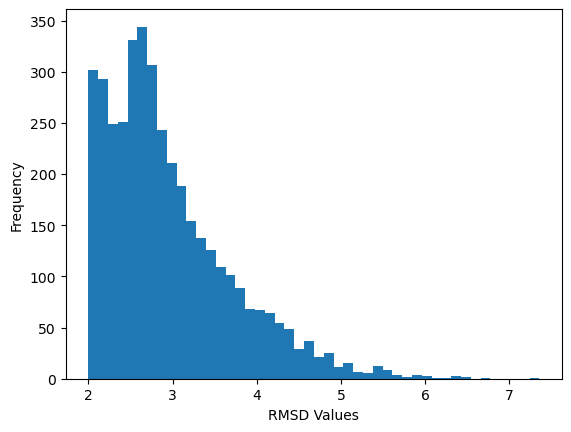

In [6]:
#Look at distribution of sidechain RMSD
#aa_list is a list w/ len = # pdbfiles --> RMSD_stored = list all RMSD

RMSD_dist_list = []
total_res = 0

for idx,pdbfile in enumerate(RMSD_stored):
    file_list = []
    total_res += len(pdbfile)
    
    for residue in pdbfile:
        file_list.append(residue.tolist())
        
    RMSD_dist_list.append(file_list) 

#Treats each residue as a set
RMSD_dist_list = flatten_to_one_list(RMSD_dist_list)

assert len(RMSD_dist_list) == total_res

#Splits up into individual atoms & replaces 0 w/ nan
RMSD_dist_list_f = flatten_to_one_list(RMSD_dist_list)
RMSD_dist_list_f = np.array(RMSD_dist_list_f)
RMSD_dist_list_f[RMSD_dist_list_f == 0] = np.nan

import matplotlib.pyplot as plt

#Plotting all
n, bins, patches = plt.hist(x=RMSD_dist_list_f, bins = 'auto')
plt.xlabel('RMSD Values')
plt.ylabel('Frequency')
plt.savefig('Sidechain RMSD Distribution Backbone less 0.1 sidechain more than 2.png')

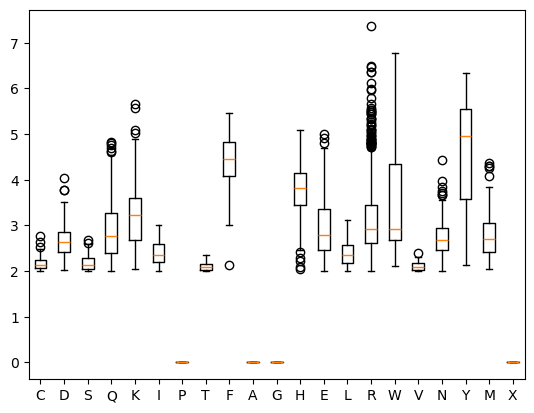

In [7]:
"""
Create dictionary --> for each residue store the RMSD values
Create boxplot w/ all residues

iterate through RMSD one by one then find 
"""
keys = letter_to_num.keys()
aa_dist_dict = {}

for key in keys:
    aa_dist_dict[key] = []
    
count_altloc_first = 0

for f_idx,stored_file in enumerate(RMSD_stored): #for each file
    for r_idx, res_RMSD in enumerate(stored_file): #for each residue
        for element in res_RMSD:                             #for each altloc
            if element != 0 and np.isnan(element) == False:  #store RMSD value
                count_altloc_first += 1
                temp_key = aa_list[f_idx][r_idx]
                aa_dist_dict[temp_key].append(element)

#Combining all aa datasets into one list
data = []
for key in keys:
    if len(aa_dist_dict[key]) == 0:
        data.append([0,0,0])
    else:
        data.append(aa_dist_dict[key])

#for each aa, print boxplot
plt.boxplot(data,labels = keys)
plt.savefig('Sidechain RMSD Boxplot Backbone less 0.1 sidechain more than 2.png')

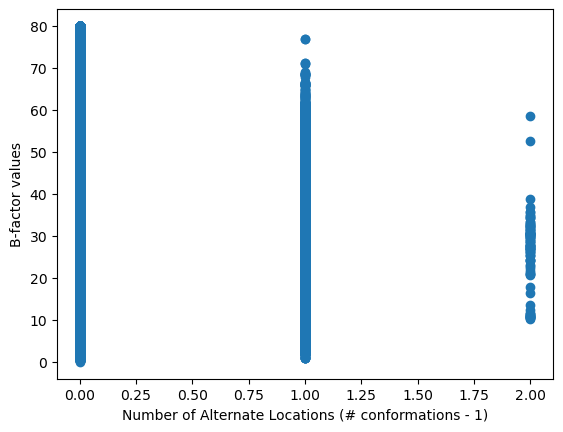

In [8]:
#Generate Scatterplot + save
plt.scatter(num_altloc, b_factor)
plt.xlabel("Number of Alternate Locations (# conformations - 1)")
plt.ylabel("B-factor values")
plt.savefig('scatterplot Backbone less 0.1 sidechain more than 2.png')

In [9]:
#Correlation calculation
from scipy.stats import f_oneway

##prepping data --> 6 different arrays
zero = []
one = []
two = []


data = {'0.0': zero, '1.0': one, '2.0': two}

#iterate through num_altloc
for idx, num in enumerate(num_altloc):
    data[str(num)].append(b_factor[idx])    #adding the corresponding b-factor

#correlation calc
correlation = f_oneway(zero,one,two)
print(correlation) 

F_onewayResult(statistic=281.92130430769555, pvalue=3.7222782370257935e-123)


In [10]:
# ** Avg conformations per structure ** --> (sum of all alt locations/num structures)
## Sum of alt locations
## Includes unknown AA ('X')
total_altloc = 0
num_res_with_altloc = 0

for sublist in res_altloc:
    total_altloc += sum(sublist)  # Count all alt loc
    for num in sublist:           # Count number of residues w/ alt loc
        if num == 0:
            continue
        num_res_with_altloc += 1

total_altloc += num_res_with_altloc #To get total num conformations (altloc + 1 for all res)

avg_conf_per_struc = total_altloc/included_files
avg_altloc = total_altloc/num_res_with_altloc
avg_res = num_res_with_altloc/included_files

print("average number of conformations per structure:" + str("%.2f" % round(avg_conf_per_struc, 2)))
print("average number of conformations (only residues with alt locations):" + str("%.2f" % round(avg_altloc, 2)))
print("average number of residues with different conformations:" + str("%.2f" % round(avg_res, 2)))

#Number of files included
print("Total number of files processed: " + str(file))
print("Number of files with different conformations: " + str(included_files))

#Calculate avg # conformations per AA type --> # conf = # altloc + 1
# Make 2 dictionaries: one w/ AA count, other w/ total 
## for each AA in seq
###   if num altloc != 0 --> find AA in dictionary and add to num stored
###sum all altloc/total num res 

#Counts freq of each AA w/ altloc
aa_res_count = {'C': 0, 'D': 0, 'S': 0, 'Q': 0, 'K': 0, 'I': 0,
                       'P': 0, 'T': 0, 'F': 0, 'A': 0, 'G': 0, 'H': 0,
                       'E': 0, 'L': 0, 'R': 0, 'W': 0, 'V': 0,
                       'N': 0, 'Y': 0, 'M': 0, 'X': 0}
aa_altloc_count = aa_res_count.copy()    #Sum of all conformations
all_aa = aa_res_count.copy()             #Counts freq of each AA
avg_per_res = aa_res_count.copy()        #avg # conf among res w/ altloc
avg_per_res_all = aa_res_count.copy()    #avg # conf overall
proportion = aa_res_count.copy()         #for each AA (%res w/ altloc / all residues)


for idx,pdbf in enumerate(res_altloc): #numaltloc for each file 
    #Get aa and add to count of all res
    aa_list_temp = aa_list[idx]
    
    for idxr,res in enumerate(pdbf):
        aa = aa_list_temp[idxr]
        all_aa[aa] += 1 
        
        if res == 0:
            continue

        #add to count and altloc
        aa_res_count[aa] += 1 
        aa_altloc_count[aa] += res+1  #Add 1 to get num of conformations

for key in avg_per_res.keys():
    total_num_altloc = aa_altloc_count[key]
    count_res = aa_res_count[key]
    total_res = all_aa[key]
    
    if count_res == 0:
        continue
        
    avg_per_res_all[key] = (total_num_altloc+total_res)/total_res
    avg_per_res[key] = total_num_altloc/count_res
    proportion[key] = (count_res/total_res)*100

average number of conformations per structure:3.17
average number of conformations (only residues with alt locations):2.00
average number of residues with different conformations:1.58
Total number of files processed: 80325
Number of files with different conformations: 2477


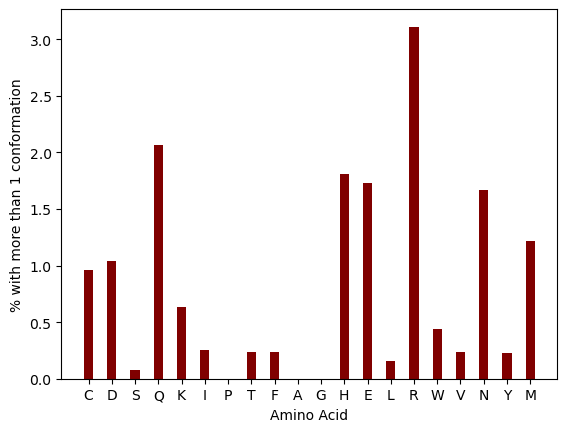

In [11]:
#Plotting as Bar Graphs
proportion.pop('X')
amino_acids = list(proportion.keys())
values = list(proportion.values())

plt.bar(amino_acids, values, color='maroon', width = 0.4)
plt.xlabel("Amino Acid")
plt.ylabel("% with more than 1 conformation")
plt.savefig('Frequency_of_all_aa Backbone less 0.1 sidechain more than 2.png')

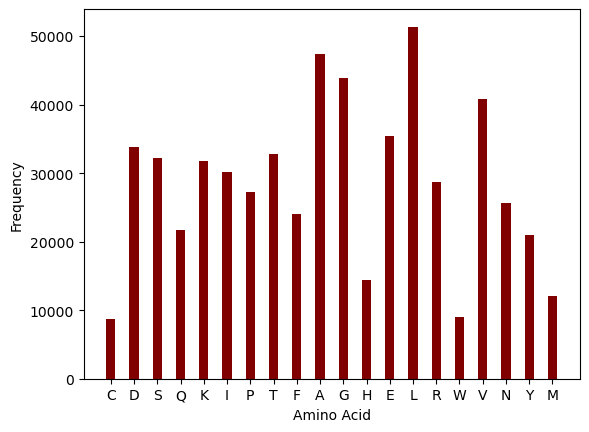

In [13]:
#Freq Overall
all_aa.pop('X')
amino_acids = list(all_aa.keys())
values = list(all_aa.values())

plt.bar(amino_acids, values, color='maroon', width = 0.4)
plt.xlabel("Amino Acid")
plt.ylabel("Frequency")
plt.savefig('All_AA Backbone less 0.1 sidechain more than 2.png')

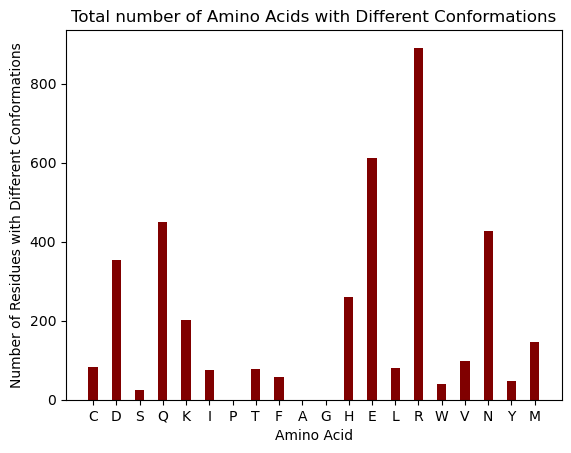

In [12]:
#with diff conformations
aa_res_count.pop('X')
values = list(aa_res_count.values())
plt.bar(amino_acids, values, color='maroon', width = 0.4)
plt.xlabel("Amino Acid")
plt.ylabel("Number of Residues with Different Conformations")
plt.title("Total number of Amino Acids with Different Conformations")
plt.savefig('Frequency_of_aa_with_altloc Backbone less 0.1 sidechain more than 2.png')


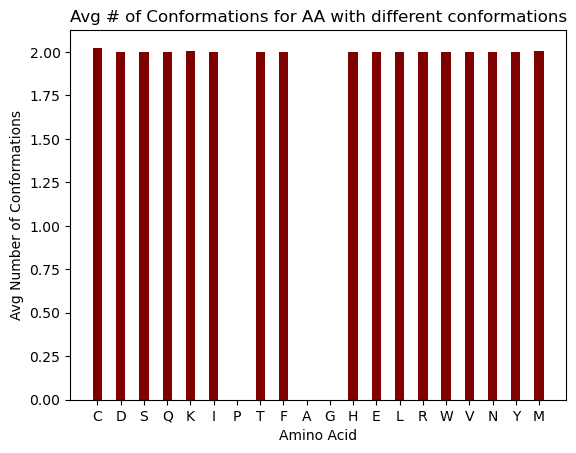

In [14]:
#Avg num conformations
avg_per_res.pop('X')
values = list(avg_per_res.values())
plt.bar(amino_acids, values, color='maroon', width = 0.4)
plt.xlabel("Amino Acid")
plt.ylabel("Avg Number of Conformations")
plt.title("Avg # of Conformations for AA with different conformations")
plt.savefig('Avg_num_conformations_by_aa_altloc Backbone less 0.1 sidechain more than 2.png')

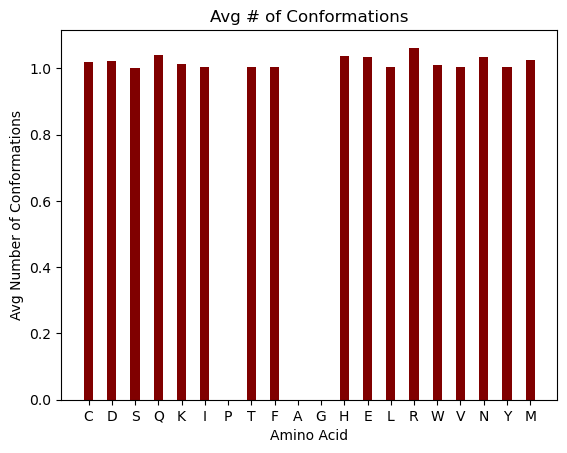

In [15]:
#Avg num conformations -- all residues included
avg_per_res_all.pop('X')
values = list(avg_per_res_all.values())
plt.bar(amino_acids, values, color='maroon', width = 0.4)
plt.xlabel("Amino Acid")
plt.ylabel("Avg Number of Conformations")
plt.title("Avg # of Conformations")
plt.savefig('Avg_num_conformations_by_aa Backbone less 0.1 sidechain more than 2.png')

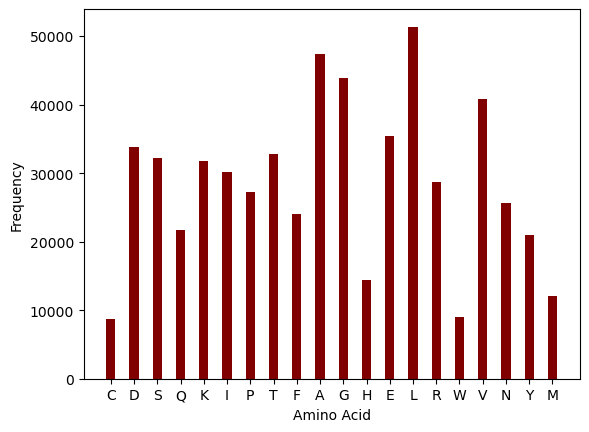

In [16]:
#Freq Overall w/o x
temp = all_aa.copy()
#temp.pop('X')
amino_acids = list(temp.keys())
values = list(temp.values())

plt.bar(amino_acids, values, color='maroon', width = 0.4)
plt.xlabel("Amino Acid")
plt.ylabel("Frequency")
plt.savefig('All_AA_without_X Backbone less 0.1 sidechain more than 2.png')

In [17]:
#create a dictionary with values
all_data = {'ID':pdb_list, 
            'avg_conf_per_struc': avg_conf_per_struc,
            'avg_conf': avg_altloc,                     #only res w/ altloc
            'avg_per_res': avg_per_res,
            'only_res_w_altloc': aa_res_count,
            'all_res_count':all_aa,
            'b_factor_all': b_factor, 
            'num_altloc_all': num_altloc,
            'correlation': correlation,
            'num_files': included_files,
            'total_processed': file
           }